In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math

In [2]:
start_day_to_analyze = '2020-02-18'
end_day_to_analyze = '2020-02-19'

In [3]:
base_url = "https://api.alpaca.markets"
api_key_id = "PKO3OSD9LU9GTQPL69GO"
api_secret = "chnPFlGXbY4Y4QAAZ3Q7MJHxkxBYB30CQZNVZTaj"

In [4]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [5]:
api = tradeapi.REST(
    base_url=base_url, key_id=api_key_id, secret_key=api_secret
)
session = requests.session()

In [6]:
query = f'''
SELECT * 
FROM 
trades as t
WHERE 
    buy_time >= '{start_day_to_analyze}' and 
    buy_time < '{end_day_to_analyze}' 
ORDER BY symbol, buy_time
'''
trades =  pd.read_sql_query(query, db_conn)

In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    buy_time = row['client_buy_time']
    buy_price = row['buy_price']
    sell_time = row['client_sell_time']
    sell_price = row['sell_price']
    buy_indicator = row['buy_indicators']
    sell_indicator = row['sell_indicators']
    qty = row['qty']    
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((buy_time, buy_price, sell_time, sell_price, buy_indicator, sell_indicator, qty))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    precentages = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[6] * (trade[3] - trade[1])
            precentage += 100.0 * delta / (trade[6] * trade[1])
            revnue += delta

        revenues[run_id].append(revnue)
        precentages.append(precentage)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
        '%': precentages
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')

TOTAL REVENUE: -12802.25 $


In [11]:
minute_history = {}
for symbol, count in symbols.items():
    minute_history[symbol] = api.polygon.historic_agg_v2(
        symbol, 
        1, 
        'minute', 
        _from = start_day_to_analyze, 
        to=end_day_to_analyze, 
        limit=5000).df

In [12]:
minute_history['KPTI']['close']

timestamp
2020-02-18 07:06:00-05:00    15.1000
2020-02-18 07:09:00-05:00    15.0200
2020-02-18 07:12:00-05:00    15.0200
2020-02-18 08:00:00-05:00    15.4999
2020-02-18 08:59:00-05:00    15.8500
                              ...   
2020-02-18 15:59:00-05:00    16.3300
2020-02-18 16:00:00-05:00    16.3400
2020-02-18 16:05:00-05:00    16.4000
2020-02-18 16:07:00-05:00    16.4000
2020-02-18 17:01:00-05:00    16.3400
Name: close, Length: 381, dtype: float64

all


winners analysis


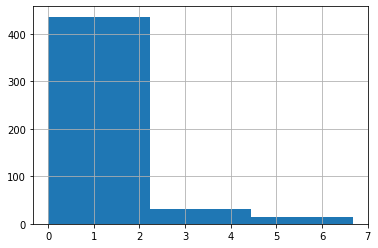

In [15]:
slopes = []
win = []
macd = []
macd_signal = []
bail_outs = []
symbols = []
r_ids = []

for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        for trade in trade_details[run_id][symbol]:
            if math.isnan(trade[3]):
                continue 
                
            min_time = trade_details[run_id][symbol][0][0]
            max_time = trade_details[run_id][symbol][-1][2]
            
            if min_time is None or max_time is None:
                continue
             
            try:
                max_val = minute_history[symbol]['close'][min_time:max_time].max()
            except Exception:
                continue
                
            if math.isnan(max_val):
                continue
            max_val_index = minute_history[symbol]['close'][min_time:max_time].idxmax()
            
            macds = MACD(
                minute_history[symbol]["close"][:max_val_index]
                .dropna()
                .between_time("9:30", "16:00"),
                13,
                21,
            )
            
            macd_val = macds[0][-1].round(2)
            
            if math.isnan(macd_val):
                print(macds[0][-5])
            macd.append(macd_val)
            macd_signal_val = macds[1][-1].round(2)
            macd_signal.append(macd_signal_val)
            
            bail_out = ((max_val - trade[1]) / trade[1] > 0.003 and macd_val == macd_signal_val)
            bail_outs.append(bail_out)
            #if bail_out == True:
            #     print('bailout!!!')
            
            slope = 100.0 * (max_val - trade[1]) / trade[1]
            slopes.append(slope)
            win.append(trade[3] >= trade[1])
            symbols.append(symbol)
            r_ids.append(run_id)
            #plt.scatter(slope, int(trade[3] >= trade[1]), c=('g' if win else 'r'), s=10)
            
#plt.show()           


d = {
    'symobl':symbols,
    'run': r_ids,
    'win': win,
    'max_val %': slopes,
    'bail_outs': bail_outs,
    'macd': macd,
    'macd_signal': macd_signal,
}
slope_analysis = pd.DataFrame(data=d)
print("all")
display(HTML(slope_analysis.sort_values(by=['win']).to_html()))
print("winners analysis")
display(HTML(slope_analysis.loc[slope_analysis['max_val %'] > 0].sort_values(by=['win']).to_html()))
slope_analysis.loc[slope_analysis['max_val %'] > 0]['max_val %'].hist(bins=3)


AUY analysis for run 66


/Users/amichayoren/venv/algo/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


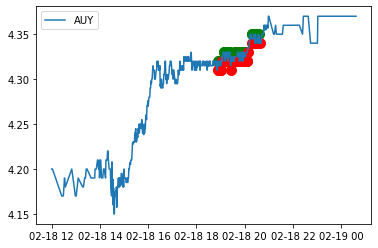

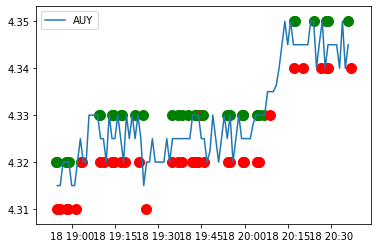

Delta = -0.41999999999999726


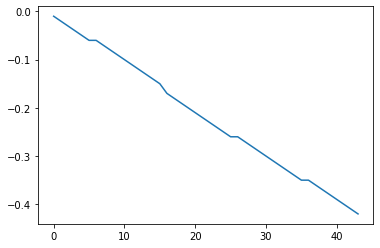

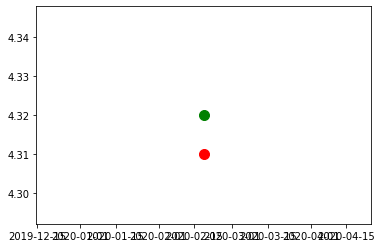

buy time:2020-02-18T18:54:38.952278023Z sell time:2020-02-18T18:54:43.509228006Z
{'rsi': 53.796719927330514, 'macd1': [0.0009570711435671342, 0.00019671025074519122, -0.0004012558077421957, -6.745422042886418e-05, 0.00019483994878211064], 'macd2': [0.000849868941759091, 0.000706217339205395, 0.0005729237738982818, 0.0006093091442034293, 0.0006418103439216338], 'macd_signal': [0.0005770206406027769, 0.0005009585626312597, 0.00032051568855656864, 0.00024292170675948208, 0.0002333053551640078]}
{'rsi': 48.031381228094865, 'macd': [0.0006141202986462702, 0.00011491311101075041, -0.00027557188079629924, -5.678652531138084e-05, -0.00014530720252636797], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011574074074073826, 'too_close': 1, 'macd_signal': [0.00037543312061520494, 0.00032332911869431406, 0.00020354891879619137, 0.00015148182997467693, 9.212402347446794e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to

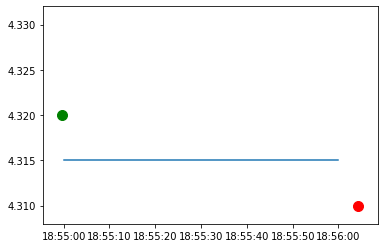

buy time:2020-02-18T18:54:59.738302097Z sell time:2020-02-18T18:56:04.190562999Z
{'rsi': 53.796719927330514, 'macd1': [0.0009570711435671342, 0.00019671025074519122, -0.0004012558077421957, -6.745422042886418e-05, 0.00019483994878211064], 'macd2': [0.000849868941759091, 0.000706217339205395, 0.0005729237738982818, 0.0006093091442034293, 0.0006418103439216338], 'macd_signal': [0.0005770206406027769, 0.0005009585626312597, 0.00032051568855656864, 0.00024292170675948208, 0.0002333053551640078]}
{'rsi': 48.03138122809487, 'macd': [-0.00027557188079629924, -5.678652531138084e-05, -0.00014530720252636797, -0.00021239724707733387, -0.000261916798064199], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011574074074073826, 'too_close': 0, 'macd_signal': [0.00020354891879619137, 0.00015148182997467693, 9.212402347446794e-05, 3.121976936410757e-05, -2.740754412155374e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_

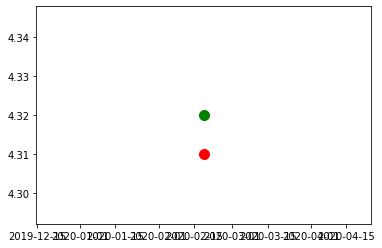

buy time:2020-02-18T18:58:10.526564459Z sell time:2020-02-18T18:58:14.249604674Z
{'rsi': 54.16628978699063, 'macd1': [-0.00020402045007905656, -0.000308691764475455, -0.0003871813496640897, -4.540331698077438e-05, 0.00022288891166866165], 'macd2': [0.0005618423311268828, 0.0005172727564710655, 0.000475440016643347, 0.0005161601708181252, 0.0005527984891191551], 'macd_signal': [0.00015353327539177435, 6.108826741832847e-05, -2.8565655998155165e-05, -3.1933188194679005e-05, 1.903123177798913e-05]}
{'rsi': 43.18578275427384, 'macd': [-0.00014530720252636797, -0.00021239724707733387, -0.000261916798064199, -3.736168457280087e-05, -0.000381378976856972], 'scalp': 0, 'bail_out': 0, 'movement': -0.002314814814814971, 'too_close': 1, 'macd_signal': [9.212402347446794e-05, 3.121976936410757e-05, -2.740754412155374e-05, -2.9398372211803167e-05, -9.979449314083692e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_t

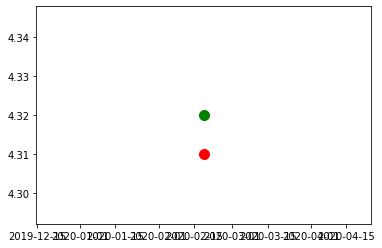

buy time:2020-02-18T18:58:21.95992354Z sell time:2020-02-18T18:58:26.42450091Z
{'rsi': 54.16628978699063, 'macd1': [-0.00020402045007905656, -0.000308691764475455, -0.0003871813496640897, -4.540331698077438e-05, 0.00022288891166866165], 'macd2': [0.0005618423311268828, 0.0005172727564710655, 0.000475440016643347, 0.0005161601708181252, 0.0005527984891191551], 'macd_signal': [0.00015353327539177435, 6.108826741832847e-05, -2.8565655998155165e-05, -3.1933188194679005e-05, 1.903123177798913e-05]}
{'rsi': 48.05678117134124, 'macd': [-0.00014530720252636797, -0.00021239724707733387, -0.000261916798064199, -3.736168457280087e-05, -0.000121638717117456], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011574074074073826, 'too_close': 1, 'macd_signal': [9.212402347446794e-05, 3.121976936410757e-05, -2.740754412155374e-05, -2.9398372211803167e-05, -4.784644119293374e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to

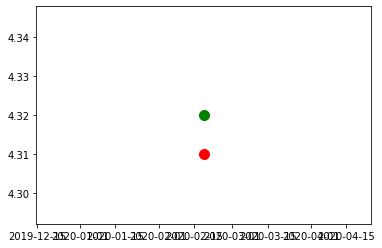

buy time:2020-02-18T18:58:34.873708237Z sell time:2020-02-18T18:58:38.878614596Z
{'rsi': 54.16628978699063, 'macd1': [-0.00020402045007905656, -0.000308691764475455, -0.0003871813496640897, -4.540331698077438e-05, 0.00022288891166866165], 'macd2': [0.0005618423311268828, 0.0005172727564710655, 0.000475440016643347, 0.0005161601708181252, 0.0005527984891191551], 'macd_signal': [0.00015353327539177435, 6.108826741832847e-05, -2.8565655998155165e-05, -3.1933188194679005e-05, 1.903123177798913e-05]}
{'rsi': 48.05678117134124, 'macd': [-0.00014530720252636797, -0.00021239724707733387, -0.000261916798064199, -3.736168457280087e-05, -0.000121638717117456], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011574074074073826, 'too_close': 1, 'macd_signal': [9.212402347446794e-05, 3.121976936410757e-05, -2.740754412155374e-05, -2.9398372211803167e-05, -4.784644119293374e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_

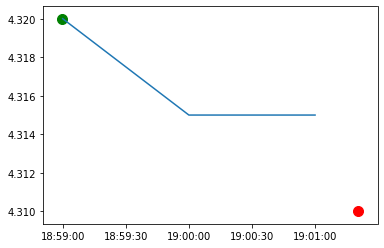

buy time:2020-02-18T18:58:59.706379082Z sell time:2020-02-18T19:01:20.435475263Z
{'rsi': 54.16628978699063, 'macd1': [-0.00020402045007905656, -0.000308691764475455, -0.0003871813496640897, -4.540331698077438e-05, 0.00022288891166866165], 'macd2': [0.0005618423311268828, 0.0005172727564710655, 0.000475440016643347, 0.0005161601708181252, 0.0005527984891191551], 'macd_signal': [0.00015353327539177435, 6.108826741832847e-05, -2.8565655998155165e-05, -3.1933188194679005e-05, 1.903123177798913e-05]}
{'rsi': 47.20612779514859, 'macd': [-3.736168457280087e-05, 0.00013810154262294816, 0.00027303260871569535, 0.00011488756140209944, -9.834391847540758e-06], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011574074074073826, 'too_close': 1, 'macd_signal': [-2.9398372211803167e-05, 4.1016107551471e-06, 5.7887810347256755e-05, 6.928776055822529e-05, 5.346333007707208e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_

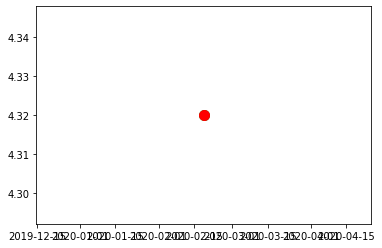

buy time:2020-02-18T19:03:07.536547674Z sell time:2020-02-18T19:03:43.42053429Z
{'rsi': 54.053337045379656, 'macd1': [0.00043054933113229055, 0.0001894792970240644, -1.5525450498543591e-06, 0.0002476567244942274, 0.0004400838533449303], 'macd2': [0.0005856227899805333, 0.0005349175621205404, 0.0004874116046824639, 0.0005228930703022883, 0.0005547008592303726], 'macd_signal': [0.00010133485164884941, 0.00011896374072389241, 9.486048356914306e-05, 0.0001254197317541599, 0.00018835255607231398]}
{'rsi': 54.053337045379656, 'macd': [0.00027303260871569535, 0.00011488756140209944, -9.834391847540758e-06, 0.00015284764967038456, 0.0002776278424159173], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [5.7887810347256755e-05, 6.928776055822529e-05, 5.346333007707208e-05, 7.334019399573457e-05, 0.00011419772367977113], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00016

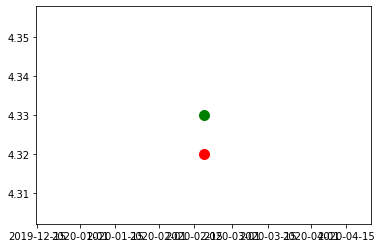

buy time:2020-02-18T19:09:34.28367009Z sell time:2020-02-18T19:09:38.931695294Z
{'rsi': 62.78900126792366, 'macd1': [0.0009265617275948657, 0.0017394049962424774, 0.002356425733829326, 0.0028129926851150344, 0.0031386449382857506], 'macd2': [0.0006755796872663922, 0.0008519678800089636, 0.001012888055930361, 0.0011593197922641352, 0.0012921875036333574], 'macd_signal': [0.0004999173435183911, 0.0007478148740632084, 0.001069537046016432, 0.0014182281738361524, 0.001762311526726072]}
{'rsi': 55.421430364510336, 'macd': [0.0005885112100196821, 0.0011145584780818396, 0.0015099906547781927, 0.0017985093553889442, 0.0017402315980028504], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0003152795964068426, 0.000475135372741842, 0.0006821064291491121, 0.0009053870143970785, 0.001072355931118233], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00066

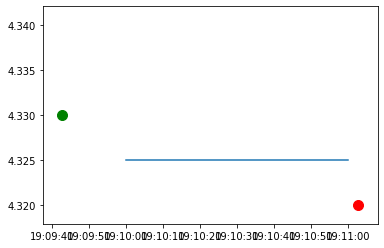

buy time:2020-02-18T19:09:42.59556671Z sell time:2020-02-18T19:11:02.674332298Z
{'rsi': 62.78900126792366, 'macd1': [0.0009265617275948657, 0.0017394049962424774, 0.002356425733829326, 0.0028129926851150344, 0.0031386449382857506], 'macd2': [0.0006755796872663922, 0.0008519678800089636, 0.001012888055930361, 0.0011593197922641352, 0.0012921875036333574], 'macd_signal': [0.0004999173435183911, 0.0007478148740632084, 0.001069537046016432, 0.0014182281738361524, 0.001762311526726072]}
{'rsi': 54.92566891684054, 'macd': [0.0015099906547781927, 0.0017985093553889442, 0.0019999718577423664, 0.0018712417055795072, 0.0017466306557700761], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0006821064291491121, 0.0009053870143970785, 0.001124303983066136, 0.0012736915275688102, 0.0013682793532090634], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00037

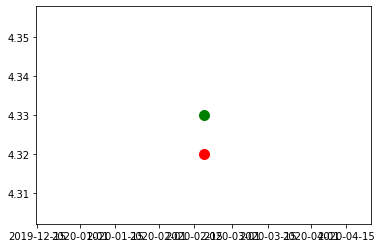

buy time:2020-02-18T19:14:02.723975833Z sell time:2020-02-18T19:14:06.713469946Z
{'rsi': 59.125082204426526, 'macd1': [0.0029591571601343958, 0.0027848102438028377, 0.0022176175287995648, 0.0025456845751206103, 0.0027737065108413006], 'macd2': [0.001332395362029004, 0.0013672568977023403, 0.0013171758765091468, 0.0014289291219018452, 0.0015294603098903181], 'macd_signal': [0.002001680653407737, 0.002158306571486757, 0.0021701687629493184, 0.0022452719253835767, 0.0023509588424751216]}
{'rsi': 48.02802549686472, 'macd': [0.0018712417055795072, 0.0017466306557700761, 0.0013671073616885465, 0.0015731008031609761, 0.0011937047730992134], 'scalp': 0, 'bail_out': 0, 'movement': -0.002309468822170851, 'too_close': 1, 'macd_signal': [0.0012736915275688102, 0.0013682793532090634, 0.00136804495490496, 0.0014090561245561632, 0.0013659858542647732], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000

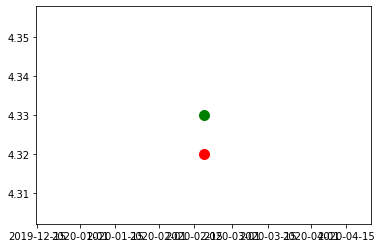

buy time:2020-02-18T19:14:13.208620636Z sell time:2020-02-18T19:14:15.443671008Z
{'rsi': 59.125082204426526, 'macd1': [0.0029591571601343958, 0.0027848102438028377, 0.0022176175287995648, 0.0025456845751206103, 0.0027737065108413006], 'macd2': [0.001332395362029004, 0.0013672568977023403, 0.0013171758765091468, 0.0014289291219018452, 0.0015294603098903181], 'macd_signal': [0.002001680653407737, 0.002158306571486757, 0.0021701687629493184, 0.0022452719253835767, 0.0023509588424751216]}
{'rsi': 53.001933710303405, 'macd': [0.0018712417055795072, 0.0017466306557700761, 0.0013671073616885465, 0.0015731008031609761, 0.0014534450328387294], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0012736915275688102, 0.0013682793532090634, 0.00136804495490496, 0.0014090561245561632, 0.0014179339062126764], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 3.55

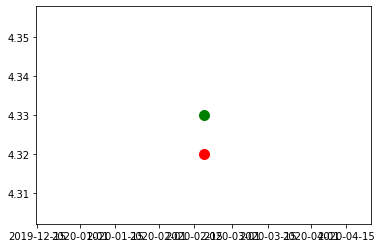

buy time:2020-02-18T19:14:17.582197584Z sell time:2020-02-18T19:14:20.534310359Z
{'rsi': 59.125082204426526, 'macd1': [0.0029591571601343958, 0.0027848102438028377, 0.0022176175287995648, 0.0025456845751206103, 0.0027737065108413006], 'macd2': [0.001332395362029004, 0.0013672568977023403, 0.0013171758765091468, 0.0014289291219018452, 0.0015294603098903181], 'macd_signal': [0.002001680653407737, 0.002158306571486757, 0.0021701687629493184, 0.0022452719253835767, 0.0023509588424751216]}
{'rsi': 54.468569753611796, 'macd': [0.0018712417055795072, 0.0017466306557700761, 0.0013671073616885465, 0.0015731008031609761, 0.001520977500371501], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008545034642032929, 'too_close': 1, 'macd_signal': [0.0012736915275688102, 0.0013682793532090634, 0.00136804495490496, 0.0014090561245561632, 0.0014314403997192308], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 8.953

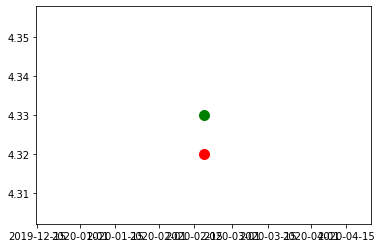

buy time:2020-02-18T19:14:22.962805188Z sell time:2020-02-18T19:14:33.828417205Z
{'rsi': 59.125082204426526, 'macd1': [0.0029591571601343958, 0.0027848102438028377, 0.0022176175287995648, 0.0025456845751206103, 0.0027737065108413006], 'macd2': [0.001332395362029004, 0.0013672568977023403, 0.0013171758765091468, 0.0014289291219018452, 0.0015294603098903181], 'macd_signal': [0.002001680653407737, 0.002158306571486757, 0.0021701687629493184, 0.0022452719253835767, 0.0023509588424751216]}
{'rsi': 54.936312197739014, 'macd': [0.0018712417055795072, 0.0017466306557700761, 0.0013671073616885465, 0.0015731008031609761, 0.0015417567211502003], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007621247113164671, 'too_close': 1, 'macd_signal': [0.0012736915275688102, 0.0013682793532090634, 0.00136804495490496, 0.0014090561245561632, 0.0014355962438749707], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00

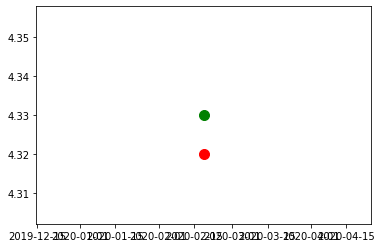

buy time:2020-02-18T19:17:03.516946287Z sell time:2020-02-18T19:17:09.728579825Z
{'rsi': 58.04149163609965, 'macd1': [0.0025456845751206103, 0.0023748461119810216, 0.002213934539868845, 0.002461494595451974, 0.002627400683495651], 'macd2': [0.0014289291219018452, 0.0014494922970964552, 0.0014660928156624564, 0.0015589890259617434, 0.0016419631258397516], 'macd_signal': [0.0022452719253835767, 0.0022711867627030658, 0.0022597363181362214, 0.002300087973599372, 0.0023655505155786277]}
{'rsi': 52.03286926602436, 'macd': [0.0015731008031609761, 0.0014534450328387294, 0.0013413308607326258, 0.0014962895466137383, 0.001337863983059684], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0014090561245561632, 0.0014179339062126764, 0.0014026132971166664, 0.0014213485470160807, 0.0014046516342248014], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -6.678

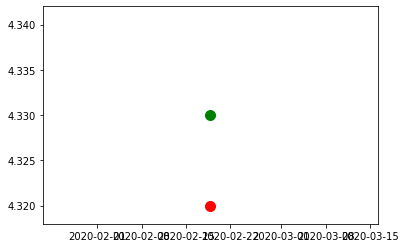

buy time:2020-02-18T19:17:17.019440316Z sell time:2020-02-18T19:18:35.563435498Z
{'rsi': 58.04149163609965, 'macd1': [0.0025456845751206103, 0.0023748461119810216, 0.002213934539868845, 0.002461494595451974, 0.002627400683495651], 'macd2': [0.0014289291219018452, 0.0014494922970964552, 0.0014660928156624564, 0.0015589890259617434, 0.0016419631258397516], 'macd_signal': [0.0022452719253835767, 0.0022711867627030658, 0.0022597363181362214, 0.002300087973599372, 0.0023655505155786277]}
{'rsi': 52.03286926602436, 'macd': [0.0014534450328387294, 0.0013413308607326258, 0.0014962895466137383, 0.001337863983059684, 0.001197040635054769], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0014179339062126764, 0.0014026132971166664, 0.0014213485470160807, 0.0014046516342248014, 0.0013631294343907949], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0001

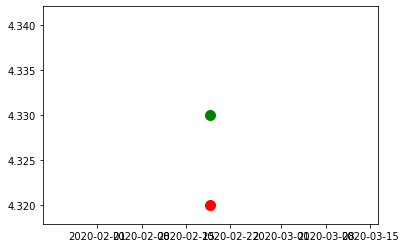

buy time:2020-02-18T19:22:05.162127025Z sell time:2020-02-18T19:23:20.926201467Z
{'rsi': 55.53162047484692, 'macd1': [0.0016217693541147327, 0.0019256181196141142, 0.0017428715043266152, 0.0019786925720719495, 0.002140903464782795], 'macd2': [0.0014822946036190388, 0.001566532888063854, 0.0015615613410648876, 0.001634457872448536, 0.0016989109261169588], 'macd_signal': [0.0021529766194683464, 0.0021075049194975, 0.002034578236463323, 0.0020234011035850483, 0.0020469015758245975]}
{'rsi': 50.82725729874876, 'macd': [0.001132480676094616, 0.0010101214211681864, 0.001161398346924969, 0.0010044531157360481, 0.0008691132847351568], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0012754412411732368, 0.0012223772771722268, 0.001210181491122775, 0.0011690358160454297, 0.0011090513097833752], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00023993

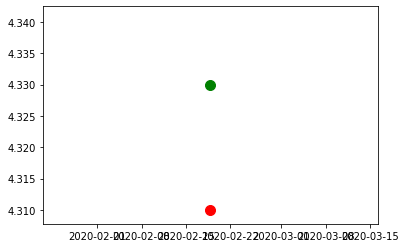

buy time:2020-02-18T19:24:35.997644126Z sell time:2020-02-18T19:25:41.811230257Z
{'rsi': 54.93830661398134, 'macd1': [0.0017428715043266152, 0.0019786925720719495, 0.0017420430659225161, 0.001935641964911028, 0.0020652634160862604], 'macd2': [0.0015615613410648876, 0.001634457872448536, 0.0016189429133213196, 0.001682047394487185, 0.0017374153359446254], 'macd_signal': [0.002034578236463323, 0.0020234011035850483, 0.0019671294960525417, 0.0019608319898242388, 0.0019817182750766433]}
{'rsi': 42.78825730404392, 'macd': [0.001161398346924969, 0.0010044531157360481, 0.001128853544475561, 0.0009513882481098079, 0.0002812673905774332], 'scalp': 0, 'bail_out': 0, 'movement': -0.003464203233256277, 'too_close': 1, 'macd_signal': [0.001210181491122775, 0.0011690358160454297, 0.001160999361731456, 0.0011190771390071263, 0.0009515151893211877], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006702

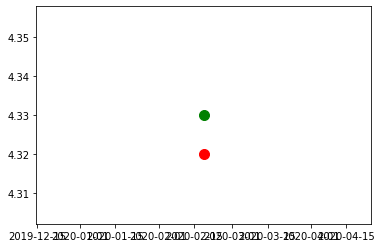

buy time:2020-02-18T19:34:48.896800643Z sell time:2020-02-18T19:34:50.85890071Z
{'rsi': 56.841617799212166, 'macd1': [-0.0004652746883921921, -0.0006336060686491507, -0.0007582690467007325, -0.0004484378295419589, 0.0001982782275433692], 'macd2': [0.0011250261041251264, 0.0010499361697489107, 0.0009791718020251139, 0.0009924682844957289, 0.0010830821721512507], 'macd_signal': [0.0004219429962643136, 0.00021083318328162073, 1.7012737285150093e-05, -7.607737608027171e-05, -2.1206255355543527e-05]}
{'rsi': 52.350309709500074, 'macd': [-0.00040894688817605385, -0.0005103089392912707, -0.0005826649669229411, -0.00037173894992292844, -0.00020255323602746955], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 0, 'macd_signal': [0.00015626758224174624, 2.2952277935142857e-05, -9.817117103647396e-05, -0.00015288472681376485, -0.00016281842865650578], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distanc

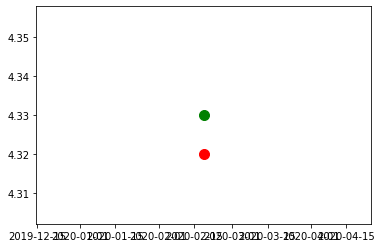

buy time:2020-02-18T19:36:44.949876807Z sell time:2020-02-18T19:36:51.192821338Z
{'rsi': 56.571632259764506, 'macd1': [-0.0007582690467007325, -0.0004484378295419589, -0.000599442570178077, -0.0003120594744352445, 0.00031551485384717637], 'macd2': [0.0009791718020251139, 0.0009924682844957289, 0.0009231461465608604, 0.0009378591317776852, 0.0010298635869787631], 'macd_signal': [1.7012737285150093e-05, -7.607737608027171e-05, -0.00018075041489983278, -0.00020701222680691512, -0.0001025068106760968]}
{'rsi': 52.26172184596284, 'macd': [-0.0005826649669229411, -0.00037173894992292844, -0.0004622934957678737, -0.0002671114081698178, -0.00011155249045469162], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 0, 'macd_signal': [-9.817117103647396e-05, -0.00015288472681376485, -0.00021476648060458664, -0.0002252354661176329, -0.00020249887098504462], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'dista

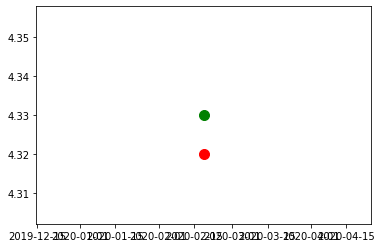

buy time:2020-02-18T19:38:10.603149712Z sell time:2020-02-18T19:38:13.577803287Z
{'rsi': 57.189126121593894, 'macd1': [-0.000599442570178077, -0.0003120594744352445, -8.334554501399083e-05, 9.679608681256724e-05, 0.00063569000249597], 'macd2': [0.0009231461465608604, 0.0009378591317776852, 0.000949895574184012, 0.0009594502609813205, 0.0010466743846428983], 'macd_signal': [-0.00018075041489983278, -0.00020701222680691512, -0.00018227889044833027, -0.00012646389499615076, 2.5966884502273414e-05]}
{'rsi': 52.26172184596284, 'macd': [-0.0004622934957678737, -0.0002671114081698178, -0.00011155249045469162, 1.1110984264206536e-05, 0.00010654861412007222], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 0, 'macd_signal': [-0.00021476648060458664, -0.0002252354661176329, -0.00020249887098504462, -0.00015977689993519438, -0.00010651179712414105], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance

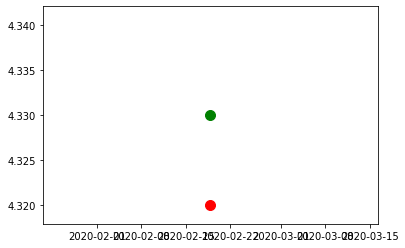

buy time:2020-02-18T19:40:29.865708635Z sell time:2020-02-18T19:41:44.446870939Z
{'rsi': 57.88363749162224, 'macd1': [-8.334554501399083e-05, 9.679608681256724e-05, 0.00023682960363657912, 0.000343843560081325, 0.0008226283571808324], 'macd2': [0.000949895574184012, 0.0009594502609813205, 0.000966706371847259, 0.0009718361141963783, 0.0010549693379822145], 'macd_signal': [-0.00018227889044833027, -0.00012646389499615076, -5.3805195269604784e-05, 2.5724555800581177e-05, 0.00018510531607663142]}
{'rsi': 52.26172184596284, 'macd': [1.1110984264206536e-05, 0.00010654861412007222, 0.00017953185018804163, 0.00023407032179623144, 0.00027352795783208705], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [-0.00015977689993519438, -0.00010651179712414105, -4.930306766170451e-05, 7.371610229882685e-06, 6.060287975032356e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_t

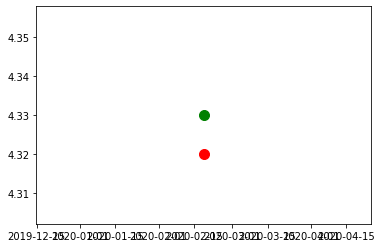

buy time:2020-02-18T19:42:52.850552213Z sell time:2020-02-18T19:42:56.522010696Z
{'rsi': 58.661405965800704, 'macd1': [0.00023682960363657912, 0.000343843560081325, 0.0004237679583196652, 0.00048155752436684907, 0.0009202068137268427], 'macd2': [0.000966706371847259, 0.0009718361141963783, 0.0009750013251874634, 0.0009763540421756645, 0.0010560050560188827], 'macd_signal': [-5.3805195269604784e-05, 2.5724555800581177e-05, 0.00010533323630439798, 0.0001805780939168882, 0.0003285038378788791]}
{'rsi': 52.261721845962825, 'macd': [0.00010654861412007222, 0.00017953185018804163, 0.00023407032179623144, 0.00027352795783208705, 0.0003007218565889147], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [-0.00010651179712414105, -4.930306766170451e-05, 7.371610229882685e-06, 6.060287975032356e-05, 0.00010862667511804179], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_s

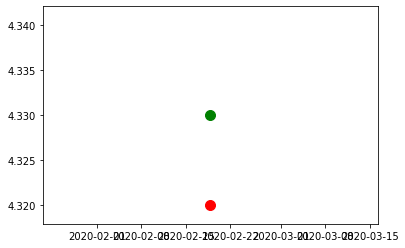

buy time:2020-02-18T19:42:59.578941689Z sell time:2020-02-18T19:43:06.713011029Z
{'rsi': 58.661405965800704, 'macd1': [0.00023682960363657912, 0.000343843560081325, 0.0004237679583196652, 0.00048155752436684907, 0.0009202068137268427], 'macd2': [0.000966706371847259, 0.0009718361141963783, 0.0009750013251874634, 0.0009763540421756645, 0.0010560050560188827], 'macd_signal': [-5.3805195269604784e-05, 2.5724555800581177e-05, 0.00010533323630439798, 0.0001805780939168882, 0.0003285038378788791]}
{'rsi': 51.260880866907186, 'macd': [0.00017953185018804163, 0.00023407032179623144, 0.00027352795783208705, 0.0005604621163293189, 0.0005170281863753345], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [-4.930306766170451e-05, 7.371610229882685e-06, 6.060287975032356e-05, 0.0001605747270661226, 0.000231865418927965], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal

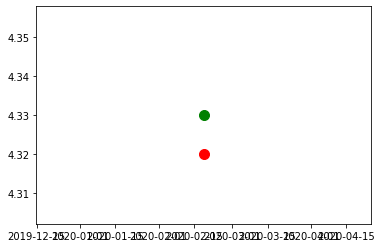

buy time:2020-02-18T19:43:32.030915533Z sell time:2020-02-18T19:43:34.448969652Z
{'rsi': 58.661405965800704, 'macd1': [0.000343843560081325, 0.0004237679583196652, 0.00048155752436684907, 0.0009202068137268427, 0.0012533912220433763], 'macd2': [0.0009718361141963783, 0.0009750013251874634, 0.0009763540421756645, 0.0010560050560188827, 0.0011275976040518998], 'macd_signal': [2.5724555800581177e-05, 0.00010533323630439798, 0.0001805780939168882, 0.0003285038378788791, 0.0005134813147117785]}
{'rsi': 51.260880866907186, 'macd': [0.00017953185018804163, 0.00023407032179623144, 0.00027352795783208705, 0.0005604621163293189, 0.0005170281863753345], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [-4.930306766170451e-05, 7.371610229882685e-06, 6.060287975032356e-05, 0.0001605747270661226, 0.000231865418927965], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_m

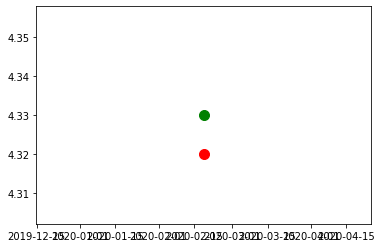

buy time:2020-02-18T19:43:40.056230616Z sell time:2020-02-18T19:43:46.542118909Z
{'rsi': 58.661405965800704, 'macd1': [0.000343843560081325, 0.0004237679583196652, 0.00048155752436684907, 0.0009202068137268427, 0.0012533912220433763], 'macd2': [0.0009718361141963783, 0.0009750013251874634, 0.0009763540421756645, 0.0010560050560188827, 0.0011275976040518998], 'macd_signal': [2.5724555800581177e-05, 0.00010533323630439798, 0.0001805780939168882, 0.0003285038378788791, 0.0005134813147117785]}
{'rsi': 51.260880866907186, 'macd': [0.00017953185018804163, 0.00023407032179623144, 0.00027352795783208705, 0.0005604621163293189, 0.0005170281863753345], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [-4.930306766170451e-05, 7.371610229882685e-06, 6.060287975032356e-05, 0.0001605747270661226, 0.000231865418927965], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_m

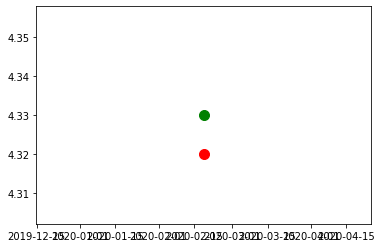

buy time:2020-02-18T19:43:53.786898075Z sell time:2020-02-18T19:43:56.958856254Z
{'rsi': 58.661405965800704, 'macd1': [0.000343843560081325, 0.0004237679583196652, 0.00048155752436684907, 0.0009202068137268427, 0.0012533912220433763], 'macd2': [0.0009718361141963783, 0.0009750013251874634, 0.0009763540421756645, 0.0010560050560188827, 0.0011275976040518998], 'macd_signal': [2.5724555800581177e-05, 0.00010533323630439798, 0.0001805780939168882, 0.0003285038378788791, 0.0005134813147117785]}
{'rsi': 51.260880866907186, 'macd': [0.00017953185018804163, 0.00023407032179623144, 0.00027352795783208705, 0.0005604621163293189, 0.0005170281863753345], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [-4.930306766170451e-05, 7.371610229882685e-06, 6.060287975032356e-05, 0.0001605747270661226, 0.000231865418927965], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_m

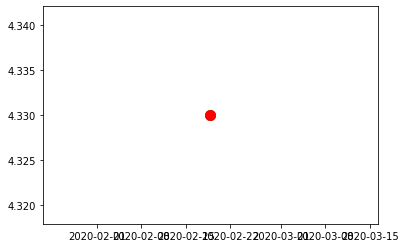

buy time:2020-02-18T19:44:00.949526277Z sell time:2020-02-18T19:45:14.374192477Z
{'rsi': 58.661405965800704, 'macd1': [0.000343843560081325, 0.0004237679583196652, 0.00048155752436684907, 0.0009202068137268427, 0.0012533912220433763], 'macd2': [0.0009718361141963783, 0.0009750013251874634, 0.0009763540421756645, 0.0010560050560188827, 0.0011275976040518998], 'macd_signal': [2.5724555800581177e-05, 0.00010533323630439798, 0.0001805780939168882, 0.0003285038378788791, 0.0005134813147117785]}
{'rsi': 58.661405965800704, 'macd': [0.00027352795783208705, 0.0005604621163293189, 0.0007767684461148505, 0.000935230931062847, 0.0010465623358140164], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [6.060287975032356e-05, 0.0001605747270661226, 0.0002838134708758682, 0.00041409696291326396, 0.0005405900374934145], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0005059722983

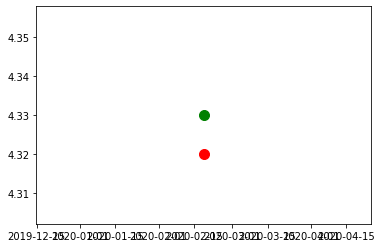

buy time:2020-02-18T19:45:44.487967737Z sell time:2020-02-18T19:45:47.088972646Z
{'rsi': 58.661405965800704, 'macd1': [0.00048155752436684907, 0.0009202068137268427, 0.0012533912220433763, 0.0015001494767412638, 0.0016763828731365393], 'macd2': [0.0009763540421756645, 0.0010560050560188827, 0.0011275976040518998, 0.0011916616034950422, 0.0012486966360043539], 'macd_signal': [0.0001805780939168882, 0.0003285038378788791, 0.0005134813147117785, 0.0007108149471176757, 0.0009039285323214484]}
{'rsi': 50.248119923623236, 'macd': [0.00027352795783208705, 0.0005604621163293189, 0.0007767684461148505, 0.000935230931062847, 0.0007868220760745004], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [6.060287975032356e-05, 0.0001605747270661226, 0.0002838134708758682, 0.00041409696291326396, 0.0004886419855455112], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd

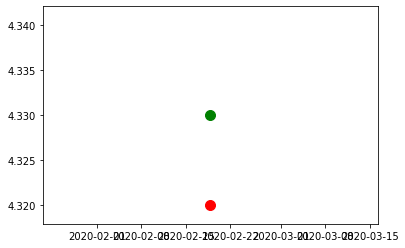

buy time:2020-02-18T19:53:56.239229144Z sell time:2020-02-18T19:54:06.722424718Z
{'rsi': 55.792487354586285, 'macd1': [0.0006753131074805907, 0.0005875335501785983, 0.00011320445485463182, 0.00013914941487325194, 0.0005567513132929136], 'macd2': [0.0010500044866521563, 0.0010297780864956252, 0.0009295541524281248, 0.0009158262480299939, 0.0009816994135585233], 'macd_signal': [0.0006947930667978338, 0.0006733411634739868, 0.0005613138217501158, 0.00047688094037474303, 0.0004928550149583771]}
{'rsi': 45.52418385475824, 'macd': [0.0003332226780186076, 2.4334854185070753e-05, 4.3067266077834176e-05, 0.00031684489526639936, 6.582724565440401e-06], 'scalp': 0, 'bail_out': 0, 'movement': -0.002309468822170851, 'too_close': 1, 'macd_signal': [0.0003895535794541749, 0.00031650983440035407, 0.00026182132073585007, 0.0002728260356419599, 0.00021957737342665601], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal

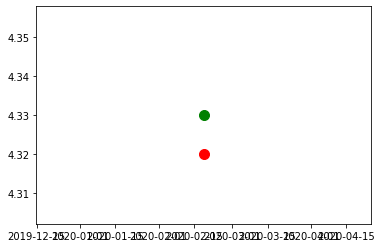

buy time:2020-02-18T19:54:49.037161717Z sell time:2020-02-18T19:54:57.956877409Z
{'rsi': 55.792487354586285, 'macd1': [0.0005875335501785983, 0.00011320445485463182, 0.00013914941487325194, 0.0005567513132929136, 0.0008775875435276248], 'macd2': [0.0010297780864956252, 0.0009295541524281248, 0.0009158262480299939, 0.0009816994135585233, 0.0010407347419176816], 'macd_signal': [0.0006733411634739868, 0.0005613138217501158, 0.00047688094037474303, 0.0004928550149583771, 0.0005698015206722267]}
{'rsi': 50.13799647634302, 'macd': [0.0003332226780186076, 2.4334854185070753e-05, 4.3067266077834176e-05, 0.00031684489526639936, 0.00026632298430584456], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0003895535794541749, 0.00031650983440035407, 0.00026182132073585007, 0.0002728260356419599, 0.00027152542537473684], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_sign

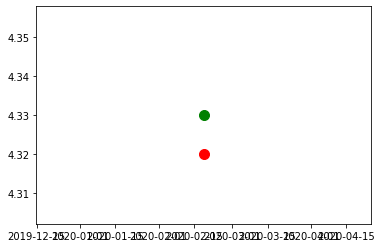

buy time:2020-02-18T19:59:10.963363431Z sell time:2020-02-18T19:59:26.432324311Z
{'rsi': 54.347038010910545, 'macd1': [0.0008110019168876548, 0.0002643681695744249, 0.00023194152231020837, 0.0006027532200691965, 0.0008864062229276826], 'macd2': [0.001019939390537239, 0.0009128128556925574, 0.0008927611131497315, 0.0009528530347626685, 0.0010066155695458434], 'macd_signal': [0.0005542239360976677, 0.0004962527827930191, 0.00044339053069645694, 0.00047526306857100485, 0.0005574916994423404]}
{'rsi': 49.79815848566282, 'macd': [0.00048323678116357627, 0.0001265041971416636, 0.00010662810313544213, 0.0003494957168568291, 0.00027446404291442406], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.00031386769653250475, 0.00027639499665433654, 0.00024244161795055767, 0.000263852437731812, 0.0002659747587683344], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_

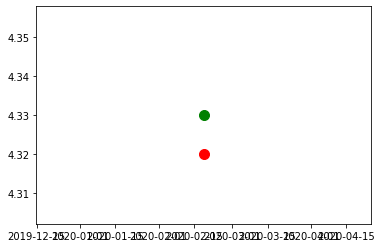

buy time:2020-02-18T19:59:28.058788399Z sell time:2020-02-18T19:59:30.015508842Z
{'rsi': 54.347038010910545, 'macd1': [0.0008110019168876548, 0.0002643681695744249, 0.00023194152231020837, 0.0006027532200691965, 0.0008864062229276826], 'macd2': [0.001019939390537239, 0.0009128128556925574, 0.0008927611131497315, 0.0009528530347626685, 0.0010066155695458434], 'macd_signal': [0.0005542239360976677, 0.0004962527827930191, 0.00044339053069645694, 0.00047526306857100485, 0.0005574916994423404]}
{'rsi': 49.79815848566282, 'macd': [0.00048323678116357627, 0.0001265041971416636, 0.00010662810313544213, 0.0003494957168568291, 0.00027446404291442406], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.00031386769653250475, 0.00027639499665433654, 0.00024244161795055767, 0.000263852437731812, 0.0002659747587683344], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_

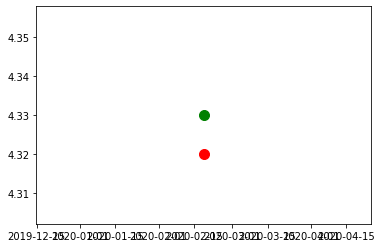

buy time:2020-02-18T19:59:34.478539598Z sell time:2020-02-18T19:59:41.446788096Z
{'rsi': 54.347038010910545, 'macd1': [0.0008110019168876548, 0.0002643681695744249, 0.00023194152231020837, 0.0006027532200691965, 0.0008864062229276826], 'macd2': [0.001019939390537239, 0.0009128128556925574, 0.0008927611131497315, 0.0009528530347626685, 0.0010066155695458434], 'macd_signal': [0.0005542239360976677, 0.0004962527827930191, 0.00044339053069645694, 0.00047526306857100485, 0.0005574916994423404]}
{'rsi': 49.79815848566282, 'macd': [0.00048323678116357627, 0.0001265041971416636, 0.00010662810313544213, 0.0003494957168568291, 0.00027446404291442406], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.00031386769653250475, 0.00027639499665433654, 0.00024244161795055767, 0.000263852437731812, 0.0002659747587683344], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_

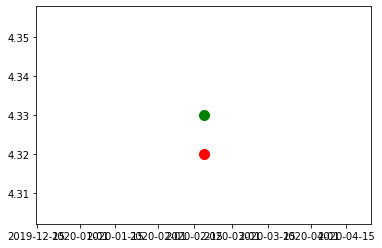

buy time:2020-02-18T20:04:10.215706506Z sell time:2020-02-18T20:04:23.380749768Z
{'rsi': 55.00414354558703, 'macd1': [0.00039172754145511135, 0.0003121921058886201, 0.00024632027339777096, 0.00044717487445566917, 0.0007430333240083797], 'macd2': [0.0009010556354676069, 0.0008760691367006856, 0.0008516796084281353, 0.0008790578479365152, 0.0009316292584591324], 'macd_signal': [0.00046052120402724993, 0.000430855384399524, 0.0003939483621991734, 0.00040459366465047254, 0.000472281596522054]}
{'rsi': 49.58338044614152, 'macd': [0.00021243333538834008, 0.00016133884464863968, 0.00011942964609001905, 0.00025145585960206773, 0.000184834001824008], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0002552664740923355, 0.00023648094820359636, 0.0002130706877808809, 0.00022074772214511826, 0.0002135649780808962], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_

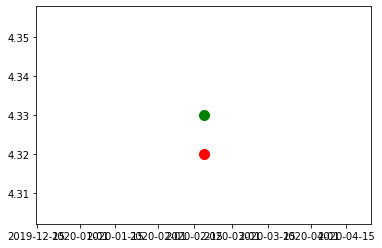

buy time:2020-02-18T20:04:36.101414844Z sell time:2020-02-18T20:04:50.036819217Z
{'rsi': 55.00414354558703, 'macd1': [0.00039172754145511135, 0.0003121921058886201, 0.00024632027339777096, 0.00044717487445566917, 0.0007430333240083797], 'macd2': [0.0009010556354676069, 0.0008760691367006856, 0.0008516796084281353, 0.0008790578479365152, 0.0009316292584591324], 'macd_signal': [0.00046052120402724993, 0.000430855384399524, 0.0003939483621991734, 0.00040459366465047254, 0.000472281596522054]}
{'rsi': 49.58338044614152, 'macd': [0.00021243333538834008, 0.00016133884464863968, 0.00011942964609001905, 0.00025145585960206773, 0.000184834001824008], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.0002552664740923355, 0.00023648094820359636, 0.0002130706877808809, 0.00022074772214511826, 0.0002135649780808962], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_

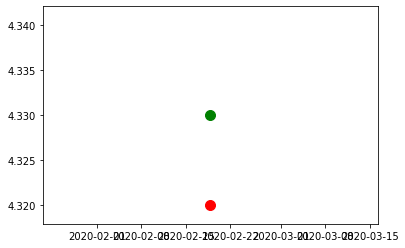

buy time:2020-02-18T20:04:58.942766201Z sell time:2020-02-18T20:05:04.394742067Z
{'rsi': 55.00414354558703, 'macd1': [0.00039172754145511135, 0.0003121921058886201, 0.00024632027339777096, 0.00044717487445566917, 0.0007430333240083797], 'macd2': [0.0009010556354676069, 0.0008760691367006856, 0.0008516796084281353, 0.0008790578479365152, 0.0009316292584591324], 'macd_signal': [0.00046052120402724993, 0.000430855384399524, 0.0003939483621991734, 0.00040459366465047254, 0.000472281596522054]}
{'rsi': 49.241511316298556, 'macd': [0.00016133884464863968, 0.00011942964609001905, 0.00025145585960206773, 0.00044457426156441215, 0.00032954218177394523], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011547344110854256, 'too_close': 1, 'macd_signal': [0.00023648094820359636, 0.0002130706877808809, 0.00022074772214511826, 0.000265513030028977, 0.00027831886037797064], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_sign

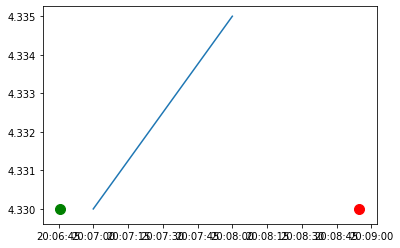

buy time:2020-02-18T20:06:45.673918884Z sell time:2020-02-18T20:08:54.783586112Z
{'rsi': 55.00414354558703, 'macd1': [0.00024632027339777096, 0.00044717487445566917, 0.0007430333240083797, 0.0009663636383416829, 0.0011303248403029542], 'macd2': [0.0008516796084281353, 0.0008790578479365152, 0.0009316292584591324, 0.0009785066269438758, 0.001020070320816302], 'macd_signal': [0.0003939483621991734, 0.00040459366465047254, 0.000472281596522054, 0.0005710980048859798, 0.0006829433719693747]}
{'rsi': 55.00414354558703, 'macd': [0.00025145585960206773, 0.00044457426156441215, 0.0005892824415152376, 0.0006943890435353595, 0.000767272252335971], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.00022074772214511826, 0.000265513030028977, 0.0003302669123262291, 0.00040309133856805516, 0.0004759275213216383], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000291344731014

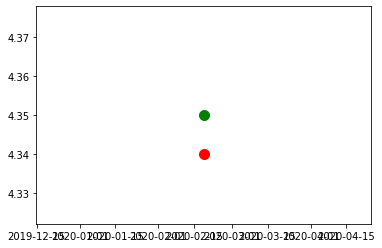

buy time:2020-02-18T20:17:04.580310869Z sell time:2020-02-18T20:17:10.502168364Z
{'rsi': 69.61299646382528, 'macd1': [0.003823466984445467, 0.004759044851340377, 0.0050389529253882515, 0.005599690556902459, 0.00597520077467717], 'macd2': [0.0018304705758218631, 0.002106529393916645, 0.002277175224728367, 0.002510500836802265, 0.002721152668084592], 'macd_signal': [0.002320424510100982, 0.002808148578348861, 0.003254309447756739, 0.0037233856695858833, 0.00417374869060414]}
{'rsi': 61.91010265495749, 'macd': [0.0024067059696966098, 0.003003267854825964, 0.00316937753343538, 0.0035173931591909735, 0.0034831534758934524], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011494252873562975, 'too_close': 1, 'macd_signal': [0.0014501257028938564, 0.0017607541332802779, 0.0020424788133112984, 0.0023374616824872333, 0.002566600041168477], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00091655343472497

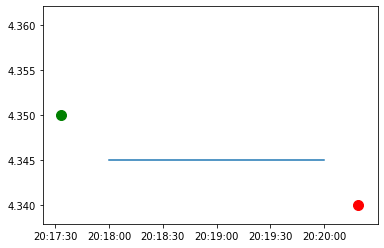

buy time:2020-02-18T20:17:33.445312113Z sell time:2020-02-18T20:20:18.851574619Z
{'rsi': 69.61299646382528, 'macd1': [0.003823466984445467, 0.004759044851340377, 0.0050389529253882515, 0.005599690556902459, 0.00597520077467717], 'macd2': [0.0018304705758218631, 0.002106529393916645, 0.002277175224728367, 0.002510500836802265, 0.002721152668084592], 'macd_signal': [0.002320424510100982, 0.002808148578348861, 0.003254309447756739, 0.0037233856695858833, 0.00417374869060414]}
{'rsi': 54.39284542989661, 'macd': [0.0035173931591909735, 0.0034831534758934524, 0.0034112374437675896, 0.0033108971921915753, 0.0029299710585979355], 'scalp': 0, 'bail_out': 0, 'movement': -0.002298850574712595, 'too_close': 1, 'macd_signal': [0.0023374616824872333, 0.002566600041168477, 0.0027355275216882995, 0.0028506014557889547, 0.0028664753763507507], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 6.349568224718475

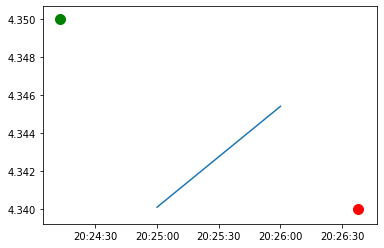

buy time:2020-02-18T20:24:12.72509708Z sell time:2020-02-18T20:26:37.923657609Z
{'rsi': 67.51705736331348, 'macd1': [0.005207294859049583, 0.0050222309891445605, 0.004820004527091193, 0.005005496563635248, 0.005093782386413892], 'macd2': [0.0029490824837283824, 0.003026769805940077, 0.003093403732044031, 0.003229729621303079, 0.0033499882989120877], 'macd_signal': [0.004699712534326441, 0.004764216225290064, 0.00477537388565029, 0.004821398421247282, 0.004875875214280604]}
{'rsi': 53.284507704261294, 'macd': [0.002908334148249203, 0.0030169102268038372, 0.003062334311043635, 0.0025436734116066617, 0.002220773056050618], 'scalp': 0, 'bail_out': 0, 'movement': -0.001770114942528694, 'too_close': 1, 'macd_signal': [0.0029380747749556796, 0.002953841865325311, 0.002975540354468976, 0.0028891669658965132, 0.0027554881839273342], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00053471512787671

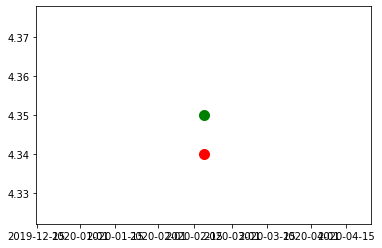

buy time:2020-02-18T20:28:12.769815435Z sell time:2020-02-18T20:28:17.071612098Z
{'rsi': 61.3509909014014, 'macd1': [0.005093782386413892, 0.00431515979871655, 0.004078744269339296, 0.004213988578011474, 0.004271926556850936], 'macd2': [0.0033499882989120877, 0.0032969356255749815, 0.0033276185748540854, 0.0034240963805283187, 0.0035073826841411915], 'macd_signal': [0.004875875214280604, 0.004763732131167793, 0.0046267345588020935, 0.00454418536264397, 0.0044897336014853625]}
{'rsi': 54.56694211680444, 'macd': [0.003062334311043635, 0.0025436734116066617, 0.002381812017089757, 0.0024637146704904467, 0.0022357983657315117], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011494252873562975, 'too_close': 1, 'macd_signal': [0.002975540354468976, 0.0028891669658965132, 0.002787695976135162, 0.002722899715006219, 0.002625479445151278], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000389681079419

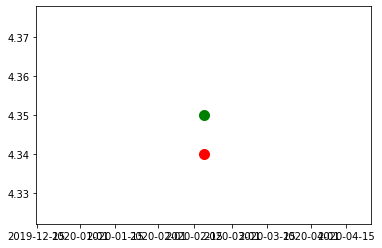

buy time:2020-02-18T20:28:32.749342918Z sell time:2020-02-18T20:28:38.938881294Z
{'rsi': 61.3509909014014, 'macd1': [0.005093782386413892, 0.00431515979871655, 0.004078744269339296, 0.004213988578011474, 0.004271926556850936], 'macd2': [0.0033499882989120877, 0.0032969356255749815, 0.0033276185748540854, 0.0034240963805283187, 0.0035073826841411915], 'macd_signal': [0.004875875214280604, 0.004763732131167793, 0.0046267345588020935, 0.00454418536264397, 0.0044897336014853625]}
{'rsi': 59.145024879219186, 'macd': [0.003062334311043635, 0.0025436734116066617, 0.002381812017089757, 0.0024637146704904467, 0.0024176165475502387], 'scalp': 0, 'bail_out': 0, 'movement': -0.00034482758620690964, 'too_close': 0, 'macd_signal': [0.002975540354468976, 0.0028891669658965132, 0.002787695976135162, 0.002722899715006219, 0.002661843081515023], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0002442265339

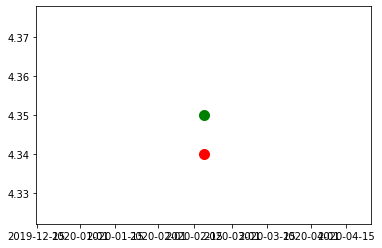

buy time:2020-02-18T20:28:52.278280228Z sell time:2020-02-18T20:28:57.866094537Z
{'rsi': 61.3509909014014, 'macd1': [0.005093782386413892, 0.00431515979871655, 0.004078744269339296, 0.004213988578011474, 0.004271926556850936], 'macd2': [0.0033499882989120877, 0.0032969356255749815, 0.0033276185748540854, 0.0034240963805283187, 0.0035073826841411915], 'macd_signal': [0.004875875214280604, 0.004763732131167793, 0.0046267345588020935, 0.00454418536264397, 0.0044897336014853625]}
{'rsi': 49.13383751962972, 'macd': [0.003062334311043635, 0.0025436734116066617, 0.002381812017089757, 0.0024637146704904467, 0.0019760581059911075], 'scalp': 0, 'bail_out': 0, 'movement': -0.002298850574712595, 'too_close': 1, 'macd_signal': [0.002975540354468976, 0.0028891669658965132, 0.002787695976135162, 0.002722899715006219, 0.002573531393203197], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0005974732872120

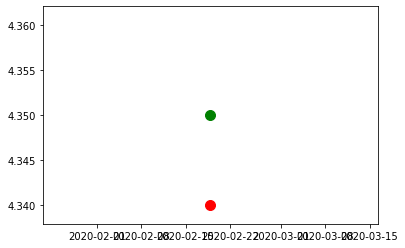

buy time:2020-02-18T20:35:58.609695282Z sell time:2020-02-18T20:36:57.558062168Z
{'rsi': 62.24687429336457, 'macd1': [0.002845173069411011, 0.002656844139501402, 0.0020801551586382416, 0.0024023486333621946, 0.0030262626248598323], 'macd2': [0.0033431230328320183, 0.0033314978769629633, 0.003235506083615114, 0.0033019518489778577, 0.003437771080767149], 'macd_signal': [0.0036896536319034156, 0.003483091733423013, 0.003202504418466059, 0.003042473261445286, 0.0030392311341281954]}
{'rsi': 52.45374508538212, 'macd': [0.0014426701614684845, 0.0010699828935711864, 0.0012851618680205235, 0.00091666286281189, 0.0008773563280675134], 'scalp': 0, 'bail_out': 0, 'movement': -0.002296211251435287, 'too_close': 0, 'macd_signal': [0.001996893450737443, 0.0018115113393041918, 0.0017062414450474581, 0.0015483257286003445, 0.0014141318484937782], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000536775

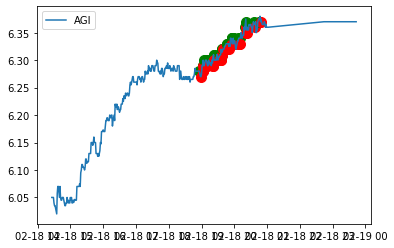

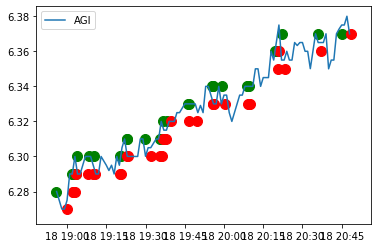

Delta = -0.2799999999999976


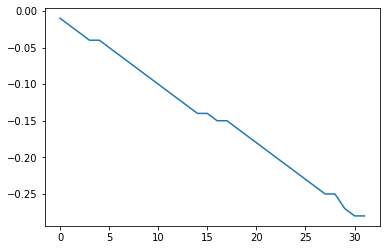

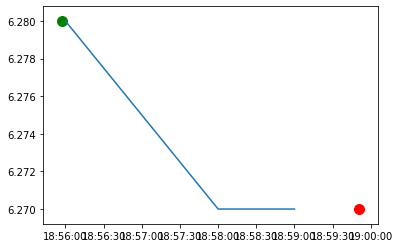

buy time:2020-02-18T18:55:57.250759205Z sell time:2020-02-18T18:59:50.425131976Z
{'rsi': 60.83848615191104, 'macd1': [0.0008474681441219545, 0.001401769364714589, 0.001820076368145962, 0.002127068164359258, 0.0025587333247614197], 'macd2': [-7.066498179320035e-05, 5.212864119119587e-05, 0.0001650193296844904, 0.0002686184487989962, 0.0004066860614679868], 'macd_signal': [-0.0015532215975850492, -0.0009622234051251215, -0.0004057634504709048, 0.00010080287249512789, 0.0005923889629483863]}
{'rsi': 45.093360776349996, 'macd': [0.0016750320657905604, 0.0017475676412486152, 0.0015216529254855615, 0.0010661134985854304, 0.000697302081539064], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015923566878981966, 'too_close': 1, 'macd_signal': [0.0005499827428861872, 0.0007894997225586729, 0.0009359303631440506, 0.0009619669902323266, 0.000909034008493674], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 

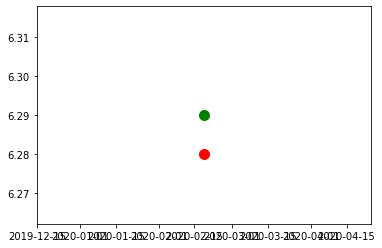

buy time:2020-02-18T19:02:03.824263866Z sell time:2020-02-18T19:02:08.072536287Z
{'rsi': 65.14774477303818, 'macd1': [0.0015000698187339623, 0.0009575209081011948, 0.0009203954549485971, 0.002077400920940775, 0.00296021260032564], 'macd2': [0.0003677913723834081, 0.0002922012925061779, 0.00030215667876465346, 0.0005507367335697566, 0.0007785575089283014], 'macd_signal': [0.0012468002692875215, 0.0011889443970502561, 0.0011352346086299244, 0.0013236678710920944, 0.0016509768169388037]}
{'rsi': 59.21859285956236, 'macd': [0.0010661134985854304, 0.000697302081539064, 0.0006606009503151711, 0.0014026442123444838, 0.001702903322855498], 'scalp': 0, 'bail_out': 0, 'movement': -0.000794912559618425, 'too_close': 0, 'macd_signal': [0.0009619669902323266, 0.000909034008493674, 0.0008593473968579735, 0.0009680067599552756, 0.00111498607253532], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0005879

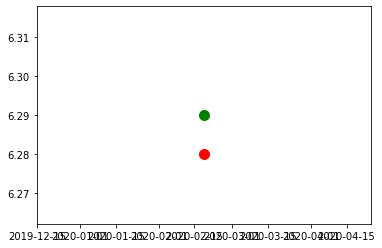

buy time:2020-02-18T19:02:10.59931166Z sell time:2020-02-18T19:02:18.836388188Z
{'rsi': 65.14774477303818, 'macd1': [0.0015000698187339623, 0.0009575209081011948, 0.0009203954549485971, 0.002077400920940775, 0.00296021260032564], 'macd2': [0.0003677913723834081, 0.0002922012925061779, 0.00030215667876465346, 0.0005507367335697566, 0.0007785575089283014], 'macd_signal': [0.0012468002692875215, 0.0011889443970502561, 0.0011352346086299244, 0.0013236678710920944, 0.0016509768169388037]}
{'rsi': 59.21859285956236, 'macd': [0.0010661134985854304, 0.000697302081539064, 0.0006606009503151711, 0.0014026442123444838, 0.001702903322855498], 'scalp': 0, 'bail_out': 0, 'movement': -0.000794912559618425, 'too_close': 0, 'macd_signal': [0.0009619669902323266, 0.000909034008493674, 0.0008593473968579735, 0.0009680067599552756, 0.00111498607253532], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00058791

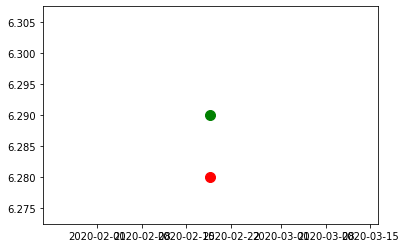

buy time:2020-02-18T19:02:38.083690512Z sell time:2020-02-18T19:03:06.762684633Z
{'rsi': 65.14774477303818, 'macd1': [0.0015000698187339623, 0.0009575209081011948, 0.0009203954549485971, 0.002077400920940775, 0.00296021260032564], 'macd2': [0.0003677913723834081, 0.0002922012925061779, 0.00030215667876465346, 0.0005507367335697566, 0.0007785575089283014], 'macd_signal': [0.0012468002692875215, 0.0011889443970502561, 0.0011352346086299244, 0.0013236678710920944, 0.0016509768169388037]}
{'rsi': 58.8068954901262, 'macd': [0.000697302081539064, 0.0006606009503151711, 0.0014026442123444838, 0.001962643582595902, 0.0021137775908099954], 'scalp': 0, 'bail_out': 0, 'movement': -0.000794912559618425, 'too_close': 1, 'macd_signal': [0.000909034008493674, 0.0008593473968579735, 0.0009680067599552756, 0.001166934124483401, 0.0013563028177487199], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0007574

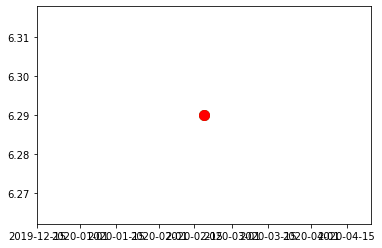

buy time:2020-02-18T19:03:13.606099514Z sell time:2020-02-18T19:03:28.914421829Z
{'rsi': 65.14774477303818, 'macd1': [0.0009575209081011948, 0.0009203954549485971, 0.002077400920940775, 0.00296021260032564, 0.0036181395559653495], 'macd2': [0.0002922012925061779, 0.00030215667876465346, 0.0005507367335697566, 0.0007785575089283014, 0.0009869147156704727], 'macd_signal': [0.0011889443970502561, 0.0011352346086299244, 0.0013236678710920944, 0.0016509768169388037, 0.002044409364744113]}
{'rsi': 65.14774477303818, 'macd': [0.000697302081539064, 0.0006606009503151711, 0.0014026442123444838, 0.001962643582595902, 0.0023735178505503995], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.000909034008493674, 0.0008593473968579735, 0.0009680067599552756, 0.001166934124483401, 0.0014082508696968007], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009652669808535989}


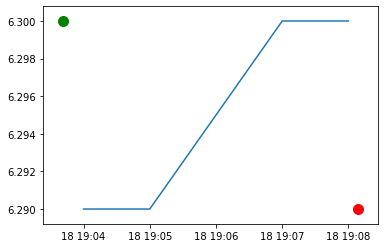

buy time:2020-02-18T19:03:40.969295831Z sell time:2020-02-18T19:08:08.428935838Z
{'rsi': 71.33035055741793, 'macd1': [0.0009575209081011948, 0.0009203954549485971, 0.002077400920940775, 0.00296021260032564, 0.004415860353686796], 'macd2': [0.0002922012925061779, 0.00030215667876465346, 0.0005507367335697566, 0.0007785575089283014, 0.001146850741260863], 'macd_signal': [0.0011889443970502561, 0.0011352346086299244, 0.0013236678710920944, 0.0016509768169388037, 0.002203953524288402]}
{'rsi': 60.879245207578045, 'macd': [0.0030608982255637684, 0.003151977356815827, 0.0034417535973139124, 0.0038825954263081996, 0.003915944962845863], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007936507936507767, 'too_close': 0, 'macd_signal': [0.0018218972239869816, 0.0020879132505527507, 0.002358681319904983, 0.0026634641411856265, 0.002913960305517674], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0010019

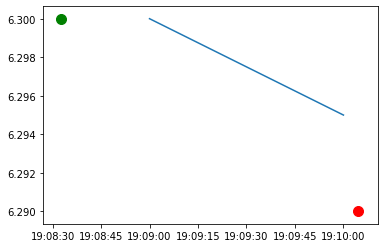

buy time:2020-02-18T19:08:32.722836315Z sell time:2020-02-18T19:10:04.456265312Z
{'rsi': 66.3831567327562, 'macd1': [0.0047082811250813705, 0.004883730092696936, 0.005364395465129235, 0.0060787128313926075, 0.006569090108875741], 'macd2': [0.0013239220425935727, 0.0014847158755380008, 0.0017102447624246508, 0.001994971267693657, 0.002253738082388601], 'macd_signal': [0.002704819044446996, 0.0031406012540969837, 0.003585360096303434, 0.004084030643321268, 0.004581042536432163]}
{'rsi': 60.08337016189385, 'macd': [0.0034417535973139124, 0.0038825954263081996, 0.004175685222585379, 0.004349837203807105, 0.004169308394319948], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007936507936507767, 'too_close': 1, 'macd_signal': [0.002358681319904983, 0.0026634641411856265, 0.002965908357465577, 0.0032426941267338825, 0.0034280169802510954], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00074129141406

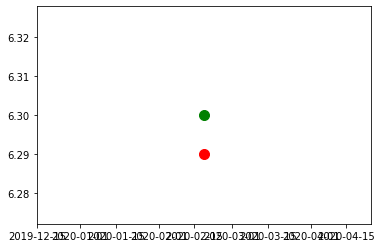

buy time:2020-02-18T19:10:21.594373865Z sell time:2020-02-18T19:10:37.27456009Z
{'rsi': 66.3831567327562, 'macd1': [0.005364395465129235, 0.0060787128313926075, 0.006569090108875741, 0.006878427404808818, 0.007042399048006409], 'macd2': [0.0017102447624246508, 0.001994971267693657, 0.002253738082388601, 0.0024882072900185292, 0.002699946921205232], 'macd_signal': [0.003585360096303434, 0.004084030643321268, 0.004581042536432163, 0.005040519510107494, 0.0054408954176872765]}
{'rsi': 60.08337016189385, 'macd': [0.0034417535973139124, 0.0038825954263081996, 0.004175685222585379, 0.004349837203807105, 0.004169308394319948], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007936507936507767, 'too_close': 1, 'macd_signal': [0.002358681319904983, 0.0026634641411856265, 0.002965908357465577, 0.0032426941267338825, 0.0034280169802510954], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00074129141406885

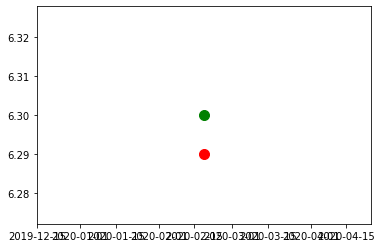

buy time:2020-02-18T19:20:07.616977953Z sell time:2020-02-18T19:20:15.31564392Z
{'rsi': 59.32213364629355, 'macd1': [0.004940282395965667, 0.004736644470026974, 0.004124259833236721, 0.004395191985800295, 0.004557373108340812], 'macd2': [0.002978434178257494, 0.0030441878914917453, 0.0030198466450253036, 0.0031525581225544386, 0.0032696148507849188], 'macd_signal': [0.005384456189744473, 0.005254893845800973, 0.005028767043288122, 0.004902052031790557, 0.0048331162471006075]}
{'rsi': 56.492502634772656, 'macd': [0.0029598774304000486, 0.0028144225073054585, 0.002404789807396668, 0.0025738449788006434, 0.0025215003723779716], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004603174603173744, 'too_close': 0, 'macd_signal': [0.0033311367289331107, 0.0032277938846075804, 0.003063193069165398, 0.002965323451092447, 0.002876558835349552], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000355058462

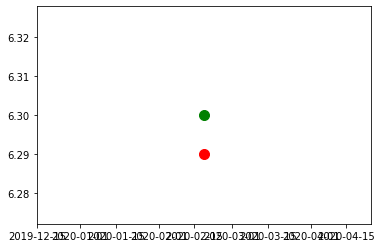

buy time:2020-02-18T19:20:30.650080927Z sell time:2020-02-18T19:20:48.547164844Z
{'rsi': 59.32213364629355, 'macd1': [0.004940282395965667, 0.004736644470026974, 0.004124259833236721, 0.004395191985800295, 0.004557373108340812], 'macd2': [0.002978434178257494, 0.0030441878914917453, 0.0030198466450253036, 0.0031525581225544386, 0.0032696148507849188], 'macd_signal': [0.005384456189744473, 0.005254893845800973, 0.005028767043288122, 0.004902052031790557, 0.0048331162471006075]}
{'rsi': 56.866641319806114, 'macd': [0.0029598774304000486, 0.0028144225073054585, 0.002404789807396668, 0.0025738449788006434, 0.002542279593156671], 'scalp': 0, 'bail_out': 0, 'movement': -0.0003968253968253179, 'too_close': 0, 'macd_signal': [0.0033311367289331107, 0.0032277938846075804, 0.003063193069165398, 0.002965323451092447, 0.002880714679505292], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000338435086

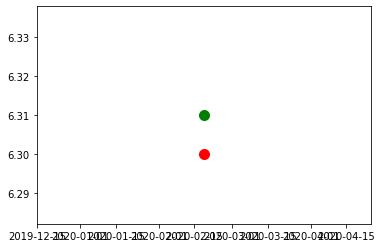

buy time:2020-02-18T19:22:51.520784697Z sell time:2020-02-18T19:22:55.341477563Z
{'rsi': 64.07064000709659, 'macd1': [0.004124259833236721, 0.004395191985800295, 0.004158512709480533, 0.00472341056752601, 0.005511026717647027], 'macd2': [0.0030198466450253036, 0.0031525581225544386, 0.0031896468379901677, 0.0033786042737622424, 0.00362701556629208], 'macd_signal': [0.005028767043288122, 0.004902052031790557, 0.004753344167328552, 0.0047473574473680434, 0.00490009130142384]}
{'rsi': 56.77335886042366, 'macd': [0.002404789807396668, 0.0025738449788006434, 0.002412409463286913, 0.0027747660815453656, 0.002761345705102336], 'scalp': 0, 'bail_out': 0, 'movement': -0.001584786053882692, 'too_close': 0, 'macd_signal': [0.003063193069165398, 0.002965323451092447, 0.0028547406535313403, 0.0028387457391341455, 0.0028232657323277836], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -6.192002722544762e-

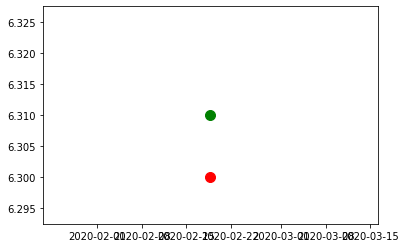

buy time:2020-02-18T19:22:58.581933819Z sell time:2020-02-18T19:23:12.415331126Z
{'rsi': 64.07064000709659, 'macd1': [0.004124259833236721, 0.004395191985800295, 0.004158512709480533, 0.00472341056752601, 0.005511026717647027], 'macd2': [0.0030198466450253036, 0.0031525581225544386, 0.0031896468379901677, 0.0033786042737622424, 0.00362701556629208], 'macd_signal': [0.005028767043288122, 0.004902052031790557, 0.004753344167328552, 0.0047473574473680434, 0.00490009130142384]}
{'rsi': 55.44359033738314, 'macd': [0.0025738449788006434, 0.002412409463286913, 0.0027747660815453656, 0.0032808262245831443, 0.0031182649565009157], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015689381933439018, 'too_close': 1, 'macd_signal': [0.002965323451092447, 0.0028547406535313403, 0.0028387457391341455, 0.0029271618362239453, 0.0029653824602793393], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00015288249622

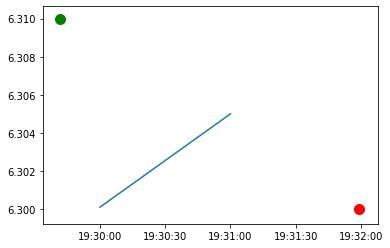

buy time:2020-02-18T19:29:41.651822904Z sell time:2020-02-18T19:31:59.299112135Z
{'rsi': 62.70023340191892, 'macd1': [0.00476784202032654, 0.004513616579274959, 0.004262999876693208, 0.004815787361829749, 0.005194002202186354], 'macd2': [0.0037848086005762838, 0.0038170557283434547, 0.003840619270158996, 0.004016091974131442, 0.004171109296779996], 'macd_signal': [0.004941362633157915, 0.004855813422381324, 0.0047372507132437, 0.00475295804296091, 0.0048411668748059985]}
{'rsi': 56.43221440549723, 'macd': [0.0024362006862510555, 0.002794185936779492, 0.003036847353596883, 0.0026722088815889222, 0.002607916450393155], 'scalp': 0, 'bail_out': 0, 'movement': -0.000792393026941346, 'too_close': 1, 'macd_signal': [0.002774963968608481, 0.002778808362242683, 0.002830416160513523, 0.002798774704728603, 0.0027606030538615137], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00015268660346835859}


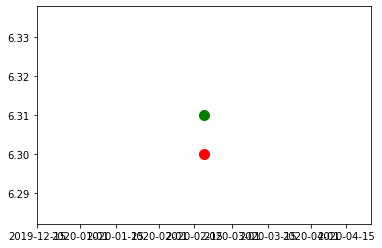

buy time:2020-02-18T19:35:32.788799286Z sell time:2020-02-18T19:35:40.068239239Z
{'rsi': 60.12033923500175, 'macd1': [0.004641389872526602, 0.004546421353590624, 0.004420204749255419, 0.004661827583474221, 0.004805984190528356], 'macd2': [0.004148722420421969, 0.004199859128865668, 0.004240189448583287, 0.004348881694835605, 0.004443525969864304], 'macd_signal': [0.00480121147435012, 0.00475025345019822, 0.00468424371000966, 0.004679760484702572, 0.004705005225867729]}
{'rsi': 55.121585058324705, 'macd': [0.0026722088815889222, 0.002607916450393155, 0.002523949407248871, 0.002680287433276085, 0.0025127548894889884], 'scalp': 0, 'bail_out': 0, 'movement': -0.000792393026941346, 'too_close': 1, 'macd_signal': [0.002798774704728603, 0.0027606030538615137, 0.002713272324538985, 0.0027066753462864053, 0.002667891254926922], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00015513636543793355}


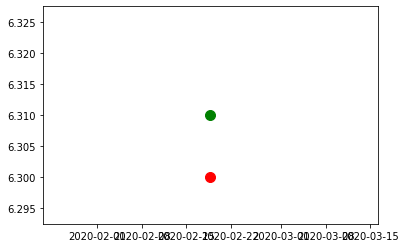

buy time:2020-02-18T19:35:55.226798716Z sell time:2020-02-18T19:36:09.412235716Z
{'rsi': 60.12033923500175, 'macd1': [0.004641389872526602, 0.004546421353590624, 0.004420204749255419, 0.004661827583474221, 0.004805984190528356], 'macd2': [0.004148722420421969, 0.004199859128865668, 0.004240189448583287, 0.004348881694835605, 0.004443525969864304], 'macd_signal': [0.00480121147435012, 0.00475025345019822, 0.00468424371000966, 0.004679760484702572, 0.004705005225867729]}
{'rsi': 57.418645945774614, 'macd': [0.002607916450393155, 0.002523949407248871, 0.002680287433276085, 0.0027724951492285044, 0.002683663562319083], 'scalp': 0, 'bail_out': 0, 'movement': -0.0003803486529318123, 'too_close': 1, 'macd_signal': [0.0027606030538615137, 0.002713272324538985, 0.0027066753462864053, 0.002719839306874825, 0.0027126041579636764], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -2.8940595644593413e-05}

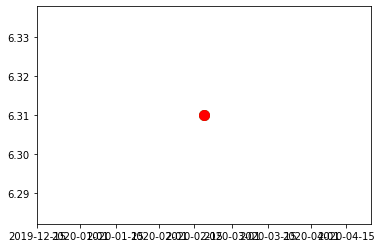

buy time:2020-02-18T19:36:42.557938189Z sell time:2020-02-18T19:36:45.44509642Z
{'rsi': 60.120339235001744, 'macd1': [0.004546421353590624, 0.004420204749255419, 0.004661827583474221, 0.004805984190528356, 0.004864158350580183], 'macd2': [0.004199859128865668, 0.004240189448583287, 0.004348881694835605, 0.004443525969864304, 0.004523494931464533], 'macd_signal': [0.00475025345019822, 0.00468424371000966, 0.004679760484702572, 0.004705005225867729, 0.00473683585081022]}
{'rsi': 60.120339235001744, 'macd': [0.002607916450393155, 0.002523949407248871, 0.002680287433276085, 0.0027724951492285044, 0.002808338886993944], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0027606030538615137, 0.002713272324538985, 0.0027066753462864053, 0.002719839306874825, 0.002737539222898649], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 7.079966409529511e-05}


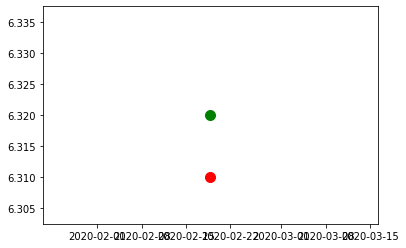

buy time:2020-02-18T19:36:46.573365747Z sell time:2020-02-18T19:37:51.948347531Z
{'rsi': 66.65725900177073, 'macd1': [0.004546421353590624, 0.004420204749255419, 0.004661827583474221, 0.004805984190528356, 0.005661879148299853], 'macd2': [0.004199859128865668, 0.004240189448583287, 0.004348881694835605, 0.004443525969864304, 0.0046834309570540356], 'macd_signal': [0.00475025345019822, 0.00468424371000966, 0.004679760484702572, 0.004705005225867729, 0.004896380010354154]}
{'rsi': 61.25108324536538, 'macd': [0.002523949407248871, 0.002680287433276085, 0.0027724951492285044, 0.003327819406473864, 0.0034575809133343682], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007911392405063122, 'too_close': 0, 'macd_signal': [0.002713272324538985, 0.0027066753462864053, 0.002719839306874825, 0.002841435326794633, 0.00296466444410258], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0004929164692317883}


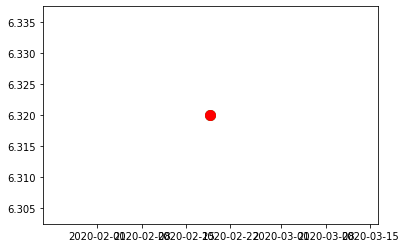

buy time:2020-02-18T19:38:02.853017825Z sell time:2020-02-18T19:39:43.303062941Z
{'rsi': 64.36366274806848, 'macd1': [0.004661827583474221, 0.004805984190528356, 0.005661879148299853, 0.005869068882756068, 0.006363373445275933], 'macd2': [0.004348881694835605, 0.004443525969864304, 0.0046834309570540356, 0.00481669271302998, 0.0050115621771036345], 'macd_signal': [0.004679760484702572, 0.004705005225867729, 0.004896380010354154, 0.005090917784834536, 0.005345408916922816]}
{'rsi': 64.58250710386675, 'macd': [0.0027724951492285044, 0.003327819406473864, 0.0034575809133343682, 0.0035137901275987815, 0.003771696137056857], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.002719839306874825, 0.002841435326794633, 0.00296466444410258, 0.0030744895808018204, 0.0032139308920528277], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0005577652450040292}


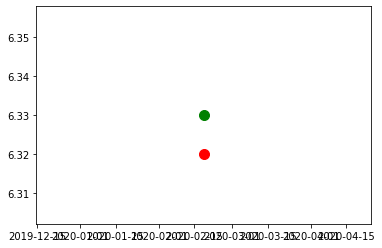

buy time:2020-02-18T19:46:20.908344145Z sell time:2020-02-18T19:46:29.739579187Z
{'rsi': 71.25007256739275, 'macd1': [0.006732162332332869, 0.0071457712088260905, 0.00738839045726003, 0.007893138980024972, 0.008198646922589425], 'macd2': [0.0053993482837775275, 0.005594477003121767, 0.005765054082369048, 0.005992738065983438, 0.006192630066795601], 'macd_signal': [0.0059162880523060905, 0.006162184683610091, 0.006407425838340078, 0.006704568466677057, 0.007003384157859531]}
{'rsi': 64.2548247216502, 'macd': [0.0039911499673799256, 0.004251632052516996, 0.004399389105188334, 0.004717129807202625, 0.004643718278808606], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007898894154818157, 'too_close': 1, 'macd_signal': [0.003482934371109343, 0.0036366739073908734, 0.0037892169469503655, 0.003974799519000817, 0.004108583270962375], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0005351350078462314}

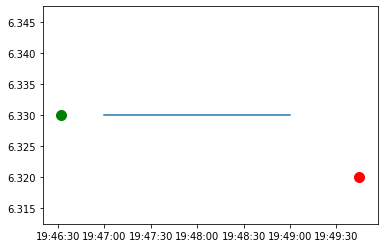

buy time:2020-02-18T19:46:31.981928506Z sell time:2020-02-18T19:49:44.348428772Z
{'rsi': 71.25007256739275, 'macd1': [0.006732162332332869, 0.0071457712088260905, 0.00738839045726003, 0.007893138980024972, 0.008198646922589425], 'macd2': [0.0053993482837775275, 0.005594477003121767, 0.005765054082369048, 0.005992738065983438, 0.006192630066795601], 'macd_signal': [0.0059162880523060905, 0.006162184683610091, 0.006407425838340078, 0.006704568466677057, 0.007003384157859531]}
{'rsi': 62.72164693534804, 'macd': [0.004717129807202625, 0.00490345853854901, 0.004984968478058072, 0.00498374286627179, 0.004658323651033136], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007898894154818157, 'too_close': 1, 'macd_signal': [0.003974799519000817, 0.004160531322910456, 0.004325418753939979, 0.004457083576406342, 0.004497331591331701], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0001609920597014352}


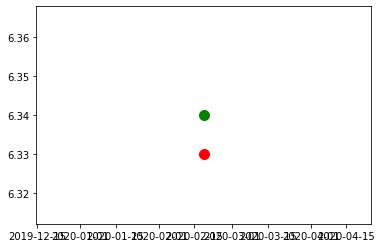

buy time:2020-02-18T19:55:32.007066556Z sell time:2020-02-18T19:55:36.533479556Z
{'rsi': 70.81032858937888, 'macd1': [0.007530724387843968, 0.0069637209507531495, 0.00763671004191302, 0.008076952662714021, 0.008329827050376437], 'macd2': [0.00675021504595108, 0.006746964880500528, 0.006973087835229208, 0.007169975707076226, 0.0073396514728871765], 'macd_signal': [0.007637740870196029, 0.007502936886307453, 0.007529691517428566, 0.007639143746485657, 0.007777280407263813]}
{'rsi': 63.907276482861555, 'macd': [0.004405213870316338, 0.004027436744244994, 0.0044599813636141405, 0.004739107283075583, 0.004635320891967609], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007886435331230116, 'too_close': 1, 'macd_signal': [0.004519505631245402, 0.004421091853845321, 0.004428869755799085, 0.004490917261254385, 0.0045197979873970295], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00011552290457057975}

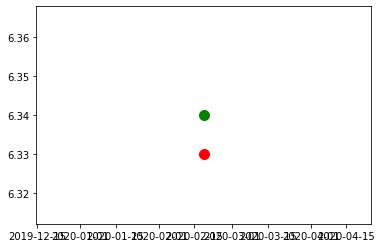

buy time:2020-02-18T19:55:37.763591566Z sell time:2020-02-18T19:55:47.851980798Z
{'rsi': 70.81032858937888, 'macd1': [0.007530724387843968, 0.0069637209507531495, 0.00763671004191302, 0.008076952662714021, 0.008329827050376437], 'macd2': [0.00675021504595108, 0.006746964880500528, 0.006973087835229208, 0.007169975707076226, 0.0073396514728871765], 'macd_signal': [0.007637740870196029, 0.007502936886307453, 0.007529691517428566, 0.007639143746485657, 0.007777280407263813]}
{'rsi': 63.907276482861555, 'macd': [0.004405213870316338, 0.004027436744244994, 0.0044599813636141405, 0.004739107283075583, 0.004635320891967609], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007886435331230116, 'too_close': 1, 'macd_signal': [0.004519505631245402, 0.004421091853845321, 0.004428869755799085, 0.004490917261254385, 0.0045197979873970295], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00011552290457057975}

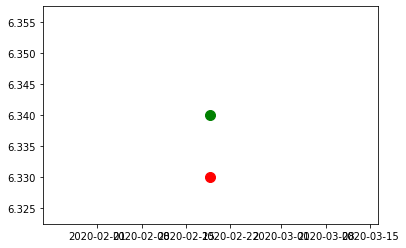

buy time:2020-02-18T19:55:57.495187072Z sell time:2020-02-18T19:56:00.433512811Z
{'rsi': 70.81032858937888, 'macd1': [0.007530724387843968, 0.0069637209507531495, 0.00763671004191302, 0.008076952662714021, 0.008329827050376437], 'macd2': [0.00675021504595108, 0.006746964880500528, 0.006973087835229208, 0.007169975707076226, 0.0073396514728871765], 'macd_signal': [0.007637740870196029, 0.007502936886307453, 0.007529691517428566, 0.007639143746485657, 0.007777280407263813]}
{'rsi': 63.907276482861555, 'macd': [0.004405213870316338, 0.004027436744244994, 0.0044599813636141405, 0.004739107283075583, 0.004635320891967609], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007886435331230116, 'too_close': 1, 'macd_signal': [0.004519505631245402, 0.004421091853845321, 0.004428869755799085, 0.004490917261254385, 0.0045197979873970295], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00011552290457057975}

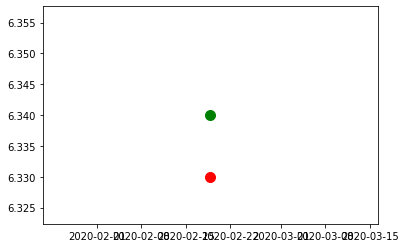

buy time:2020-02-18T19:59:15.75988238Z sell time:2020-02-18T20:00:31.430542826Z
{'rsi': 65.44961132075063, 'macd1': [0.00793096665151527, 0.007327348361813257, 0.006770925503934322, 0.007055540922929815, 0.007198125186554272], 'macd2': [0.007259683460091537, 0.0072506386003752255, 0.0072307206569091065, 0.007360767010149871, 0.0074686412967421845], 'macd_signal': [0.0076975083274915795, 0.007623476334355915, 0.007452966168271596, 0.0073734811192032405, 0.007338409932673447]}
{'rsi': 58.437366092439824, 'macd': [0.004234509147051924, 0.003867194681570929, 0.004050232829487577, 0.0036207790118973904, 0.0034988568292044775], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007886435331230116, 'too_close': 0, 'macd_signal': [0.004462740219328009, 0.004343631111776593, 0.00428495145531879, 0.00415211696663451, 0.0040214649391485035], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000522608109944026

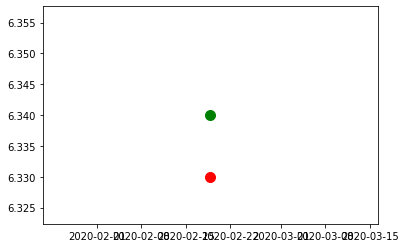

buy time:2020-02-18T20:08:59.011097669Z sell time:2020-02-18T20:09:07.184885893Z
{'rsi': 60.587658284454115, 'macd1': [0.0030552137361494758, 0.0029207808445779193, 0.0031810310765996164, 0.0033486797646329336, 0.0038407272579394913], 'macd2': [0.006772409740872121, 0.00669887363747268, 0.006700472170671823, 0.0066912264034613145, 0.006751986333103588], 'macd_signal': [0.00531169282688342, 0.00483351043042232, 0.00450301455965778, 0.004272147600652811, 0.004185863532110147]}
{'rsi': 55.68673572131091, 'macd': [0.0013918996619954882, 0.0015767816934717516, 0.0017003679297715735, 0.00203432645247581, 0.00200839378896589], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007886435331230116, 'too_close': 0, 'macd_signal': [0.0026196543008189304, 0.0024110797793494947, 0.0022689374094339103, 0.0022220152180422903, 0.0021792909322270104], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00017089714326

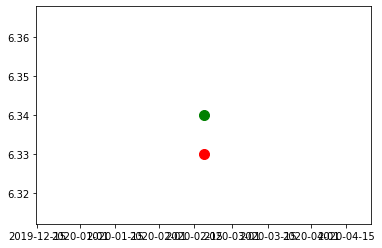

buy time:2020-02-18T20:09:13.697701589Z sell time:2020-02-18T20:09:25.509690349Z
{'rsi': 60.587658284454115, 'macd1': [0.0029207808445779193, 0.0031810310765996164, 0.0033486797646329336, 0.0038407272579394913, 0.004182465581664907], 'macd2': [0.00669887363747268, 0.006700472170671823, 0.0066912264034613145, 0.006751986333103588, 0.006797088553325281], 'macd_signal': [0.00483351043042232, 0.00450301455965778, 0.004272147600652811, 0.004185863532110147, 0.0041851839420210995]}
{'rsi': 55.68673572131091, 'macd': [0.0013918996619954882, 0.0015767816934717516, 0.0017003679297715735, 0.00203432645247581, 0.00200839378896589], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007886435331230116, 'too_close': 0, 'macd_signal': [0.0026196543008189304, 0.0024110797793494947, 0.0022689374094339103, 0.0022220152180422903, 0.0021792909322270104], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0001708971432

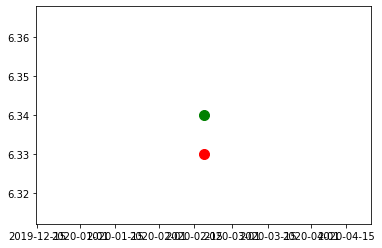

buy time:2020-02-18T20:09:38.821428248Z sell time:2020-02-18T20:09:45.874988027Z
{'rsi': 60.587658284454115, 'macd1': [0.0029207808445779193, 0.0031810310765996164, 0.0033486797646329336, 0.0038407272579394913, 0.004182465581664907], 'macd2': [0.00669887363747268, 0.006700472170671823, 0.0066912264034613145, 0.006751986333103588, 0.006797088553325281], 'macd_signal': [0.00483351043042232, 0.00450301455965778, 0.004272147600652811, 0.004185863532110147, 0.0041851839420210995]}
{'rsi': 55.68673572131091, 'macd': [0.0013918996619954882, 0.0015767816934717516, 0.0017003679297715735, 0.00203432645247581, 0.00200839378896589], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007886435331230116, 'too_close': 0, 'macd_signal': [0.0026196543008189304, 0.0024110797793494947, 0.0022689374094339103, 0.0022220152180422903, 0.0021792909322270104], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0001708971432

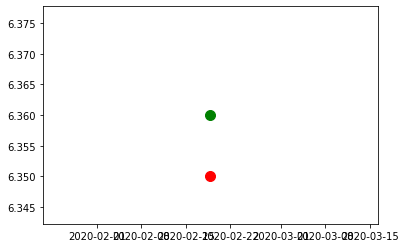

buy time:2020-02-18T20:19:27.441443941Z sell time:2020-02-18T20:20:36.786879063Z
{'rsi': 69.47630605202804, 'macd1': [0.005592933406944667, 0.005548403376439914, 0.005450285507794028, 0.006507882214607186, 0.00726231972319713], 'macd2': [0.007137998791896472, 0.0071540299333197055, 0.0071573372250748335, 0.007388836916970121, 0.007590006626439383], 'macd_signal': [0.005078954538164366, 0.005172844305819475, 0.005228332546214386, 0.005484242479892946, 0.005839857928553783]}
{'rsi': 63.92521014111111, 'macd': [0.0031864507627874517, 0.0031228164522083546, 0.003811895996533643, 0.004039595693454245, 0.004164561746984319], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007861635220125619, 'too_close': 1, 'macd_signal': [0.0029251857241534727, 0.002964711869764449, 0.003134148695118288, 0.0033152380947854792, 0.003485102825225247], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0006794589217590718

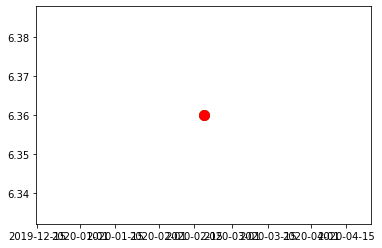

buy time:2020-02-18T20:20:44.315304976Z sell time:2020-02-18T20:20:59.376931751Z
{'rsi': 66.7833442353039, 'macd1': [0.005548403376439914, 0.005450285507794028, 0.006507882214607186, 0.006863459324335963, 0.00746268971715125], 'macd2': [0.0071540299333197055, 0.0071573372250748335, 0.007388836916970121, 0.007510038613644632, 0.007689504807004255], 'macd_signal': [0.005172844305819475, 0.005228332546214386, 0.005484242479892946, 0.005760085848781549, 0.00610060662245549]}
{'rsi': 66.7833442353039, 'macd': [0.0031864507627874517, 0.0031228164522083546, 0.003811895996533643, 0.004039595693454245, 0.004424302006725611], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0029251857241534727, 0.002964711869764449, 0.003134148695118288, 0.0033152380947854792, 0.0035370508771735056], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0008872511295521055}


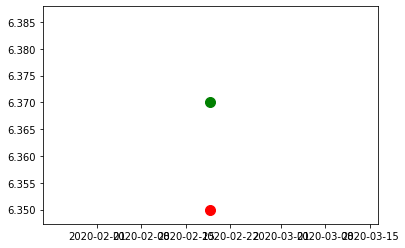

buy time:2020-02-18T20:22:16.636164165Z sell time:2020-02-18T20:23:12.466689634Z
{'rsi': 68.39578552013548, 'macd1': [0.006507882214607186, 0.006863459324335963, 0.007861550116012417, 0.009351660564009379, 0.010013693985500005], 'macd2': [0.007388836916970121, 0.007510038613644632, 0.007769472819799894, 0.008155670427589357, 0.008417972712201127], 'macd_signal': [0.005484242479892946, 0.005760085848781549, 0.006180378702227722, 0.006814635074584054, 0.007454446856767244]}
{'rsi': 56.739047766916705, 'macd': [0.004039595693454245, 0.004684042266465127, 0.005644857228986666, 0.005281273339666548, 0.004929373252668512], 'scalp': 0, 'bail_out': 0, 'movement': -0.0023547880690737333, 'too_close': 1, 'macd_signal': [0.0033152380947854792, 0.0035889989291214086, 0.00400017058909446, 0.004256391139208877, 0.004390987561900804], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0005383856907677075}


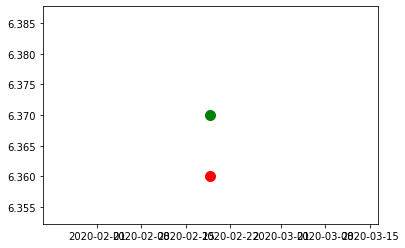

buy time:2020-02-18T20:36:04.416966146Z sell time:2020-02-18T20:37:07.887822698Z
{'rsi': 60.93825182080099, 'macd1': [0.006430639750988121, 0.005191511857984388, 0.004951266222633421, 0.0055043356966733015, 0.005874924763836553], 'macd2': [0.008401138295896615, 0.00817912458191472, 0.008120120162002031, 0.008212783236426269, 0.008284901029830039], 'macd_signal': [0.007159553561618949, 0.006765945220892037, 0.006403009421240314, 0.006223274676326911, 0.00615360469382884]}
{'rsi': 56.96770392465669, 'macd': [0.0028427255316527678, 0.0026908723929208733, 0.0030570793965987164, 0.0030429929137945066, 0.0029924970451959965], 'scalp': 0, 'bail_out': 0, 'movement': -0.000784929356357911, 'too_close': 0, 'macd_signal': [0.003887082326750703, 0.003647840339984737, 0.003529688151307533, 0.0034323491038049277, 0.0033443786920831415], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000351881646887145

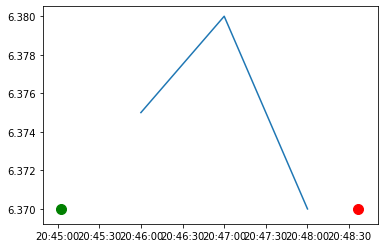

buy time:2020-02-18T20:45:02.279840666Z sell time:2020-02-18T20:48:36.604952957Z
{'rsi': 57.897122403921784, 'macd1': [0.004031623276659957, 0.0032320227740259, 0.0025687229753916796, 0.0032163516462579977, 0.003687099446551656], 'macd2': [0.007892124582259186, 0.0076850069716778435, 0.007482161050112346, 0.007523473681170678, 0.007549449878427872], 'macd_signal': [0.005400450603353849, 0.004966765037488259, 0.004487156625068943, 0.004232995629306754, 0.004123816392755735]}
{'rsi': 0, 'macd': [], 'bail_out': 0, 'too_close': 0, 'macd_signal': [], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0}
GNPX analysis for run 66


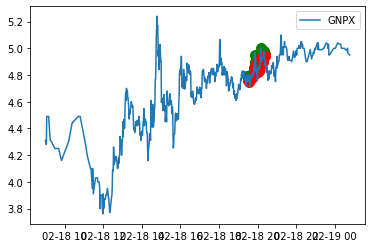

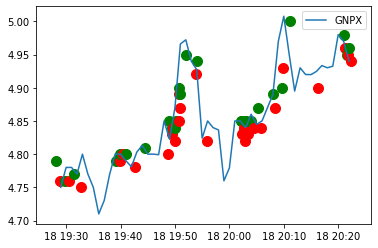

Delta = -0.5499999999999972


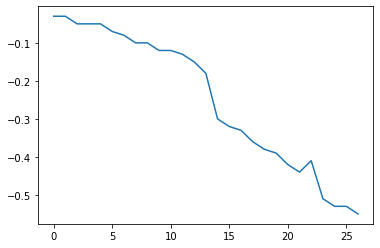

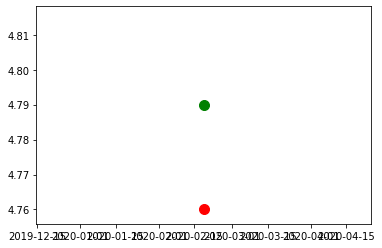

buy time:2020-02-18T19:28:13.011134352Z sell time:2020-02-18T19:28:48.706143614Z
{'rsi': 54.77774216819209, 'macd1': [0.011264455584850452, 0.0062892867600528035, 0.004712852076692364, 0.007412649950677697, 0.008645680764191255], 'macd2': [0.0002951574517116029, -0.000260625320075647, -0.0002917383375100613, 0.0004797834138834389, 0.0010289047318767786], 'macd_signal': [0.019458896269638624, 0.01682497436772146, 0.01440254990951564, 0.013004569917748052, 0.012132792087036692]}
{'rsi': 50.138618228760365, 'macd': [0.006597259560245483, 0.0033137140246726204, 0.0022705134252039016, 0.0040255452512649725, 0.0032940694631138356], 'scalp': 0, 'bail_out': 0, 'movement': -0.006137787056367405, 'too_close': 0, 'macd_signal': [0.012426351559742234, 0.01060382405272831, 0.008937161927223429, 0.007954838592031738, 0.007022684766248158], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003728615303134

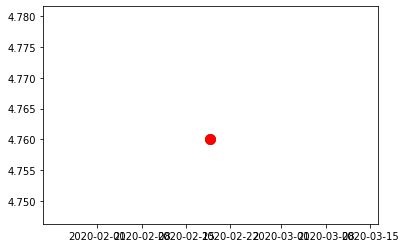

buy time:2020-02-18T19:29:51.181614498Z sell time:2020-02-18T19:30:36.149493671Z
{'rsi': 52.56114928244527, 'macd1': [0.011264455584850452, 0.0062892867600528035, 0.004712852076692364, 0.007412649950677697, 0.00757673489524624], 'macd2': [0.0002951574517116029, -0.000260625320075647, -0.0002917383375100613, 0.0004797834138834389, 0.0008145904575860285], 'macd_signal': [0.019458896269638624, 0.01682497436772146, 0.01440254990951564, 0.013004569917748052, 0.011919002913247689]}
{'rsi': 48.80030911964155, 'macd': [0.0022705134252039016, 0.0040255452512649725, 0.004561601930647363, 0.0031018850323647484, 0.0020851980332823317], 'scalp': 0, 'bail_out': 0, 'movement': -0.0049198174433698234, 'too_close': 1, 'macd_signal': [0.008937161927223429, 0.007954838592031738, 0.007276191259754863, 0.0064413300142768404, 0.0055701036180779385], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0034849055847

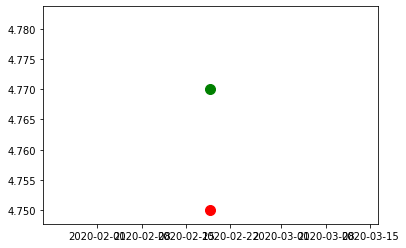

buy time:2020-02-18T19:31:30.966991927Z sell time:2020-02-18T19:32:46.813161427Z
{'rsi': 52.19842471091983, 'macd1': [0.007412649950677697, 0.008246820365331864, 0.006014369033617406, 0.006589920052546994, 0.006654640422904201], 'macd2': [0.0004797834138834389, 0.0009489367190811393, 0.0008192789855279159, 0.001178487477791812, 0.0014447109047361906], 'macd_signal': [0.013004569917748052, 0.012053020007264815, 0.010845289812535333, 0.009994215860537666, 0.009326300773010974]}
{'rsi': 47.94661224808418, 'macd': [0.004561601930647363, 0.0031018850323647484, 0.003482600630685617, 0.003734033556250793, 0.002323019815701599], 'scalp': 0, 'bail_out': 0, 'movement': -0.00419287211740033, 'too_close': 1, 'macd_signal': [0.007276191259754863, 0.0064413300142768404, 0.005849584137558596, 0.005426474021297036, 0.004805783180177948], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002482763364476349}

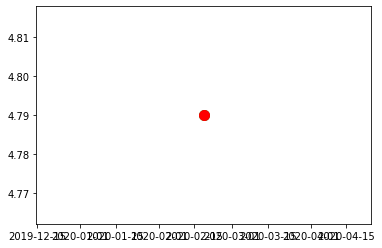

buy time:2020-02-18T19:39:07.707548009Z sell time:2020-02-18T19:39:57.382042024Z
{'rsi': 54.3860828491672, 'macd1': [0.004738034683505532, -0.0004515849375392733, -0.002900983957587755, -0.0016359719766274594, 0.0009931510509231245], 'macd2': [0.0020716703555887506, 0.0011936073709390982, 0.0007069231017817756, 0.0008897746828537834, 0.0013812510480342155], 'macd_signal': [0.0076576332969628055, 0.00603578965006239, 0.004248434928532361, 0.003071553547500397, 0.0026558730481849426]}
{'rsi': 54.3860828491672, 'macd': [0.0023163020284409086, -0.0010438932309302373, -0.0025993194949736065, -0.0017256345124740946, 3.2115272752264445e-05], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0042450526384499275, 0.003187263464573894, 0.0020299468726643942, 0.0012788305956366965, 0.0010294875310598102], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0009973722583075458

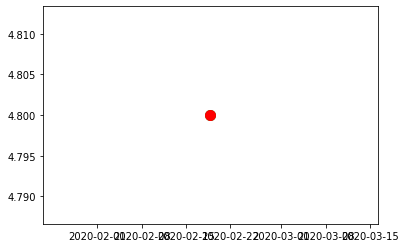

buy time:2020-02-18T19:39:58.607144525Z sell time:2020-02-18T19:40:25.620745455Z
{'rsi': 55.681566015298756, 'macd1': [0.004738034683505532, -0.0004515849375392733, -0.002900983957587755, -0.0016359719766274594, 0.0017908718486445707], 'macd2': [0.0020716703555887506, 0.0011936073709390982, 0.0007069231017817756, 0.0008897746828537834, 0.0015411870736246058], 'macd_signal': [0.0076576332969628055, 0.00603578965006239, 0.004248434928532361, 0.003071553547500397, 0.0028154172077292316]}
{'rsi': 55.681566015298756, 'macd': [0.0023163020284409086, -0.0010438932309302373, -0.0025993194949736065, -0.0017256345124740946, 0.0005515957922321846], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0042450526384499275, 0.003187263464573894, 0.0020299468726643942, 0.0012788305956366965, 0.001133383634955794], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00058178784272360

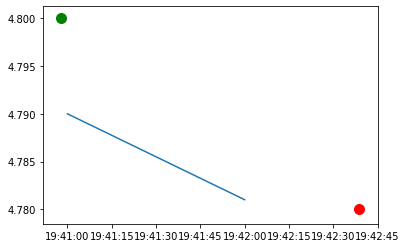

buy time:2020-02-18T19:40:57.788613801Z sell time:2020-02-18T19:42:38.830647545Z
{'rsi': 56.349113494907336, 'macd1': [-0.0004515849375392733, -0.002900983957587755, -0.0016359719766274594, 0.0017908718486445707, 0.004854172602362539], 'macd2': [0.0011936073709390982, 0.0007069231017817756, 0.0008897746828537834, 0.0015411870736246058, 0.0022180104094378095], 'macd_signal': [0.00603578965006239, 0.004248434928532361, 0.003071553547500397, 0.0028154172077292316, 0.003223168286655893]}
{'rsi': 53.338159991685565, 'macd': [-0.0017256345124740946, 0.0005515957922321846, 0.0023188973830139403, 0.0031464194357910813, 0.003589340263464358], 'scalp': 0, 'bail_out': 0, 'movement': -0.0027291666666665977, 'too_close': 0, 'macd_signal': [0.0012788305956366965, 0.001133383634955794, 0.0013704863845674232, 0.0017256729948121549, 0.0020984064485425956], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00

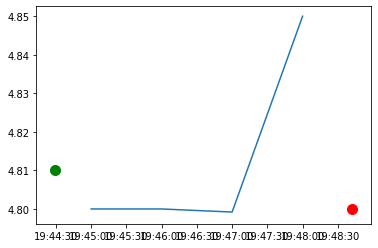

buy time:2020-02-18T19:44:29.231526923Z sell time:2020-02-18T19:48:41.872875112Z
{'rsi': 56.858969491963286, 'macd1': [0.004455312203503148, 0.00569434311168493, 0.005882252306281366, 0.0077333805663633015, 0.009638015179631587], 'macd2': [0.0021380423966421702, 0.0025238128599278653, 0.00273075511685672, 0.003271839128343501, 0.0038731773746114584], 'macd_signal': [0.003143396206884015, 0.003653585587844198, 0.004099318931531632, 0.004826131258497965, 0.00578850804272469]}
{'rsi': 54.63291291707881, 'macd': [0.005909057008547158, 0.006244750451251946, 0.006425229102044128, 0.00644085884159562, 0.006410948783563519], 'scalp': 0, 'bail_out': 0, 'movement': -0.002079002079002035, 'too_close': 0, 'macd_signal': [0.003205522942388346, 0.0038133684441610657, 0.004335740575737678, 0.004756764228909267, 0.0050876011398401175], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0013233476437234017}


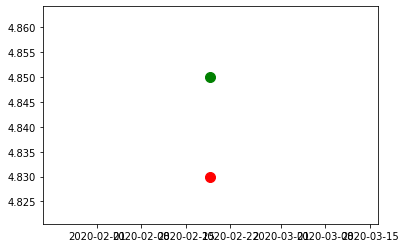

buy time:2020-02-18T19:48:50.643337883Z sell time:2020-02-18T19:49:22.726605412Z
{'rsi': 62.81267178928783, 'macd1': [0.009893285834902343, 0.010419783856294274, 0.010713538330532124, 0.010757778578661004, 0.014722265626868847], 'macd2': [0.003924356902800241, 0.004307302113281786, 0.004652735028461308, 0.0049503080783273035, 0.006028642486735514], 'macd_signal': [0.005839562173778841, 0.006755606510281927, 0.0075471928743319665, 0.008189310015197774, 0.009495901137531989]}
{'rsi': 60.686167598259, 'macd': [0.005909057008547158, 0.006244750451251946, 0.006425229102044128, 0.00644085884159562, 0.008229130601744572], 'scalp': 0, 'bail_out': 0, 'movement': -0.0030927835051545735, 'too_close': 0, 'macd_signal': [0.003205522942388346, 0.0038133684441610657, 0.004335740575737678, 0.004756764228909267, 0.005451237503476328], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0027778930982682443}


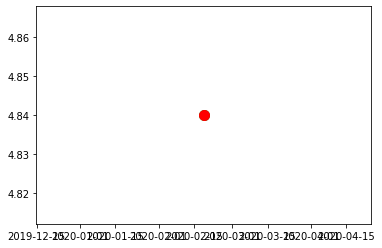

buy time:2020-02-18T19:49:30.767170964Z sell time:2020-02-18T19:49:40.342627443Z
{'rsi': 60.464578667641746, 'macd1': [0.010419783856294274, 0.010713538330532124, 0.010757778578661004, 0.014722265626868847, 0.01686284931846327], 'macd2': [0.004307302113281786, 0.004652735028461308, 0.0049503080783273035, 0.006028642486735514, 0.006851166638594641], 'macd_signal': [0.006755606510281927, 0.0075471928743319665, 0.008189310015197774, 0.009495901137531989, 0.010969290773718245]}
{'rsi': 60.464578667641746, 'macd': [0.006244750451251946, 0.006425229102044128, 0.00644085884159562, 0.009008351380965784, 0.01037252282228085], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0038133684441610657, 0.004335740575737678, 0.004756764228909267, 0.00560708165932057, 0.0065601698919126265], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003812352930368223}


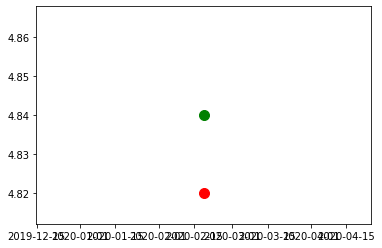

buy time:2020-02-18T19:50:01.621089662Z sell time:2020-02-18T19:50:05.530964822Z
{'rsi': 62.78828846412276, 'macd1': [0.010419783856294274, 0.010713538330532124, 0.010757778578661004, 0.014722265626868847, 0.017652592908206977], 'macd2': [0.004307302113281786, 0.004652735028461308, 0.0049503080783273035, 0.006028642486735514, 0.007009503303928355], 'macd_signal': [0.006755606510281927, 0.0075471928743319665, 0.008189310015197774, 0.009495901137531989, 0.011127239491666985]}
{'rsi': 57.316403335814215, 'macd': [0.006425229102044128, 0.00644085884159562, 0.009008351380965784, 0.00946343191318988, 0.009876956588778185], 'scalp': 0, 'bail_out': 0, 'movement': -0.004927936658487856, 'too_close': 0, 'macd_signal': [0.004335740575737678, 0.004756764228909267, 0.00560708165932057, 0.006378351710094432, 0.007078072685831183], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002798883902947002}


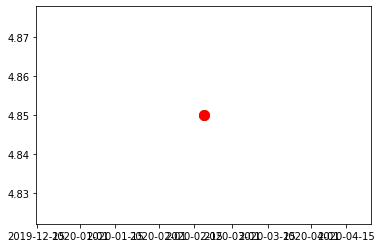

buy time:2020-02-18T19:50:15.919875882Z sell time:2020-02-18T19:50:41.01510676Z
{'rsi': 60.82287259020691, 'macd1': [0.010713538330532124, 0.010757778578661004, 0.014722265626868847, 0.015466837922451404, 0.01806766421759587], 'macd2': [0.004652735028461308, 0.0049503080783273035, 0.006028642486735514, 0.0065712785938130125, 0.007499835398294685], 'macd_signal': [0.0075471928743319665, 0.008189310015197774, 0.009495901137531989, 0.010690088494515871, 0.012165603639131871]}
{'rsi': 60.82287259020691, 'macd': [0.006425229102044128, 0.00644085884159562, 0.009008351380965784, 0.00946343191318988, 0.011123709835530349], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.004335740575737678, 0.004756764228909267, 0.00560708165932057, 0.006378351710094432, 0.0073274233351816155], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003796286500348733}


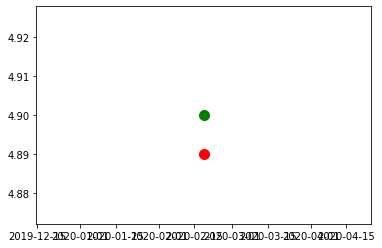

buy time:2020-02-18T19:50:43.351152157Z sell time:2020-02-18T19:50:44.340229373Z
{'rsi': 66.54805315683734, 'macd1': [0.010713538330532124, 0.010757778578661004, 0.014722265626868847, 0.015466837922451404, 0.022056268206199547], 'macd2': [0.004652735028461308, 0.0049503080783273035, 0.006028642486735514, 0.0065712785938130125, 0.008299515526243972], 'macd_signal': [0.0075471928743319665, 0.008189310015197774, 0.009495901137531989, 0.010690088494515871, 0.012963324436852606]}
{'rsi': 65.54091192713467, 'macd': [0.006425229102044128, 0.00644085884159562, 0.009008351380965784, 0.00946343191318988, 0.013201631913452694], 'scalp': 0, 'bail_out': 0, 'movement': -0.00204081632653075, 'too_close': 0, 'macd_signal': [0.004335740575737678, 0.004756764228909267, 0.00560708165932057, 0.006378351710094432, 0.007743007750766084], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0054586241626866094}


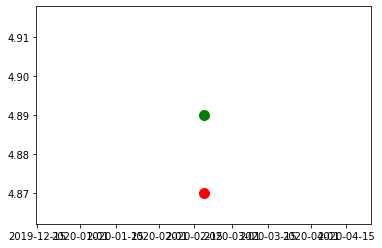

buy time:2020-02-18T19:50:54.306746594Z sell time:2020-02-18T19:50:55.246977415Z
{'rsi': 66.25214700201094, 'macd1': [0.010713538330532124, 0.010757778578661004, 0.014722265626868847, 0.015466837922451404, 0.02181695196688338], 'macd2': [0.004652735028461308, 0.0049503080783273035, 0.006028642486735514, 0.0065712785938130125, 0.008251534718566766], 'macd_signal': [0.0075471928743319665, 0.008189310015197774, 0.009495901137531989, 0.010690088494515871, 0.012915461188989372]}
{'rsi': 63.33303999921463, 'macd': [0.006425229102044128, 0.00644085884159562, 0.009008351380965784, 0.00946343191318988, 0.012162670874491965], 'scalp': 0, 'bail_out': 0, 'movement': -0.005513579742699639, 'too_close': 0, 'macd_signal': [0.004335740575737678, 0.004756764228909267, 0.00560708165932057, 0.006378351710094432, 0.007535215542973939], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0046274553315180265}


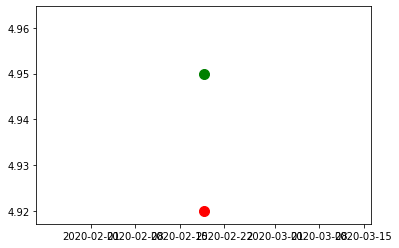

buy time:2020-02-18T19:52:04.25681778Z sell time:2020-02-18T19:53:49.984811875Z
{'rsi': 72.44865851894077, 'macd1': [0.010757778578661004, 0.014722265626868847, 0.015466837922451404, 0.019663105813036985, 0.030376841558504175], 'macd2': [0.0049503080783273035, 0.006028642486735514, 0.0065712785938130125, 0.007819707449474578, 0.010489581886531596], 'macd_signal': [0.008189310015197774, 0.009495901137531989, 0.010690088494515871, 0.012484691958220094, 0.01606312187827691]}
{'rsi': 60.20629728188123, 'macd': [0.00946343191318988, 0.012162670874491965, 0.019089835378435005, 0.024566978688281615, 0.024801545180521245], 'scalp': 0, 'bail_out': 0, 'movement': -0.013129543486578629, 'too_close': 0, 'macd_signal': [0.006378351710094432, 0.007535215542973939, 0.009846139510066153, 0.012790307345709245, 0.015192554912671645], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0096089902678496}


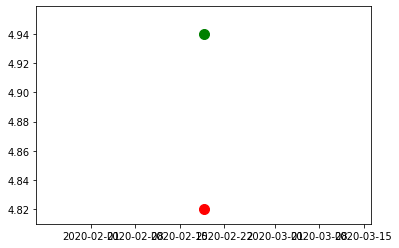

buy time:2020-02-18T19:54:00.866837961Z sell time:2020-02-18T19:55:58.689097364Z
{'rsi': 66.58975996680002, 'macd1': [0.015466837922451404, 0.019663105813036985, 0.030376841558504175, 0.03892718333562506, 0.0426138934648721], 'macd2': [0.0065712785938130125, 0.007819707449474578, 0.010489581886531596, 0.013029934846196412, 0.01483130726555082], 'macd_signal': [0.010690088494515871, 0.012484691958220094, 0.01606312187827691, 0.020635934169746538, 0.02503152602877165]}
{'rsi': 48.97023263889464, 'macd': [0.019089835378435005, 0.024566978688281615, 0.0268431036220802, 0.027608355471507195, 0.0224850665818197], 'scalp': 0, 'bail_out': 0, 'movement': -0.023461538461538617, 'too_close': 0, 'macd_signal': [0.009846139510066153, 0.012790307345709245, 0.015600866600983436, 0.01800236437508819, 0.01889890481643449], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003586161765385211}


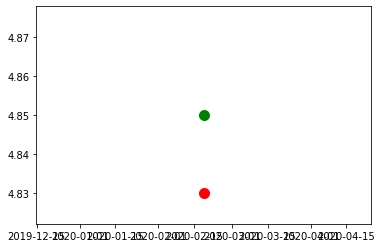

buy time:2020-02-18T20:02:05.132826677Z sell time:2020-02-18T20:02:18.214674707Z
{'rsi': 53.10154821060692, 'macd1': [0.023293239870194604, 0.013653410777936692, 0.007476867634111706, 0.008208329642407364, 0.00900695851338007], 'macd2': [0.015622105139498466, 0.014184758372596029, 0.013146744000692046, 0.013304657616943771, 0.013492638664735601], 'macd_signal': [0.028680931976523383, 0.025675427736806044, 0.022035715716267175, 0.019270238501495212, 0.017217582503872182]}
{'rsi': 50.31548417036771, 'macd': [0.013700251116353535, 0.007374664025721955, 0.0033472628638566704, 0.0038486741291059445, 0.0031504403860651564], 'scalp': 0, 'bail_out': 0, 'movement': -0.004944375772558718, 'too_close': 0, 'macd_signal': [0.017555513647557835, 0.01551934372319066, 0.013084927551323861, 0.011237676866880278, 0.009620229570717254], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0064697891846520975}


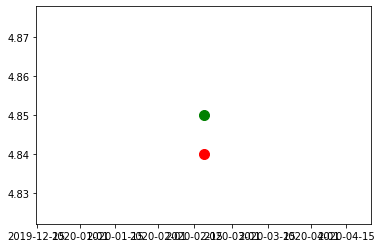

buy time:2020-02-18T20:02:23.022282101Z sell time:2020-02-18T20:02:37.544659058Z
{'rsi': 52.66378388172801, 'macd1': [0.023293239870194604, 0.013653410777936692, 0.007476867634111706, 0.008208329642407364, 0.008687870194291847], 'macd2': [0.015622105139498466, 0.014184758372596029, 0.013146744000692046, 0.013304657616943771, 0.013428664254499623], 'macd_signal': [0.028680931976523383, 0.025675427736806044, 0.022035715716267175, 0.019270238501495212, 0.017153764840054538]}
{'rsi': 51.4628591633076, 'macd': [0.013700251116353535, 0.007374664025721955, 0.0033472628638566704, 0.0038486741291059445, 0.0036699209055459647], 'scalp': 0, 'bail_out': 0, 'movement': -0.002061855670103049, 'too_close': 0, 'macd_signal': [0.017555513647557835, 0.01551934372319066, 0.013084927551323861, 0.011237676866880278, 0.009724125674613416], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.006054204769067451}


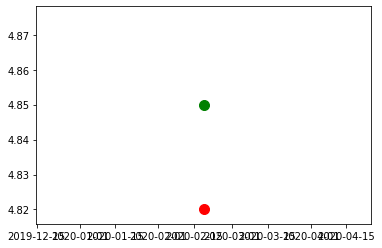

buy time:2020-02-18T20:02:49.224116063Z sell time:2020-02-18T20:02:55.643501454Z
{'rsi': 52.66378388172801, 'macd1': [0.023293239870194604, 0.013653410777936692, 0.007476867634111706, 0.008208329642407364, 0.008687870194291847], 'macd2': [0.015622105139498466, 0.014184758372596029, 0.013146744000692046, 0.013304657616943771, 0.013428664254499623], 'macd_signal': [0.028680931976523383, 0.025675427736806044, 0.022035715716267175, 0.019270238501495212, 0.017153764840054538]}
{'rsi': 49.76077087749496, 'macd': [0.013700251116353535, 0.007374664025721955, 0.0033472628638566704, 0.0038486741291059445, 0.0028907001263256404], 'scalp': 0, 'bail_out': 0, 'movement': -0.005154639175257623, 'too_close': 0, 'macd_signal': [0.017555513647557835, 0.01551934372319066, 0.013084927551323861, 0.011237676866880278, 0.00956828151876935], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00667758139244371}


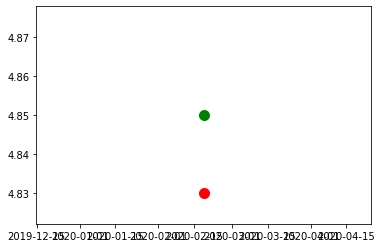

buy time:2020-02-18T20:03:01.000172162Z sell time:2020-02-18T20:03:25.240548099Z
{'rsi': 52.66378388172801, 'macd1': [0.023293239870194604, 0.013653410777936692, 0.007476867634111706, 0.008208329642407364, 0.008687870194291847], 'macd2': [0.015622105139498466, 0.014184758372596029, 0.013146744000692046, 0.013304657616943771, 0.013428664254499623], 'macd_signal': [0.028680931976523383, 0.025675427736806044, 0.022035715716267175, 0.019270238501495212, 0.017153764840054538]}
{'rsi': 51.347569536567676, 'macd': [0.007374664025721955, 0.0033472628638566704, 0.0038486741291059445, 0.004189401425026773, 0.003870625273471262], 'scalp': 0, 'bail_out': 0, 'movement': -0.0021030927835050148, 'too_close': 0, 'macd_signal': [0.01551934372319066, 0.013084927551323861, 0.011237676866880278, 0.009828021778509577, 0.008636542477501914], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0047659172040306515}


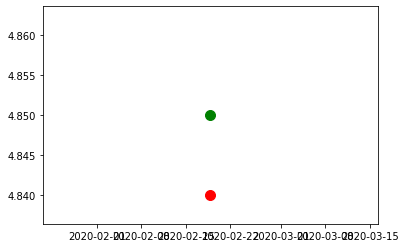

buy time:2020-02-18T20:03:54.888925364Z sell time:2020-02-18T20:04:32.475136438Z
{'rsi': 52.66378388172801, 'macd1': [0.013653410777936692, 0.007476867634111706, 0.008208329642407364, 0.008687870194291847, 0.008964571536147048], 'macd2': [0.014184758372596029, 0.013146744000692046, 0.013304657616943771, 0.013428664254499623, 0.013521277055779102], 'macd_signal': [0.025675427736806044, 0.022035715716267175, 0.019270238501495212, 0.017153764840054538, 0.01551592617927304]}
{'rsi': 51.37274498155647, 'macd': [0.007374664025721955, 0.0033472628638566704, 0.0038486741291059445, 0.004189401425026773, 0.0038810148838601677], 'scalp': 0, 'bail_out': 0, 'movement': -0.002061855670103049, 'too_close': 0, 'macd_signal': [0.01551934372319066, 0.013084927551323861, 0.011237676866880278, 0.009828021778509577, 0.008638620399579695], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004757605515719528}


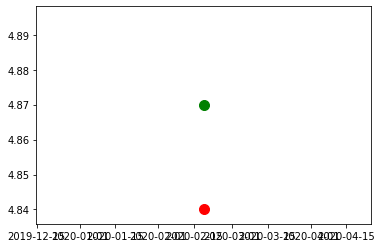

buy time:2020-02-18T20:05:10.710793096Z sell time:2020-02-18T20:05:52.419778502Z
{'rsi': 55.02607870824645, 'macd1': [0.008208329642407364, 0.008687870194291847, 0.00816685073842649, 0.009261016683393741, 0.010810451350436345], 'macd2': [0.013304657616943771, 0.013428664254499623, 0.013361341030188711, 0.013597903963710856, 0.013953737507965691], 'macd_signal': [0.019270238501495212, 0.017153764840054538, 0.015356382019728929, 0.014137308952461892, 0.013471937432056783]}
{'rsi': 51.71660070764298, 'macd': [0.0038486741291059445, 0.004189401425026773, 0.0038810148838601677, 0.004629271931213097, 0.004372988176797321], 'scalp': 0, 'bail_out': 0, 'movement': -0.0051334702258727626, 'too_close': 0, 'macd_signal': [0.011237676866880278, 0.009828021778509577, 0.008638620399579695, 0.007836750705906375, 0.007143998200084564], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0027710100232872428}


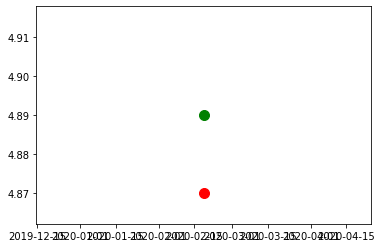

buy time:2020-02-18T20:08:02.289968992Z sell time:2020-02-18T20:08:21.879819512Z
{'rsi': 57.60926314601302, 'macd1': [0.009261016683393741, 0.00881614935613495, 0.008765998038697376, 0.010222249877870127, 0.01284213664784506], 'macd2': [0.013597903963710856, 0.013553897443991048, 0.013571700486114224, 0.01388624586715359, 0.014473300620573504], 'macd_signal': [0.014137308952461892, 0.013073077033196503, 0.012211661234296678, 0.011813778963011367, 0.012019450499978105]}
{'rsi': 55.85016867720613, 'macd': [0.004629271931213097, 0.004372988176797321, 0.004376234755476105, 0.0053608913784009005, 0.0063702226251161065], 'scalp': 0, 'bail_out': 0, 'movement': -0.002862985685071441, 'too_close': 0, 'macd_signal': [0.007836750705906375, 0.007143998200084564, 0.006590445511162872, 0.0063445346846104774, 0.006349672272711603], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 2.0550352404503404e-05}


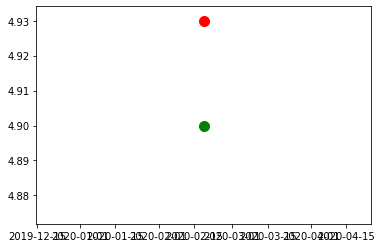

buy time:2020-02-18T20:09:35.044562562Z sell time:2020-02-18T20:09:52.886308551Z
{'rsi': 58.87160928667596, 'macd1': [0.00881614935613495, 0.008765998038697376, 0.010222249877870127, 0.012826182231891359, 0.015533808067869082], 'macd2': [0.013553897443991048, 0.013571700486114224, 0.01388624586715359, 0.014470101900061039, 0.015147259966482807], 'macd_signal': [0.013073077033196503, 0.012211661234296678, 0.011813778963011367, 0.012016259616787366, 0.01271976930700371]}
{'rsi': 62.240130255581114, 'macd': [0.004372988176797321, 0.004376234755476105, 0.0053608913784009005, 0.0070871057420003325, 0.01042847919750578], 'scalp': 0, 'bail_out': 1, 'movement': 0.0061224489795917054, 'too_close': 0, 'macd_signal': [0.007143998200084564, 0.006590445511162872, 0.0063445346846104774, 0.006493048896088449, 0.0072801349563719146], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0031483442411338654}


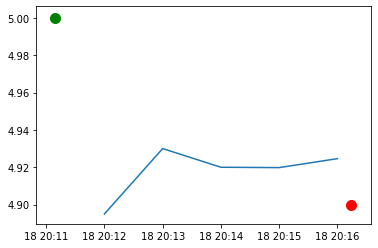

buy time:2020-02-18T20:11:09.555056656Z sell time:2020-02-18T20:16:14.419348117Z
{'rsi': 68.84773346279405, 'macd1': [0.008765998038697376, 0.010222249877870127, 0.012826182231891359, 0.021117853651913876, 0.03016554090518664], 'macd2': [0.013571700486114224, 0.01388624586715359, 0.014470101900061039, 0.016266812145611098, 0.01845360263998419], 'macd_signal': [0.012211661234296678, 0.011813778963011367, 0.012016259616787366, 0.013836578423812668, 0.017102370920087463]}
{'rsi': 52.484613365465606, 'macd': [0.017992128655254902, 0.01802978210513917, 0.017305488921866008, 0.016505968403446758, 0.01464003074749165], 'scalp': 0, 'bail_out': 0, 'movement': -0.004671947999187424, 'too_close': 1, 'macd_signal': [0.013106229414531148, 0.014090939952652752, 0.014733849746495404, 0.015088273477885675, 0.01499862493180687], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0003585941843152196}


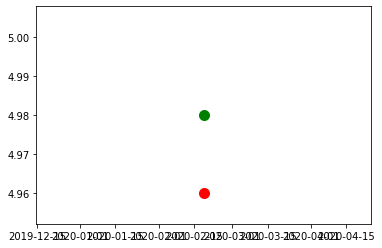

buy time:2020-02-18T20:21:03.869982125Z sell time:2020-02-18T20:21:09.628160254Z
{'rsi': 62.50513671358222, 'macd1': [0.02660905655477297, 0.025840837046456677, 0.025127948975309344, 0.028080211039505976, 0.03007323446827037], 'macd2': [0.02174803482197607, 0.02203805467768838, 0.022306420718984477, 0.023278945540315732, 0.024136468063994165], 'macd_signal': [0.025826463218524408, 0.025829337984110863, 0.025689060182350558, 0.026167290353781642, 0.026948479176679387]}
{'rsi': 58.8656604152157, 'macd': [0.015710175065576593, 0.015172813498618432, 0.014676521193214498, 0.01657192301766308, 0.01679467868583462], 'scalp': 0, 'bail_out': 0, 'movement': -0.004016064257028205, 'too_close': 0, 'macd_signal': [0.015345402491028262, 0.015310884692546297, 0.015184011992679937, 0.015461594197676566, 0.015728211095308177], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0010664675905264417}


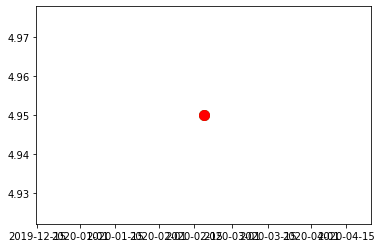

buy time:2020-02-18T20:21:38.450090755Z sell time:2020-02-18T20:21:44.934762567Z
{'rsi': 60.63083112297261, 'macd1': [0.02660905655477297, 0.025840837046456677, 0.025127948975309344, 0.028080211039505976, 0.029275513670548925], 'macd2': [0.02174803482197607, 0.02203805467768838, 0.022306420718984477, 0.023278945540315732, 0.02397653203840555], 'macd_signal': [0.025826463218524408, 0.025829337984110863, 0.025689060182350558, 0.026167290353781642, 0.0267889350171351]}
{'rsi': 58.83140475009042, 'macd': [0.015710175065576593, 0.015172813498618432, 0.014676521193214498, 0.01657192301766308, 0.016784289075445713], 'scalp': 0, 'bail_out': 0, 'movement': -0.002052313883299662, 'too_close': 0, 'macd_signal': [0.015345402491028262, 0.015310884692546297, 0.015184011992679937, 0.015461594197676566, 0.015726133173230395], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001058155902215318}


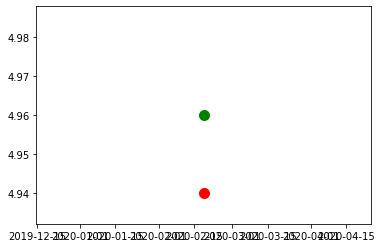

buy time:2020-02-18T20:22:02.897044592Z sell time:2020-02-18T20:22:21.789833247Z
{'rsi': 58.8656604152157, 'macd1': [0.02660905655477297, 0.025840837046456677, 0.025127948975309344, 0.028080211039505976, 0.028477792872828367], 'macd2': [0.02174803482197607, 0.02203805467768838, 0.022306420718984477, 0.023278945540315732, 0.02381659601281516], 'macd_signal': [0.025826463218524408, 0.025829337984110863, 0.025689060182350558, 0.026167290353781642, 0.026629390857590987]}
{'rsi': 56.780252555583324, 'macd': [0.015172813498618432, 0.014676521193214498, 0.01657192301766308, 0.017314159205315427, 0.016576756764456135], 'scalp': 0, 'bail_out': 0, 'movement': -0.0022177419354838953, 'too_close': 1, 'macd_signal': [0.015310884692546297, 0.015184011992679937, 0.015461594197676566, 0.01583210719920434, 0.0159810371122547], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0005957196522014367}
SPWR analys

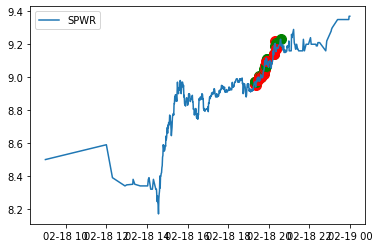

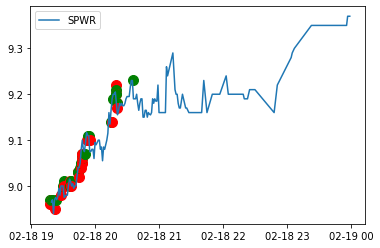

Delta = nan


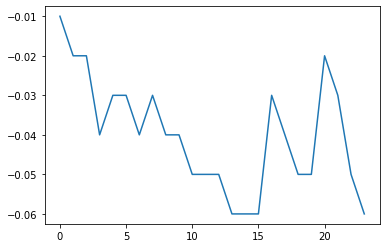

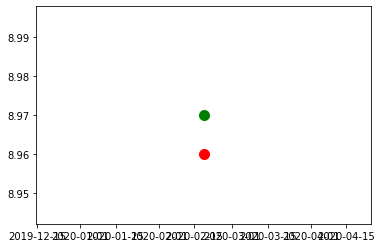

buy time:2020-02-18T19:18:03.771267678Z sell time:2020-02-18T19:18:05.450007315Z
{'rsi': 61.49910414497687, 'macd1': [-0.005867328291094154, -0.0037280709818041657, -0.001211808748237786, 0.0015711523606611877, 0.004132490524492383], 'macd2': [-0.0016160003970675518, -0.0013878492055461322, -0.0010157871149765185, -0.0005119174552969952, 3.244550221737086e-05], 'macd_signal': [-0.00679145700883779, -0.006178779803431065, -0.005185385592392409, -0.0038340780017816897, -0.0022407642965268752]}
{'rsi': 60.19071347509218, 'macd': [-0.0033364900044752233, -0.001940767045738312, -0.0003085054279470256, 0.001486873825241375, 0.0028665605962281404], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005574136008919488, 'too_close': 0, 'macd_signal': [-0.0039920812432636555, -0.003581818403758587, -0.002927155808596275, -0.002044349881828745, -0.001062167786217368], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_m

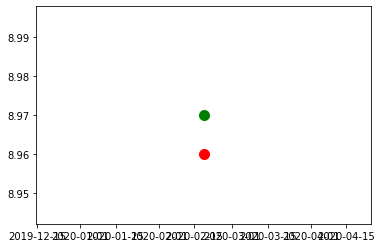

buy time:2020-02-18T19:18:46.052691641Z sell time:2020-02-18T19:18:53.386142074Z
{'rsi': 61.49910414497687, 'macd1': [-0.005867328291094154, -0.0037280709818041657, -0.001211808748237786, 0.0015711523606611877, 0.004132490524492383], 'macd2': [-0.0016160003970675518, -0.0013878492055461322, -0.0010157871149765185, -0.0005119174552969952, 3.244550221737086e-05], 'macd_signal': [-0.00679145700883779, -0.006178779803431065, -0.005185385592392409, -0.0038340780017816897, -0.0022407642965268752]}
{'rsi': 59.74404642330585, 'macd': [-0.0033364900044752233, -0.001940767045738312, -0.0003085054279470256, 0.001486873825241375, 0.0028094177390851627], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006800445930880707, 'too_close': 0, 'macd_signal': [-0.0039920812432636555, -0.003581818403758587, -0.002927155808596275, -0.002044349881828745, -0.0010735963576459636], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_

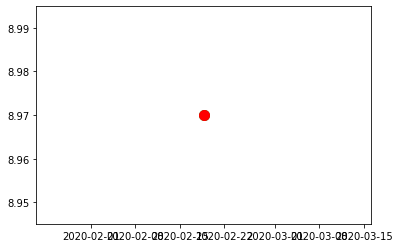

buy time:2020-02-18T19:18:55.134049644Z sell time:2020-02-18T19:19:40.053804381Z
{'rsi': 61.49910414497687, 'macd1': [-0.005867328291094154, -0.0037280709818041657, -0.001211808748237786, 0.0015711523606611877, 0.004132490524492383], 'macd2': [-0.0016160003970675518, -0.0013878492055461322, -0.0010157871149765185, -0.0005119174552969952, 3.244550221737086e-05], 'macd_signal': [-0.00679145700883779, -0.006178779803431065, -0.005185385592392409, -0.0038340780017816897, -0.0022407642965268752]}
{'rsi': 61.499104144976855, 'macd': [-0.001940767045738312, -0.0003085054279470256, 0.001486873825241375, 0.0031263008559694327, 0.004363175154511012], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.003581818403758587, -0.002927155808596275, -0.002044349881828745, -0.0010102197342691094, 6.445924348691488e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004298715911

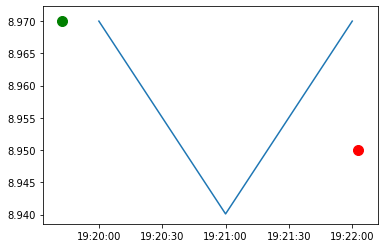

buy time:2020-02-18T19:19:42.636335061Z sell time:2020-02-18T19:22:02.518404494Z
{'rsi': 64.04437807146863, 'macd1': [-0.0037280709818041657, -0.001211808748237786, 0.0015711523606611877, 0.004132490524492383, 0.006889863837756138], 'macd2': [-0.0013878492055461322, -0.0010157871149765185, -0.0005119174552969952, 3.244550221737086e-05, 0.0006931609693232588], 'macd_signal': [-0.006178779803431065, -0.005185385592392409, -0.0038340780017816897, -0.0022407642965268752, -0.0004146386696702725]}
{'rsi': 54.57759285080092, 'macd': [0.001486873825241375, 0.0031263008559694327, 0.00410343489476972, 0.005071286939356767, 0.004980375715147645], 'scalp': 0, 'bail_out': 0, 'movement': -0.002228412256267362, 'too_close': 0, 'macd_signal': [-0.002044349881828745, -0.0010102197342691094, 1.2511191538656452e-05, 0.0010242663411022786, 0.0018154882159113518], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 

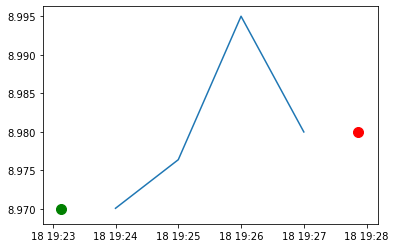

buy time:2020-02-18T19:23:08.032495127Z sell time:2020-02-18T19:27:52.138619129Z
{'rsi': 59.17239847083587, 'macd1': [0.005693282641175301, 0.007250105152637687, 0.006002030423411853, 0.007340980075175807, 0.008705217208891725], 'macd2': [0.00045325693093900554, 0.0009196599976188935, 0.0008690861537328232, 0.0012993753343018, 0.0017731449877000927], 'macd_signal': [-0.0006539549089864399, 0.0009268571033383855, 0.001941891767353079, 0.0030217094289176245, 0.0041584109849124445]}
{'rsi': 56.363611584379, 'macd': [0.005867972268958965, 0.006189412159667285, 0.006686775552950053, 0.007953723969107429, 0.007798700345734488], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0030413902333904573, 0.003670994618645823, 0.004274150805506669, 0.005010065438226821, 0.005567792419728355], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0022309079260061336}


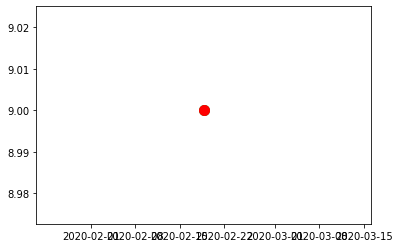

buy time:2020-02-18T19:30:19.305482084Z sell time:2020-02-18T19:31:00.31047424Z
{'rsi': 62.77613538019088, 'macd1': [0.012168571600930989, 0.012427211160172646, 0.014083669946925781, 0.015220967629460347, 0.0159385545017674], 'macd2': [0.0032346882404308275, 0.0036181695321229057, 0.0042850698816057076, 0.004891786164945344, 0.005442160824403075], 'macd_signal': [0.007372639009541963, 0.008383553439668099, 0.009523576741119635, 0.010663054918787777, 0.011718154835383701]}
{'rsi': 62.77613538019088, 'macd': [0.007953723969107429, 0.00805844060547578, 0.009074343950624453, 0.00974810832411066, 0.010146520714824803], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.005010065438226821, 0.005619740471676613, 0.006310661167466181, 0.006998150598795077, 0.007627824622001022], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0025186960928237807}


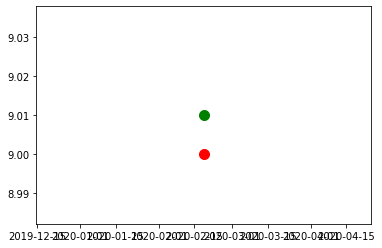

buy time:2020-02-18T19:31:02.611521398Z sell time:2020-02-18T19:31:14.201368155Z
{'rsi': 65.23086992710066, 'macd1': [0.012427211160172646, 0.014083669946925781, 0.015220967629460347, 0.0159385545017674, 0.017116851287742207], 'macd2': [0.0036181695321229057, 0.0042850698816057076, 0.004891786164945344, 0.005442160824403075, 0.006099755165912768], 'macd_signal': [0.008383553439668099, 0.009523576741119635, 0.010663054918787777, 0.011718154835383701, 0.012797894125855403]}
{'rsi': 64.04535201497282, 'macd': [0.00805844060547578, 0.009074343950624453, 0.00974810832411066, 0.010146520714824803, 0.010584939191813802], 'scalp': 0, 'bail_out': 0, 'movement': -0.000554938956714651, 'too_close': 0, 'macd_signal': [0.005619740471676613, 0.006310661167466181, 0.006998150598795077, 0.007627824622001022, 0.008219247535963578], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0023656916558502245}


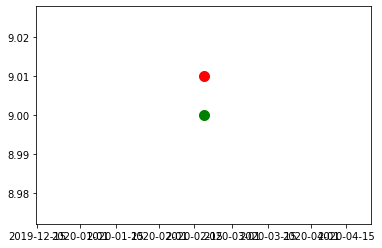

buy time:2020-02-18T19:36:13.286963821Z sell time:2020-02-18T19:36:49.619893235Z
{'rsi': 60.963945357418794, 'macd1': [0.013120629163392294, 0.012203143884068623, 0.01134524921925184, 0.012139260530643625, 0.012623010013578906], 'macd2': [0.005665896661884773, 0.005807868984023301, 0.005929199186864409, 0.006351215980142655, 0.006729327046681277], 'macd_signal': [0.012415717486638984, 0.012373202766124912, 0.012167612056750297, 0.012161941751528963, 0.012254155403938951]}
{'rsi': 60.963945357418794, 'macd': [0.00818197967855916, 0.007531939977685198, 0.006927598133136925, 0.007405674642150473, 0.007682024199276327], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.007962443315131906, 0.007876342647642564, 0.007686593744741436, 0.007630409924223243, 0.0076407327792338605], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 4.129142004246668e-05}


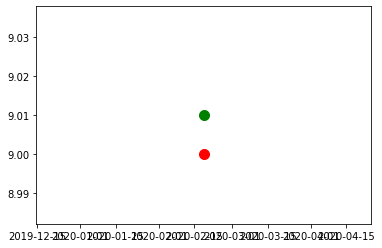

buy time:2020-02-18T19:37:13.294555046Z sell time:2020-02-18T19:37:14.420539363Z
{'rsi': 63.61122602025417, 'macd1': [0.013120629163392294, 0.012203143884068623, 0.01134524921925184, 0.012139260530643625, 0.013420730811297688], 'macd2': [0.005665896661884773, 0.005807868984023301, 0.005929199186864409, 0.006351215980142655, 0.006889263072270779], 'macd_signal': [0.012415717486638984, 0.012373202766124912, 0.012167612056750297, 0.012161941751528963, 0.012413699563482709]}
{'rsi': 60.52900363857202, 'macd': [0.007531939977685198, 0.006927598133136925, 0.007405674642150473, 0.008461244978496651, 0.008654400500603288], 'scalp': 0, 'bail_out': 0, 'movement': -0.000554938956714651, 'too_close': 0, 'macd_signal': [0.007876342647642564, 0.007686593744741436, 0.007630409924223243, 0.007796576935077925, 0.007968141648182998], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0006862588524202892}


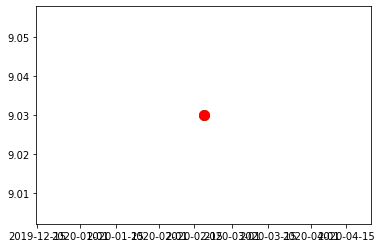

buy time:2020-02-18T19:44:14.99298946Z sell time:2020-02-18T19:44:20.044714179Z
{'rsi': 66.10175236340028, 'macd1': [0.013160212952273653, 0.012625969952935634, 0.012063517802994639, 0.013080815773234278, 0.014526495769596082], 'macd2': [0.00814368601180071, 0.008317198687953109, 0.008463533703178427, 0.008904502409782467, 0.009455902243551861], 'macd_signal': [0.01332696021434888, 0.01318676216206623, 0.012962113290251912, 0.012985853786848385, 0.013293982183397925]}
{'rsi': 66.10175236340028, 'macd': [0.007872396729428743, 0.007494547772962434, 0.007102788225418877, 0.007744238081548005, 0.008662975137212925], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.008155144152011056, 0.008023024876201332, 0.007838977546044842, 0.007820029653145474, 0.007988618749958964], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0006743563872539608}


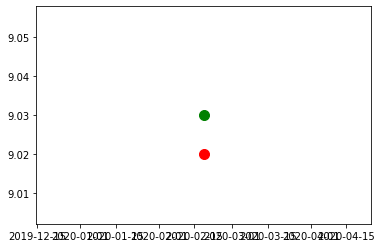

buy time:2020-02-18T19:44:26.07663765Z sell time:2020-02-18T19:44:32.643490186Z
{'rsi': 68.40591410891194, 'macd1': [0.013160212952273653, 0.012625969952935634, 0.012063517802994639, 0.013080815773234278, 0.01532421656731664], 'macd2': [0.00814368601180071, 0.008317198687953109, 0.008463533703178427, 0.008904502409782467, 0.009615838269141364], 'macd_signal': [0.01332696021434888, 0.01318676216206623, 0.012962113290251912, 0.012985853786848385, 0.013453526342942036]}
{'rsi': 64.81886962625659, 'macd': [0.007872396729428743, 0.007494547772962434, 0.007102788225418877, 0.007744238081548005, 0.008403234877473409], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016592920353980967, 'too_close': 0, 'macd_signal': [0.008155144152011056, 0.008023024876201332, 0.007838977546044842, 0.007820029653145474, 0.007936670698011062], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00046656417946234693}


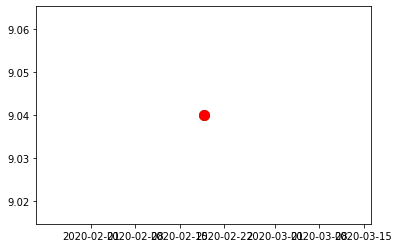

buy time:2020-02-18T19:45:46.544771064Z sell time:2020-02-18T19:46:52.48867875Z
{'rsi': 68.40591410891194, 'macd1': [0.012625969952935634, 0.012063517802994639, 0.013080815773234278, 0.01532421656731664, 0.016907231815475043], 'macd2': [0.008317198687953109, 0.008463533703178427, 0.008904502409782467, 0.009615838269141364, 0.010254910823844554], 'macd_signal': [0.01318676216206623, 0.012962113290251912, 0.012985853786848385, 0.013453526342942036, 0.014144267437448638]}
{'rsi': 68.40591410891194, 'macd': [0.007494547772962434, 0.007102788225418877, 0.007744238081548005, 0.009182455656693733, 0.010183892005420248], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.008023024876201332, 0.007838977546044842, 0.007820029653145474, 0.008092514853855126, 0.00851079028416815], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0016731017212520977}


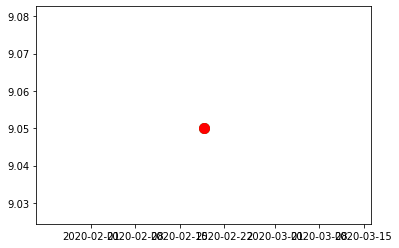

buy time:2020-02-18T19:46:53.74932841Z sell time:2020-02-18T19:47:28.6826136Z
{'rsi': 70.7145575854391, 'macd1': [0.012063517802994639, 0.013080815773234278, 0.01532421656731664, 0.016907231815475043, 0.018752531718556398], 'macd2': [0.008463533703178427, 0.008904502409782467, 0.009615838269141364, 0.010254910823844554, 0.010986412745104701], 'macd_signal': [0.012962113290251912, 0.012985853786848385, 0.013453526342942036, 0.014144267437448638, 0.01506592029367019]}
{'rsi': 70.71455758543911, 'macd': [0.007744238081548005, 0.009182455656693733, 0.010183892005420248, 0.011351454199164834, 0.012113821438456185], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.007820029653145474, 0.008092514853855126, 0.00851079028416815, 0.009078923067167486, 0.009685902741425226], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0024279186970309584}


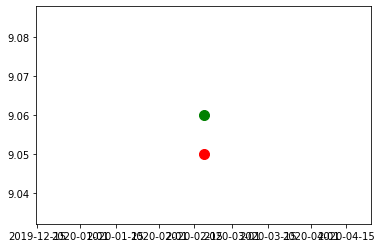

buy time:2020-02-18T19:47:29.582065531Z sell time:2020-02-18T19:47:30.370006903Z
{'rsi': 72.85099272647648, 'macd1': [0.013080815773234278, 0.01532421656731664, 0.016907231815475043, 0.018752531718556398, 0.02078229623842276], 'macd2': [0.008904502409782467, 0.009615838269141364, 0.010254910823844554, 0.010986412745104701, 0.011801782705056496], 'macd_signal': [0.012985853786848385, 0.013453526342942036, 0.014144267437448638, 0.01506592029367019, 0.016209195482620703]}
{'rsi': 71.43390164976267, 'macd': [0.007744238081548005, 0.009182455656693733, 0.010183892005420248, 0.011351454199164834, 0.012280055204689333], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007505518763797062, 'too_close': 0, 'macd_signal': [0.007820029653145474, 0.008092514853855126, 0.00851079028416815, 0.009078923067167486, 0.009719149494671855], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0025609057100174776}


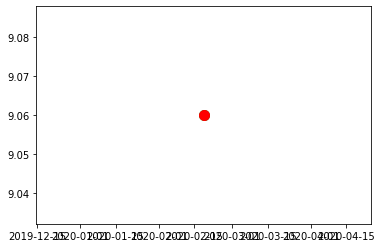

buy time:2020-02-18T19:47:32.27371278Z sell time:2020-02-18T19:47:36.138559367Z
{'rsi': 72.85099272647648, 'macd1': [0.013080815773234278, 0.01532421656731664, 0.016907231815475043, 0.018752531718556398, 0.02078229623842276], 'macd2': [0.008904502409782467, 0.009615838269141364, 0.010254910823844554, 0.010986412745104701, 0.011801782705056496], 'macd_signal': [0.012985853786848385, 0.013453526342942036, 0.014144267437448638, 0.01506592029367019, 0.016209195482620703]}
{'rsi': 72.85099272647648, 'macd': [0.007744238081548005, 0.009182455656693733, 0.010183892005420248, 0.011351454199164834, 0.012633301957936993], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.007820029653145474, 0.008092514853855126, 0.00851079028416815, 0.009078923067167486, 0.009789798845321388], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002843503112615605}


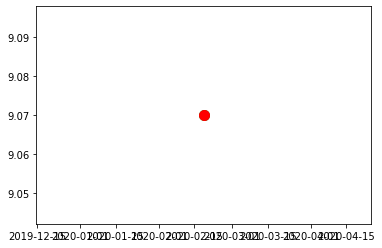

buy time:2020-02-18T19:47:43.110711458Z sell time:2020-02-18T19:47:48.432267787Z
{'rsi': 74.69690702872673, 'macd1': [0.013080815773234278, 0.01532421656731664, 0.016907231815475043, 0.018752531718556398, 0.021580017036143317], 'macd2': [0.008904502409782467, 0.009615838269141364, 0.010254910823844554, 0.010986412745104701, 0.011961718730645998], 'macd_signal': [0.012985853786848385, 0.013453526342942036, 0.014144267437448638, 0.01506592029367019, 0.016368739642164815]}
{'rsi': 74.69690702872673, 'macd': [0.007744238081548005, 0.009182455656693733, 0.010183892005420248, 0.011351454199164834, 0.013152782477416025], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.007820029653145474, 0.008092514853855126, 0.00851079028416815, 0.009078923067167486, 0.009893694949217194], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003259087528198831}


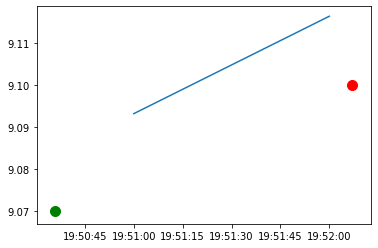

buy time:2020-02-18T19:50:35.808069288Z sell time:2020-02-18T19:52:06.844500774Z
{'rsi': 66.25811841831587, 'macd1': [0.016907231815475043, 0.018752531718556398, 0.022377737833863875, 0.026558423675385967, 0.027138067298512425], 'macd2': [0.010254910823844554, 0.010986412745104701, 0.0121216547562355, 0.013466598878023817, 0.014202644471275505], 'macd_signal': [0.014144267437448638, 0.01506592029367019, 0.016528283801708926, 0.018534311776444334, 0.020255062880857953]}
{'rsi': 72.4838879819205, 'macd': [0.01634208461854847, 0.017171269198813732, 0.017334643297738594, 0.018182277098228283, 0.018954689447983952], 'scalp': 0, 'bail_out': 1, 'movement': 0.00329658213891947, 'too_close': 0, 'macd_signal': [0.011266489766200663, 0.012447445652723276, 0.01342488518172634, 0.014376363565026728, 0.015292028741618172], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00366266070636578}


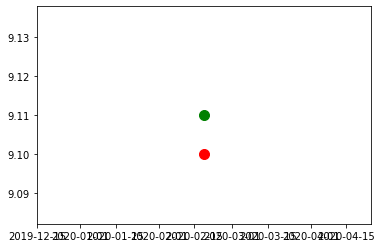

buy time:2020-02-18T19:53:16.047624677Z sell time:2020-02-18T19:53:17.461897785Z
{'rsi': 72.2711395135349, 'macd1': [0.027935788096231207, 0.028297702806623803, 0.029710625126087464, 0.0323217679675345, 0.033496631812342414], 'macd2': [0.014362580496865007, 0.015083973292933095, 0.01601463659984148, 0.01721471565733701, 0.018190534549248127], 'macd_signal': [0.020414607040401708, 0.021991226193646126, 0.023535105980134394, 0.025292438377614416, 0.026933277064560016]}
{'rsi': 70.2836636326916, 'macd': [0.017171269198813732, 0.017334643297738594, 0.018182277098228283, 0.019806637499931057, 0.020228130832427027], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005488474204170149, 'too_close': 0, 'macd_signal': [0.012447445652723276, 0.01342488518172634, 0.014376363565026728, 0.015462418352007594, 0.01641556084809148], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0038125699843355454}


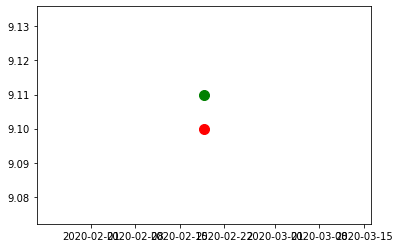

buy time:2020-02-18T19:54:24.677375784Z sell time:2020-02-18T19:55:33.084883974Z
{'rsi': 72.27113951353492, 'macd1': [0.028297702806623803, 0.029710625126087464, 0.0323217679675345, 0.033496631812342414, 0.03403538118577032], 'macd2': [0.015083973292933095, 0.01601463659984148, 0.01721471565733701, 0.018190534549248127, 0.019059225925534662], 'macd_signal': [0.021991226193646126, 0.023535105980134394, 0.025292438377614416, 0.026933277064560016, 0.028353697888802078]}
{'rsi': 69.97622070481734, 'macd': [0.018182277098228283, 0.019806637499931057, 0.02048787109216832, 0.020752626214791903, 0.02042967402183926], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005488474204170149, 'too_close': 0, 'macd_signal': [0.014376363565026728, 0.015462418352007594, 0.01646750890003974, 0.017324532362990173, 0.017945560694759992], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0024841133270792695}


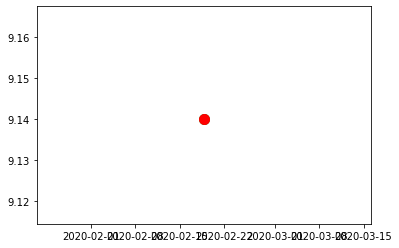

buy time:2020-02-18T20:14:50.233948238Z sell time:2020-02-18T20:15:46.591618941Z
{'rsi': 67.55341290701085, 'macd1': [0.01111619075793513, 0.011661478238767842, 0.013152384632709513, 0.017760332552375857, 0.020617723856362957], 'macd2': [0.019487206430033766, 0.01955142014885425, 0.01981913309823824, 0.020753451756432284, 0.021469506704644203], 'macd_signal': [0.015431298479711766, 0.01467733443152298, 0.014372344471760288, 0.015049942087883402, 0.016163498441579313]}
{'rsi': 63.46223696544347, 'macd': [0.005621431182499137, 0.006018881339807436, 0.007029636250178939, 0.010063605839427225, 0.011258080768200784], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014312090985567367, 'too_close': 0, 'macd_signal': [0.00837198443044633, 0.00790136381231855, 0.007727018299890628, 0.008194335807797947, 0.008807084799878514], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0024509959683222705}


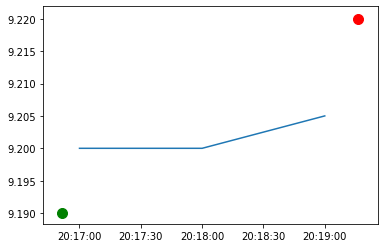

buy time:2020-02-18T20:16:51.538301002Z sell time:2020-02-18T20:19:16.336398385Z
{'rsi': 70.26499467362297, 'macd1': [0.013152384632709513, 0.017760332552375857, 0.019173849212487326, 0.022455962274255725, 0.026765811969095665], 'macd2': [0.01981913309823824, 0.020753451756432284, 0.021180022498327844, 0.022018414816242782, 0.02315438725297092], 'macd_signal': [0.014372344471760288, 0.015049942087883402, 0.01587472351280419, 0.017190971265094494, 0.01910593940589473]}
{'rsi': 74.06917431353376, 'macd': [0.013142311153050201, 0.0159409595624318, 0.01843417962737348, 0.020137543578920614, 0.022242274663517136], 'scalp': 0, 'bail_out': 1, 'movement': 0.0032644178454843457, 'too_close': 0, 'macd_signal': [0.009632571628954246, 0.010894249215649757, 0.012402235297994502, 0.013949296954179725, 0.015607892496047207], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00663438216746993}


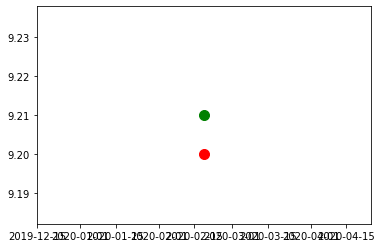

buy time:2020-02-18T20:19:48.838309306Z sell time:2020-02-18T20:19:50.313213358Z
{'rsi': 73.00744737837135, 'macd1': [0.022455962274255725, 0.026765811969095665, 0.030635172134921618, 0.03331760335162315, 0.03593298275671408], 'macd2': [0.022018414816242782, 0.02315438725297092, 0.0243224220502114, 0.025358151110687288, 0.026449626506014567], 'macd_signal': [0.017190971265094494, 0.01910593940589473, 0.021411785951700107, 0.023792949431684716, 0.02622095609669059]}
{'rsi': 72.20565494849481, 'macd': [0.013142311153050201, 0.0159409595624318, 0.01843417962737348, 0.020137543578920614, 0.021463053884296812], 'scalp': 0, 'bail_out': 0, 'movement': -0.000673093625151963, 'too_close': 0, 'macd_signal': [0.009632571628954246, 0.010894249215649757, 0.012402235297994502, 0.013949296954179725, 0.015452048340203143], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.006011005544093669}


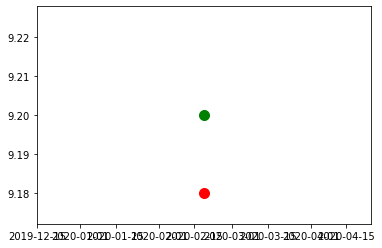

buy time:2020-02-18T20:20:02.580983225Z sell time:2020-02-18T20:20:08.93205099Z
{'rsi': 71.52350018416162, 'macd1': [0.022455962274255725, 0.026765811969095665, 0.030635172134921618, 0.03331760335162315, 0.03503953546326599], 'macd2': [0.022018414816242782, 0.02315438725297092, 0.0243224220502114, 0.025358151110687288, 0.026270498157353828], 'macd_signal': [0.017190971265094494, 0.01910593940589473, 0.021411785951700107, 0.023792949431684716, 0.026042266638000973]}
{'rsi': 65.4516470504107, 'macd': [0.0159409595624318, 0.01843417962737348, 0.020137543578920614, 0.021463053884296812, 0.02117821705881795], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016304347826085644, 'too_close': 0, 'macd_signal': [0.010894249215649757, 0.012402235297994502, 0.013949296954179725, 0.015452048340203143, 0.016597282083926104], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004580934974891846}


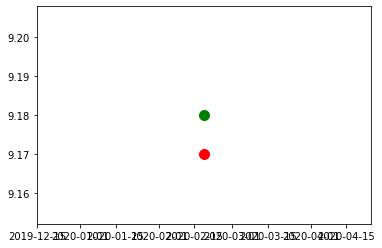

buy time:2020-02-18T20:20:39.519157009Z sell time:2020-02-18T20:20:42.746574408Z
{'rsi': 66.9867783562617, 'macd1': [0.026765811969095665, 0.030635172134921618, 0.03331760335162315, 0.03543839586212627, 0.03549157066822417], 'macd2': [0.02315438725297092, 0.0243224220502114, 0.025358151110687288, 0.02635046617014858, 0.026979780479281956], 'macd_signal': [0.01910593940589473, 0.021411785951700107, 0.023792949431684716, 0.02612203871777303, 0.027995945107863258]}
{'rsi': 62.5272927899952, 'macd': [0.0159409595624318, 0.01843417962737348, 0.020137543578920614, 0.021463053884296812, 0.020658736539338918], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016213451724174392, 'too_close': 0, 'macd_signal': [0.010894249215649757, 0.012402235297994502, 0.013949296954179725, 0.015452048340203143, 0.0164933859800303], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0041653505593086185}


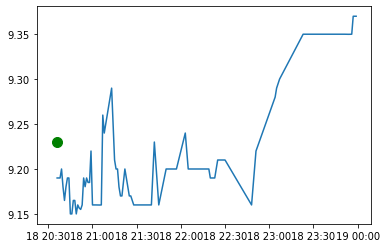

buy time:2020-02-18T20:35:43.088224518Z sell time:None
{'rsi': 72.15229472995557, 'macd1': [0.02282550718378218, 0.02233677528447231, 0.023294757126500087, 0.024976426579637945, 0.026009342230048915], 'macd2': [0.027991587427965925, 0.02804519044674869, 0.02836952462685005, 0.02886245339530369, 0.029269802168846226], 'macd_signal': [0.024741120014796617, 0.024260251068731756, 0.02406715228028542, 0.024249007140155925, 0.024601074158134523]}
None
BTG analysis for run 66


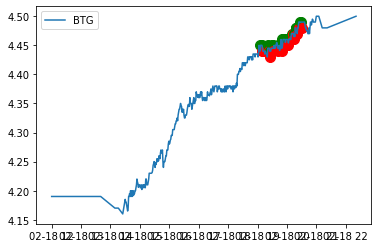

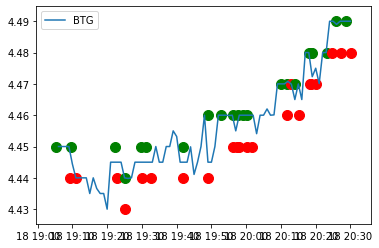

Delta = -0.20999999999999908


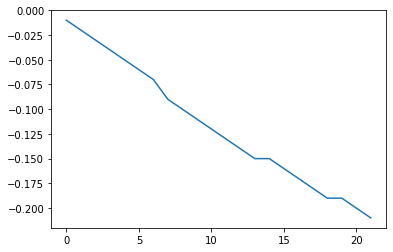

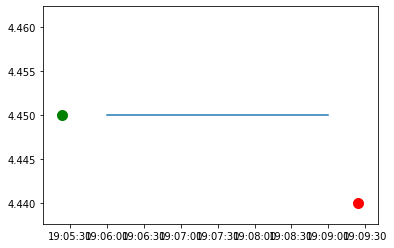

buy time:2020-02-18T19:05:23.017067354Z sell time:2020-02-18T19:09:24.007240284Z
{'rsi': 68.02866490716063, 'macd1': [0.004765804383586314, 0.004607900359538064, 0.005628255892154321, 0.005964679675347639, 0.006559146403771976], 'macd2': [0.008421709073640926, 0.008358692258892297, 0.008527250251787244, 0.008588722839009577, 0.008711511136427319], 'macd_signal': [0.005902712472354728, 0.005643750049791395, 0.005640651218263981, 0.005705456909680712, 0.005876194808498965]}
{'rsi': 59.42935911647342, 'macd': [0.0032160085674899364, 0.0035952522537519016, 0.003844075226764332, 0.0039880402027900885, 0.0037886877139436947], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011235955056179536, 'too_close': 1, 'macd_signal': [0.003156218718904532, 0.003244025425874006, 0.003364035386052071, 0.0034888363493996745, 0.0035488066223084785], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000239881091635216

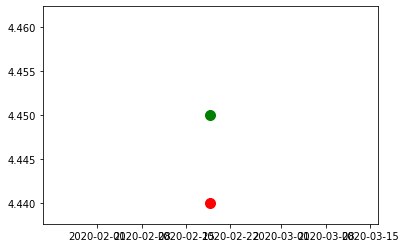

buy time:2020-02-18T19:09:27.71182839Z sell time:2020-02-18T19:10:56.781547357Z
{'rsi': 65.61792563573098, 'macd1': [0.005761425606051418, 0.006334244490720842, 0.006710849092776527, 0.00692943276569391, 0.007021719885322852], 'macd2': [0.008551575110837817, 0.008663656988900037, 0.008752919593244535, 0.008821044972782133, 0.008869614472352794], 'macd_signal': [0.005716650648954854, 0.005840169417308051, 0.006014305352401746, 0.006197330835060179, 0.0063622086451127135]}
{'rsi': 58.29592263169738, 'macd': [0.0035952522537519016, 0.003844075226764332, 0.0039880402027900885, 0.004048427973683211, 0.003751997301994159], 'scalp': 0, 'bail_out': 0, 'movement': -0.0012584269662921958, 'too_close': 1, 'macd_signal': [0.003244025425874006, 0.003364035386052071, 0.0034888363493996745, 0.003600754674256382, 0.003631003199803937], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0001209941021902217}


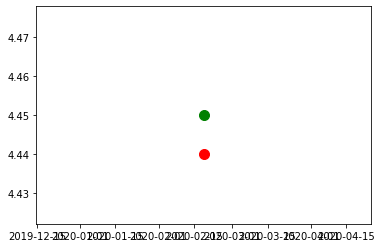

buy time:2020-02-18T19:22:20.637886185Z sell time:2020-02-18T19:22:47.495273846Z
{'rsi': 61.511204051196344, 'macd1': [0.0017402223011755424, 0.001268673103961504, 0.00048590751521615516, 0.0010636734212967625, 0.0019030777816588795], 'macd2': [0.007454012247105624, 0.007240015928271504, 0.006951585063276866, 0.00691500539090395, 0.006950259350242405], 'macd_signal': [0.003616236517681846, 0.0031467238349377775, 0.002614560570993453, 0.002304383141054115, 0.002224122069175068]}
{'rsi': 57.70261698504137, 'macd': [0.0006832388004935908, 0.00039477305411939057, -9.487263206953145e-05, 0.00030403816612167844, 0.0006109292015157308], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011235955056179536, 'too_close': 0, 'macd_signal': [0.001863216816703147, 0.0015695280641863957, 0.0012366479249352102, 0.0010501259731725038, 0.0009622866188411492], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00035

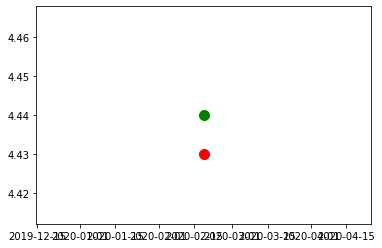

buy time:2020-02-18T19:25:14.534981191Z sell time:2020-02-18T19:25:15.873477707Z
{'rsi': 61.90014397514834, 'macd1': [0.00048590751521615516, 0.0010636734212967625, 0.0015042173827977123, 0.0018322308297538115, 0.002451247281588742], 'macd2': [0.006951585063276866, 0.00691500539090395, 0.006870291337447654, 0.006818164907078206, 0.00683607151407184], 'macd_signal': [0.002614560570993453, 0.002304383141054115, 0.0021443499894028347, 0.00208192615747303, 0.0021557903822961725]}
{'rsi': 46.26646481516609, 'macd': [0.00030403816612167844, 0.0006109292015157308, 0.0008421309277766298, 0.0010113513517753248, 0.0006105964698033262], 'scalp': 0, 'bail_out': 0, 'movement': -0.003325992179423827, 'too_close': 1, 'macd_signal': [0.0010501259731725038, 0.0009622866188411492, 0.0009382554806282454, 0.0009528746548576612, 0.0008844190178467941], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000273822

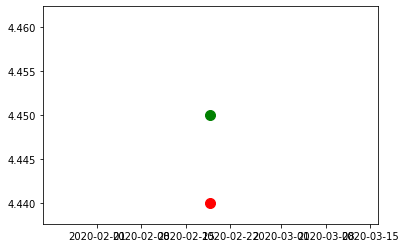

buy time:2020-02-18T19:29:51.842621431Z sell time:2020-02-18T19:30:02.590204677Z
{'rsi': 62.07591055371684, 'macd1': [0.0018308968934421799, 0.0016080456141978061, 0.001431076143401988, 0.0016749766874415428, 0.0022458392027147056], 'macd2': [0.006614368096345302, 0.006467246586935538, 0.006324745355628991, 0.006263492131054704, 0.006277087637544199], 'macd_signal': [0.002029546727260321, 0.0019452465046478182, 0.0018424124323986521, 0.0018089252834072303, 0.0018963080672687253]}
{'rsi': 57.18508962564876, 'macd': [0.0007387625209265281, 0.0006370324554998419, 0.0008092293856156729, 0.0009328993391388707, 0.001017149960857111], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011235955056179536, 'too_close': 0, 'macd_signal': [0.0008968461600210635, 0.0008448834191168192, 0.00083775261241659, 0.0008567819577610461, 0.000888855558380259], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0001282944

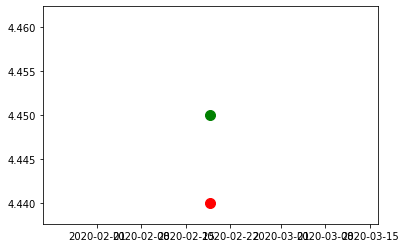

buy time:2020-02-18T19:31:08.188289048Z sell time:2020-02-18T19:32:32.494891364Z
{'rsi': 62.75562188392282, 'macd1': [0.001431076143401988, 0.0016749766874415428, 0.0018469788038553148, 0.001960690105274665, 0.0024262965083208243], 'macd2': [0.006324745355628991, 0.006263492131054704, 0.0061971196247494476, 0.006126143369048265, 0.006131013046040579], 'macd_signal': [0.0018424124323986521, 0.0018089252834072303, 0.001816535987496847, 0.0018453668110524108, 0.0019615527505060936]}
{'rsi': 63.02208263395654, 'macd': [0.0008092293856156729, 0.0009328993391388707, 0.001017149960857111, 0.0010695900562103233, 0.0013511071427689814], 'scalp': 0, 'bail_out': 0, 'movement': -2.247191011230718e-05, 'too_close': 0, 'macd_signal': [0.00083775261241659, 0.0008567819577610461, 0.000888855558380259, 0.0009250024579462719, 0.0010102233949108139], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0003408837

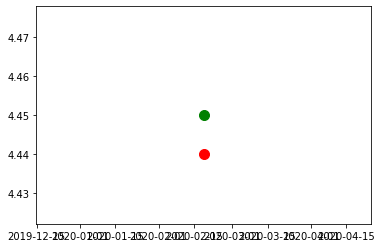

buy time:2020-02-18T19:41:49.275858994Z sell time:2020-02-18T19:41:50.314038822Z
{'rsi': 66.73563679328406, 'macd1': [0.0021680519764997186, 0.002440184247382682, 0.0026255849240302, 0.0031397810675688476, 0.003506860313160942], 'macd2': [0.00569577236668195, 0.005678622760409979, 0.00565376241052018, 0.005701815703307744, 0.005736907012340531], 'macd_signal': [0.0021081474100913635, 0.002174554777549627, 0.0022647608068457415, 0.002439764858990363, 0.0026531839498244785]}
{'rsi': 50.27206232513457, 'macd': [0.0013732591444881592, 0.0014969417641044203, 0.0018336172889474867, 0.0019786421487077988, 0.0016399778556808187], 'scalp': 0, 'bail_out': 0, 'movement': -0.00224466891133553, 'too_close': 1, 'macd_signal': [0.0011715231768798556, 0.0012366068943247687, 0.0013560089732493122, 0.0014805356083410096, 0.0015124240578089714], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000127553797871

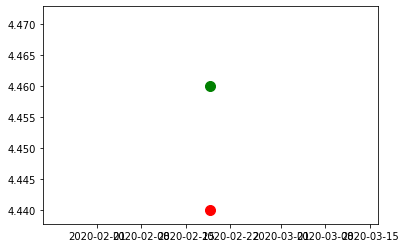

buy time:2020-02-18T19:48:58.724158159Z sell time:2020-02-18T19:49:02.437333061Z
{'rsi': 64.0273506725408, 'macd1': [0.0021151538531620773, 0.0014497286072385762, 0.001222974028726398, 0.0014302406805617451, 0.00237405084162301], 'macd2': [0.005259864815683635, 0.0050643358131043925, 0.004938718228863159, 0.004895215256349061, 0.005007297942963618], 'macd_signal': [0.00242370905219089, 0.0022289129632004274, 0.0020277251763056213, 0.0019082282771568462, 0.002001392790050079]}
{'rsi': 48.96499333231607, 'macd': [0.0007372866961850022, 0.0005945688615014433, 0.0007353787453654448, 0.001355030878956498, 0.0010410581144952857], 'scalp': 0, 'bail_out': 0, 'movement': -0.0033632286995514977, 'too_close': 1, 'macd_signal': [0.001235295941582372, 0.0011071505255661862, 0.0010327961695260378, 0.0010972431114121299, 0.001086006112028761], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -4.494799753347

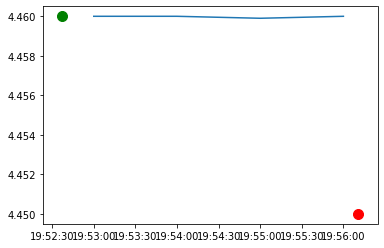

buy time:2020-02-18T19:52:37.118420243Z sell time:2020-02-18T19:56:10.220953236Z
{'rsi': 60.34034767392449, 'macd1': [0.00237405084162301, 0.0018898673399858623, 0.001488984341951216, 0.0015567941373149097, 0.0023899010238555007], 'macd2': [0.005007297942963618, 0.0048625050881563325, 0.004721514132833171, 0.0046642145547721725, 0.004763973376308073], 'macd_signal': [0.002001392790050079, 0.0019790877000372357, 0.0018810670284200317, 0.0018162124501990072, 0.0019309501649303058]}
{'rsi': 50.09172835710823, 'macd': [0.0013776793854374247, 0.0017855517145628497, 0.002080185325380235, 0.0022775597581548013, 0.0018874936050163882], 'scalp': 0, 'bail_out': 0, 'movement': -0.0022421524663676653, 'too_close': 1, 'macd_signal': [0.0010647852349722482, 0.0012089385308903685, 0.0013831878897883417, 0.0015620622634616335, 0.0016271485317725844], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0002603

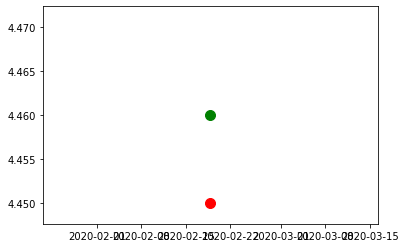

buy time:2020-02-18T19:56:13.498096179Z sell time:2020-02-18T19:57:24.415065645Z
{'rsi': 60.30696165413572, 'macd1': [0.0023899010238555007, 0.003015384755203243, 0.003471072752638804, 0.003780559670827799, 0.003987929083415942], 'macd2': [0.004763973376308073, 0.004848135373449303, 0.004917813187894637, 0.004972454290768091, 0.005016372467717467], 'macd_signal': [0.0019309501649303058, 0.0021478370829848934, 0.0024124842169156754, 0.0026860993076981, 0.0029464652628416682]}
{'rsi': 49.44711239731338, 'macd': [0.0017855517145628497, 0.002080185325380235, 0.0022775597581548013, 0.0024069741244971965, 0.0019570765641860888], 'scalp': 0, 'bail_out': 0, 'movement': -0.0022421524663676653, 'too_close': 1, 'macd_signal': [0.0012089385308903685, 0.0013831878897883417, 0.0015620622634616335, 0.001731044635668746, 0.0017762510213722147], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0001808255428

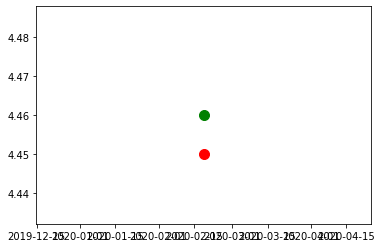

buy time:2020-02-18T19:57:40.687703732Z sell time:2020-02-18T19:57:51.440869208Z
{'rsi': 60.30696165413572, 'macd1': [0.003015384755203243, 0.003471072752638804, 0.003780559670827799, 0.003987929083415942, 0.004104951511131993], 'macd2': [0.004848135373449303, 0.004917813187894637, 0.004972454290768091, 0.005016372467717467, 0.005048755608576094], 'macd_signal': [0.0021478370829848934, 0.0024124842169156754, 0.0026860993076981, 0.0029464652628416682, 0.003178162512499733]}
{'rsi': 50.91405811916405, 'macd': [0.0017855517145628497, 0.002080185325380235, 0.0022775597581548013, 0.0024069741244971965, 0.002040193447303551], 'scalp': 0, 'bail_out': 0, 'movement': -0.0018834080717488706, 'too_close': 1, 'macd_signal': [0.0012089385308903685, 0.0013831878897883417, 0.0015620622634616335, 0.001731044635668746, 0.001792874397995707], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00024731904930784

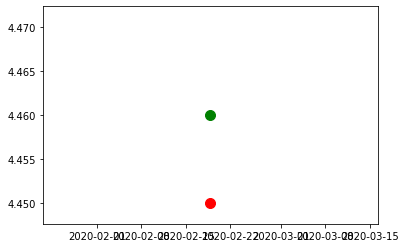

buy time:2020-02-18T19:59:03.208951996Z sell time:2020-02-18T20:00:15.589393903Z
{'rsi': 58.73671289865358, 'macd1': [0.003780559670827799, 0.003987929083415942, 0.0037060911122717144, 0.0038419036293264597, 0.0039045270699888945], 'macd2': [0.004972454290768091, 0.005016372467717467, 0.004968787595781343, 0.004997029122887575, 0.005015020181416752], 'macd_signal': [0.0026860993076981, 0.0029464652628416682, 0.0030983904327276774, 0.003247093072047434, 0.003378579871635726]}
{'rsi': 55.7482013298751, 'macd': [0.0024069741244971965, 0.0022168168239256048, 0.002299592734858358, 0.002334228603963595, 0.0022062276110075274], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005381165919281918, 'too_close': 1, 'macd_signal': [0.001731044635668746, 0.0018281990733201177, 0.0019224778056277658, 0.0020048279652949315, 0.0020451078944374508], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000161119716570

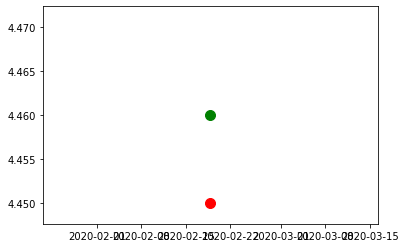

buy time:2020-02-18T20:00:18.587424319Z sell time:2020-02-18T20:01:35.085857302Z
{'rsi': 58.73671289865358, 'macd1': [0.003987929083415942, 0.0037060911122717144, 0.0038419036293264597, 0.0039045270699888945, 0.003909094984240191], 'macd2': [0.005016372467717467, 0.004968787595781343, 0.004997029122887575, 0.005015020181416752, 0.0050235517067855895], 'macd_signal': [0.0029464652628416682, 0.0030983904327276774, 0.003247093072047434, 0.003378579871635726, 0.0034846828941566188]}
{'rsi': 52.43072166044749, 'macd': [0.0022168168239256048, 0.002299592734858358, 0.002334228603963595, 0.0023309029356823885, 0.0020382997794152757], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011210762331838326, 'too_close': 1, 'macd_signal': [0.0018281990733201177, 0.0019224778056277658, 0.0020048279652949315, 0.002070042959372423, 0.0020636943233809935], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -2.539454396

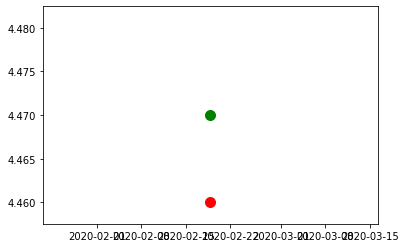

buy time:2020-02-18T20:10:03.787352854Z sell time:2020-02-18T20:11:41.408666419Z
{'rsi': 66.05314185499796, 'macd1': [0.003240002883822868, 0.003110564425899298, 0.0029816817089978187, 0.003636469532405151, 0.004108038687127724], 'macd2': [0.004873955042676847, 0.004838427479144869, 0.004799601955912003, 0.004914541605339551, 0.005012429636891191], 'macd_signal': [0.003369887204384898, 0.0033180226486877783, 0.003250754460749786, 0.003327897475080859, 0.003483925717490232]}
{'rsi': 57.84785975884117, 'macd': [0.0017841920766947794, 0.0016989573556029924, 0.0021247620228601605, 0.0024289635554914923, 0.0023539392490290467], 'scalp': 0, 'bail_out': 0, 'movement': -0.001208053691275134, 'too_close': 1, 'macd_signal': [0.0019324463248086548, 0.0018857485309675224, 0.00193355122934605, 0.0020326336945751386, 0.0020968948054659203], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000257044443563

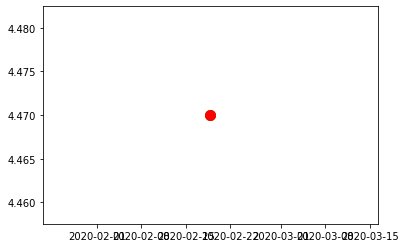

buy time:2020-02-18T20:11:48.159014855Z sell time:2020-02-18T20:12:53.482533807Z
{'rsi': 66.05314185499796, 'macd1': [0.003110564425899298, 0.0029816817089978187, 0.003636469532405151, 0.004108038687127724, 0.004430686444393039], 'macd2': [0.004838427479144869, 0.004799601955912003, 0.004914541605339551, 0.005012429636891191, 0.005094473076336925], 'macd_signal': [0.0033180226486877783, 0.003250754460749786, 0.003327897475080859, 0.003483925717490232, 0.0036732778628707934]}
{'rsi': 66.05314185499796, 'macd': [0.0016989573556029924, 0.0021247620228601605, 0.0024289635554914923, 0.0026344587295481503, 0.002760371089468805], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0018857485309675224, 0.00193355122934605, 0.0020326336945751386, 0.002152998701569741, 0.0022744731791495536], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0004858979103192513}


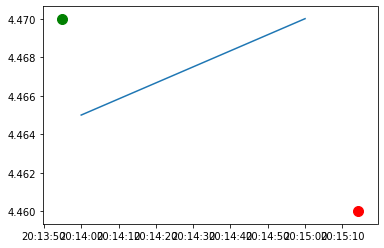

buy time:2020-02-18T20:13:54.741512458Z sell time:2020-02-18T20:15:14.252218177Z
{'rsi': 70.25957778688071, 'macd1': [0.0029816817089978187, 0.003636469532405151, 0.004108038687127724, 0.004430686444393039, 0.005031841394450787], 'macd2': [0.004799601955912003, 0.004914541605339551, 0.005012429636891191, 0.005094473076336925, 0.00524177577999918], 'macd_signal': [0.003250754460749786, 0.003327897475080859, 0.003483925717490232, 0.0036732778628707934, 0.003944990569186792]}
{'rsi': 56.42224877909516, 'macd': [0.0026344587295481503, 0.002801929531027092, 0.0028492843174907634, 0.00259463500411794, 0.0023625104092293014], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011409140735107823, 'too_close': 1, 'macd_signal': [0.002152998701569741, 0.002282784867461211, 0.0023960847574671213, 0.002435794806797285, 0.0024211379272836885], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -5.862751805438705e-0

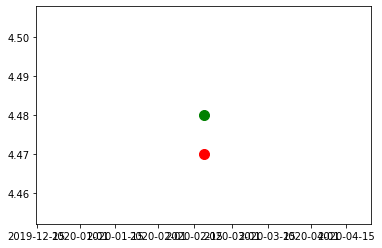

buy time:2020-02-18T20:18:04.098598608Z sell time:2020-02-18T20:18:19.830538702Z
{'rsi': 67.25474938334817, 'macd1': [0.004399779592971775, 0.004450628906925935, 0.004040888296412248, 0.004870397638073065, 0.005464795012445123], 'macd2': [0.005185896756428221, 0.005220992602779084, 0.005164963643180087, 0.005345058608949849, 0.005502203063888267], 'macd_signal': [0.004126659851623218, 0.0041914536626837615, 0.004161340589429459, 0.00430315199915818, 0.0045354806018155685]}
{'rsi': 67.11965097516736, 'macd': [0.00259463500411794, 0.0026222506689688174, 0.002349973905618974, 0.0028865118315080096, 0.0032619113603624683], 'scalp': 0, 'bail_out': 0, 'movement': -2.2321428571574803e-05, 'too_close': 0, 'macd_signal': [0.002435794806797285, 0.0024730859792315915, 0.002448463564509068, 0.0025360732179088566, 0.002681240846399579], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000580670513962889

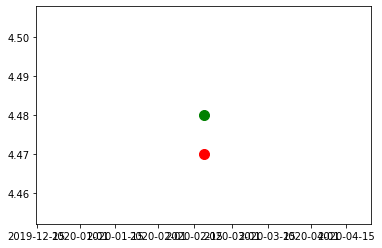

buy time:2020-02-18T20:18:34.321192838Z sell time:2020-02-18T20:18:44.878132124Z
{'rsi': 67.25474938334817, 'macd1': [0.004399779592971775, 0.004450628906925935, 0.004040888296412248, 0.004870397638073065, 0.005464795012445123], 'macd2': [0.005185896756428221, 0.005220992602779084, 0.005164963643180087, 0.005345058608949849, 0.005502203063888267], 'macd_signal': [0.004126659851623218, 0.0041914536626837615, 0.004161340589429459, 0.00430315199915818, 0.0045354806018155685]}
{'rsi': 61.105130228888235, 'macd': [0.00259463500411794, 0.0026222506689688174, 0.002349973905618974, 0.0028865118315080096, 0.003007365905816961], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011160714285716028, 'too_close': 0, 'macd_signal': [0.002435794806797285, 0.0024730859792315915, 0.002448463564509068, 0.0025360732179088566, 0.0026303317554904775], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000377034150326483

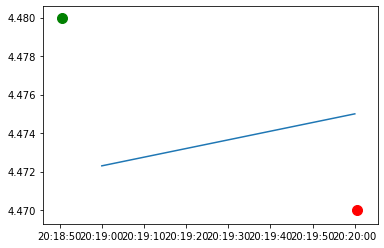

buy time:2020-02-18T20:18:50.574600274Z sell time:2020-02-18T20:20:00.615414626Z
{'rsi': 67.25474938334817, 'macd1': [0.004399779592971775, 0.004450628906925935, 0.004040888296412248, 0.004870397638073065, 0.005464795012445123], 'macd2': [0.005185896756428221, 0.005220992602779084, 0.005164963643180087, 0.005345058608949849, 0.005502203063888267], 'macd_signal': [0.004126659851623218, 0.0041914536626837615, 0.004161340589429459, 0.00430315199915818, 0.0045354806018155685]}
{'rsi': 57.63502865045393, 'macd': [0.0026222506689688174, 0.002349973905618974, 0.0028865118315080096, 0.0032671061655582534, 0.0031212432289011716], 'scalp': 0, 'bail_out': 0, 'movement': -0.0017187500000001574, 'too_close': 1, 'macd_signal': [0.0024730859792315915, 0.002448463564509068, 0.0025360732179088566, 0.0026822798074387358, 0.0027700724917312227], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000351170737169

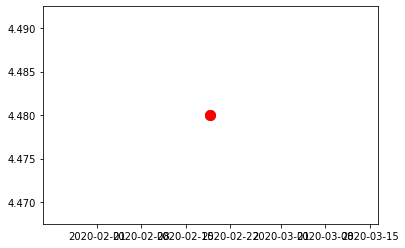

buy time:2020-02-18T20:23:06.360831379Z sell time:2020-02-18T20:24:37.530501052Z
{'rsi': 61.906937950251454, 'macd1': [0.005253969080542653, 0.005244302392237721, 0.0047860814553351005, 0.005162277798726578, 0.005398189146982091], 'macd2': [0.005514830244439217, 0.005560810181052034, 0.0055158508021726504, 0.005624001568262038, 0.005714508927917805], 'macd_signal': [0.004679178297560985, 0.004792203116496333, 0.004790978784264086, 0.004865238587156585, 0.004971828699121686]}
{'rsi': 61.90693795025144, 'macd': [0.003107307911649926, 0.0028015491201340836, 0.003041197475834423, 0.003188440383187441, 0.0032617667995245014], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0028375195757149633, 0.002830325484598787, 0.002872499882845914, 0.0029356879829142194, 0.003000903746236276], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00026086305328822546}


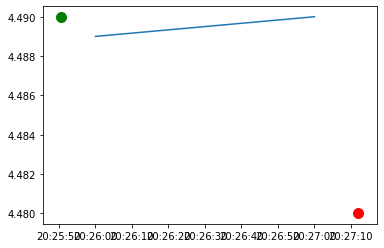

buy time:2020-02-18T20:25:50.665775716Z sell time:2020-02-18T20:27:11.901500257Z
{'rsi': 68.08774047810938, 'macd1': [0.0047860814553351005, 0.005162277798726578, 0.005398189146982091, 0.006319222948071079, 0.0069688166902572846], 'macd2': [0.0055158508021726504, 0.005624001568262038, 0.005714508927917805, 0.005948575061006878, 0.006154409476038403], 'macd_signal': [0.004790978784264086, 0.004865238587156585, 0.004971828699121686, 0.005241307548911564, 0.005586809377180708]}
{'rsi': 56.682842167903566, 'macd': [0.003188440383187441, 0.003781247319006198, 0.004194067693422454, 0.0044093294437024255, 0.00405226938620995], 'scalp': 0, 'bail_out': 0, 'movement': -0.0022271714922048524, 'too_close': 1, 'macd_signal': [0.0029356879829142194, 0.003104799850132615, 0.003322653418790583, 0.0035399886237729517, 0.0036424447762603515], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00040982460994959

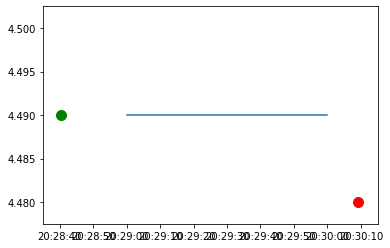

buy time:2020-02-18T20:28:40.511689903Z sell time:2020-02-18T20:30:09.061917602Z
{'rsi': 67.47705927279614, 'macd1': [0.006319222948071079, 0.0069688166902572846, 0.007318568862166863, 0.007588960804691958, 0.007714322459893452], 'macd2': [0.005948575061006878, 0.006154409476038403, 0.006317947001462265, 0.006474295685186426, 0.006607786744166511], 'macd_signal': [0.005241307548911564, 0.005586809377180708, 0.005933161274177939, 0.006264321180280743, 0.006554321436203285]}
{'rsi': 60.151011424228344, 'macd': [0.0044093294437024255, 0.0045717499056907585, 0.004638937929244413, 0.0046310462861791635, 0.004305013235918587], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011135857461024262, 'too_close': 1, 'macd_signal': [0.0035399886237729517, 0.003746340880156513, 0.003924860289974093, 0.004066097489215107, 0.004113880638555803], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000191132597362783

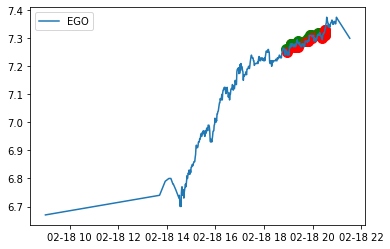

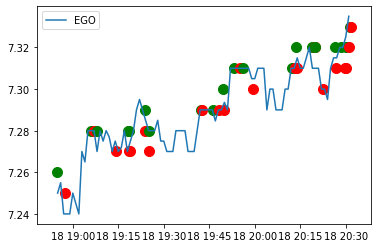

Delta = -0.140000000000005


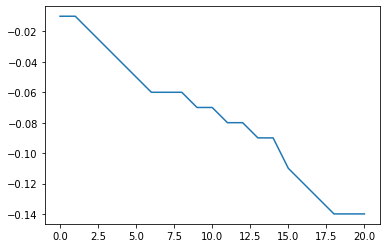

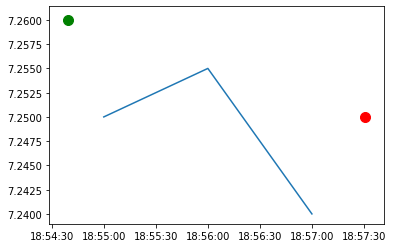

buy time:2020-02-18T18:54:39.341067912Z sell time:2020-02-18T18:57:30.519807742Z
{'rsi': 60.17444665646402, 'macd1': [0.009648299676081606, 0.008882370264334583, 0.007383338727902533, 0.007720184803599928, 0.00789611623266584], 'macd2': [0.007520499900812716, 0.007501806845964687, 0.007312674520259854, 0.00744684318098443, 0.007558372455514828], 'macd_signal': [0.006633892071623077, 0.0070835877101653785, 0.0071435379137128096, 0.007258867291690233, 0.007386317079885354]}
{'rsi': 56.11057297416075, 'macd': [0.004735222830128727, 0.00482571219413952, 0.0043140712804579096, 0.004119103409011338, 0.003913685542832113], 'scalp': 0, 'bail_out': 0, 'movement': -0.000688705234159765, 'too_close': 1, 'macd_signal': [0.004533663932079412, 0.004592073584491434, 0.004536473123684729, 0.004452999180750051, 0.004345136453166464], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0004314509103343512}


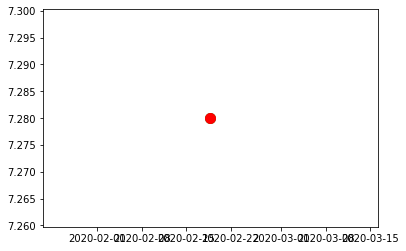

buy time:2020-02-18T19:05:59.13108813Z sell time:2020-02-18T19:06:53.00165595Z
{'rsi': 64.34706488003073, 'macd1': [0.0026709804272142534, 0.0018840548507226274, 0.003639209400756016, 0.004573997616301284, 0.0064508374134799595], 'macd2': [0.006559292577505538, 0.0063310302554340225, 0.006590704096254285, 0.006739103413063496, 0.007104761315633645], 'macd_signal': [0.0046806798275087266, 0.004121354832151506, 0.0040249257458724085, 0.004134740119958184, 0.0045979595786625384]}
{'rsi': 64.34706488003073, 'macd': [0.0008502131931535928, 0.002003058327757934, 0.0026156252076088293, 0.003838201669731589, 0.004741011878272694], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0023323526944556017, 0.002266493821116068, 0.0023363200984146204, 0.002636696412678014, 0.00305755950579695], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001683452372475744}


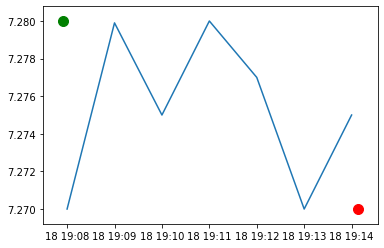

buy time:2020-02-18T19:07:54.61934469Z sell time:2020-02-18T19:14:07.730809092Z
{'rsi': 64.8483923900631, 'macd1': [0.003639209400756016, 0.004573997616301284, 0.0064508374134799595, 0.007847782127354819, 0.00896450197865395], 'macd2': [0.006590704096254285, 0.006739103413063496, 0.007104761315633645, 0.007429815209495594, 0.007739383281842649], 'macd_signal': [0.0040249257458724085, 0.004134740119958184, 0.0045979595786625384, 0.005247924088400994, 0.0059912396664515855]}
{'rsi': 54.838094406515324, 'macd': [0.005634604317081404, 0.0057937665461542665, 0.005686701185092957, 0.005165784005238372, 0.00469798121567333], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015518993600131049, 'too_close': 1, 'macd_signal': [0.0045152703327844814, 0.004770969575458439, 0.0049541158973853425, 0.0049964495189559486, 0.004936755858299425], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000238774642626094

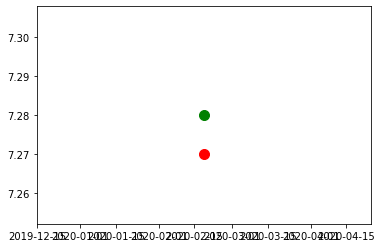

buy time:2020-02-18T19:18:10.44787208Z sell time:2020-02-18T19:18:30.132521678Z
{'rsi': 59.1796588949225, 'macd1': [0.00838177728296241, 0.00764865028409023, 0.007138665880026984, 0.007303906977925934, 0.007350133969408645], 'macd2': [0.008447320074715492, 0.008388657423483714, 0.008351657267475332, 0.008433806812439215, 0.0084958983261183], 'macd_signal': [0.008345118527003278, 0.008205824878420668, 0.007992393078741932, 0.007854695858578732, 0.007753783480744715]}
{'rsi': 53.48252377233298, 'macd': [0.004952526670217949, 0.004462293335524947, 0.004121042771666694, 0.004222392426171062, 0.00378938706051013], 'scalp': 0, 'bail_out': 0, 'movement': -0.0012087912087911977, 'too_close': 1, 'macd_signal': [0.004987664949208348, 0.004882590626471668, 0.0047302810555106736, 0.004628703329642751, 0.004460840075816227], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006714530153060973}


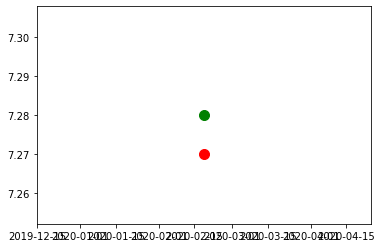

buy time:2020-02-18T19:18:35.97654852Z sell time:2020-02-18T19:18:45.311017154Z
{'rsi': 59.1796588949225, 'macd1': [0.00838177728296241, 0.00764865028409023, 0.007138665880026984, 0.007303906977925934, 0.007350133969408645], 'macd2': [0.008447320074715492, 0.008388657423483714, 0.008351657267475332, 0.008433806812439215, 0.0084958983261183], 'macd_signal': [0.008345118527003278, 0.008205824878420668, 0.007992393078741932, 0.007854695858578732, 0.007753783480744715]}
{'rsi': 52.78952826767011, 'macd': [0.004952526670217949, 0.004462293335524947, 0.004121042771666694, 0.004222392426171062, 0.003727049398171367], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013736263736264663, 'too_close': 1, 'macd_signal': [0.004987664949208348, 0.004882590626471668, 0.0047302810555106736, 0.004628703329642751, 0.004448372543348475], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007213231451771076}


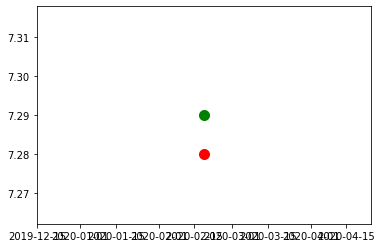

buy time:2020-02-18T19:23:56.829527552Z sell time:2020-02-18T19:23:57.690921084Z
{'rsi': 64.45631187112579, 'macd1': [0.006552413171688087, 0.006287824996753066, 0.006407730842638237, 0.007226372393201785, 0.008184266800132178], 'macd2': [0.008335962300529687, 0.008312578025797102, 0.00835773695092179, 0.008545853599825293, 0.008785227048336175], 'macd_signal': [0.0075942393212006035, 0.007332956456311096, 0.007147911333576525, 0.007163603545501577, 0.007367736196427698]}
{'rsi': 54.780222027079084, 'macd': [0.0035524048387154394, 0.003629923300974447, 0.004162665955968592, 0.004783469765627046, 0.004425869230741952], 'scalp': 0, 'bail_out': 0, 'movement': -0.0020562028786839863, 'too_close': 1, 'macd_signal': [0.004269179002421868, 0.004141327862132384, 0.004145595480899626, 0.00427317033784511, 0.004303710116424478], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00012215911431747405}


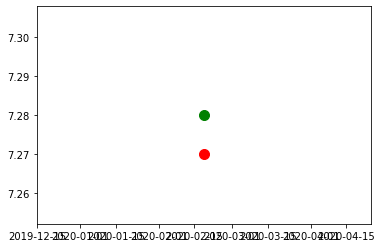

buy time:2020-02-18T19:25:14.837013408Z sell time:2020-02-18T19:25:16.180550145Z
{'rsi': 60.7994447069395, 'macd1': [0.006407730842638237, 0.007226372393201785, 0.008184266800132178, 0.008442625474506471, 0.008540853775231838], 'macd2': [0.00835773695092179, 0.008545853599825293, 0.008785227048336175, 0.008911439522079512, 0.009011707072657416], 'macd_signal': [0.007147911333576525, 0.007163603545501577, 0.007367736196427698, 0.007582714052043452, 0.007774341996681129]}
{'rsi': 51.202322470529296, 'macd': [0.004162665955968592, 0.004783469765627046, 0.004945349750221872, 0.004747524416787385, 0.004012238125580936], 'scalp': 0, 'bail_out': 0, 'movement': -0.0020439237849627446, 'too_close': 1, 'macd_signal': [0.004145595480899626, 0.00427317033784511, 0.004407606220320463, 0.004475589859613847, 0.004382919512807265], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00037068138722632944}


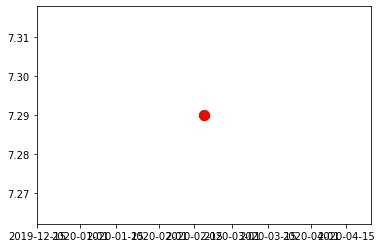

buy time:2020-02-18T19:42:22.719803102Z sell time:2020-02-18T19:42:43.395409795Z
{'rsi': 61.707868373086875, 'macd1': [0.0012969018570112567, 0.0006691400518343826, 0.0001696783520310774, 0.0005741493467494863, 0.00168222036145238], 'macd2': [0.006906807421084515, 0.006656940065303374, 0.006416407260060986, 0.006344783264097487, 0.006428675328164601], 'macd_signal': [0.002584237901354536, 0.002201218331450505, 0.0017949103355666195, 0.0015507581378031929, 0.0015770505825330303]}
{'rsi': 61.707868373086875, 'macd': [0.0004326940769656673, 4.413635538380589e-05, -0.00025920909461962793, 2.7264698814200017e-05, 0.0007696174638427422], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0012086701401646878, 0.0009757633832085114, 0.0007287688876428835, 0.0005884680498771469, 0.0006246979326702659], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0001449195311724763}


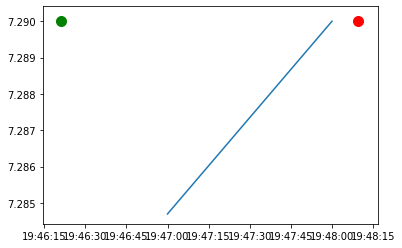

buy time:2020-02-18T19:46:21.050909973Z sell time:2020-02-18T19:48:09.45500271Z
{'rsi': 61.70786837308686, 'macd1': [0.0005741493467494863, 0.00168222036145238, 0.0025311965654335467, 0.0031675033170941447, 0.003629937343983869], 'macd2': [0.006344783264097487, 0.006428675328164601, 0.006495576942761261, 0.006546739800584511, 0.006583340670895943], 'macd_signal': [0.0015507581378031929, 0.0015770505825330303, 0.0017678797791131336, 0.002047804486709336, 0.0023642310581642426]}
{'rsi': 61.70786837308686, 'macd': [0.0013380791318677865, 0.0017636586247196107, 0.002072374351296702, 0.002286018107703569, 0.0024228052151933355], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.0007673741725097701, 0.0009666310629517381, 0.001187779720620731, 0.0014074273980372986, 0.001610502961468506], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0008123022537248295}


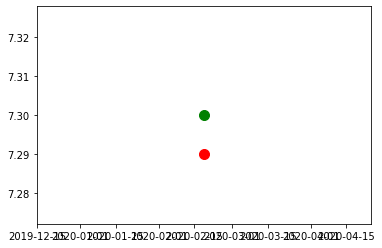

buy time:2020-02-18T19:49:24.281637586Z sell time:2020-02-18T19:49:44.605184917Z
{'rsi': 66.69257545988305, 'macd1': [0.003629937343983869, 0.003950876398168823, 0.0037345081198445484, 0.003945222339164722, 0.004863072826220005], 'macd2': [0.006583340670895943, 0.006606485508921622, 0.0065324472563270675, 0.006538648052710094, 0.006693831355495838], 'macd_signal': [0.0023642310581642426, 0.0026815601261651585, 0.0028921497249010364, 0.0031027642477537737, 0.00345482596344702]}
{'rsi': 59.761108148514396, 'macd': [0.002072374351296702, 0.002286018107703569, 0.0021474805398682406, 0.002286964505971767, 0.0023659524729886527], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013698630136986009, 'too_close': 1, 'macd_signal': [0.001187779720620731, 0.0014074273980372986, 0.001555438026403487, 0.001701743322317143, 0.0018345851524514448], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00053136732053

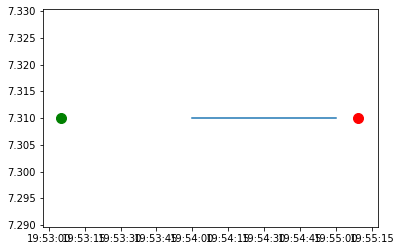

buy time:2020-02-18T19:53:04.931580444Z sell time:2020-02-18T19:55:09.171575296Z
{'rsi': 71.00424948758577, 'macd1': [0.004065352028499447, 0.004400321420103381, 0.004325436226401358, 0.005812914365508348, 0.006912073427595367], 'macd2': [0.006533895329906336, 0.006576649589606021, 0.0065478894749366745, 0.006830828866477567, 0.007080217200931216], 'macd_signal': [0.0032952818039029084, 0.003516289727143003, 0.003678119026994674, 0.004105078094697409, 0.004666477161277]}
{'rsi': 71.00424948758577, 'macd': [0.0025837878697156924, 0.002532961063662853, 0.0034994212009769043, 0.004207059993675877, 0.004703829702354945], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0019844256959042944, 0.002094132769456006, 0.0023751904557601858, 0.002741564363343324, 0.003134017431145648], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0015698122712092966}


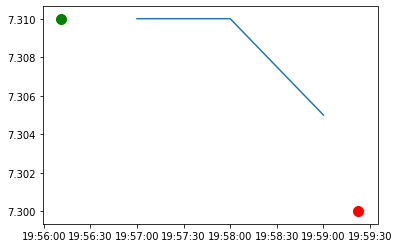

buy time:2020-02-18T19:56:11.150801385Z sell time:2020-02-18T19:59:22.173910472Z
{'rsi': 73.54867619284417, 'macd1': [0.004325436226401358, 0.005812914365508348, 0.006912073427595367, 0.007694467867376709, 0.008618629119428789], 'macd2': [0.0065478894749366745, 0.006830828866477567, 0.007080217200931216, 0.007298338627871104, 0.007567312657809744], 'macd_signal': [0.003678119026994674, 0.004105078094697409, 0.004666477161277, 0.005272075302496942, 0.005941386065883311]}
{'rsi': 62.86987995843256, 'macd': [0.005029834284411727, 0.00521854130569821, 0.005297812474158725, 0.005290779456411876, 0.004956847501589756], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013670539986330383, 'too_close': 1, 'macd_signal': [0.0035131808017988637, 0.003854252902578733, 0.004142964816894731, 0.00437252774479816, 0.004489391696156479], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0004674558054332768}


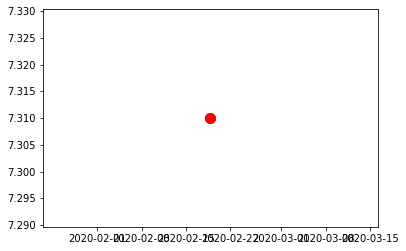

buy time:2020-02-18T20:12:19.338363216Z sell time:2020-02-18T20:13:10.740926849Z
{'rsi': 60.68081068174782, 'macd1': [0.0018560734635055809, 0.0009997369718997007, 0.0011151458520153312, 0.0011928576999462592, 0.002037870028668287], 'macd2': [0.006904192058557079, 0.006632703555556674, 0.006532253391772436, 0.006429388601514319, 0.006484402821111068], 'macd_signal': [0.004790541486854476, 0.00403238058386352, 0.0034489336374938827, 0.002997718449984358, 0.002805748765721144]}
{'rsi': 60.68081068174782, 'macd': [0.0007507141418914287, 0.00020767466877291696, 0.00030131047324211124, 0.00037036031473469677, 0.0009388360312900801], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0026738145732465536, 0.0021805865923518264, 0.0018047313685298834, 0.0015178571577708461, 0.001402052932474693], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00046321690118461285}


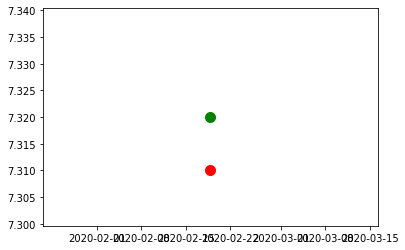

buy time:2020-02-18T20:13:44.354538707Z sell time:2020-02-18T20:14:01.490385162Z
{'rsi': 66.54803714474309, 'macd1': [0.0009997369718997007, 0.0011151458520153312, 0.0011928576999462592, 0.002037870028668287, 0.0034744139326106094], 'macd2': [0.006632703555556674, 0.006532253391772436, 0.006429388601514319, 0.006484402821111068, 0.006684582792325422], 'macd_signal': [0.00403238058386352, 0.0034489336374938827, 0.002997718449984358, 0.002805748765721144, 0.002939481799099037]}
{'rsi': 60.68081068174782, 'macd': [0.00020767466877291696, 0.00030131047324211124, 0.00037036031473469677, 0.0009388360312900801, 0.0013696114463819242], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013661202185793271, 'too_close': 0, 'macd_signal': [0.0021805865923518264, 0.0018047313685298834, 0.0015178571577708461, 0.001402052932474693, 0.001395564635256139], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -2.59531888

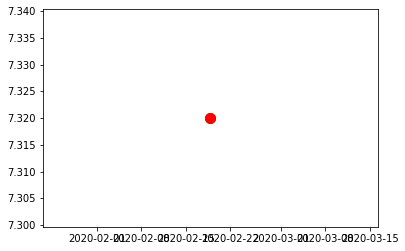

buy time:2020-02-18T20:18:59.971027318Z sell time:2020-02-18T20:19:42.494840271Z
{'rsi': 65.65908326207219, 'macd1': [0.003545552341931213, 0.0037870169361431394, 0.0039330417101135495, 0.004401487995018272, 0.005117205306610195], 'macd2': [0.006631205236073079, 0.006638668737473985, 0.006634917774568372, 0.006700823157717473, 0.0068307092008979], 'macd_signal': [0.0029330605800301827, 0.003103851851252774, 0.003269689823024929, 0.0034960494574235975, 0.003820280627260917]}
{'rsi': 65.6590832620722, 'macd': [0.0021122999518752295, 0.002213490539079821, 0.002523333976653497, 0.002991740110131147, 0.0033178781347880104], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0016271787487946185, 0.001744441106851659, 0.0019002196808120266, 0.0021185237666758506, 0.0023583946402982825], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009594834944897279}


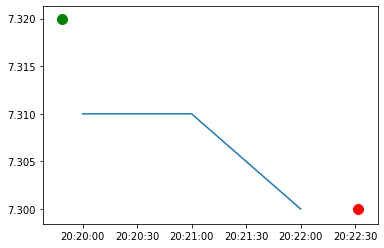

buy time:2020-02-18T20:19:48.488433265Z sell time:2020-02-18T20:22:31.754851658Z
{'rsi': 65.6590832620722, 'macd1': [0.0037870169361431394, 0.0039330417101135495, 0.004401487995018272, 0.005117205306610195, 0.0056196367580669815], 'macd2': [0.006638668737473985, 0.006634917774568372, 0.006700823157717473, 0.0068307092008979, 0.006939283750500458], 'macd_signal': [0.003103851851252774, 0.003269689823024929, 0.0034960494574235975, 0.003820280627260917, 0.00418015185342213]}
{'rsi': 46.01286809025768, 'macd': [0.002991740110131147, 0.002798397615307202, 0.0026113982996607277, 0.002431770283576995, 0.0017407384491798794], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013679890560875222, 'too_close': 1, 'macd_signal': [0.0021185237666758506, 0.002254498536402121, 0.002325878489053842, 0.0023470568479584727, 0.002225793168202754], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0004850547190228746

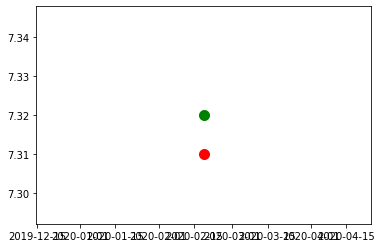

buy time:2020-02-18T20:26:29.314192659Z sell time:2020-02-18T20:26:38.753966084Z
{'rsi': 60.995709249274874, 'macd1': [0.003197112173794814, 0.0023282332422720486, 0.001222094669229179, 0.0015381160758858314, 0.002565903604452302], 'macd2': [0.006427400585837795, 0.006205835801201154, 0.005912095732166556, 0.005872293940172746, 0.005986219130441839], 'macd_signal': [0.0039600703477762865, 0.003633702926675439, 0.003151381275186187, 0.002828728235326116, 0.0027761633091513533]}
{'rsi': 54.802686925554, 'macd': [0.0017407384491798794, 0.0011796650918682872, 0.00046740448757542907, 0.0006855468155597677, 0.0008466246449554404], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013661202185793271, 'too_close': 0, 'macd_signal': [0.002225793168202754, 0.0020165675529358607, 0.0017067349398637744, 0.0015024973150029731, 0.0013713227809934666], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0005246981

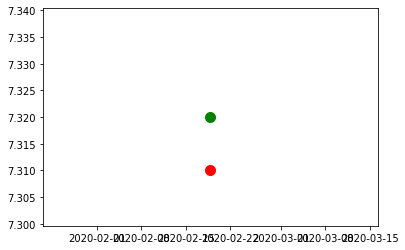

buy time:2020-02-18T20:28:28.299646459Z sell time:2020-02-18T20:29:41.900546745Z
{'rsi': 61.41800986797297, 'macd1': [0.001222094669229179, 0.0015381160758858314, 0.002167043205592911, 0.002635096732221953, 0.0033706361421765862], 'macd2': [0.005912095732166556, 0.005872293940172746, 0.005906251117647088, 0.005928046583819402, 0.006018586040567264], 'macd_signal': [0.003151381275186187, 0.002828728235326116, 0.0026963912293794753, 0.002684132329947971, 0.002821433092393694]}
{'rsi': 55.6694017003416, 'macd': [0.0006855468155597677, 0.0011063649046967328, 0.0014199067286382316, 0.0019055249456236822, 0.0019422985569681472], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008333333333333325, 'too_close': 1, 'macd_signal': [0.0015024973150029731, 0.001423270832941725, 0.0014225980120810265, 0.0015191833987895577, 0.0016038064304252757], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0003384921265

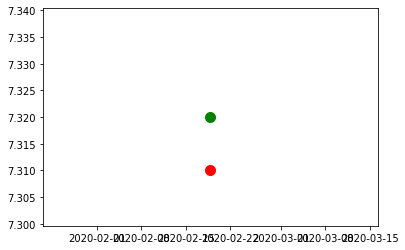

buy time:2020-02-18T20:29:56.439949035Z sell time:2020-02-18T20:30:04.481058795Z
{'rsi': 61.41800986797297, 'macd1': [0.0015381160758858314, 0.002167043205592911, 0.002635096732221953, 0.0033706361421765862, 0.003908501649780405], 'macd2': [0.005872293940172746, 0.005906251117647088, 0.005928046583819402, 0.006018586040567264, 0.006092259349570028], 'macd_signal': [0.002828728235326116, 0.0026963912293794753, 0.002684132329947971, 0.002821433092393694, 0.003038846803871036]}
{'rsi': 56.28725705443727, 'macd': [0.0011063649046967328, 0.0014199067286382316, 0.0019055249456236822, 0.002259181673850641, 0.002245678063717449], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006830601092896028, 'too_close': 1, 'macd_signal': [0.001423270832941725, 0.0014225980120810265, 0.0015191833987895577, 0.0016671830538017743, 0.0017828820557849092], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00046279600793

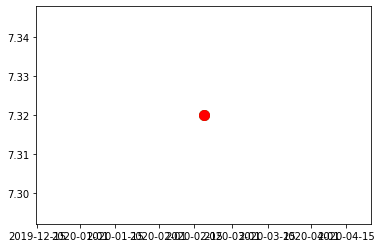

buy time:2020-02-18T20:30:20.820482532Z sell time:2020-02-18T20:30:56.077606256Z
{'rsi': 61.418009867972955, 'macd1': [0.002167043205592911, 0.002635096732221953, 0.0033706361421765862, 0.003908501649780405, 0.004285364920412427], 'macd2': [0.005906251117647088, 0.005928046583819402, 0.006018586040567264, 0.006092259349570028, 0.00615029743298301], 'macd_signal': [0.0026963912293794753, 0.002684132329947971, 0.002821433092393694, 0.003038846803871036, 0.003288150427179314]}
{'rsi': 61.418009867972955, 'macd': [0.0011063649046967328, 0.0014199067286382316, 0.0019055249456236822, 0.002259181673850641, 0.0025054183234587413], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.001423270832941725, 0.0014225980120810265, 0.0015191833987895577, 0.0016671830538017743, 0.0018348301077331676], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0006705882157255736}


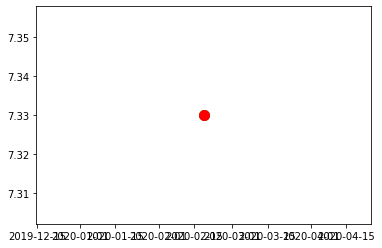

buy time:2020-02-18T20:31:25.329056246Z sell time:2020-02-18T20:31:47.386948762Z
{'rsi': 67.5595618209857, 'macd1': [0.002635096732221953, 0.0033706361421765862, 0.003908501649780405, 0.004684225319273594, 0.005637464942730652], 'macd2': [0.005928046583819402, 0.006018586040567264, 0.006092259349570028, 0.006230265445778649, 0.00642723904257636], 'macd_signal': [0.002684132329947971, 0.002821433092393694, 0.003038846803871036, 0.0033679225069515478, 0.0038218309941073685]}
{'rsi': 67.5595618209857, 'macd': [0.0014199067286382316, 0.0019055249456236822, 0.002259181673850641, 0.0027651585831982572, 0.0033832554140769133], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0014225980120810265, 0.0015191833987895577, 0.0016671830538017743, 0.0018867781596810709, 0.0021860736105602393], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001197181803516674}
VG analysis fo

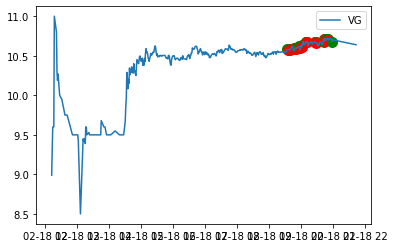

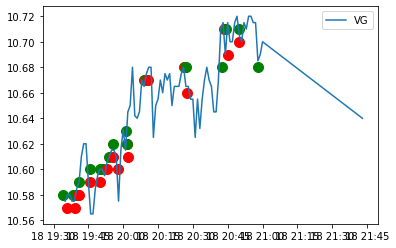

Delta = nan


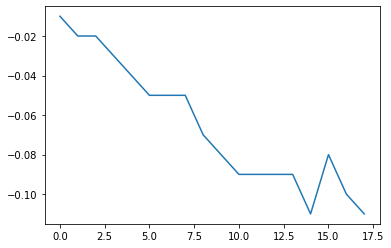

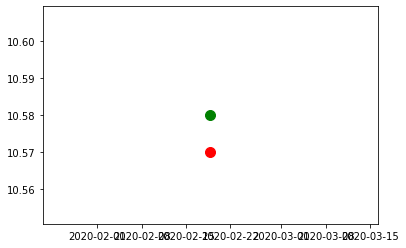

buy time:2020-02-18T19:34:03.048687723Z sell time:2020-02-18T19:35:56.968331251Z
{'rsi': 69.06518539479825, 'macd1': [0.00459050051111376, 0.004426048217926137, 0.0042467645327466386, 0.006052205924325094, 0.007796614924288292], 'macd2': [0.001307520395252837, 0.0014218440197577564, 0.0015247513703808835, 0.0020168308619048503, 0.0025463021080263104], 'macd_signal': [0.005422423499149938, 0.005223148442905178, 0.00502787166087347, 0.005232738513563795, 0.005745513795708694]}
{'rsi': 63.16656038753485, 'macd': [0.002558320263613467, 0.002435547204109767, 0.0036069507005471735, 0.00447288913023236, 0.004829816619203342], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009451795841209628, 'too_close': 0, 'macd_signal': [0.0031482673386079322, 0.003005723311708299, 0.0031259687894760737, 0.003395352857627331, 0.0036822456099425333], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001147571009260808

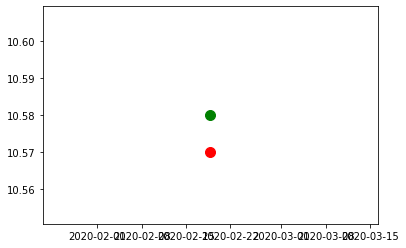

buy time:2020-02-18T19:38:11.859341444Z sell time:2020-02-18T19:39:05.158943997Z
{'rsi': 69.340725078386, 'macd1': [0.007397754525428013, 0.008367654375005529, 0.009431049933791513, 0.010156718249833219, 0.010609515725366947], 'macd2': [0.0024663340952315593, 0.0028759468915140474, 0.0033281721041014123, 0.0037389108189156417, 0.004110823709563505], 'macd_signal': [0.005665741715936638, 0.006206124247750416, 0.0068511093849586355, 0.007512231157933552, 0.00813168807142023]}
{'rsi': 64.50365234497401, 'macd': [0.005089556878942858, 0.0057637193210702264, 0.006214187206870392, 0.006224757154157601, 0.006152152474717454], 'scalp': 0, 'bail_out': 0, 'movement': -0.00047258979206056534, 'too_close': 0, 'macd_signal': [0.0037341936618904364, 0.0041400987937263945, 0.004554916476355194, 0.004888884611915676, 0.005141538184476031], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001010614290241422

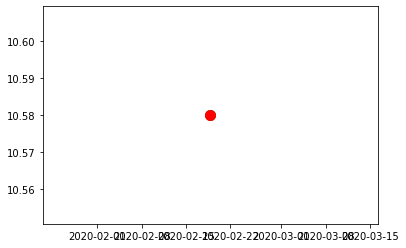

buy time:2020-02-18T19:39:48.024489127Z sell time:2020-02-18T19:40:34.696375202Z
{'rsi': 69.14026773141404, 'macd1': [0.008367654375005529, 0.009431049933791513, 0.010156718249833219, 0.010210655326506668, 0.010934273773170133], 'macd2': [0.0028759468915140474, 0.0033281721041014123, 0.0037389108189156417, 0.004030855696768754, 0.004452943558083788], 'macd_signal': [0.006206124247750416, 0.0068511093849586355, 0.007512231157933552, 0.008051915991648175, 0.008628387547952567]}
{'rsi': 66.98395123980299, 'macd': [0.005089556878942858, 0.0057637193210702264, 0.006214187206870392, 0.006224757154157601, 0.00641189273445697], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004723665564478773, 'too_close': 0, 'macd_signal': [0.0037341936618904364, 0.0041400987937263945, 0.004554916476355194, 0.004888884611915676, 0.005193486236423935], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001218406498033035

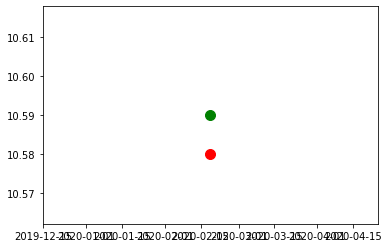

buy time:2020-02-18T19:41:02.402522136Z sell time:2020-02-18T19:41:04.471138065Z
{'rsi': 71.57863235818931, 'macd1': [0.010156718249833219, 0.010210655326506668, 0.010136552975451352, 0.010760700102395049, 0.011525935599546955], 'macd2': [0.0037389108189156417, 0.004030855696768754, 0.004293007532494286, 0.0046872655668313, 0.0051224669561715785], 'macd_signal': [0.007512231157933552, 0.008051915991648175, 0.00846884338840881, 0.008927214731206059, 0.009446958904874238]}
{'rsi': 64.60258223412892, 'macd': [0.006214187206870392, 0.006224757154157601, 0.006152152474717454, 0.006535159835221904, 0.00648899466372832], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009442870632672131, 'too_close': 1, 'macd_signal': [0.004554916476355194, 0.004888884611915676, 0.005141538184476031, 0.005420262514625206, 0.005634008944445828], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000854985719282492}


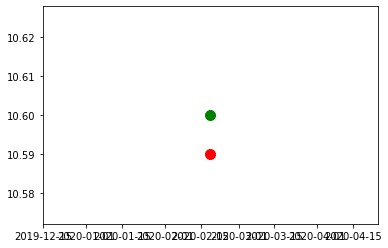

buy time:2020-02-18T19:45:50.610604941Z sell time:2020-02-18T19:45:51.517467694Z
{'rsi': 71.4010924479507, 'macd1': [0.011525935599546955, 0.013589570982221133, 0.01584923322240961, 0.01743900582401281, 0.017688098251776196], 'macd2': [0.0051224669561715785, 0.005834545536359315, 0.006640285092883502, 0.007370971050175257, 0.007871500639751616], 'macd_signal': [0.009446958904874238, 0.010275481320343617, 0.011390231700756816, 0.012599986525408014, 0.013617608870681652]}
{'rsi': 60.995057294585976, 'macd': [0.0070084751832091285, 0.008325234218222732, 0.00976264081410072, 0.010755910358758669, 0.010091498181104441], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014137606032044103, 'too_close': 0, 'macd_signal': [0.00573790504834199, 0.006255370882318138, 0.006956824868674655, 0.0077166419666914576, 0.008191613209574055], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0018998849715303866}


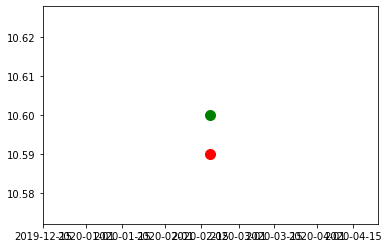

buy time:2020-02-18T19:50:02.755188502Z sell time:2020-02-18T19:50:04.534218265Z
{'rsi': 60.07718688461136, 'macd1': [0.012860130594404495, 0.010180970510621279, 0.009561332604402395, 0.00976462105275644, 0.01021147529516675], 'macd2': [0.007305921464020315, 0.007068178249525658, 0.007158014375255206, 0.0073891542664199505, 0.007669960452947322], 'macd_signal': [0.013210842560155357, 0.012604868150248541, 0.011996161041079312, 0.011549853043414738, 0.01128217749376514]}
{'rsi': 58.40849236840525, 'macd': [0.0076852526724682235, 0.005912842703557075, 0.005493914900462471, 0.005615608626616364, 0.005637504924571601], 'scalp': 0, 'bail_out': 0, 'movement': -0.00047169811320745334, 'too_close': 0, 'macd_signal': [0.008048782660594566, 0.0076215946691870675, 0.007196058715442148, 0.006879968697676991, 0.006631475943055913], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000993971018484312}


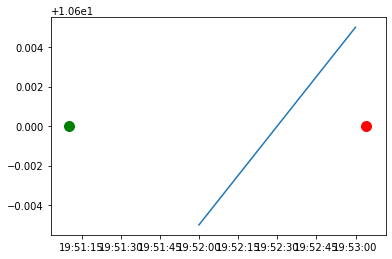

buy time:2020-02-18T19:51:10.110593313Z sell time:2020-02-18T19:53:03.932023374Z
{'rsi': 60.07718688461134, 'macd1': [0.010180970510621279, 0.009561332604402395, 0.00976462105275644, 0.01021147529516675, 0.010445204684003784], 'macd2': [0.007068178249525658, 0.007158014375255206, 0.0073891542664199505, 0.007669960452947322, 0.007916044096845098], 'macd_signal': [0.012604868150248541, 0.011996161041079312, 0.011549853043414738, 0.01128217749376514, 0.01111478293181287]}
{'rsi': 60.07718688461134, 'macd': [0.005493914900462471, 0.005615608626616364, 0.005897245184312894, 0.006040114642463124, 0.006072998445663558], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.007196058715442148, 0.006879968697676991, 0.006683423995004172, 0.006554762124495963, 0.006458409388729482], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00038541094306592406}


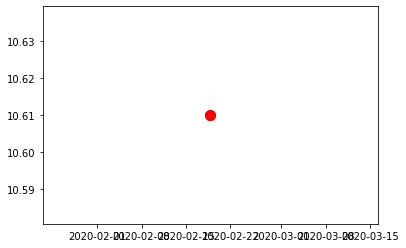

buy time:2020-02-18T19:54:02.934681751Z sell time:2020-02-18T19:55:27.592769912Z
{'rsi': 62.87556950717676, 'macd1': [0.01021147529516675, 0.010445204684003784, 0.010110431929572172, 0.010530647783740577, 0.011138729746022591], 'macd2': [0.007669960452947322, 0.007916044096845098, 0.008049820301652133, 0.008319960152133987, 0.00863515885479238], 'macd_signal': [0.01128217749376514, 0.01111478293181287, 0.01091391273136473, 0.0108372597418399, 0.010897553742676439]}
{'rsi': 62.87556950717678, 'macd': [0.006040114642463124, 0.005813258185924042, 0.006080470581009578, 0.006469461141064059, 0.006688551692521472], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.006554762124495963, 0.006406461336781579, 0.006341263185627178, 0.0063669027767145545, 0.0064312325598759375], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0002573191326455341}


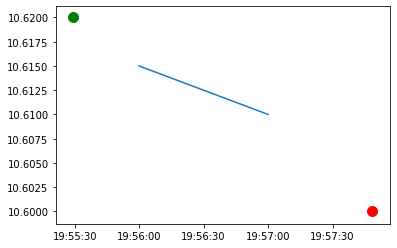

buy time:2020-02-18T19:55:29.198974344Z sell time:2020-02-18T19:57:48.299505404Z
{'rsi': 66.1521188694022, 'macd1': [0.010445204684003784, 0.010110431929572172, 0.010530647783740577, 0.011138729746022591, 0.01228593094443653], 'macd2': [0.007916044096845098, 0.008049820301652133, 0.008319960152133987, 0.00863515885479238, 0.009071277039277348], 'macd_signal': [0.01111478293181287, 0.01091391273136473, 0.0108372597418399, 0.010897553742676439, 0.011175229183028457]}
{'rsi': 58.34195163092062, 'macd': [0.006080470581009578, 0.006469461141064059, 0.006948291952260988, 0.0072311693122557585, 0.006838201419885337], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014124293785309598, 'too_close': 1, 'macd_signal': [0.006341263185627178, 0.0063669027767145545, 0.0064831806118238414, 0.006632778351910225, 0.006673862965505247], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00016433845438008996}


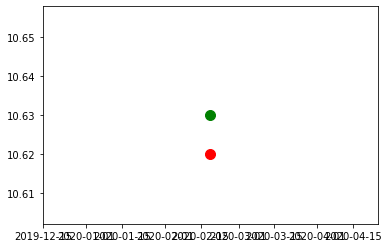

buy time:2020-02-18T20:01:20.456547812Z sell time:2020-02-18T20:01:25.5096149Z
{'rsi': 63.547212128662004, 'macd1': [0.012151672417319404, 0.009075254630367624, 0.009752417280131098, 0.01144817243558549, 0.012965380350136613], 'macd2': [0.009497984909483392, 0.009100940047339634, 0.009360834494367865, 0.009840871993221256, 0.010330757157911208], 'macd_signal': [0.01150549298929419, 0.011019445317508878, 0.010766039710033322, 0.010902466255143756, 0.011315049074142328]}
{'rsi': 58.316554194168106, 'macd': [0.007097941679624853, 0.005083765060955869, 0.005526175941721334, 0.006630312005412975, 0.006833141249776631], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014104372355430719, 'too_close': 0, 'macd_signal': [0.00672581101745315, 0.006397401826153694, 0.006223156649267222, 0.006304587720496373, 0.006410298426352425], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0004228428234242061}


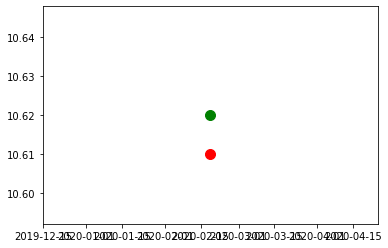

buy time:2020-02-18T20:01:47.258472031Z sell time:2020-02-18T20:01:56.552207369Z
{'rsi': 60.17952258198967, 'macd1': [0.012151672417319404, 0.009075254630367624, 0.009752417280131098, 0.01144817243558549, 0.012167659552416055], 'macd2': [0.009497984909483392, 0.009100940047339634, 0.009360834494367865, 0.009840871993221256, 0.010170821132323482], 'macd_signal': [0.01150549298929419, 0.011019445317508878, 0.010766039710033322, 0.010902466255143756, 0.011155504914598217]}
{'rsi': 56.565465621608304, 'macd': [0.007097941679624853, 0.005083765060955869, 0.005526175941721334, 0.006630312005412975, 0.006573400990037115], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009411764705882153, 'too_close': 1, 'macd_signal': [0.00672581101745315, 0.006397401826153694, 0.006223156649267222, 0.006304587720496373, 0.006358350374404522], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00021505061563259313}


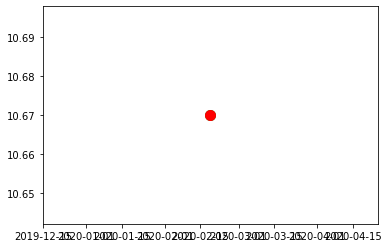

buy time:2020-02-18T20:09:02.714181723Z sell time:2020-02-18T20:09:11.628923674Z
{'rsi': 63.476503442402, 'macd1': [0.01899503710736461, 0.01837924680995684, 0.018086200317002366, 0.019644796935718745, 0.020642047312939837], 'macd2': [0.012643110261151946, 0.012897935721484899, 0.013191722863163946, 0.01384075817765762, 0.014415755069277836], 'macd_signal': [0.014770282467726393, 0.015492075336172483, 0.01601090033233846, 0.016737679653014516, 0.01751855318499958]}
{'rsi': 60.321488264972054, 'macd': [0.011463371433809044, 0.011027624866388308, 0.010804606438963305, 0.011789207580724437, 0.01188384213819127], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009372071227741132, 'too_close': 0, 'macd_signal': [0.008774901231842257, 0.009225445958751468, 0.009541278054793835, 0.009990863959979956, 0.01036945959562222], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0015143825425690503}


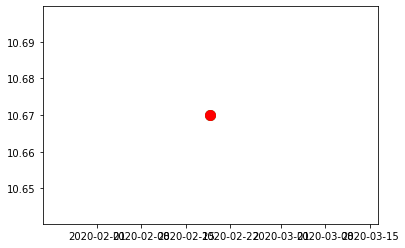

buy time:2020-02-18T20:09:42.779187336Z sell time:2020-02-18T20:10:44.879970132Z
{'rsi': 64.40731164359181, 'macd1': [0.01899503710736461, 0.01837924680995684, 0.018086200317002366, 0.019644796935718745, 0.021040907711800116], 'macd2': [0.012643110261151946, 0.012897935721484899, 0.013191722863163946, 0.01384075817765762, 0.014495723082072587], 'macd_signal': [0.014770282467726393, 0.015492075336172483, 0.01601090033233846, 0.016737679653014516, 0.017598325264771637]}
{'rsi': 63.476503442402, 'macd': [0.011463371433809044, 0.011027624866388308, 0.010804606438963305, 0.011789207580724437, 0.012403322657672078], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004683840749415252, 'too_close': 0, 'macd_signal': [0.008774901231842257, 0.009225445958751468, 0.009541278054793835, 0.009990863959979956, 0.010473355699518381], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001929966958153697}


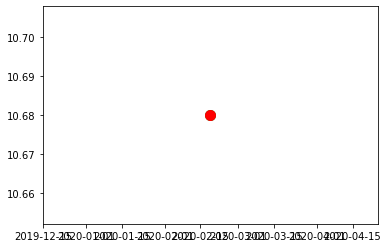

buy time:2020-02-18T20:26:05.398011868Z sell time:2020-02-18T20:26:41.019739088Z
{'rsi': 58.609331083835926, 'macd1': [0.012681657151517811, 0.01202741076506264, 0.011377760054704922, 0.011536834169898924, 0.011928851392116968], 'macd2': [0.01625770199732024, 0.01620535051485561, 0.01613126728286396, 0.016197244657536913, 0.016312008736102612], 'macd_signal': [0.015241200090633383, 0.014598442225519235, 0.013954305791356373, 0.013470811467064882, 0.013162419452075299]}
{'rsi': 58.609331083835926, 'macd': [0.006990804963155739, 0.006575843971937445, 0.006167097173950253, 0.006287981523909636, 0.006560255283305949], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.008686644697178971, 0.008264484552130667, 0.007845007076494584, 0.007533601965977595, 0.007338932629443266], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007786773461373169}


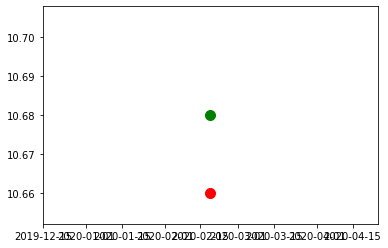

buy time:2020-02-18T20:27:03.538295425Z sell time:2020-02-18T20:27:25.85183661Z
{'rsi': 58.609331083835926, 'macd1': [0.012681657151517811, 0.01202741076506264, 0.011377760054704922, 0.011536834169898924, 0.011928851392116968], 'macd2': [0.01625770199732024, 0.01620535051485561, 0.01613126728286396, 0.016197244657536913, 0.016312008736102612], 'macd_signal': [0.015241200090633383, 0.014598442225519235, 0.013954305791356373, 0.013470811467064882, 0.013162419452075299]}
{'rsi': 53.33307823777065, 'macd': [0.006575843971937445, 0.006167097173950253, 0.006287981523909636, 0.006560255283305949, 0.005907997754482253], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014044943820225252, 'too_close': 1, 'macd_signal': [0.008264484552130667, 0.007845007076494584, 0.007533601965977595, 0.007338932629443266, 0.007052745654451064], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001144747899968811}


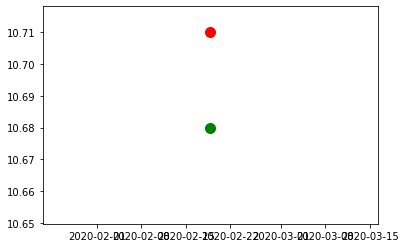

buy time:2020-02-18T20:42:30.052533052Z sell time:2020-02-18T20:43:33.512628232Z
{'rsi': 56.370411881958894, 'macd1': [0.004411953848974193, 0.002745322242168058, 0.0014082710147036437, 0.002338977078487403, 0.003839228529274763], 'macd2': [0.013092986396872064, 0.012596045682963464, 0.012118698715577025, 0.012059982135481206, 0.01214660877309015], 'macd_signal': [0.004494778837836022, 0.00414488751870243, 0.0035975642179026726, 0.0033458467900196187, 0.0034445231378706477]}
{'rsi': 63.78696690953796, 'macd': [0.0010571732556616809, 0.00022319315307761656, 0.0008691412140109378, 0.0016209300768945667, 0.0042636106184019695], 'scalp': 0, 'bail_out': 1, 'movement': 0.0032771535580524477, 'too_close': 0, 'macd_signal': [0.0018171795710629148, 0.001498382287465855, 0.0013725340727748715, 0.0014222132735988106, 0.0019904927425594423], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002273117875

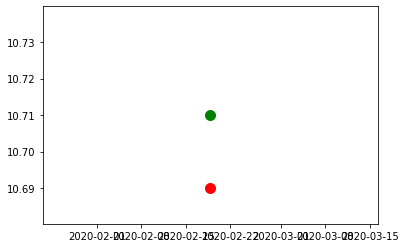

buy time:2020-02-18T20:44:08.218755728Z sell time:2020-02-18T20:45:07.844013284Z
{'rsi': 63.78696690953796, 'macd1': [0.002745322242168058, 0.0014082710147036437, 0.002338977078487403, 0.003440368130414484, 0.007454958064199602], 'macd2': [0.012596045682963464, 0.012118698715577025, 0.012059982135481206, 0.0120666407602954, 0.012693212104819551], 'macd_signal': [0.00414488751870243, 0.0035975642179026726, 0.0033458467900196187, 0.003364751058098592, 0.004182792459318794]}
{'rsi': 56.4766296932296, 'macd': [0.00022319315307761656, 0.0008691412140109378, 0.0016209300768945667, 0.0042636106184019695, 0.004968769344012358], 'scalp': 0, 'bail_out': 0, 'movement': -0.00233317778814749, 'too_close': 0, 'macd_signal': [0.001498382287465855, 0.0013725340727748715, 0.0014222132735988106, 0.0019904927425594423, 0.0025861480628500255], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002382621281162332

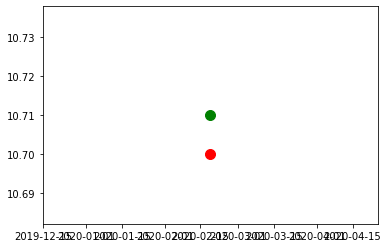

buy time:2020-02-18T20:50:00.452475206Z sell time:2020-02-18T20:50:01.684004402Z
{'rsi': 61.5183583405748, 'macd1': [0.007454958064199602, 0.00852103327654774, 0.009658031995321892, 0.012034221510083043, 0.013758766326377625], 'macd2': [0.012693212104819551, 0.012849536701112996, 0.0130527773045781, 0.01353876111879515, 0.01396422841668965], 'macd_signal': [0.004182792459318794, 0.005050440622764584, 0.005971958897276045, 0.007184411419837445, 0.008499282401145482]}
{'rsi': 0, 'macd': [], 'bail_out': 0, 'too_close': 0, 'macd_signal': [], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0}


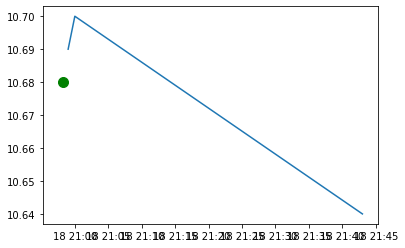

buy time:2020-02-18T20:58:12.695263958Z sell time:None
{'rsi': 57.854061088958076, 'macd1': [0.00852103327654774, 0.009658031995321892, 0.012034221510083043, 0.014157626725237904, 0.014463341617734216], 'macd2': [0.012849536701112996, 0.0130527773045781, 0.01353876111879515, 0.014044196429484401, 0.014246847314801414], 'macd_signal': [0.005050440622764584, 0.005971958897276045, 0.007184411419837445, 0.008579054480917538, 0.009755911908280873]}
None
HL analysis for run 66


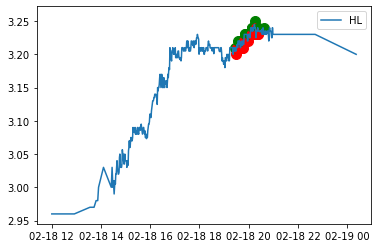

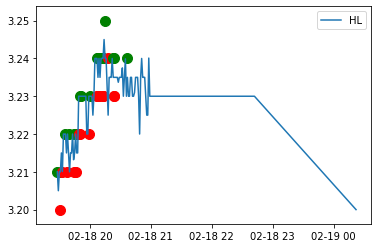

Delta = nan


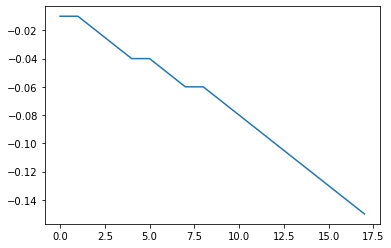

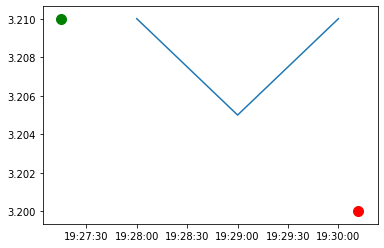

buy time:2020-02-18T19:27:15.064215153Z sell time:2020-02-18T19:30:11.445573574Z
{'rsi': 55.94625343931825, 'macd1': [0.0026487148060478916, 0.0027963292279582497, 0.002481254154207413, 0.0026049844621893747, 0.002672237729557825], 'macd2': [-0.0002753364018159843, -0.00015067485406117243, -0.00011570927197412928, -3.3867443969270994e-06, 9.995899048176327e-05], 'macd_signal': [0.0017721540752279174, 0.001976989105773984, 0.0020778421154606696, 0.0021832705848064105, 0.0022810640137566934]}
{'rsi': 50.40989392727755, 'macd': [0.0017149790506287843, 0.0014823204271543489, 0.0015415173383801495, 0.001307884836239559, 0.0011088480185166283], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015576323987538609, 'too_close': 1, 'macd_signal': [0.0015105726427282061, 0.0015049221996134346, 0.0015122412273667776, 0.0014713699491413338, 0.0013988655630163926], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd'

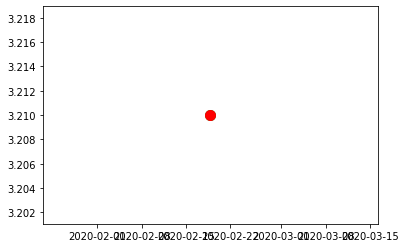

buy time:2020-02-18T19:31:10.663458726Z sell time:2020-02-18T19:32:43.758336667Z
{'rsi': 54.680031602868, 'macd1': [0.0022733773306975458, 0.0023865241384379843, 0.0020491146671415272, 0.002160271182026996, 0.0022227411446062995], 'macd2': [1.999097768745628e-05, 0.00012143526981267527, 0.0001346050319477321, 0.00022647436523248743, 0.0003106348763992628], 'macd_signal': [0.0022012919339846376, 0.002238338374875307, 0.002200493633328551, 0.00219244914306824, 0.002198507543375852]}
{'rsi': 54.680031602868, 'macd': [0.0015415173383801495, 0.001307884836239559, 0.0013685882782565884, 0.0013981157879028316, 0.001402966889083146], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0015122412273667776, 0.0014713699491413338, 0.0014508136149643848, 0.001440274049552074, 0.0014328126174582884], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -2.984572837514245e-05}


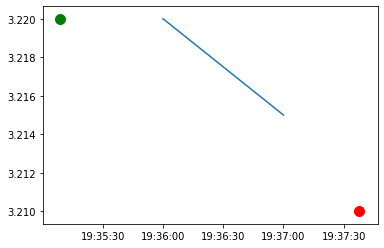

buy time:2020-02-18T19:35:08.779414428Z sell time:2020-02-18T19:37:37.437028535Z
{'rsi': 61.062217537962916, 'macd1': [0.0022227411446062995, 0.0026452148629281247, 0.002555184700781865, 0.003245272924732756, 0.003748957169426692], 'macd2': [0.0003106348763992628, 0.00046753643445152093, 0.0005327744749714647, 0.0007502801260459435, 0.0009491923142177505], 'macd_signal': [0.002198507543375852, 0.0022878490072863063, 0.002341316145985418, 0.002522107501734886, 0.002767477435273247]}
{'rsi': 55.46898417143644, 'macd': [0.0015927431813742565, 0.0020318265420451453, 0.002347582062800946, 0.002563137246990088, 0.002438074569124371], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015527950310560052, 'too_close': 1, 'macd_signal': [0.0015063571717998758, 0.0016114510458489298, 0.0017586772492393329, 0.001919569248789484, 0.0020232703128564614], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00041480

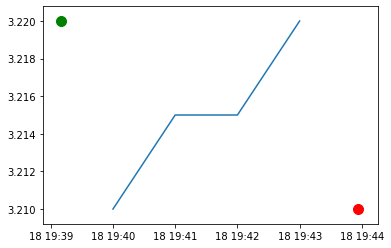

buy time:2020-02-18T19:39:09.998997705Z sell time:2020-02-18T19:43:56.697330194Z
{'rsi': 59.46732923841718, 'macd1': [0.003748957169426692, 0.004100858419036957, 0.00393097069814452, 0.004151930794901837, 0.004277732229171605], 'macd2': [0.0009491923142177505, 0.0011306797895183074, 0.0012158776949595662, 0.0013722858795417459, 0.00151399163292254], 'macd_signal': [0.002767477435273247, 0.003034153632025989, 0.0032135170452496954, 0.0034011997951801237, 0.00357650628197842]}
{'rsi': 53.833375732690534, 'macd': [0.0023773862010010305, 0.0019376950416578609, 0.001829653942927223, 0.0017217043342681038, 0.001615227959543386], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015527950310560052, 'too_close': 1, 'macd_signal': [0.0021813622541042785, 0.002132628811614995, 0.0020720338378774406, 0.002001967937155573, 0.0019246199416331356], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0003093919820

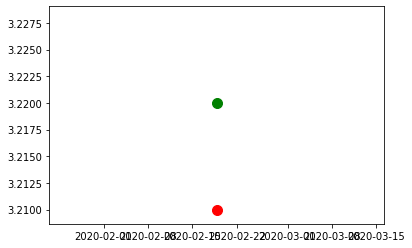

buy time:2020-02-18T19:44:02.746076913Z sell time:2020-02-18T19:45:55.728421515Z
{'rsi': 57.994340410002046, 'macd1': [0.00322187267765095, 0.0030692736528870057, 0.002914738534876893, 0.0031593080175200683, 0.0033149187743766184], 'macd2': [0.001408562783105971, 0.0014628532120863902, 0.0015104625140596184, 0.0016318168338451677, 0.001740856826844439], 'macd_signal': [0.00344176189729521, 0.0033672642484135692, 0.003276759105706234, 0.003253268888069001, 0.0032655988653305244]}
{'rsi': 52.80054811401303, 'macd': [0.001829653942927223, 0.0017217043342681038, 0.0018749682192837902, 0.001616797633331224, 0.0014881348698181363], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015527950310560052, 'too_close': 1, 'macd_signal': [0.0020720338378774406, 0.002001967937155573, 0.0019765679935812167, 0.0019046139215312182, 0.0018213181111886019], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000333183

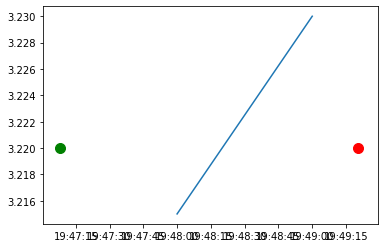

buy time:2020-02-18T19:47:08.132411116Z sell time:2020-02-18T19:49:20.418026041Z
{'rsi': 56.94435657105724, 'macd1': [0.0031593080175200683, 0.0027724686319268166, 0.00258138400068475, 0.0028011167368835466, 0.002941350456277192], 'macd2': [0.0016318168338451677, 0.0016321003294437197, 0.0016585393226682399, 0.001760179453063948, 0.0018508764631510743], 'macd_signal': [0.003253268888069001, 0.003157108836840564, 0.003041963869609401, 0.00299379444306423, 0.0029833056457068225]}
{'rsi': 56.10849387960506, 'macd': [0.001616797633331224, 0.0014881348698181363, 0.0016282920038364068, 0.0014566184458786324, 0.001563669979341764], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0019046139215312182, 0.0018213181111886019, 0.001782712889718163, 0.0017174940009502568, 0.0016867291966285581], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00012305921728679404}


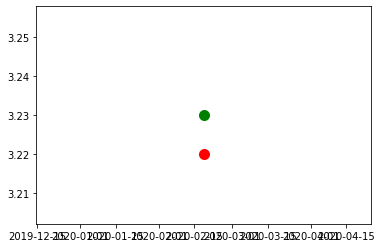

buy time:2020-02-18T19:50:08.154155755Z sell time:2020-02-18T19:50:13.732857407Z
{'rsi': 63.1118917757751, 'macd1': [0.0028011167368835466, 0.002542490057416469, 0.002310888071424877, 0.0032996798137800987, 0.0040367710100550624], 'macd2': [0.001760179453063948, 0.0017709084503563233, 0.0017779471504635325, 0.0020214834400853476, 0.002242311536310382], 'macd_signal': [0.00299379444306423, 0.002903533565934678, 0.002785004467032718, 0.002887939536382194, 0.0031177058311167676]}
{'rsi': 58.27747831766919, 'macd': [0.0016282920038364068, 0.0014566184458786324, 0.00130392971960136, 0.001947238118351624, 0.0021634883236330005], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015479876160990381, 'too_close': 0, 'macd_signal': [0.001782712889718163, 0.0017174940009502568, 0.0016347811446804773, 0.0016972725394147066, 0.0017905156962583653], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0003729726273

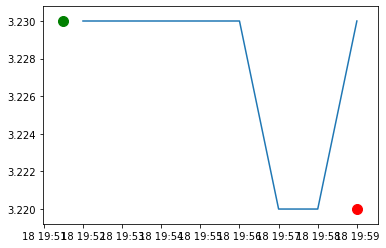

buy time:2020-02-18T19:51:28.667607366Z sell time:2020-02-18T19:59:00.969690201Z
{'rsi': 63.1118917757751, 'macd1': [0.002542490057416469, 0.002310888071424877, 0.0032996798137800987, 0.0040367710100550624, 0.004568261024116005], 'macd2': [0.0017709084503563233, 0.0017779471504635325, 0.0020214834400853476, 0.002242311536310382, 0.0024418941845589792], 'macd_signal': [0.002903533565934678, 0.002785004467032718, 0.002887939536382194, 0.0031177058311167676, 0.003407816869716615]}
{'rsi': 49.355578322857355, 'macd': [0.003198448081752403, 0.0032098055092006916, 0.0031769696668333403, 0.0025906434303544223, 0.002100121123612908], 'scalp': 0, 'bail_out': 0, 'movement': -0.0030959752321980762, 'too_close': 1, 'macd_signal': [0.0025610324909624113, 0.002690787094610067, 0.0027880236090547217, 0.002748547573314662, 0.002618862283374311], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00051874115

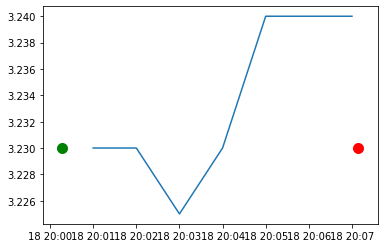

buy time:2020-02-18T20:00:16.988980838Z sell time:2020-02-18T20:07:07.853887478Z
{'rsi': 59.57469836311814, 'macd1': [0.00528345589945145, 0.004399186208932537, 0.003656249144178947, 0.0038302300861050576, 0.003922890595180029], 'macd2': [0.0031667540130118077, 0.0031052955785551006, 0.003043785366640517, 0.0031422619203862467, 0.0032278378909924577], 'macd_signal': [0.004632928295278895, 0.0045861798780096235, 0.004400193731243488, 0.004286201002215802, 0.004213538920808647]}
{'rsi': 59.391395197437234, 'macd': [0.0019609489504892608, 0.001959002853998637, 0.00245152533914883, 0.002803471102394095, 0.002781565578917622], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015432098765433139, 'too_close': 1, 'macd_signal': [0.002317901543080632, 0.002246121805264233, 0.0022872025120411524, 0.002390456230111741, 0.002468678099872917], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00031288747904470

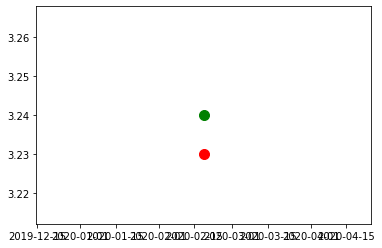

buy time:2020-02-18T20:07:20.846219668Z sell time:2020-02-18T20:07:26.880378331Z
{'rsi': 66.18113630885624, 'macd1': [0.0034658390382253934, 0.003463414711476709, 0.0042197669943777605, 0.004764262179050682, 0.00513656738437529], 'macd2': [0.0033358830465384237, 0.0033848176735364888, 0.0035843615783859306, 0.003762215668247748, 0.003919829981762213], 'macd_signal': [0.003984617832536898, 0.0038803772083248604, 0.003948255165535441, 0.004111456568238489, 0.004316478731465849]}
{'rsi': 59.391395197437234, 'macd': [0.0019609489504892608, 0.001959002853998637, 0.00245152533914883, 0.002803471102394095, 0.002781565578917622], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015432098765433139, 'too_close': 1, 'macd_signal': [0.002317901543080632, 0.002246121805264233, 0.0022872025120411524, 0.002390456230111741, 0.002468678099872917], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00031288747904470

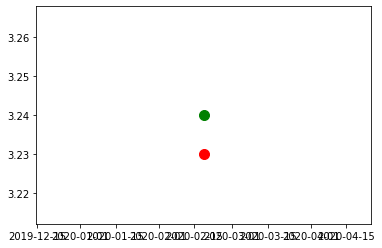

buy time:2020-02-18T20:07:34.525813188Z sell time:2020-02-18T20:07:41.795454686Z
{'rsi': 66.18113630885624, 'macd1': [0.0034658390382253934, 0.003463414711476709, 0.0042197669943777605, 0.004764262179050682, 0.00513656738437529], 'macd2': [0.0033358830465384237, 0.0033848176735364888, 0.0035843615783859306, 0.003762215668247748, 0.003919829981762213], 'macd_signal': [0.003984617832536898, 0.0038803772083248604, 0.003948255165535441, 0.004111456568238489, 0.004316478731465849]}
{'rsi': 59.391395197437234, 'macd': [0.0019609489504892608, 0.001959002853998637, 0.00245152533914883, 0.002803471102394095, 0.002781565578917622], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015432098765433139, 'too_close': 1, 'macd_signal': [0.002317901543080632, 0.002246121805264233, 0.0022872025120411524, 0.002390456230111741, 0.002468678099872917], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00031288747904470

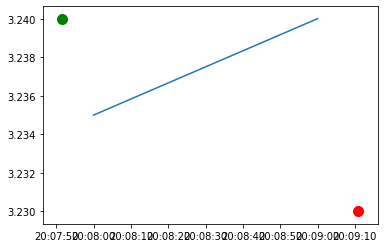

buy time:2020-02-18T20:07:51.410269692Z sell time:2020-02-18T20:09:10.855748795Z
{'rsi': 66.18113630885624, 'macd1': [0.0034658390382253934, 0.003463414711476709, 0.0042197669943777605, 0.004764262179050682, 0.00513656738437529], 'macd2': [0.0033358830465384237, 0.0033848176735364888, 0.0035843615783859306, 0.003762215668247748, 0.003919829981762213], 'macd_signal': [0.003984617832536898, 0.0038803772083248604, 0.003948255165535441, 0.004111456568238489, 0.004316478731465849]}
{'rsi': 59.87375959843566, 'macd': [0.00245152533914883, 0.002803471102394095, 0.003041305838658026, 0.0029273938690108636, 0.0028525612450129856], 'scalp': 0, 'bail_out': 0, 'movement': -0.001234567901234569, 'too_close': 1, 'macd_signal': [0.0022872025120411524, 0.002390456230111741, 0.002520626151820998, 0.002601979695258971, 0.002652096005209774], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000200465239803211

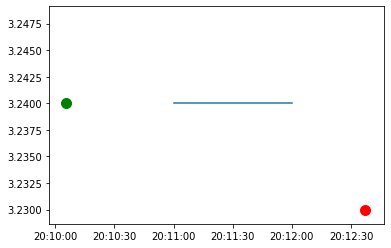

buy time:2020-02-18T20:10:05.532127116Z sell time:2020-02-18T20:12:37.026166743Z
{'rsi': 63.26322177638784, 'macd1': [0.004764262179050682, 0.00513656738437529, 0.004970862717499802, 0.0051832495144776836, 0.005290581056104582], 'macd2': [0.003762215668247748, 0.003919829981762213, 0.003978602958759403, 0.00410628077092845, 0.004217181019916083], 'macd_signal': [0.004111456568238489, 0.004316478731465849, 0.00444735552867264, 0.004594534325833648, 0.004733743671887835]}
{'rsi': 55.1948374035536, 'macd': [0.0029273938690108636, 0.003060353452804865, 0.00286447321351746, 0.002934378569741103, 0.0026910012035550324], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015432098765433139, 'too_close': 1, 'macd_signal': [0.002601979695258971, 0.0026936544467681496, 0.0027278182001180115, 0.0027691302740426296, 0.00275350445994511], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -6.250325639007778e-05}


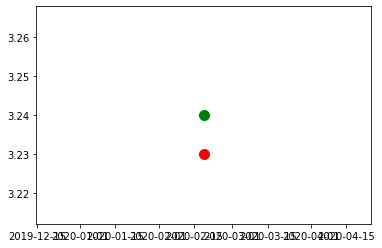

buy time:2020-02-18T20:12:43.358334321Z sell time:2020-02-18T20:12:45.837046404Z
{'rsi': 61.083111767580746, 'macd1': [0.004970862717499802, 0.0051832495144776836, 0.004891720657244303, 0.005006429151921399, 0.005039247155991244], 'macd2': [0.003978602958759403, 0.00410628077092845, 0.004137213007120888, 0.004239022772595025, 0.0043259112888947016], 'macd_signal': [0.00444735552867264, 0.004594534325833648, 0.004653971592115779, 0.004724463104076903, 0.004787419914459771]}
{'rsi': 55.1948374035536, 'macd': [0.0029273938690108636, 0.003060353452804865, 0.00286447321351746, 0.002934378569741103, 0.0026910012035550324], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015432098765433139, 'too_close': 1, 'macd_signal': [0.002601979695258971, 0.0026936544467681496, 0.0027278182001180115, 0.0027691302740426296, 0.00275350445994511], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -6.250325639007778e-05}

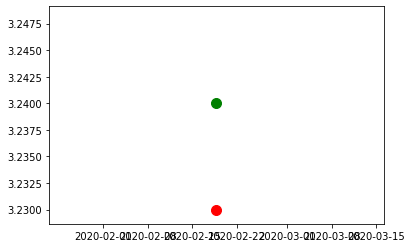

buy time:2020-02-18T20:12:49.760636345Z sell time:2020-02-18T20:13:04.213596142Z
{'rsi': 61.083111767580746, 'macd1': [0.004970862717499802, 0.0051832495144776836, 0.004891720657244303, 0.005006429151921399, 0.005039247155991244], 'macd2': [0.003978602958759403, 0.00410628077092845, 0.004137213007120888, 0.004239022772595025, 0.0043259112888947016], 'macd_signal': [0.00444735552867264, 0.004594534325833648, 0.004653971592115779, 0.004724463104076903, 0.004787419914459771]}
{'rsi': 54.788568589534314, 'macd': [0.003060353452804865, 0.00286447321351746, 0.002934378569741103, 0.0029507414632954365, 0.0026654301925157498], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015432098765433139, 'too_close': 1, 'macd_signal': [0.0026936544467681496, 0.0027278182001180115, 0.0027691302740426296, 0.002805452511893191, 0.0027774480480177027], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0001120178555019

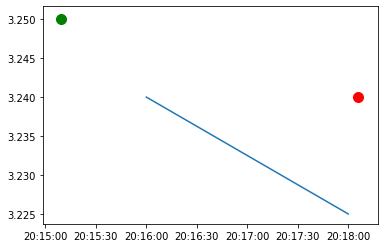

buy time:2020-02-18T20:15:09.487847462Z sell time:2020-02-18T20:18:05.598267182Z
{'rsi': 69.03908254887526, 'macd1': [0.005006429151921399, 0.005039247155991244, 0.005007531949425381, 0.005324478360811735, 0.005910980781575148], 'macd2': [0.004239022772595025, 0.0043259112888947016, 0.004398932812625489, 0.0045390474846978, 0.004740665905529351], 'macd_signal': [0.004724463104076903, 0.004787419914459771, 0.004831442321452893, 0.004930049529324661, 0.0051262357797747585]}
{'rsi': 58.438753565077164, 'macd': [0.002925170452256154, 0.003126996022196238, 0.0029839121023806925, 0.0028336660336623076, 0.002679790317340558], 'scalp': 0, 'bail_out': 0, 'movement': -0.006134969325153244, 'too_close': 1, 'macd_signal': [0.0028293960999657836, 0.0028889160844118742, 0.002907915288005638, 0.002893065437136972, 0.002850410413177689], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000170620095837131}

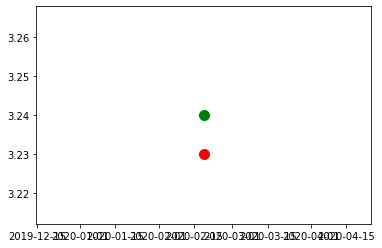

buy time:2020-02-18T20:23:11.053900012Z sell time:2020-02-18T20:23:19.844403331Z
{'rsi': 56.39558579952262, 'macd1': [0.0031016678766966344, 0.002784091331587746, 0.0025035502625523343, 0.002654083040230404, 0.002741775865588547], 'macd2': [0.004344679156400133, 0.004293259975715724, 0.0042390862153567355, 0.004262432809739813, 0.0042770952577351196], 'macd_signal': [0.0043430396283645365, 0.004031249969009178, 0.0037257100277178095, 0.0035113846302203284, 0.003357462877293972]}
{'rsi': 51.31585487587491, 'macd': [0.0016682791579811784, 0.001465607703873495, 0.0012886480291935953, 0.001393761944648464, 0.0011978278275401877], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015432098765433139, 'too_close': 1, 'macd_signal': [0.002489308837463064, 0.0022845686107451505, 0.0020853844944348394, 0.0019470599844775643, 0.001797213553090089], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0005993857

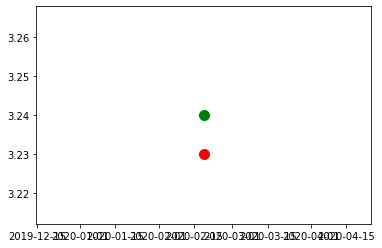

buy time:2020-02-18T20:23:27.632043781Z sell time:2020-02-18T20:23:40.091906459Z
{'rsi': 56.39558579952262, 'macd1': [0.0031016678766966344, 0.002784091331587746, 0.0025035502625523343, 0.002654083040230404, 0.002741775865588547], 'macd2': [0.004344679156400133, 0.004293259975715724, 0.0042390862153567355, 0.004262432809739813, 0.0042770952577351196], 'macd_signal': [0.0043430396283645365, 0.004031249969009178, 0.0037257100277178095, 0.0035113846302203284, 0.003357462877293972]}
{'rsi': 51.31585487587491, 'macd': [0.0016682791579811784, 0.001465607703873495, 0.0012886480291935953, 0.001393761944648464, 0.0011978278275401877], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015432098765433139, 'too_close': 1, 'macd_signal': [0.002489308837463064, 0.0022845686107451505, 0.0020853844944348394, 0.0019470599844775643, 0.001797213553090089], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0005993857

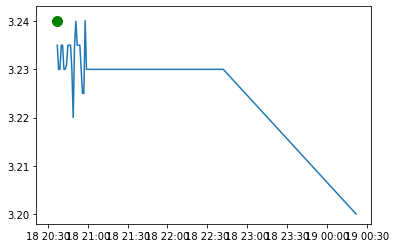

buy time:2020-02-18T20:36:28.476119672Z sell time:None
{'rsi': 56.870589623284054, 'macd1': [0.0010020155936114605, 0.00048487325002577464, 0.0004730395249938901, 0.0008492605150687282, 0.0011423195754969306], 'macd2': [0.0035916584642268212, 0.003437960340555435, 0.0033710226260694753, 0.00338241496052083, 0.003389085932824276], 'macd_signal': [0.0014415774520044433, 0.0012502366116087095, 0.0010947971942857457, 0.0010456898584423422, 0.0010650158018532599]}
None
KGC analysis for run 66


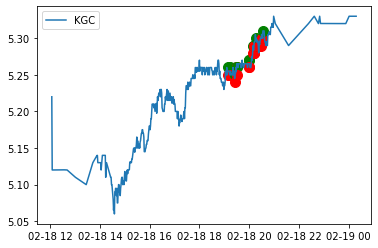

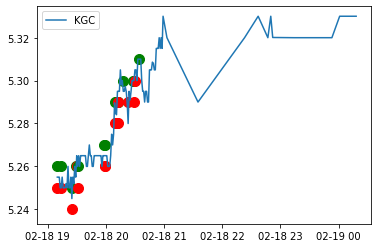

Delta = nan


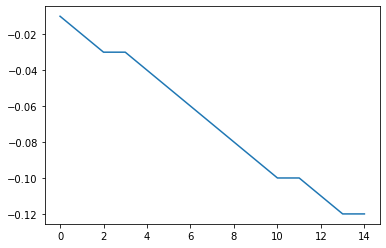

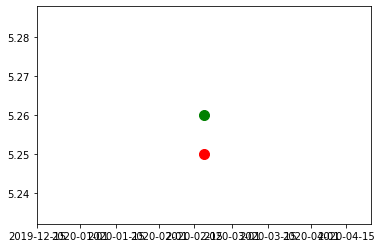

buy time:2020-02-18T19:09:22.425684635Z sell time:2020-02-18T19:09:41.292678545Z
{'rsi': 57.96842104293232, 'macd1': [-0.0021664229484281705, -0.0007570836450323526, -0.00044199349399498544, 0.0002087693707091276, 0.0011151075767230623], 'macd2': [0.0001973861321538095, 0.0003814582571273206, 0.0003902643852908838, 0.0004777101443327325, 0.0006373670219730343], 'macd_signal': [-0.0037969804227896272, -0.0031890010672381724, -0.002639599552589535, -0.0020699257679298025, -0.0014329190989992293]}
{'rsi': 54.893998178817206, 'macd': [-0.0012343807385146732, -0.00031128729006990596, -0.00010743152128167566, 0.00031255260402485163, 0.0006357538366783544], 'scalp': 0, 'bail_out': 0, 'movement': -0.000950570342205303, 'too_close': 0, 'macd_signal': [-0.00236695284033187, -0.001955819730279477, -0.001586142088479917, -0.0012064031499789633, -0.0008379717526474997], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_

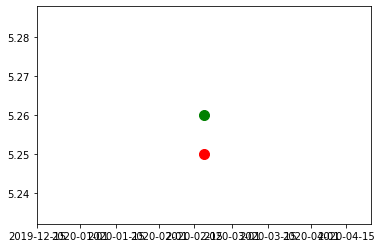

buy time:2020-02-18T19:13:27.017122884Z sell time:2020-02-18T19:13:28.502971254Z
{'rsi': 58.934232670724775, 'macd1': [0.0007162471778618951, 0.0011056813894168016, 0.0013981933057127804, 0.0016114354816627596, 0.0021590020242827634], 'macd2': [0.000557399009177395, 0.0006298238320372462, 0.0006954496705304791, 0.0007547152665683399, 0.0008880024618562743], 'macd_signal': [-0.001512691178771463, -0.0009890166651338101, -0.000511574670964492, -8.697264043904158e-05, 0.00036222229250531943]}
{'rsi': 54.893998178817206, 'macd': [0.0006357538366783544, 0.000879342409698225, 0.0010577316560818062, 0.0011829994888996609, 0.0012652471574723378], 'scalp': 0, 'bail_out': 0, 'movement': -0.000950570342205303, 'too_close': 1, 'macd_signal': [-0.0008379717526474997, -0.0004945089201783548, -0.00018406080492632259, 8.935125383887412e-05, 0.00032453043456556687], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_m

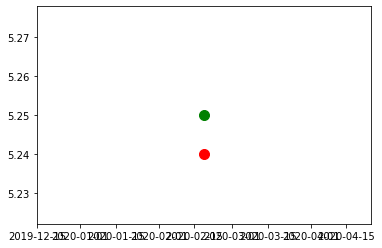

buy time:2020-02-18T19:25:14.685459683Z sell time:2020-02-18T19:25:16.842203238Z
{'rsi': 53.731065400373424, 'macd1': [0.0012904402312292618, 0.0010029488246665608, 0.0007662766534313192, 0.0009709776400317338, 0.0011202906336356122], 'macd2': [0.0007801287229520781, 0.0007412335052405794, 0.0007042631613876082, 0.0007490909047502825, 0.0007891357963369927], 'macd_signal': [0.0008376554073379054, 0.0008707140908036364, 0.000849826603329173, 0.0008740568106696851, 0.0009233035752628705]}
{'rsi': 44.86975488516791, 'macd': [0.000872745448783796, 0.0006761056567521351, 0.0005140992518342102, 0.0006409241408356081, 0.00021194452004724695], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019029495718363059, 'too_close': 1, 'macd_signal': [0.0006141298113650604, 0.0006265249804424753, 0.0006040398347208223, 0.0006114166959437794, 0.0005315222607644729], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -

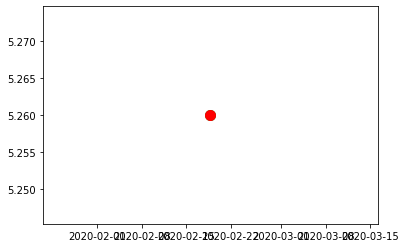

buy time:2020-02-18T19:29:12.256114087Z sell time:2020-02-18T19:30:09.017431441Z
{'rsi': 59.70811720626944, 'macd1': [0.00032256983591505417, 0.0006086028117673337, 0.0005864508377282363, 0.0012005887402590787, 0.0020669293905015707], 'macd2': [0.0006291997707466024, 0.0006778258009649818, 0.0006734984088536677, 0.0007963887235744593, 0.0009881460443574852], 'macd_signal': [0.0007637594157187589, 0.0007327280949284739, 0.0007034726434884264, 0.0008028958628425568, 0.0010557025683743597]}
{'rsi': 56.515536417903256, 'macd': [0.00021194452004724695, 0.000394402678911554, 0.0003756115990807274, 0.0007716755420812405, 0.0010702750360813695], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009496676163342628, 'too_close': 0, 'macd_signal': [0.0005315222607644729, 0.0005040983443938892, 0.00047840099533125684, 0.0005370559046812536, 0.0006436997309612767], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd'

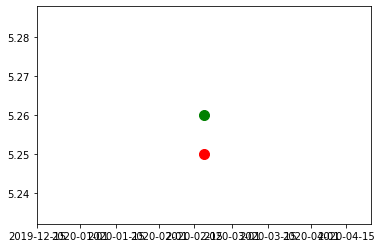

buy time:2020-02-18T19:31:17.903242568Z sell time:2020-02-18T19:31:22.449958034Z
{'rsi': 58.87020577206735, 'macd1': [0.0006086028117673337, 0.0005864508377282363, 0.0012005887402590787, 0.0012692085927801244, 0.0021062274676300063], 'macd2': [0.0006778258009649818, 0.0006734984088536677, 0.0007963887235744593, 0.0008282100187670949, 0.0010160980476214831], 'macd_signal': [0.0007327280949284739, 0.0007034726434884264, 0.0008028958628425568, 0.0008961584088300704, 0.0011381722205900575]}
{'rsi': 51.32338548658485, 'macd': [0.0003756115990807274, 0.0007716755420812405, 0.0008105347763400772, 0.001349768792953121, 0.0012329411592366668], 'scalp': 0, 'bail_out': 0, 'movement': -0.0018993352326685255, 'too_close': 1, 'macd_signal': [0.00047840099533125684, 0.0005370559046812536, 0.0005917516790130183, 0.0007433551018010389, 0.0008412723132881644], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0

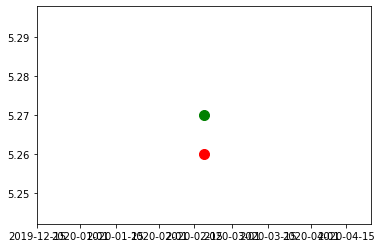

buy time:2020-02-18T19:58:31.029314368Z sell time:2020-02-18T19:58:40.295173995Z
{'rsi': 60.15067087219628, 'macd1': [0.0018466458144823505, 0.0017656323848074251, 0.0012831787588822863, 0.001289425305420977, 0.0016784854167495311], 'macd2': [0.0022544630682457267, 0.0022518264906832286, 0.002165831260400708, 0.0021632169661502942, 0.0022373199813694455], 'macd_signal': [0.0021642473013824487, 0.002084524318067444, 0.0019242552062304122, 0.001797289226068525, 0.0017735284642047262]}
{'rsi': 53.90102121329714, 'macd': [0.0010158512143974008, 0.0009649278241656845, 0.0006529754704249768, 0.000661155773088673, 0.0006589435962931489], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009487666034155396, 'too_close': 0, 'macd_signal': [0.001227257703076144, 0.0011747917272940521, 0.001070428475920237, 0.0009885739353539243, 0.0009226478675417692], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00026

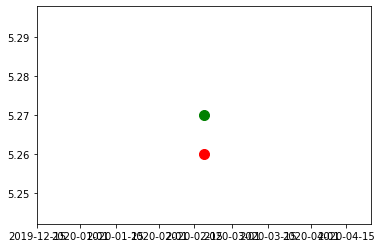

buy time:2020-02-18T19:58:51.70643269Z sell time:2020-02-18T19:58:59.889619257Z
{'rsi': 60.15067087219628, 'macd1': [0.0018466458144823505, 0.0017656323848074251, 0.0012831787588822863, 0.001289425305420977, 0.0016784854167495311], 'macd2': [0.0022544630682457267, 0.0022518264906832286, 0.002165831260400708, 0.0021632169661502942, 0.0022373199813694455], 'macd_signal': [0.0021642473013824487, 0.002084524318067444, 0.0019242552062304122, 0.001797289226068525, 0.0017735284642047262]}
{'rsi': 53.90102121329714, 'macd': [0.0010158512143974008, 0.0009649278241656845, 0.0006529754704249768, 0.000661155773088673, 0.0006589435962931489], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009487666034155396, 'too_close': 0, 'macd_signal': [0.001227257703076144, 0.0011747917272940521, 0.001070428475920237, 0.0009885739353539243, 0.0009226478675417692], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000263

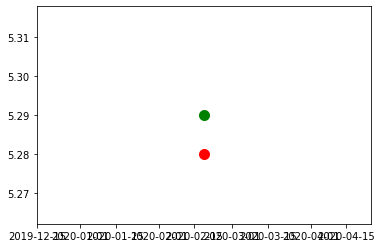

buy time:2020-02-18T20:09:21.29500557Z sell time:2020-02-18T20:09:23.469337107Z
{'rsi': 73.86120957948779, 'macd1': [0.00028160996305270913, 0.0012140270709002365, 0.0015318578298018082, 0.002162273862219344, 0.0038281294561404167], 'macd2': [0.001843540825432477, 0.001997237967798604, 0.0020554819392959445, 0.0021857488128098623, 0.0025420067419199555], 'macd_signal': [0.0007977855585773822, 0.000881033861041953, 0.001011198654793924, 0.001241413696279008, 0.0017587568482512897]}
{'rsi': 71.12493838690749, 'macd': [4.71766043022015e-05, 0.0006616690354350752, 0.0008721609423512078, 0.0012845941043329034, 0.002108768073354028], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009451795841209628, 'too_close': 0, 'macd_signal': [0.0003628547675012434, 0.00042261762108800977, 0.0005125262853406493, 0.0006669398491391001, 0.0009553054939820857], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001153

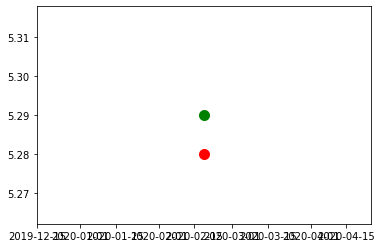

buy time:2020-02-18T20:10:43.22914438Z sell time:2020-02-18T20:10:44.691305701Z
{'rsi': 73.87644362165696, 'macd1': [0.0012140270709002365, 0.0015318578298018082, 0.002162273862219344, 0.003796220624231239, 0.005065025402169354], 'macd2': [0.001997237967798604, 0.0020554819392959445, 0.0021857488128098623, 0.0025356093008959135, 0.0028598342292776024], 'macd_signal': [0.000881033861041953, 0.001011198654793924, 0.001241413696279008, 0.0017523750818694544, 0.0024149051459294345]}
{'rsi': 67.2950920034317, 'macd': [0.0006616690354350752, 0.0008721609423512078, 0.0012845941043329034, 0.0023477291123148447, 0.002906694974218027], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009451795841209628, 'too_close': 0, 'macd_signal': [0.00042261762108800977, 0.0005125262853406493, 0.0006669398491391001, 0.001003097701774249, 0.0013838171562630046], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001522877

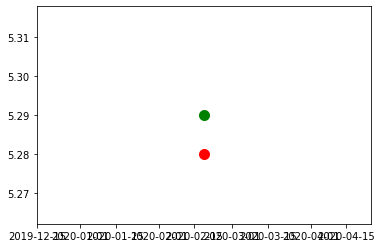

buy time:2020-02-18T20:11:53.384445811Z sell time:2020-02-18T20:11:57.609021537Z
{'rsi': 70.29986423594684, 'macd1': [0.0015318578298018082, 0.002162273862219344, 0.003796220624231239, 0.004666165003309075, 0.0056934300865938425], 'macd2': [0.0020554819392959445, 0.0021857488128098623, 0.0025356093008959135, 0.0027798662164828514, 0.0030801123971704314], 'macd_signal': [0.001011198654793924, 0.001241413696279008, 0.0017523750818694544, 0.0023351330661573787, 0.0030067924702446716]}
{'rsi': 66.09152193001529, 'macd': [0.0008721609423512078, 0.0012845941043329034, 0.0023477291123148447, 0.002906694974218027, 0.003257750256556058], 'scalp': 0, 'bail_out': 0, 'movement': -0.001115311909262847, 'too_close': 0, 'macd_signal': [0.0005125262853406493, 0.0006669398491391001, 0.001003097701774249, 0.0013838171562630046, 0.0017586037763216151], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00149914

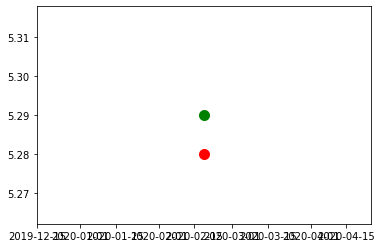

buy time:2020-02-18T20:12:06.635900203Z sell time:2020-02-18T20:12:08.647404178Z
{'rsi': 69.8929779900178, 'macd1': [0.002162273862219344, 0.003796220624231239, 0.004666165003309075, 0.005222774815939246, 0.006070001594314256], 'macd2': [0.0021857488128098623, 0.0025356093008959135, 0.0027798662164828514, 0.002985750142071808, 0.0032647569042518754], 'macd_signal': [0.001241413696279008, 0.0017523750818694544, 0.0023351330661573787, 0.0029126614161137524, 0.003544129451753853]}
{'rsi': 66.73228235319209, 'macd': [0.0012845941043329034, 0.0023477291123148447, 0.002906694974218027, 0.003257750256556058, 0.003535744629072468], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009451795841209628, 'too_close': 0, 'macd_signal': [0.0006669398491391001, 0.001003097701774249, 0.0013838171562630046, 0.0017586037763216151, 0.0021140319468717856], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001421712682

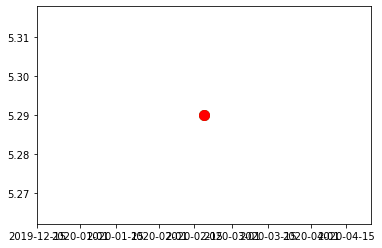

buy time:2020-02-18T20:12:14.435394331Z sell time:2020-02-18T20:12:25.317367667Z
{'rsi': 69.8929779900178, 'macd1': [0.002162273862219344, 0.003796220624231239, 0.004666165003309075, 0.005222774815939246, 0.006070001594314256], 'macd2': [0.0021857488128098623, 0.0025356093008959135, 0.0027798662164828514, 0.002985750142071808, 0.0032647569042518754], 'macd_signal': [0.001241413696279008, 0.0017523750818694544, 0.0023351330661573787, 0.0029126614161137524, 0.003544129451753853]}
{'rsi': 69.8929779900178, 'macd': [0.0012845941043329034, 0.0023477291123148447, 0.002906694974218027, 0.003257750256556058, 0.003795484888811984], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0006669398491391001, 0.001003097701774249, 0.0013838171562630046, 0.0017586037763216151, 0.002165979998819689], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001629504889992295}


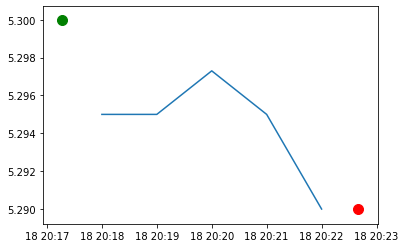

buy time:2020-02-18T20:17:16.190969555Z sell time:2020-02-18T20:22:39.998084675Z
{'rsi': 69.35576974947692, 'macd1': [0.0073714218956437705, 0.007994550914437681, 0.009189372215037572, 0.009462359020749211, 0.00972794858054371], 'macd2': [0.0036696437725245445, 0.003962710430407412, 0.004385939354064838, 0.004656353586739215, 0.004929683348849245], 'macd_signal': [0.004373405604349481, 0.005097634666367121, 0.005915982176101212, 0.006625257545030812, 0.007245795752133391]}
{'rsi': 62.03073570113469, 'macd': [0.005824006391917713, 0.00557140017759572, 0.005421688839454042, 0.00511513859103907, 0.0048098378962864174], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009433962264150743, 'too_close': 1, 'macd_signal': [0.0047737212461227045, 0.0049332570324173075, 0.005030943393824655, 0.005047782433267538, 0.0050001935258713135], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00019035562958489606

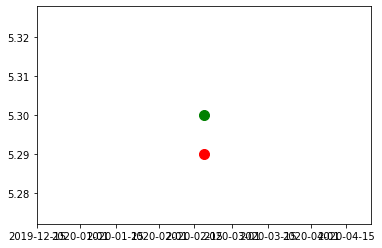

buy time:2020-02-18T20:28:06.786095472Z sell time:2020-02-18T20:28:35.493891941Z
{'rsi': 60.51634671199994, 'macd1': [0.006008644479766012, 0.005559813639139044, 0.005463894164127403, 0.005725337376992101, 0.005864925793031439], 'macd2': [0.0054159180551138775, 0.005416747042587211, 0.0054728208178786986, 0.005595625485481648, 0.005699660286846431], 'macd_signal': [0.00735551377218317, 0.006996373745574345, 0.006689877829284956, 0.0064969697388263855, 0.006370560949667396]}
{'rsi': 53.29815481924689, 'macd': [0.0034706736214946687, 0.0031706183804702803, 0.0031034244474588135, 0.003270501584755614, 0.002916659073756378], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016037735849056096, 'too_close': 1, 'macd_signal': [0.004426009153548437, 0.004174930998932806, 0.003960629688638007, 0.0038226040678615283, 0.0036414150690404984], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007247559952841

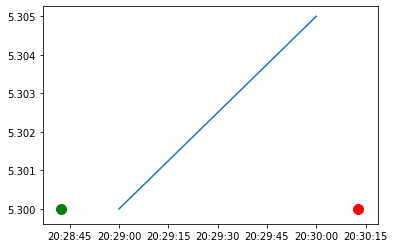

buy time:2020-02-18T20:28:42.402644497Z sell time:2020-02-18T20:30:12.692749491Z
{'rsi': 60.51634671199994, 'macd1': [0.006008644479766012, 0.005559813639139044, 0.005463894164127403, 0.005725337376992101, 0.005864925793031439], 'macd2': [0.0054159180551138775, 0.005416747042587211, 0.0054728208178786986, 0.005595625485481648, 0.005699660286846431], 'macd_signal': [0.00735551377218317, 0.006996373745574345, 0.006689877829284956, 0.0064969697388263855, 0.006370560949667396]}
{'rsi': 60.51634671199994, 'macd': [0.0031034244474588135, 0.003270501584755614, 0.003358217515314621, 0.003382954376589531, 0.0033582953804849325], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.003960629688638007, 0.0038226040678615283, 0.0037297267573521468, 0.0036603722811996238, 0.0035999569010566855], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00024166152057175302}


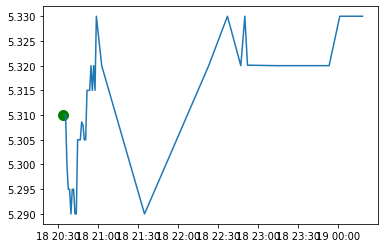

buy time:2020-02-18T20:34:06.503118164Z sell time:None
{'rsi': 64.90410038968685, 'macd1': [0.006272311344909909, 0.0064866895534976265, 0.006181866901497024, 0.006670317907461865, 0.006976992423161299], 'macd2': [0.005936647862742284, 0.006065514832304331, 0.0060944076102469324, 0.006271178762427887, 0.006423784002778987], 'macd_signal': [0.006276813784845475, 0.006318788938575905, 0.0062914045311601285, 0.006367187206420476, 0.006489148249768641]}
None
WPG analysis for run 66


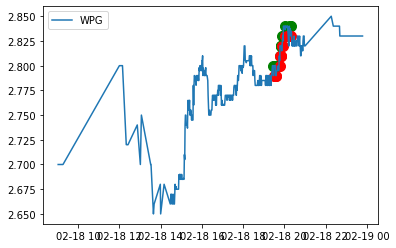

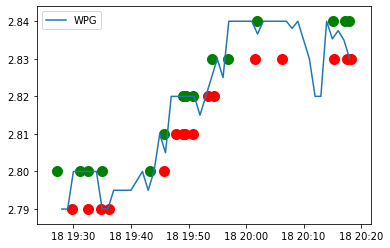

Delta = -0.11999999999999789


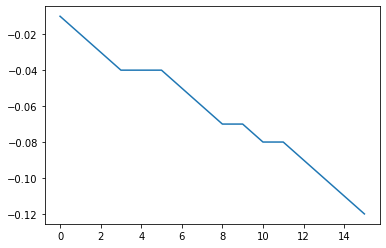

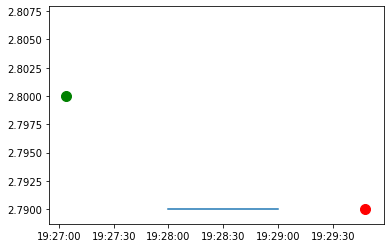

buy time:2020-02-18T19:27:04.081991795Z sell time:2020-02-18T19:29:47.889605087Z
{'rsi': 60.363056984648125, 'macd1': [0.0004846901137103288, 0.0011028289780785627, 0.0019734183563948626, 0.002633014953578261, 0.0031197870459176436], 'macd2': [-0.0006102710895676822, -0.0004583618985312121, -0.0002378994850289473, -3.468652564908581e-05, 0.0001523313734455023], 'macd_signal': [-2.5650259196994e-05, 0.00020004558825811736, 0.0005547201418854665, 0.0009703791042240254, 0.001400260692562749]}
{'rsi': 54.433211385453994, 'macd': [0.0013357744114665948, 0.0017531871114173647, 0.002055675096945375, 0.0017452024220716567, 0.0017403509556497276], 'scalp': 0, 'bail_out': 0, 'movement': -0.0017857142857142477, 'too_close': 1, 'macd_signal': [0.0004386706414361381, 0.0007015739354323835, 0.0009723941677349818, 0.0011269558186023168, 0.001249634846011799], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd':

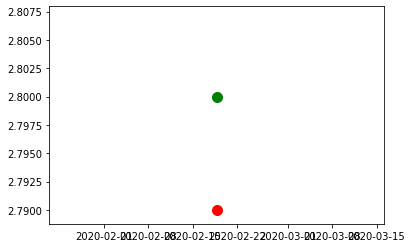

buy time:2020-02-18T19:31:03.959131671Z sell time:2020-02-18T19:32:29.723820915Z
{'rsi': 58.36438912566537, 'macd1': [0.0031197870459176436, 0.0026678872658880692, 0.0022834314579913695, 0.0027539184294913532, 0.0030911498922963077], 'macd2': [0.0001523313734455023, 0.00016421416445844272, 0.00017488407467913802, 0.00034435705633395486, 0.0004997268694340029], 'macd_signal': [0.001400260692562749, 0.0016537860072278132, 0.0017797150973805245, 0.00197455576380269, 0.0021978745895014137]}
{'rsi': 53.37950630302486, 'macd': [0.0017452024220716567, 0.0014806106959093235, 0.0017746871340178494, 0.0019807897204140446, 0.0018559243368212464], 'scalp': 0, 'bail_out': 0, 'movement': -0.0017857142857142477, 'too_close': 1, 'macd_signal': [0.0011269558186023168, 0.001197686794063718, 0.0013130868620545443, 0.0014466274337264443, 0.0015284868143454048], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.

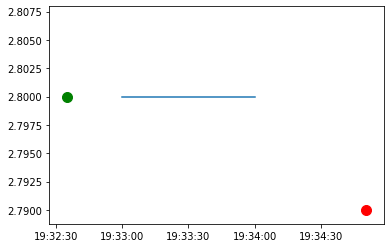

buy time:2020-02-18T19:32:34.985048956Z sell time:2020-02-18T19:34:50.375924964Z
{'rsi': 58.36438912566537, 'macd1': [0.0026678872658880692, 0.0022834314579913695, 0.0027539184294913532, 0.0030911498922963077, 0.0033201357974306234], 'macd2': [0.00016421416445844272, 0.00017488407467913802, 0.00034435705633395486, 0.0004997268694340029, 0.0006418728240382698], 'macd_signal': [0.0016537860072278132, 0.0017797150973805245, 0.00197455576380269, 0.0021978745895014137, 0.0024223268310872557]}
{'rsi': 47.97294033953852, 'macd': [0.0017746871340178494, 0.0019807897204140446, 0.0021156645965616505, 0.002193285739058748, 0.0017058049963414312], 'scalp': 0, 'bail_out': 0, 'movement': -0.0035714285714284954, 'too_close': 1, 'macd_signal': [0.0013130868620545443, 0.0014466274337264443, 0.0015804348662934856, 0.001703005040846538, 0.0017035650319455167], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 2.

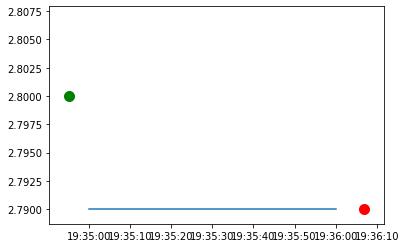

buy time:2020-02-18T19:34:55.111675631Z sell time:2020-02-18T19:36:06.971331234Z
{'rsi': 58.36438912566538, 'macd1': [0.0027539184294913532, 0.0030911498922963077, 0.0033201357974306234, 0.0034617044034765954, 0.0035331703551828575], 'macd2': [0.00034435705633395486, 0.0004997268694340029, 0.0006418728240382698, 0.0007716250632419097, 0.0008897671672620788], 'macd_signal': [0.00197455576380269, 0.0021978745895014137, 0.0024223268310872557, 0.0026302023455651237, 0.0028107959474886705]}
{'rsi': 47.32479331618789, 'macd': [0.0021156645965616505, 0.002193285739058748, 0.0022252855158217955, 0.0017018400754320595, 0.0012718586923301523], 'scalp': 0, 'bail_out': 0, 'movement': -0.0035714285714284954, 'too_close': 1, 'macd_signal': [0.0015804348662934856, 0.001703005040846538, 0.0018074611358415895, 0.0017863369237596835, 0.0016834412774737772], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0

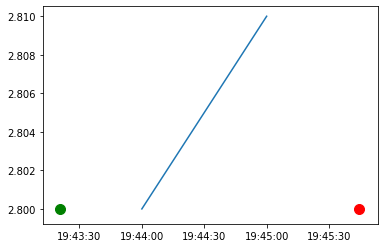

buy time:2020-02-18T19:43:20.635234252Z sell time:2020-02-18T19:45:44.325780232Z
{'rsi': 58.101683442583926, 'macd1': [0.0018532459528430856, 0.0017348377508463741, 0.0016222975612381063, 0.0019144977253771067, 0.0021216118400113615], 'macd2': [0.0008491653568851731, 0.0008744476930839795, 0.0008963096942120607, 0.00099495792524662, 0.0010841261571181704], 'macd_signal': [0.0023897747196787397, 0.0022587873259122667, 0.002131489372977435, 0.002088091043457369, 0.0020947952027681677]}
{'rsi': 56.8023333173162, 'macd': [0.0010112567951119367, 0.0009343094086138315, 0.0011219567774642947, 0.0009938643794589197, 0.0011408850514098567], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0013901215113063668, 0.0012989590907678597, 0.0012635586281071467, 0.0012096197783775012, 0.0011958728329839723], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -5.498778157411559e-05}


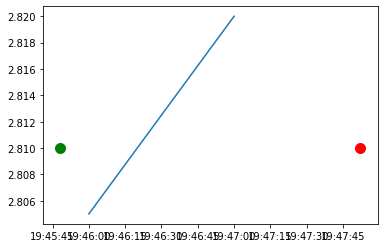

buy time:2020-02-18T19:45:48.258450578Z sell time:2020-02-18T19:47:51.804004974Z
{'rsi': 64.94226381709348, 'macd1': [0.0016222975612381063, 0.0019144977253771067, 0.0017227514411510825, 0.0019517507746931173, 0.0029066448306056536], 'macd2': [0.0008963096942120607, 0.00099495792524662, 0.0010041581443229752, 0.0010909846423308167, 0.0013290589459482582], 'macd_signal': [0.002131489372977435, 0.002088091043457369, 0.002015023122996112, 0.002002368653335513, 0.002183223888789541]}
{'rsi': 62.66381158980446, 'macd': [0.0009938643794589197, 0.0011408850514098567, 0.0017601104444699978, 0.001960024900822699, 0.0023500877901776462], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0012096197783775012, 0.0011958728329839723, 0.0013087203552811775, 0.0014389812643894819, 0.0016212025695471147], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0007288852206305315}


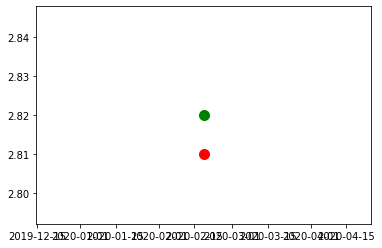

buy time:2020-02-18T19:49:00.03093506Z sell time:2020-02-18T19:49:03.999424055Z
{'rsi': 68.37260472688249, 'macd1': [0.0019517507746931173, 0.0029066448306056536, 0.0032227966427238464, 0.00463034810073415, 0.005680363082357864], 'macd2': [0.0010909846423308167, 0.0013290589459482582, 0.0014660012637568443, 0.0018295519507711688, 0.002161104099118738], 'macd_signal': [0.002002368653335513, 0.002183223888789541, 0.002391138439576402, 0.0028389803718079512, 0.003407256913917934]}
{'rsi': 62.80406346955737, 'macd': [0.0017601104444699978, 0.001960024900822699, 0.0028695683096580105, 0.0035410363125212285, 0.003758530388615622], 'scalp': 0, 'bail_out': 0, 'movement': -0.0017730496453900331, 'too_close': 0, 'macd_signal': [0.0013087203552811775, 0.0014389812643894819, 0.0017250986734431875, 0.0020882862012587956, 0.002422335038730161], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00133619534

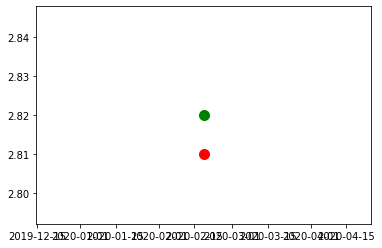

buy time:2020-02-18T19:49:13.55223742Z sell time:2020-02-18T19:49:22.107903466Z
{'rsi': 68.37260472688247, 'macd1': [0.0029066448306056536, 0.0032227966427238464, 0.00463034810073415, 0.005680363082357864, 0.0064382909103266606], 'macd2': [0.0013290589459482582, 0.0014660012637568443, 0.0018295519507711688, 0.002161104099118738, 0.002462686297019623], 'macd_signal': [0.002183223888789541, 0.002391138439576402, 0.0028389803718079512, 0.003407256913917934, 0.004013463713199679]}
{'rsi': 62.80406346955737, 'macd': [0.0017601104444699978, 0.001960024900822699, 0.0028695683096580105, 0.0035410363125212285, 0.003758530388615622], 'scalp': 0, 'bail_out': 0, 'movement': -0.0017730496453900331, 'too_close': 0, 'macd_signal': [0.0013087203552811775, 0.0014389812643894819, 0.0017250986734431875, 0.0020882862012587956, 0.002422335038730161], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001336195349

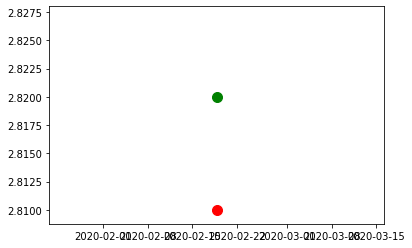

buy time:2020-02-18T19:49:32.583768724Z sell time:2020-02-18T19:50:44.479065905Z
{'rsi': 68.37260472688247, 'macd1': [0.0029066448306056536, 0.0032227966427238464, 0.00463034810073415, 0.005680363082357864, 0.0064382909103266606], 'macd2': [0.0013290589459482582, 0.0014660012637568443, 0.0018295519507711688, 0.002161104099118738, 0.002462686297019623], 'macd_signal': [0.002183223888789541, 0.002391138439576402, 0.0028389803718079512, 0.003407256913917934, 0.004013463713199679]}
{'rsi': 63.4078768935223, 'macd': [0.001960024900822699, 0.0028695683096580105, 0.0035410363125212285, 0.004018270648356026, 0.004124969213313179], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014539007092197768, 'too_close': 0, 'macd_signal': [0.0014389812643894819, 0.0017250986734431875, 0.0020882862012587956, 0.0024742830906782417, 0.0028044203152052293], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001320548898

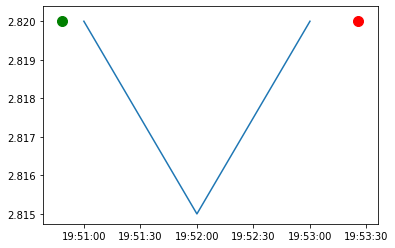

buy time:2020-02-18T19:50:48.272677128Z sell time:2020-02-18T19:53:25.631616547Z
{'rsi': 68.37260472688247, 'macd1': [0.0032227966427238464, 0.00463034810073415, 0.005680363082357864, 0.0064382909103266606, 0.00695873817257775], 'macd2': [0.0014660012637568443, 0.0018295519507711688, 0.002161104099118738, 0.002462686297019623, 0.0027362128432741883], 'macd_signal': [0.002391138439576402, 0.0028389803718079512, 0.003407256913917934, 0.004013463713199679, 0.004602518605075294]}
{'rsi': 65.28335638159967, 'macd': [0.004018270648356026, 0.004337956226300843, 0.004530724777604522, 0.004362353197092439, 0.0044342408850428505], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.0024742830906782417, 0.002847017717802762, 0.003183759129763114, 0.003419477943228979, 0.0036224305315917535], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000811810353451097}


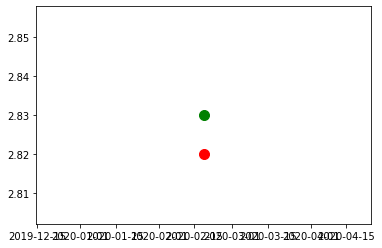

buy time:2020-02-18T19:54:03.783613508Z sell time:2020-02-18T19:54:25.434320093Z
{'rsi': 71.28089256410969, 'macd1': [0.00695873817257775, 0.007287194139611319, 0.007062626089399782, 0.0072050570917765455, 0.008032260217949005], 'macd2': [0.0027362128432741883, 0.002983489825104879, 0.0031262528702433734, 0.0033325674465665145, 0.003676989505875472], 'macd_signal': [0.004602518605075294, 0.0051394537119824986, 0.005524088187465955, 0.005860281968328073, 0.0062946776182522595]}
{'rsi': 68.56564314854396, 'macd': [0.004337956226300843, 0.004530724777604522, 0.004362353197092439, 0.0044342408850428505, 0.004692409981043255], 'scalp': 0, 'bail_out': 0, 'movement': -0.001766784452296782, 'too_close': 0, 'macd_signal': [0.002847017717802762, 0.003183759129763114, 0.003419477943228979, 0.0036224305315917535, 0.0038364264214820537], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00085598355956120

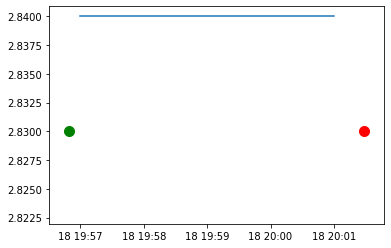

buy time:2020-02-18T19:56:48.817620015Z sell time:2020-02-18T20:01:28.845320502Z
{'rsi': 71.4704568914424, 'macd1': [0.007062626089399782, 0.0072050570917765455, 0.007633399819088282, 0.008280866060496717, 0.0086937713372639], 'macd2': [0.0031262528702433734, 0.0033325674465665145, 0.003597021493081165, 0.003914542754599459, 0.004200411707711904], 'macd_signal': [0.005524088187465955, 0.005860281968328073, 0.006214905538480115, 0.006628097642883435, 0.007041232381759528]}
{'rsi': 70.21365477910983, 'macd': [0.005780368935969893, 0.006252466509114818, 0.006539133884174486, 0.006677587242867933, 0.0066000497659683965], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006690140845070468, 'too_close': 1, 'macd_signal': [0.004584656172906626, 0.004918218240148264, 0.005242401368953509, 0.005529438543736394, 0.005743560788182794], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0008564889777856024}


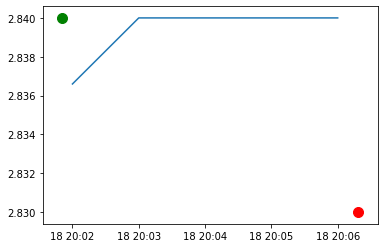

buy time:2020-02-18T20:01:50.797371996Z sell time:2020-02-18T20:06:18.077829952Z
{'rsi': 72.92024402432811, 'macd1': [0.009407967057124544, 0.010172806271995238, 0.01065610985889398, 0.010913329365906943, 0.010990486194867088], 'macd2': [0.004543193110708277, 0.004924869893311534, 0.005268148100907588, 0.005575549365711474, 0.005849451050178089], 'macd_signal': [0.007450761653014957, 0.007995170576811013, 0.008527358433227607, 0.009004552619763474, 0.009401739334784196]}
{'rsi': 62.18768299812448, 'macd': [0.006451622210688068, 0.006351890347706668, 0.006191685125283453, 0.005986438391897941, 0.005489019659494776], 'scalp': 0, 'bail_out': 0, 'movement': -0.0017605633802816527, 'too_close': 1, 'macd_signal': [0.0059009652804760514, 0.005991150293922175, 0.00603125726019443, 0.006022293486535132, 0.005915638721127061], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0004266190616322848}


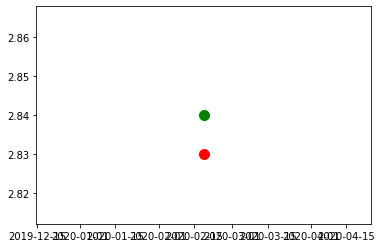

buy time:2020-02-18T20:15:05.30600666Z sell time:2020-02-18T20:15:21.685773357Z
{'rsi': 60.299888945795075, 'macd1': [0.006512941535035122, 0.004774093221116438, 0.0033573420552701627, 0.0038045331127376514, 0.004111539974141376], 'macd2': [0.006900260036157402, 0.0066320959029821935, 0.006374769212039055, 0.006447696923870705, 0.006504480561307702], 'macd_signal': [0.00851018672245382, 0.007762968022186343, 0.006881842828803107, 0.006266380885590016, 0.005835412703300288]}
{'rsi': 55.37790626666468, 'macd': [0.0036103269146017247, 0.0024796158576059213, 0.001566339503354719, 0.0018733145584399757, 0.0018284468798253073], 'scalp': 0, 'bail_out': 0, 'movement': -0.0017605633802816527, 'too_close': 0, 'macd_signal': [0.004966506265297306, 0.004469128183759029, 0.003888570447678167, 0.003485519269830529, 0.0031541047918294844], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0013256579120041

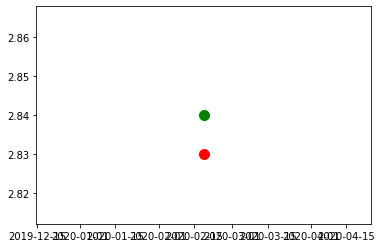

buy time:2020-02-18T20:17:12.982823855Z sell time:2020-02-18T20:17:28.714853079Z
{'rsi': 59.17879155318692, 'macd1': [0.0033573420552701627, 0.0038045331127376514, 0.003736611199212536, 0.0038163121364882535, 0.004034695353595907], 'macd2': [0.006374769212039055, 0.006447696923870705, 0.00642931062928076, 0.00643729779186808, 0.006474334685089289], 'macd_signal': [0.006881842828803107, 0.006266380885590016, 0.00576042694831452, 0.005371603985949267, 0.005104222259478595]}
{'rsi': 51.38130367628224, 'macd': [0.001566339503354719, 0.0018733145584399757, 0.001844031295409554, 0.001911550424276598, 0.0016120646750268364], 'scalp': 0, 'bail_out': 0, 'movement': -0.0030985915492957464, 'too_close': 1, 'macd_signal': [0.003888570447678167, 0.003485519269830529, 0.003157221674946334, 0.002908087424812387, 0.0026488828748552767], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0010368181998284404}

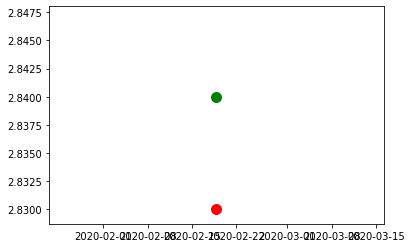

buy time:2020-02-18T20:17:56.136396388Z sell time:2020-02-18T20:18:16.046027036Z
{'rsi': 59.17879155318692, 'macd1': [0.0033573420552701627, 0.0038045331127376514, 0.003736611199212536, 0.0038163121364882535, 0.004034695353595907], 'macd2': [0.006374769212039055, 0.006447696923870705, 0.00642931062928076, 0.00643729779186808, 0.006474334685089289], 'macd_signal': [0.006881842828803107, 0.006266380885590016, 0.00576042694831452, 0.005371603985949267, 0.005104222259478595]}
{'rsi': 54.390314123990336, 'macd': [0.0018733145584399757, 0.001844031295409554, 0.001911550424276598, 0.001809467272429366, 0.0016856431635554614], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019014084507041724, 'too_close': 0, 'macd_signal': [0.003485519269830529, 0.003157221674946334, 0.002908087424812387, 0.002688363394335783, 0.0024878193481797186], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0008021761846242572

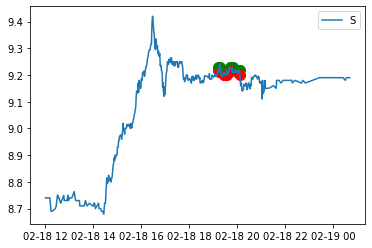

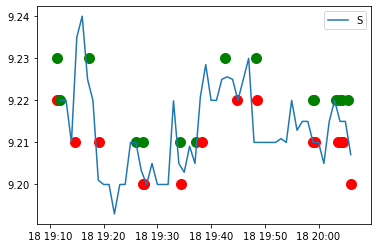

Delta = -0.1600000000000037


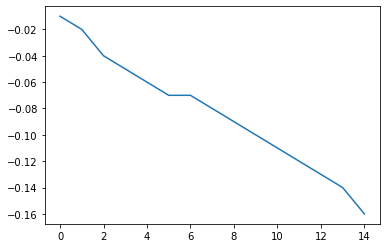

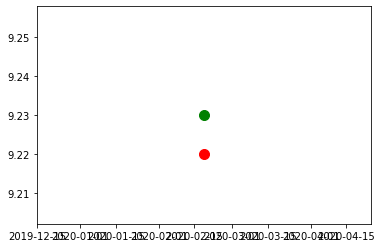

buy time:2020-02-18T19:11:13.701746647Z sell time:2020-02-18T19:11:23.083375327Z
{'rsi': 72.43457005973619, 'macd1': [0.0027094746788201007, 0.00239149445010689, 0.0025139715421396147, 0.0029801405282956495, 0.005305712918836747], 'macd2': [-0.0008849915681796716, -0.0008215704474174856, -0.0006819389877357196, -0.00047241489949989557, 0.00012094958935726652], 'macd_signal': [0.002094453884787734, 0.0021538619978515652, 0.0022258839067091753, 0.00237673523102647, 0.0029625307685885254]}
{'rsi': 70.09938656995674, 'macd': [0.0016913395769897477, 0.0014746143936914535, 0.0015463270509439297, 0.001841865133856757, 0.0030300524045170363], 'scalp': 0, 'bail_out': 0, 'movement': -0.00066088840736728, 'too_close': 0, 'macd_signal': [0.0013272875187691443, 0.0013567528937536062, 0.0013946677251916709, 0.001484107206924688, 0.0017932962464431578], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001

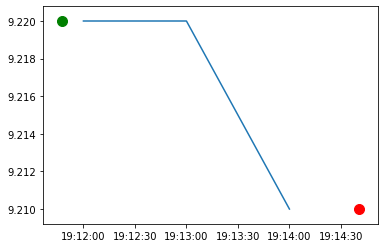

buy time:2020-02-18T19:11:47.254992309Z sell time:2020-02-18T19:14:40.373561244Z
{'rsi': 70.54928546560019, 'macd1': [0.0027094746788201007, 0.00239149445010689, 0.0025139715421396147, 0.0029801405282956495, 0.0049068525199746915], 'macd2': [-0.0008849915681796716, -0.0008215704474174856, -0.0006819389877357196, -0.00047241489949989557, 4.098157656251544e-05], 'macd_signal': [0.002094453884787734, 0.0021538619978515652, 0.0022258839067091753, 0.00237673523102647, 0.0028827586888161144]}
{'rsi': 65.00833105354702, 'macd': [0.001841865133856757, 0.0025677147421792057, 0.0033597051546099266, 0.003933208006444033, 0.004173168566230956], 'scalp': 0, 'bail_out': 0, 'movement': -0.00032537960954448085, 'too_close': 0, 'macd_signal': [0.001484107206924688, 0.0017008287139755915, 0.0020326040021024583, 0.0024127248029707734, 0.00276481355562281], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0014

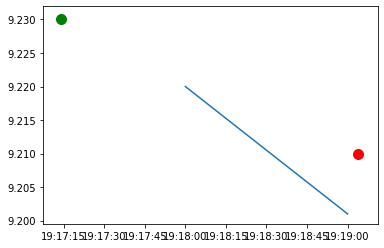

buy time:2020-02-18T19:17:13.948882141Z sell time:2020-02-18T19:19:03.759213718Z
{'rsi': 63.89971377955516, 'macd1': [0.006253604600427565, 0.006095937613617153, 0.007897241967384616, 0.009617383646633115, 0.010057752385115748], 'macd2': [0.0006588785764929384, 0.0008405821350621068, 0.00140625089144919, 0.0020044031524975026, 0.002391580577551622], 'macd_signal': [0.003848890485924686, 0.0042982999114631795, 0.0050180883226474664, 0.005937947387444596, 0.006761908386978826]}
{'rsi': 51.14101115569905, 'macd': [0.0049623883008607095, 0.0060560113865104626, 0.006050314941738577, 0.005707560375141085, 0.004846874214479158], 'scalp': 0, 'bail_out': 0, 'movement': -0.0021668472372697264, 'too_close': 1, 'macd_signal': [0.0031461466864886817, 0.003728119626493038, 0.0041925586895421455, 0.004495559026661934, 0.004565822064225378], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0002810521502537

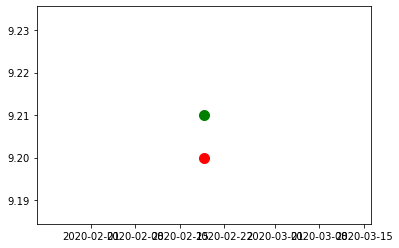

buy time:2020-02-18T19:26:04.653255202Z sell time:2020-02-18T19:27:16.349043788Z
{'rsi': 53.01280251300754, 'macd1': [0.002341210142031258, 0.0015320962810658756, 0.0008807153782459665, 0.0011580583703008074, 0.0013621526419083096], 'macd2': [0.0018909747320261516, 0.0017858654824998155, 0.0016863053685103324, 0.0017519458947941047, 0.0018095352859965885], 'macd_signal': [0.005494192603870409, 0.004701773339309502, 0.003937561747096795, 0.0033816610717375974, 0.00297775938577174]}
{'rsi': 50.69927570031149, 'macd': [0.0006564372188169187, 0.0002387905702843085, 0.0004297309666174698, 0.0005729347693907982, 0.0004952632550647706], 'scalp': 0, 'bail_out': 0, 'movement': -0.0003800217155266802, 'too_close': 0, 'macd_signal': [0.0027781920819176173, 0.0022703117795909557, 0.0019021956169962585, 0.0016363434474751665, 0.0014081274089930873], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0009

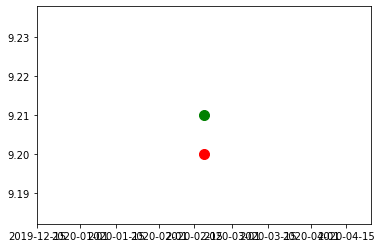

buy time:2020-02-18T19:27:20.918232583Z sell time:2020-02-18T19:27:27.617644831Z
{'rsi': 53.01280251300755, 'macd1': [0.0015320962810658756, 0.0008807153782459665, 0.0011580583703008074, 0.0013621526419083096, 0.0015065324542291592], 'macd2': [0.0017858654824998155, 0.0016863053685103324, 0.0017519458947941047, 0.0018095352859965885, 0.001859625269210241], 'macd_signal': [0.004701773339309502, 0.003937561747096795, 0.0033816610717375974, 0.00297775938577174, 0.0026835139994632238]}
{'rsi': 52.94377541024641, 'macd': [0.0006564372188169187, 0.0002387905702843085, 0.0004297309666174698, 0.0005729347693907982, 0.0006718866316877126], 'scalp': 0, 'bail_out': 0, 'movement': -1.085776330092761e-05, 'too_close': 0, 'macd_signal': [0.0027781920819176173, 0.0022703117795909557, 0.0019021956169962585, 0.0016363434474751665, 0.0014434520843176757], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000

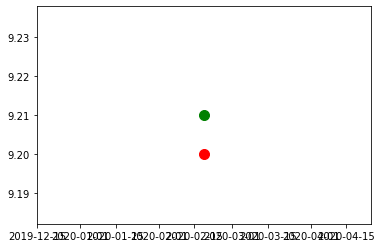

buy time:2020-02-18T19:34:17.599778098Z sell time:2020-02-18T19:34:28.745963661Z
{'rsi': 52.90135130347854, 'macd1': [-0.00011752670985387681, -0.0004684728037354091, -0.0007380918481860732, 0.0006465438502996079, 0.0009422379861465657], 'macd2': [0.0015193799875525826, 0.0014222796550331651, 0.0013306695055916862, 0.0015625297087566992, 0.0016166121592355864], 'macd_signal': [0.0013990521228040092, 0.0010255471374961255, 0.0006728193403596858, 0.0006675642423476702, 0.0007224989911074493]}
{'rsi': 47.41049592757442, 'macd': [-0.00033977431333731545, -0.0005521855091359384, -0.000710529486262601, 0.00020907948592885361, -0.00011082364594727778], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010966221865127772, 'too_close': 1, 'macd_signal': [0.000621440089927691, 0.00038671497011496506, 0.0001672660788394518, 0.00017562876025733215, 0.00011833827901641016], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_sig

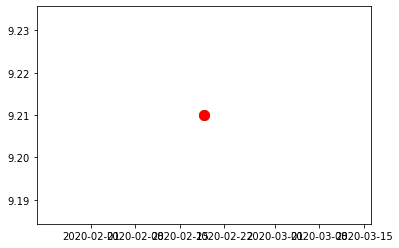

buy time:2020-02-18T19:37:12.927047718Z sell time:2020-02-18T19:38:13.063632178Z
{'rsi': 52.922458581369135, 'macd1': [0.0006465438502996079, 0.0005354003793094364, 0.0002746993649509477, 0.0005619028509684654, 0.0008523112476943595], 'macd2': [0.0015625297087566992, 0.0015350447861841587, 0.0014737161232556417, 0.0015140951244987377, 0.0015632177559918858], 'macd_signal': [0.0006675642423476702, 0.0006411314697400234, 0.0005678450487822083, 0.0005666566092194597, 0.0006237875369144397]}
{'rsi': 52.922458581369135, 'macd': [0.00020907948592885361, 0.0001489166137922382, -8.988437402379645e-06, 0.0001901633205942943, 0.000389630101881977], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.00017562876025733215, 0.00017028633096431337, 0.00013443137729097476, 0.00014557776595163868, 0.00019438823313770633], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0001952418

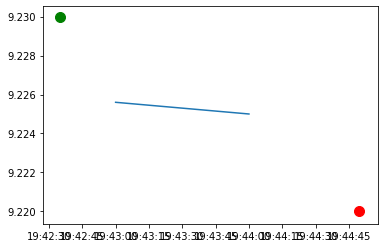

buy time:2020-02-18T19:42:35.134668357Z sell time:2020-02-18T19:44:49.70126596Z
{'rsi': 60.84350217715625, 'macd1': [0.0016237126608498187, 0.0031363256171488274, 0.003607616957644666, 0.003935749865922489, 0.004945703000716506], 'macd2': [0.0017051976754842713, 0.002029820386995951, 0.0021892916295538356, 0.002332508807727507, 0.0026204786964711957], 'macd_signal': [0.0007599548978838708, 0.0012352290417368622, 0.001709706624918423, 0.0021549152731192363, 0.0027130728186386902]}
{'rsi': 58.49606310293699, 'macd': [0.002197212112449165, 0.002406537267599873, 0.002798134307099076, 0.003098104281942682, 0.003260443167768301], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005417118093175278, 'too_close': 0, 'macd_signal': [0.000930543095974711, 0.0012257419302997433, 0.0015402204056596098, 0.0018517971809162241, 0.0021335263782866396], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001126916789

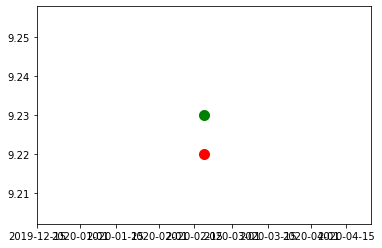

buy time:2020-02-18T19:48:25.768074032Z sell time:2020-02-18T19:48:29.834385862Z
{'rsi': 60.42997937541658, 'macd1': [0.005288589024976531, 0.005038587265314476, 0.005184157541757273, 0.005637990008580118, 0.00592930615770193], 'macd2': [0.0029045933025138027, 0.002973791914554269, 0.003112668699298382, 0.0033154295177304505, 0.0034966733902379588], 'macd_signal': [0.0035464968922173236, 0.003844914966836754, 0.004112763481820858, 0.0044178087871727095, 0.004720108261278553]}
{'rsi': 54.66194156649087, 'macd': [0.003260443167768301, 0.0030848573233761556, 0.0031677143625081783, 0.003450879401277973, 0.00323710047822523], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008125677139761955, 'too_close': 1, 'macd_signal': [0.0021335263782866396, 0.0023237925673045426, 0.00249257692634527, 0.0026842374213318105, 0.0027948100327104945], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0004422904455147

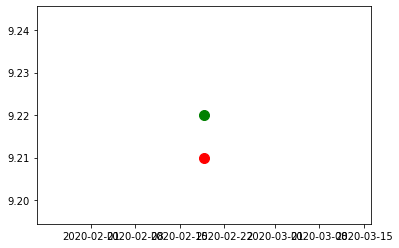

buy time:2020-02-18T19:58:58.203704823Z sell time:2020-02-18T19:59:00.497678343Z
{'rsi': 54.80501601239506, 'macd1': [0.0003121035589295218, 0.0008020492450757644, 0.0006103878966712273, 0.0006207912516611458, 0.0010207278830449695], 'macd2': [0.002475390928688981, 0.002532412033781739, 0.0024672684570852255, 0.002436974797028313, 0.002485174072925034], 'macd_signal': [0.0020488182665398106, 0.0017994644622470013, 0.0015616491491318464, 0.0013734775696377063, 0.001302927632319159]}
{'rsi': 51.086813142455654, 'macd': [-2.556635469730395e-05, 0.000303758760713535, 0.0001875996459617113, 0.00020374060010297512, 0.0002136719851471014], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005422993492408656, 'too_close': 0, 'macd_signal': [0.0011051338712616116, 0.0009448588491519962, 0.0007934070085139392, 0.0006754737268317464, 0.0005831133784948174], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0

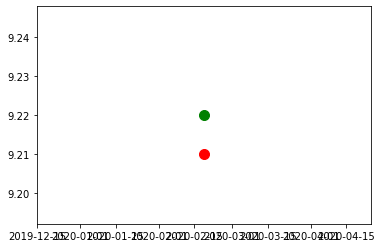

buy time:2020-02-18T19:59:04.324081651Z sell time:2020-02-18T19:59:18.432153828Z
{'rsi': 55.06775341581323, 'macd1': [0.0008020492450757644, 0.0006103878966712273, 0.0006207912516611458, 0.0006218674841846905, 0.001014484276227634], 'macd2': [0.002532412033781739, 0.0024672684570852255, 0.002436974797028313, 0.0024052060601302827, 0.002452099027806298], 'macd_signal': [0.0017994644622470013, 0.0015616491491318464, 0.0013734775696377063, 0.0012231555525471032, 0.0011814212972832093]}
{'rsi': 51.60137993254188, 'macd': [0.000303758760713535, 0.0001875996459617113, 0.00020374060010297512, 0.0002136719851471014, 0.00024980459706291924], 'scalp': 0, 'bail_out': 0, 'movement': -0.00047722342733193094, 'too_close': 0, 'macd_signal': [0.0009448588491519962, 0.0007934070085139392, 0.0006754737268317464, 0.0005831133784948174, 0.0005164516222084378], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.

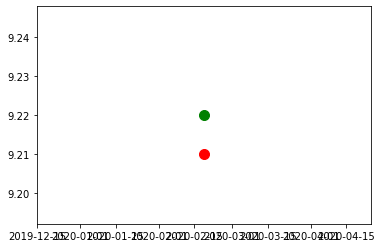

buy time:2020-02-18T20:03:17.108962688Z sell time:2020-02-18T20:03:32.733291673Z
{'rsi': 55.57726087449605, 'macd1': [0.00021676347850885236, -0.00010309593879931356, -0.0007513835627435128, -0.00045301764346561413, 0.00018476782198995068], 'macd2': [0.002292163002216796, 0.0021844937785981955, 0.0020019728435087814, 0.0019907818946816036, 0.0020572698991490057], 'macd_signal': [0.0010218771377394531, 0.0007968825224316997, 0.00048722930539665723, 0.000299179915624203, 0.00027629749689735253]}
{'rsi': 50.38472704088467, 'macd': [-4.110449384597814e-05, -0.0002390977957382745, -0.0006500133842823885, -0.0004422850976375514, -0.00036298662625533495], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007266811279826868, 'too_close': 0, 'macd_signal': [0.00045826980402665827, 0.0003187962840736717, 0.00012503435040245965, 1.1570460794457427e-05, -6.334095661550105e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_t

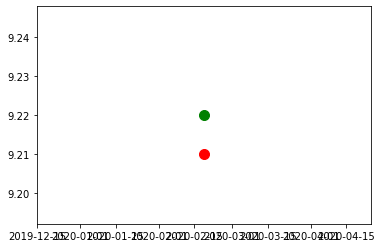

buy time:2020-02-18T20:04:01.087179143Z sell time:2020-02-18T20:04:06.615884813Z
{'rsi': 55.57726087449605, 'macd1': [0.00021676347850885236, -0.00010309593879931356, -0.0007513835627435128, -0.00045301764346561413, 0.00018476782198995068], 'macd2': [0.002292163002216796, 0.0021844937785981955, 0.0020019728435087814, 0.0019907818946816036, 0.0020572698991490057], 'macd_signal': [0.0010218771377394531, 0.0007968825224316997, 0.00048722930539665723, 0.000299179915624203, 0.00027629749689735253]}
{'rsi': 53.95009085469889, 'macd': [-0.0002390977957382745, -0.0006500133842823885, -0.0004422850976375514, -1.4934678203459839e-05, 0.00022475311197922565], 'scalp': 0, 'bail_out': 0, 'movement': -0.00019522776572680411, 'too_close': 0, 'macd_signal': [0.0003187962840736717, 0.00012503435040245965, 1.1570460794457427e-05, 6.269432994873973e-06, 4.996616879174432e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to

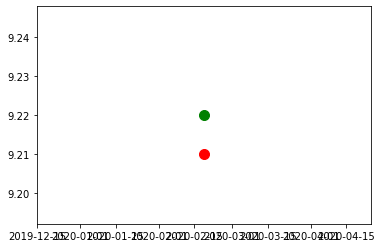

buy time:2020-02-18T20:04:25.186447364Z sell time:2020-02-18T20:04:31.671211847Z
{'rsi': 55.577260874496034, 'macd1': [-0.00010309593879931356, -0.0007513835627435128, -0.00045301764346561413, 0.00018476782198995068, 0.0006823516730225521], 'macd2': [0.0021844937785981955, 0.0020019728435087814, 0.0019907818946816036, 0.0020572698991490057, 0.002115150674310229], 'macd_signal': [0.0007968825224316997, 0.00048722930539665723, 0.000299179915624203, 0.00027629749689735253, 0.00035750833212239245]}
{'rsi': 51.280962632316765, 'macd': [-0.0002390977957382745, -0.0006500133842823885, -0.0004422850976375514, -1.4934678203459839e-05, 5.8519345746077533e-05], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005422993492408656, 'too_close': 0, 'macd_signal': [0.0003187962840736717, 0.00012503435040245965, 1.1570460794457427e-05, 6.269432994873973e-06, 1.6719415545114686e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_

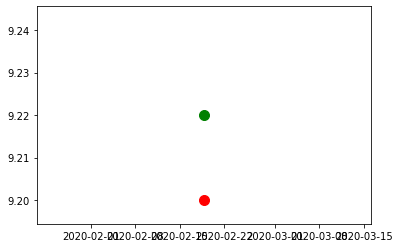

buy time:2020-02-18T20:05:30.962332938Z sell time:2020-02-18T20:06:05.24916598Z
{'rsi': 55.025103172969594, 'macd1': [-0.0007513835627435128, -0.00045301764346561413, 0.00018476782198995068, 0.00028349127416227304, 0.0007564684372702857], 'macd2': [0.0020019728435087814, 0.0019907818946816036, 0.0020572698991490057, 0.002035182661517254, 0.002091574718919631], 'macd_signal': [0.00048722930539665723, 0.000299179915624203, 0.00027629749689735253, 0.00027773625235033664, 0.00037348268933432645]}
{'rsi': 43.48398965327291, 'macd': [-0.0004422850976375514, -1.4934678203459839e-05, 5.8519345746077533e-05, 0.00011499625602162666, -0.00036196973929669696], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016268980477224043, 'too_close': 1, 'macd_signal': [1.1570460794457427e-05, 6.269432994873973e-06, 1.6719415545114686e-05, 3.6374783640417084e-05, -4.329412094700573e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_t

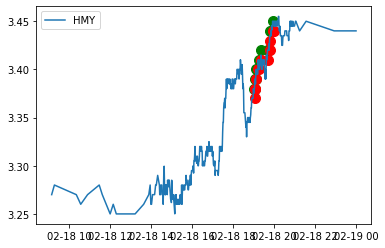

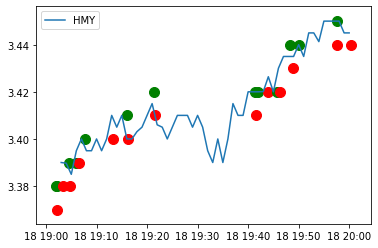

Delta = -0.06999999999999984


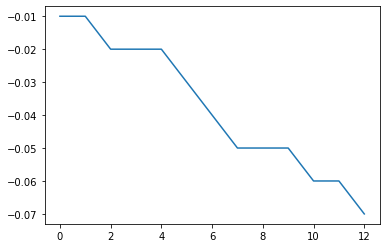

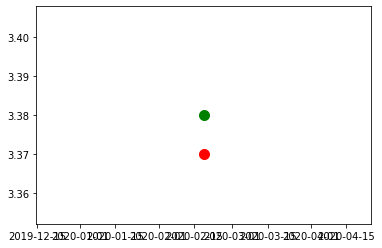

buy time:2020-02-18T19:02:01.687682056Z sell time:2020-02-18T19:02:06.715175279Z
{'rsi': 63.408002659158726, 'macd1': [0.0011915674083096128, 0.0025032250644043685, 0.003103489893944378, 0.003937275844222654, 0.00454565770447779], 'macd2': [-0.0007461950621934221, -0.00045733844093653886, -0.000270817673533319, -1.8811453425637836e-05, 0.00021307241633916618], 'macd_signal': [-0.002603208004843166, -0.001581921390993659, -0.0006448391340060514, 0.00027158386163968976, 0.0011263986302073098]}
{'rsi': 58.27208874161577, 'macd': [0.0012457811738539881, 0.0020688772772672337, 0.002423642068534182, 0.0029283465543454845, 0.003023852042583819], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014792899408283709, 'too_close': 0, 'macd_signal': [-0.001202377963623629, -0.0005481269154454563, 4.622688135047135e-05, 0.000622650815949474, 0.0011028910612763429], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd'

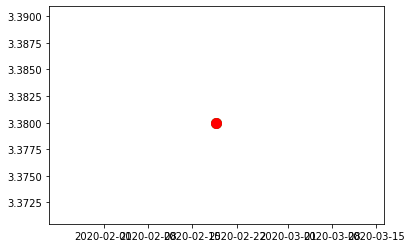

buy time:2020-02-18T19:02:12.038962058Z sell time:2020-02-18T19:03:25.008214441Z
{'rsi': 63.408002659158726, 'macd1': [0.0011915674083096128, 0.0025032250644043685, 0.003103489893944378, 0.003937275844222654, 0.00454565770447779], 'macd2': [-0.0007461950621934221, -0.00045733844093653886, -0.000270817673533319, -1.8811453425637836e-05, 0.00021307241633916618], 'macd_signal': [-0.002603208004843166, -0.001581921390993659, -0.0006448391340060514, 0.00027158386163968976, 0.0011263986302073098]}
{'rsi': 63.408002659158726, 'macd': [0.0020688772772672337, 0.002423642068534182, 0.0029283465543454845, 0.003283592302323779, 0.003517763115004069], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.0005481269154454563, 4.622688135047135e-05, 0.000622650815949474, 0.001154839113224335, 0.001627423913580282], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00189033920142378

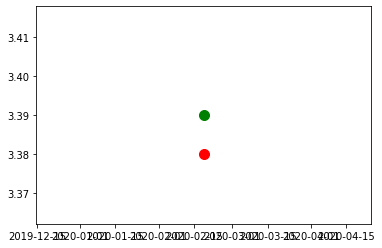

buy time:2020-02-18T19:04:30.965046898Z sell time:2020-02-18T19:04:45.706667249Z
{'rsi': 69.24610785777055, 'macd1': [0.003103489893944378, 0.003937275844222654, 0.00454565770447779, 0.0057682285898121854, 0.006660348473309874], 'macd2': [-0.000270817673533319, -1.8811453425637836e-05, 0.00021307241633916618, 0.000586008239875202, 0.0009281838884143134], 'macd_signal': [-0.0006448391340060514, 0.00027158386163968976, 0.0011263986302073098, 0.002054764622128285, 0.0029758813923646027]}
{'rsi': 63.76785240901358, 'macd': [0.002423642068534182, 0.0029283465543454845, 0.003283592302323779, 0.004037243634484433, 0.004312332417538478], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014749262536874151, 'too_close': 0, 'macd_signal': [4.622688135047135e-05, 0.000622650815949474, 0.001154839113224335, 0.0017313200174763547, 0.0022475224974887794], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0020648

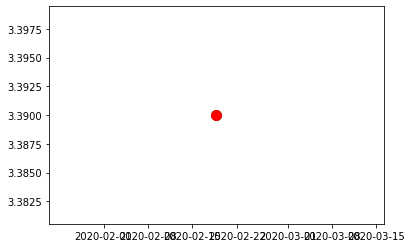

buy time:2020-02-18T19:05:54.876610913Z sell time:2020-02-18T19:06:26.357344478Z
{'rsi': 69.06186387027611, 'macd1': [0.003937275844222654, 0.00454565770447779, 0.0057682285898121854, 0.006636416849378435, 0.007264924268133743], 'macd2': [-1.8811453425637836e-05, 0.00021307241633916618, 0.000586008239875202, 0.0009233858076469481, 0.0012371052159680929], 'macd_signal': [0.00027158386163968976, 0.0011263986302073098, 0.002054764622128285, 0.002971095067578315, 0.0038298609076894007]}
{'rsi': 69.06186387027611, 'macd': [0.0029283465543454845, 0.003283592302323779, 0.004037243634484433, 0.004556488261694636, 0.004917503708070203], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.000622650815949474, 0.001154839113224335, 0.0017313200174763547, 0.002296353666320011, 0.0028205836746700496], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0020969200334001537}


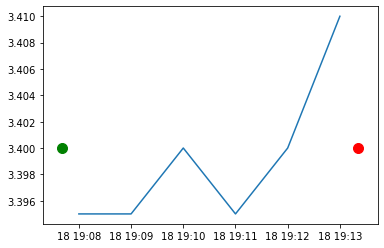

buy time:2020-02-18T19:07:40.848641873Z sell time:2020-02-18T19:13:20.401498414Z
{'rsi': 71.42608692160614, 'macd1': [0.0057682285898121854, 0.006636416849378435, 0.006866063869273464, 0.007765461803729501, 0.008780483412733187], 'macd2': [0.000586008239875202, 0.0009233858076469481, 0.0011571372031733418, 0.0015302813104480784, 0.0019511063666644013], 'macd_signal': [0.002054764622128285, 0.002971095067578315, 0.003750088827917345, 0.004553163423079776, 0.005398627421010458]}
{'rsi': 66.14299337150612, 'macd': [0.005948348281102245, 0.005981175649429904, 0.006188818070861579, 0.006010502839887799, 0.006053237687961843], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.0042013896706817625, 0.0045573468664313905, 0.004883641107317429, 0.005109013453831503, 0.005297858300657571], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0007553793873042725}


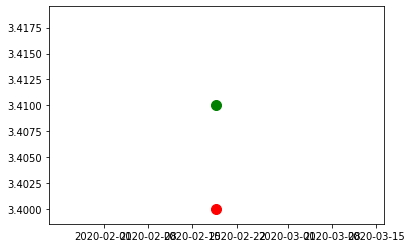

buy time:2020-02-18T19:15:59.918417986Z sell time:2020-02-18T19:16:08.193978571Z
{'rsi': 68.3949254012075, 'macd1': [0.009401385360684689, 0.009537237963022083, 0.010332709512283156, 0.010439330133359626, 0.010802758481685881], 'macd2': [0.0030804082789708254, 0.0033569938310287206, 0.003766028369197816, 0.004056361979293932, 0.004396958616204927], 'macd_signal': [0.007735380244338189, 0.008095751788074968, 0.008543143332916605, 0.00892238069300521, 0.009298456250741344]}
{'rsi': 59.096033694989146, 'macd': [0.006053237687961843, 0.006527404612591159, 0.006552373584866267, 0.006746474425796567, 0.0062906247638490065], 'scalp': 0, 'bail_out': 0, 'movement': -0.0029325513196481615, 'too_close': 1, 'macd_signal': [0.005297858300657571, 0.005543767563044288, 0.0057454887674086835, 0.00594568589908626, 0.00601467367203881], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00027595109181019657}


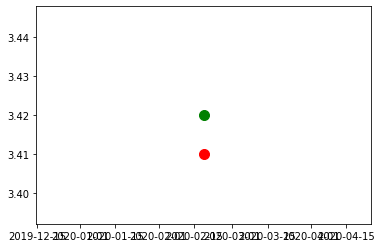

buy time:2020-02-18T19:21:26.280103545Z sell time:2020-02-18T19:21:28.714236131Z
{'rsi': 70.13260105806066, 'macd1': [0.009552444628474266, 0.009209650240019851, 0.008987692810432879, 0.009110231088557796, 0.009900137362433004], 'macd2': [0.00467076843747849, 0.0048301073374310555, 0.004999366985348086, 0.005227063499509299, 0.00558812764388561], 'macd_signal': [0.009488167587791977, 0.009432464118237551, 0.009343509856676617, 0.009296854103052853, 0.009417510754928884]}
{'rsi': 65.11627764233796, 'macd': [0.005853720809553931, 0.005598292782706515, 0.005425254154218795, 0.005479701272874671, 0.0054509626475041095], 'scalp': 0, 'bail_out': 0, 'movement': -0.0029239766081870723, 'too_close': 0, 'macd_signal': [0.005982483099541834, 0.005905645036174771, 0.0058095668597835754, 0.0057435937424017945, 0.005685067523422257], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00023410487591814765}

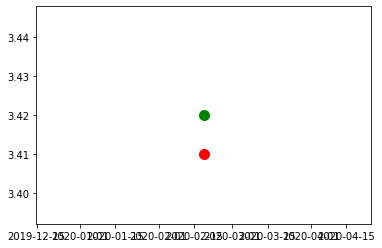

buy time:2020-02-18T19:41:21.984056592Z sell time:2020-02-18T19:41:31.956232486Z
{'rsi': 60.799321154259275, 'macd1': [0.0021360345248546686, 0.0025816184379419127, 0.0029013024902129203, 0.003916424725010081, 0.004667116792443693], 'macd2': [0.0052218423697278915, 0.00526943837278937, 0.005304800487764716, 0.005488786503201393, 0.005649280975615234], 'macd_signal': [0.0032182508767034557, 0.003090924388951147, 0.003053000009203502, 0.0032256849523648176, 0.0035139713203805926]}
{'rsi': 57.22166692512389, 'macd': [0.000927759566621944, 0.0012369169986263806, 0.0014617550365696452, 0.00213745019553091, 0.002376466550623846], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014619883040935362, 'too_close': 0, 'macd_signal': [0.0015854482235094652, 0.0015157419785328482, 0.0015049445901402076, 0.0016314457112183481, 0.0017804498790994477], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00059601667

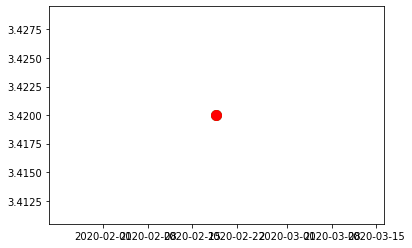

buy time:2020-02-18T19:42:01.019785995Z sell time:2020-02-18T19:43:54.033012521Z
{'rsi': 60.799321154259275, 'macd1': [0.0021360345248546686, 0.0025816184379419127, 0.0029013024902129203, 0.003916424725010081, 0.004667116792443693], 'macd2': [0.0052218423697278915, 0.00526943837278937, 0.005304800487764716, 0.005488786503201393, 0.005649280975615234], 'macd_signal': [0.0032182508767034557, 0.003090924388951147, 0.003053000009203502, 0.0032256849523648176, 0.0035139713203805926]}
{'rsi': 60.79932115425927, 'macd': [0.0014617550365696452, 0.00213745019553091, 0.00263620681036425, 0.0029906118763332046, 0.0032279325527202474], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0015049445901402076, 0.0016314457112183481, 0.0018323979310475285, 0.002064040720104664, 0.0022968190866277808], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009311134660924666}


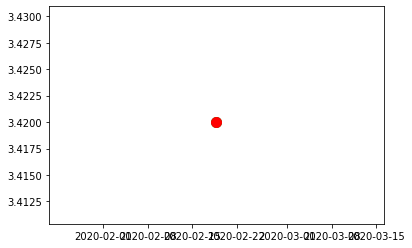

buy time:2020-02-18T19:45:44.499313686Z sell time:2020-02-18T19:46:15.284737693Z
{'rsi': 63.00894465538038, 'macd1': [0.004667116792443693, 0.0052020793319718095, 0.005569903779385932, 0.006297174742124767, 0.006683530342651345], 'macd2': [0.005649280975615234, 0.005787905788538161, 0.005907787464420888, 0.00610939345656325, 0.006262715253481765], 'macd_signal': [0.0035139713203805926, 0.0038515929226988358, 0.004195255094036255, 0.004615639023653957, 0.005029217287453434]}
{'rsi': 60.735629410969025, 'macd': [0.00263620681036425, 0.0029906118763332046, 0.0032331273579151443, 0.003707384520733381, 0.003826190303179544], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007299270072992545, 'too_close': 1, 'macd_signal': [0.0018323979310475285, 0.002064040720104664, 0.00229785804766676, 0.002579763342280084, 0.002829048734459976], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000997141568719568}


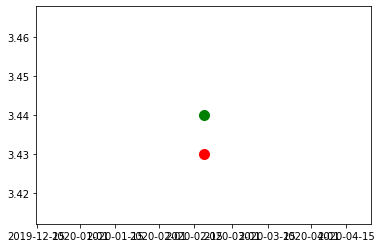

buy time:2020-02-18T19:48:20.714272772Z sell time:2020-02-18T19:48:51.695119942Z
{'rsi': 68.59882266090686, 'macd1': [0.006297174742124767, 0.006284669943790622, 0.007000973364539753, 0.00788125697493225, 0.008879983370824629], 'macd2': [0.00610939345656325, 0.006182747240687014, 0.006400282653844069, 0.0066701538473901145, 0.006987744011708763], 'macd_signal': [0.004615639023653957, 0.00494944520768129, 0.005359750839052982, 0.005864052066228836, 0.006467238327147995]}
{'rsi': 61.997807941091246, 'macd': [0.003707384520733381, 0.003696320173309342, 0.0041591749652738486, 0.004725566037385498, 0.00484579848270128], 'scalp': 0, 'bail_out': 0, 'movement': -0.0029069767441859845, 'too_close': 0, 'macd_signal': [0.002579763342280084, 0.0028030747084859357, 0.0030742947598435184, 0.0034045490153519144, 0.0036927989088217875], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0011529995738794926}


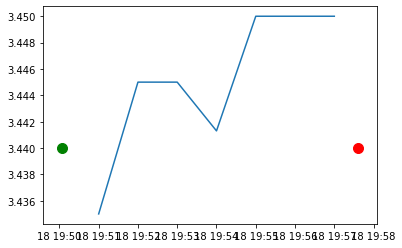

buy time:2020-02-18T19:50:03.455041258Z sell time:2020-02-18T19:57:35.599996591Z
{'rsi': 68.92652353894897, 'macd1': [0.007000973364539753, 0.00788125697493225, 0.008481122971964794, 0.008854452479930774, 0.009444902066172656], 'macd2': [0.006400282653844069, 0.0066701538473901145, 0.006907775998913568, 0.007115347956794249, 0.0073749088057573076], 'macd_signal': [0.005359750839052982, 0.005864052066228836, 0.006387466247376027, 0.0068808634938869765, 0.007393671208344112]}
{'rsi': 59.382267519228584, 'macd': [0.006309948154501477, 0.0062234515651931055, 0.006527175631119153, 0.0066790752197487535, 0.0061912167794631046], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.005205709138243036, 0.00540925762363305, 0.005632841225130271, 0.005842088024053968, 0.005911913775135795], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0002793030043273092}


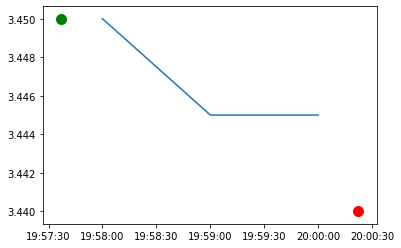

buy time:2020-02-18T19:57:37.123259628Z sell time:2020-02-18T20:00:22.078231149Z
{'rsi': 69.3024229907894, 'macd1': [0.010456712872566776, 0.010355392864058732, 0.01085201800993918, 0.011117442064290994, 0.011198700886767998], 'macd2': [0.008053197240534882, 0.00820936319404808, 0.008479055479637232, 0.008713619944739737, 0.008915490538271342], 'macd_signal': [0.00868938502660722, 0.009022586594097524, 0.009388472877265856, 0.009734266714670883, 0.010027153549090307]}
{'rsi': 63.18183292206443, 'macd': [0.0066790752197487535, 0.006710697298943469, 0.006648185967160991, 0.006253395501263803, 0.005864553638210257], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014492753623189384, 'too_close': 1, 'macd_signal': [0.005842088024053968, 0.006015809879031868, 0.006142285096657692, 0.006164507177578915, 0.0061045164697051835], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00023996283149492655}
BE 

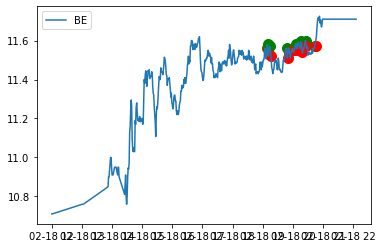

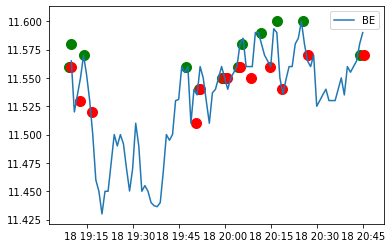

Delta = -0.3000000000000007


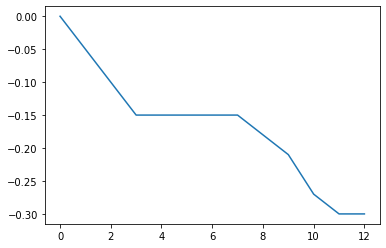

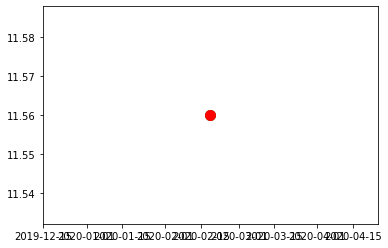

buy time:2020-02-18T19:09:21.836751954Z sell time:2020-02-18T19:09:46.886924828Z
{'rsi': 61.53930766666574, 'macd1': [0.010034481542577467, 0.01098247861573931, 0.01048324579709714, 0.013482613294776513, 0.016476617877918542], 'macd2': [-0.0014973373089315345, -0.0009610526693091259, -0.0006900270129914787, 0.0002641473745494949, 0.001301531891236607], 'macd_signal': [-0.000762372892852959, 0.0015865974088654952, 0.003365927086511824, 0.005389264328164762, 0.0076067350381155184]}
{'rsi': 59.649629882789924, 'macd': [0.007185331845359855, 0.007724777739287703, 0.007317530673006445, 0.009190876716514751, 0.010427368741112275], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010380622837370635, 'too_close': 0, 'macd_signal': [0.00021051080083239748, 0.0017133641885234586, 0.002834197485420056, 0.004105533331638995, 0.00536990041353365], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0050574683275

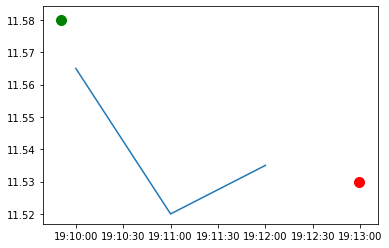

buy time:2020-02-18T19:09:50.788367521Z sell time:2020-02-18T19:12:59.386451409Z
{'rsi': 64.13219983423042, 'macd1': [0.010034481542577467, 0.01098247861573931, 0.01048324579709714, 0.013482613294776513, 0.018072059473357882], 'macd2': [-0.0014973373089315345, -0.0009610526693091259, -0.0006900270129914787, 0.0002641473745494949, 0.001621403942413835], 'macd_signal': [-0.000762372892852959, 0.0015865974088654952, 0.003365927086511824, 0.005389264328164762, 0.007925823357203387]}
{'rsi': 54.732775039763816, 'macd': [0.007317530673006445, 0.009190876716514751, 0.012089706403449085, 0.01341230477763844, 0.012710273578596443], 'scalp': 0, 'bail_out': 0, 'movement': -0.0038860103626942944, 'too_close': 0, 'macd_signal': [0.002834197485420056, 0.004105533331638995, 0.005702367946001013, 0.007244355312328498, 0.008337538965582087], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00437273461301435

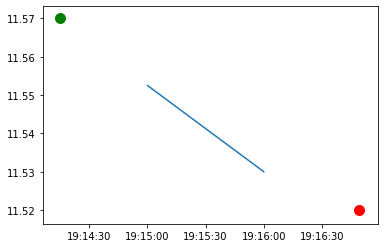

buy time:2020-02-18T19:14:14.92433458Z sell time:2020-02-18T19:16:49.227829032Z
{'rsi': 59.63155736507469, 'macd1': [0.020265248821553783, 0.018162872968185084, 0.01750530928855909, 0.01798721456191643, 0.01975523476683172], 'macd2': [0.0026276261522859556, 0.0028294681356140217, 0.00325054791614221, 0.003872660024629937, 0.004758701336717408], 'macd_signal': [0.010393708450073466, 0.01194754135369579, 0.01305909494066845, 0.014044718864918046, 0.015186822045300781]}
{'rsi': 50.85844539310107, 'macd': [0.011401102520219197, 0.011619308763469505, 0.012677400527515204, 0.012428155141998687, 0.01060759828131097], 'scalp': 0, 'bail_out': 0, 'movement': -0.0030882352941176716, 'too_close': 1, 'macd_signal': [0.008825576351834258, 0.009384322834161306, 0.010042938372832086, 0.010519981726665406, 0.010537505037594519], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 7.009324371645177e-05}


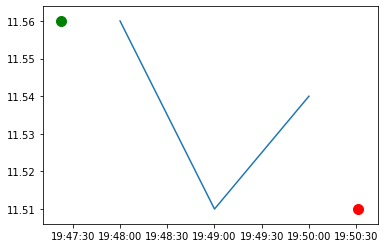

buy time:2020-02-18T19:47:22.645672766Z sell time:2020-02-18T19:50:31.447593476Z
{'rsi': 66.30546494570194, 'macd1': [-0.0026066423022594876, 0.0020950476593384337, 0.005834604778433672, 0.011011356313012755, 0.014941730235397799], 'macd2': [-0.004097415961044959, -0.003171499700613367, -0.0022985611504111603, -0.0010279390598011418, 0.00014271795208564697], 'macd_signal': [-0.008602546187896845, -0.006463027418449788, -0.004003500979073096, -0.0010005295206559255, 0.0021879224305548194]}
{'rsi': 52.29192986387978, 'macd': [0.0076239032767713155, 0.009848164362798784, 0.011723586451095613, 0.010435297345207317, 0.009295912362111025], 'scalp': 0, 'bail_out': 0, 'movement': -0.0035149689193634554, 'too_close': 0, 'macd_signal': [-0.0002178353621238734, 0.001795364582860658, 0.0037810089565076493, 0.005111866634247583, 0.005948675779820271], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003

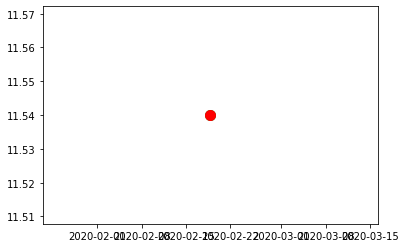

buy time:2020-02-18T19:51:35.568912107Z sell time:2020-02-18T19:52:06.603360246Z
{'rsi': 57.82657671376873, 'macd1': [0.014526915420583819, 0.01753053676787708, 0.0156954191708234, 0.01647194619112824, 0.01689262182024187], 'macd2': [5.955121878109537e-05, 0.0011431485503035077, 0.001338584322247982, 0.0019960586820868542, 0.0025977637069800608], 'macd_signal': [0.0021049594675920233, 0.005190074927649035, 0.007291143776283909, 0.009127304259252775, 0.010680367771450594]}
{'rsi': 57.82657671376873, 'macd': [0.009848164362798784, 0.011723586451095613, 0.010435297345207317, 0.010854353920551674, 0.011039925876398016], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.001795364582860658, 0.0037810089565076493, 0.005111866634247583, 0.006260364091508401, 0.007216276448486323], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0038236494279116923}


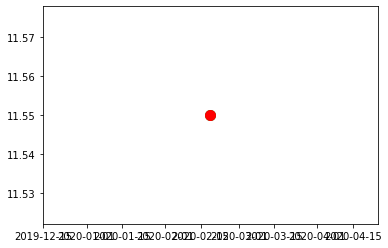

buy time:2020-02-18T19:59:06.518037946Z sell time:2020-02-18T19:59:34.823750232Z
{'rsi': 57.15223920704131, 'macd1': [0.014298449802902624, 0.013964738532267873, 0.013799412168868486, 0.014310345506160616, 0.014547568542431222], 'macd2': [0.004209121858337994, 0.004553167564223415, 0.004913597991647478, 0.005397282926288938, 0.005833656338085191], 'macd_signal': [0.014235232047174523, 0.014181133344193193, 0.014104789109128251, 0.014145900388534725, 0.014226234019314023]}
{'rsi': 57.15223920704131, 'macd': [0.009003076969108292, 0.008720332665729913, 0.008552995121984708, 0.008831004891508343, 0.008932947505533306], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.009256495982525025, 0.009149263319166002, 0.009030009679729743, 0.008990208722085464, 0.008978756478775033], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -4.5808973241726406e-05}


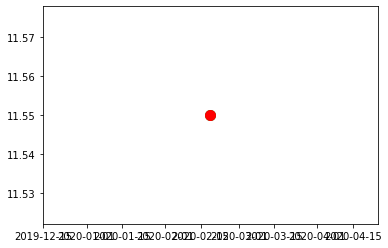

buy time:2020-02-18T20:00:18.092888585Z sell time:2020-02-18T20:00:54.221664992Z
{'rsi': 58.60789909646471, 'macd1': [0.014298449802902624, 0.013964738532267873, 0.013799412168868486, 0.014310345506160616, 0.015161813556675341], 'macd2': [0.004209121858337994, 0.004553167564223415, 0.004913597991647478, 0.005397282926288938, 0.005956807077790671], 'macd_signal': [0.014235232047174523, 0.014181133344193193, 0.014104789109128251, 0.014145900388534725, 0.014349083022162848]}
{'rsi': 56.372131851418025, 'macd': [0.008720332665729913, 0.008552995121984708, 0.008831004891508343, 0.009452428025014115, 0.009294414518329575], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006662225183211034, 'too_close': 1, 'macd_signal': [0.009149263319166002, 0.009030009679729743, 0.008990208722085464, 0.009082652582671194, 0.00912500496980287], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0001694095485267038}


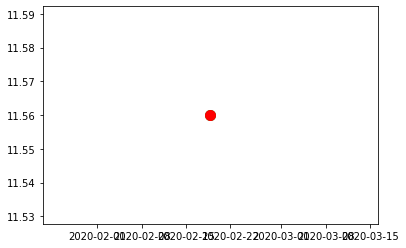

buy time:2020-02-18T20:04:11.048318725Z sell time:2020-02-18T20:05:04.521185356Z
{'rsi': 58.17222629309763, 'macd1': [0.01519152408940272, 0.014092231951755352, 0.013868088744747098, 0.013933297471510286, 0.014224463311892421], 'macd2': [0.006374293541592024, 0.00655282062524698, 0.006866526957510999, 0.007224132780265791, 0.007621555597951968], 'macd_signal': [0.014546927360967053, 0.014455988279124712, 0.01433840837224919, 0.01425738619210141, 0.014250801616059612]}
{'rsi': 58.17222629309763, 'macd': [0.00929960932352536, 0.008535080344136858, 0.008347978797287325, 0.00835351033484244, 0.008509073736380657], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.009126043930842027, 0.009007851213500994, 0.00887587673025826, 0.008771403451175096, 0.008718937508216208], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00020986377183555144}


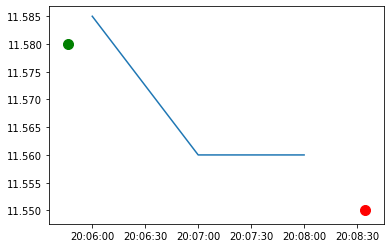

buy time:2020-02-18T20:05:46.279545956Z sell time:2020-02-18T20:08:34.467001359Z
{'rsi': 62.39568183166184, 'macd1': [0.014092231951755352, 0.013868088744747098, 0.013933297471510286, 0.014224463311892421, 0.01588592414624479], 'macd2': [0.00655282062524698, 0.006866526957510999, 0.007224132780265791, 0.007621555597951968, 0.008294879740736505], 'macd_signal': [0.014455988279124712, 0.01433840837224919, 0.01425738619210141, 0.014250801616059612, 0.014577826122096647]}
{'rsi': 52.681764164996906, 'macd': [0.008509073736380657, 0.009558745559184345, 0.010512272361898667, 0.009820055943730921, 0.008638847618614776], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008564013840830466, 'too_close': 1, 'macd_signal': [0.008718937508216208, 0.008886899118409836, 0.009211973767107601, 0.009333590202432265, 0.009194641685668766], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0005557940670539909}


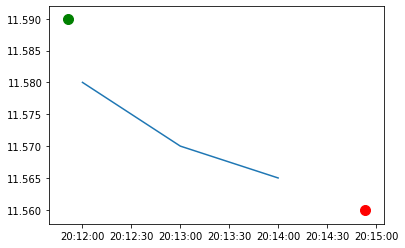

buy time:2020-02-18T20:11:50.97914036Z sell time:2020-02-18T20:14:53.520414256Z
{'rsi': 63.5664743754937, 'macd1': [0.0164033295158319, 0.015431249903024025, 0.014493794367027135, 0.015987311603874232, 0.01739006942073118], 'macd2': [0.009198165694746407, 0.009383197776312358, 0.009538426096417751, 0.010145793813400417, 0.010771531494937037], 'macd_signal': [0.015395348653533225, 0.015402528903431386, 0.015220781996150536, 0.015374087917695275, 0.015777284218302455]}
{'rsi': 53.79336950587642, 'macd': [0.009464871247514495, 0.010082436347598644, 0.009913234654836955, 0.009133165353272688, 0.008146966347466034], 'scalp': 0, 'bail_out': 0, 'movement': -0.00043215211754544353, 'too_close': 1, 'macd_signal': [0.009205706542151033, 0.009381052503240556, 0.009487488933559836, 0.009416624217502407, 0.009162692643495132], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0010157262960290986}


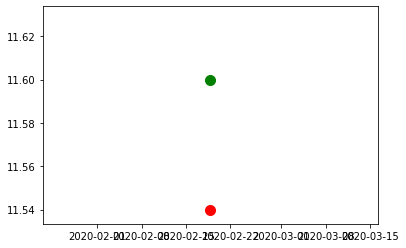

buy time:2020-02-18T20:17:08.442861536Z sell time:2020-02-18T20:18:36.701360327Z
{'rsi': 62.46664083256298, 'macd1': [0.01559929142033667, 0.014114752649502904, 0.01239194019201939, 0.013565327124851478, 0.01485655247536144], 'macd2': [0.011129361205901134, 0.011140933973546652, 0.011053794910154124, 0.011490131509713564, 0.011978756055713191], 'macd_signal': [0.015845521972414723, 0.015499368107832359, 0.014877882524669764, 0.014615371444706107, 0.014663607650837174]}
{'rsi': 46.536300691481706, 'macd': [0.008146966347466034, 0.007012954572193308, 0.0077732966359800315, 0.008088195690412192, 0.005890867736844996], 'scalp': 0, 'bail_out': 0, 'movement': -0.004741379310344803, 'too_close': 1, 'macd_signal': [0.009162692643495132, 0.008732745029234767, 0.00854085535058382, 0.008450323418549495, 0.007938432282208596], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0020475645453635997}


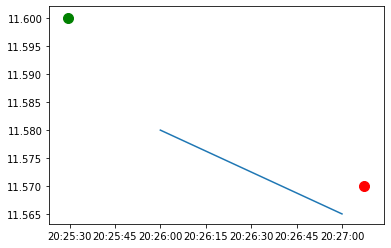

buy time:2020-02-18T20:25:29.34236353Z sell time:2020-02-18T20:27:07.384672208Z
{'rsi': 60.948920890925365, 'macd1': [0.005038246799971446, 0.004490594746613397, 0.0056057893515699675, 0.006814494077943323, 0.008880408104840143], 'macd2': [0.010406199316294718, 0.0102535828255359, 0.010416643650589918, 0.010629972872440163, 0.011049145462598275], 'macd_signal': [0.009953448796985525, 0.0088608779869111, 0.008209860259842872, 0.007930787023462962, 0.008120711239738398]}
{'rsi': 53.918120024965965, 'macd': [0.0026965347830252284, 0.0035141047902413902, 0.004884755383004702, 0.0048503953853771264, 0.004667122719883565], 'scalp': 0, 'bail_out': 0, 'movement': -0.0018793103448274942, 'too_close': 1, 'macd_signal': [0.004340539486502095, 0.004175252547249954, 0.0043171531144009035, 0.004423801568596148, 0.004472465798853632], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0001946569210299334}


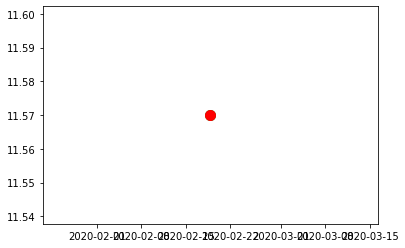

buy time:2020-02-18T20:44:13.12741199Z sell time:2020-02-18T20:45:24.176517261Z
{'rsi': 56.19690681397495, 'macd1': [-0.004542072829627486, -0.0034389362278677282, -0.0021366048592206255, -0.0006930505976399104, 0.0008446976198115408], 'macd2': [0.005164035432134284, 0.005092429491655892, 0.005098373119402311, 0.005175655324507034, 0.005318447700615181], 'macd_signal': [-0.004457714803742314, -0.004253959088567396, -0.003830488242698042, -0.0032030007136864156, -0.0023934610469868245]}
{'rsi': 0, 'macd': [], 'bail_out': 0, 'too_close': 0, 'macd_signal': [], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0}
I analysis for run 66


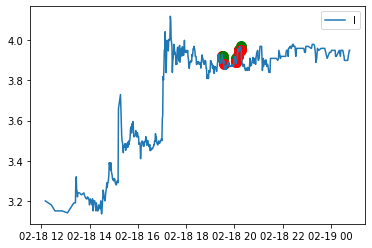

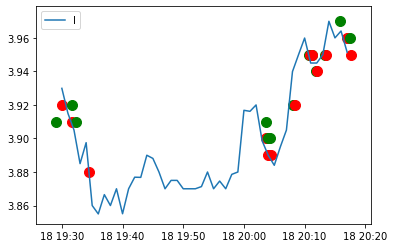

Delta = -0.08000000000000007


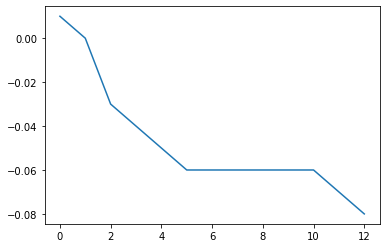

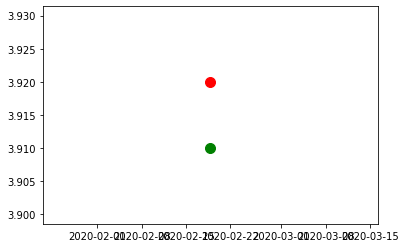

buy time:2020-02-18T19:29:05.612051148Z sell time:2020-02-18T19:30:00.671359072Z
{'rsi': 57.52520800154697, 'macd1': [0.010229905497320502, 0.008892499683602395, 0.00814219598700161, 0.008506576897220341, 0.009245546819503403], 'macd2': [0.00012990644699595322, 0.00020103853086661516, 0.00034612880310325167, 0.0006885791034645372, 0.0011128989054305372], 'macd_signal': [0.006453044688530835, 0.006940935687545146, 0.0071811877474364395, 0.00744626557739322, 0.0078061218258152565]}
{'rsi': 61.06430051032415, 'macd': [0.006805585790062185, 0.005870865477374476, 0.005326007240509245, 0.005512792935932431, 0.006760771491639783], 'scalp': 0, 'bail_out': 1, 'movement': 0.004015345268542155, 'too_close': 0, 'macd_signal': [0.004549987690336545, 0.004814163247744131, 0.004916532046297154, 0.005035784224224209, 0.005380781677707324], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001379989813932459

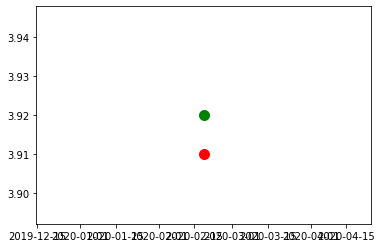

buy time:2020-02-18T19:31:39.837288168Z sell time:2020-02-18T19:31:41.408992054Z
{'rsi': 62.33921888754207, 'macd1': [0.00814219598700161, 0.008506576897220341, 0.010497968471924857, 0.012273583312825131, 0.01365249997378326], 'macd2': [0.00034612880310325167, 0.0006885791034645372, 0.0013639984656066417, 0.00205039748936775, 0.0027042169870554744], 'macd_signal': [0.0071811877474364395, 0.00744626557739322, 0.008056606156299547, 0.008900001587604664, 0.009850501264840383]}
{'rsi': 56.88261351659089, 'macd': [0.005326007240509245, 0.005512792935932431, 0.006760771491639783, 0.007863601905286455, 0.007846799605462085], 'scalp': 0, 'bail_out': 0, 'movement': -0.004196871423120992, 'too_close': 0, 'macd_signal': [0.004916532046297154, 0.005035784224224209, 0.005380781677707324, 0.00587734572322315, 0.006271236499670937], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0015755631057911479}


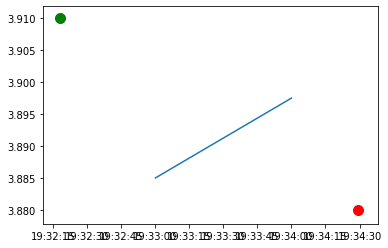

buy time:2020-02-18T19:32:17.9562752Z sell time:2020-02-18T19:34:29.534151747Z
{'rsi': 57.64584539300539, 'macd1': [0.00814219598700161, 0.008506576897220341, 0.010497968471924857, 0.012273583312825131, 0.012527713648996741], 'macd2': [0.00034612880310325167, 0.0006885791034645372, 0.0013639984656066417, 0.00205039748936775, 0.0024787071909737612], 'macd_signal': [0.0071811877474364395, 0.00744626557739322, 0.008056606156299547, 0.008900001587604664, 0.00962554399988308]}
{'rsi': 47.90635133621526, 'macd': [0.007863601905286455, 0.007846799605462085, 0.007212319896436892, 0.005585292592047875, 0.004244942840679222], 'scalp': 0, 'bail_out': 0, 'movement': -0.0012853470437018861, 'too_close': 1, 'macd_signal': [0.00587734572322315, 0.006271236499670937, 0.0064594531790241275, 0.006284621061628877, 0.005876685417438946], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0016317425767597236}


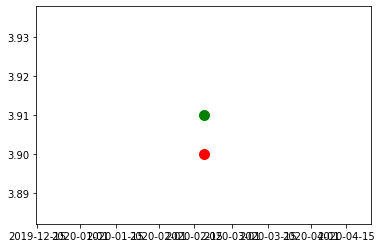

buy time:2020-02-18T20:03:34.80869889Z sell time:2020-02-18T20:03:39.052781963Z
{'rsi': 60.66213234886265, 'macd1': [-0.0014164611735227872, 0.0020095529911325904, 0.004622987986333982, 0.006921001296120721, 0.00784484646708039], 'macd2': [-0.0010060092482162553, -0.0003488266490538905, 0.00024676410155333173, 0.0008551076684231163, 0.0012534995583441955], 'macd_signal': [-0.002309293437274173, -0.0014455241515928204, -0.00023182172400746, 0.0011987428800181764, 0.002527963597430619]}
{'rsi': 55.917138011359924, 'macd': [-0.0008220807582595135, 0.0014133970352667724, 0.0031058031466479896, 0.004581628647118308, 0.0046331598338857916], 'scalp': 0, 'bail_out': 0, 'movement': -0.002557544757033307, 'too_close': 0, 'macd_signal': [-0.0014569172921128572, -0.0008828544266369313, -8.512291197994705e-05, 0.000848227399839704, 0.0016052138866489217], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0

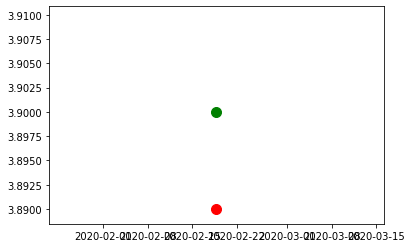

buy time:2020-02-18T20:03:56.096611593Z sell time:2020-02-18T20:04:01.727037463Z
{'rsi': 55.917138011359924, 'macd1': [-0.0014164611735227872, 0.0020095529911325904, 0.004622987986333982, 0.006921001296120721, 0.007047125669359389], 'macd2': [-0.0010060092482162553, -0.0003488266490538905, 0.00024676410155333173, 0.0008551076684231163, 0.0010935635327546933], 'macd_signal': [-0.002309293437274173, -0.0014455241515928204, -0.00023182172400746, 0.0011987428800181764, 0.002368419437886419]}
{'rsi': 55.311433268558055, 'macd': [-0.0008220807582595135, 0.0014133970352667724, 0.0031058031466479896, 0.004581628647118308, 0.004560432561158567], 'scalp': 0, 'bail_out': 0, 'movement': -0.0003589743589743194, 'too_close': 0, 'macd_signal': [-0.0014569172921128572, -0.0008828544266369313, -8.512291197994705e-05, 0.000848227399839704, 0.0015906684321034766], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd'

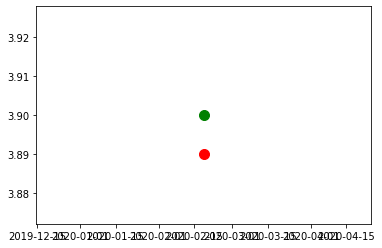

buy time:2020-02-18T20:04:12.827528359Z sell time:2020-02-18T20:04:30.754067391Z
{'rsi': 55.82673338342806, 'macd1': [0.0020095529911325904, 0.004622987986333982, 0.006921001296120721, 0.0069354447576790434, 0.006979405364225144], 'macd2': [-0.0003488266490538905, 0.00024676410155333173, 0.0008551076684231163, 0.0010711724891718788, 0.0012906368884468833], 'macd_signal': [-0.0014455241515928204, -0.00023182172400746, 0.0011987428800181764, 0.0023460832555503497, 0.0032727476772853085]}
{'rsi': 53.70058654849467, 'macd': [0.0014133970352667724, 0.0031058031466479896, 0.004581628647118308, 0.004560432561158567, 0.004297676746629175], 'scalp': 0, 'bail_out': 0, 'movement': -0.0012820512820512547, 'too_close': 0, 'macd_signal': [-0.0008828544266369313, -8.512291197994705e-05, 0.000848227399839704, 0.0015906684321034766, 0.0021320700950086162], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00

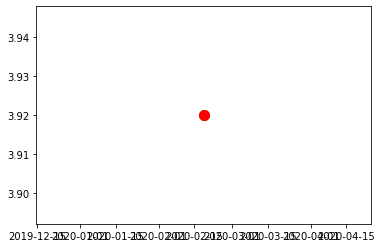

buy time:2020-02-18T20:08:08.474304107Z sell time:2020-02-18T20:08:20.647889634Z
{'rsi': 61.942062265212236, 'macd1': [0.006181684566504586, 0.0050420526837720026, 0.004969212289223535, 0.005653235201879436, 0.007321307453084458], 'macd2': [0.001130700862856937, 0.0010876988574182178, 0.0012223256427263962, 0.0015041676780818136, 0.0020009696983298575], 'macd_signal': [0.003113203517741197, 0.003498973350947358, 0.003793021138602593, 0.004165063951257961, 0.004796312651623261]}
{'rsi': 61.942062265212236, 'macd': [0.004037936486888771, 0.0032666676434724984, 0.003194683250635766, 0.0036165826425724745, 0.004677587588983734], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0020801220430605354, 0.002317431163142928, 0.0024928815806414956, 0.002717621793027691, 0.0031096149522188998], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001567972636764834}


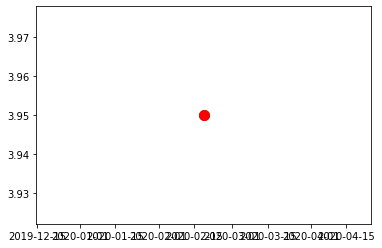

buy time:2020-02-18T20:10:41.773955499Z sell time:2020-02-18T20:10:49.102300729Z
{'rsi': 70.09339360863697, 'macd1': [0.004969212289223535, 0.005653235201879436, 0.008908771840548724, 0.0121635794994428, 0.014973886588326657], 'macd2': [0.0012223256427263962, 0.0015041676780818136, 0.0023192423892535174, 0.0032269632772381485, 0.004136902465619929], 'macd_signal': [0.003793021138602593, 0.004165063951257961, 0.005113805529116114, 0.006523760323181451, 0.008213785576210492]}
{'rsi': 69.04215758489511, 'macd': [0.003194683250635766, 0.0036165826425724745, 0.005711353822749565, 0.007794144952462556, 0.009315876417791191], 'scalp': 0, 'bail_out': 0, 'movement': -0.0012642225031605293, 'too_close': 0, 'macd_signal': [0.0024928815806414956, 0.002717621793027691, 0.003316368198972066, 0.004211923549670164, 0.005232714123294369], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004083162294496822}


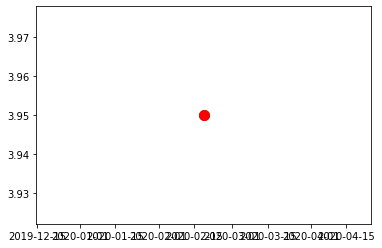

buy time:2020-02-18T20:11:13.62770358Z sell time:2020-02-18T20:11:15.468388646Z
{'rsi': 69.04215758489511, 'macd1': [0.004969212289223535, 0.005653235201879436, 0.008908771840548724, 0.0121635794994428, 0.014575026189465934], 'macd2': [0.0012223256427263962, 0.0015041676780818136, 0.0023192423892535174, 0.0032269632772381485, 0.004056934452825178], 'macd_signal': [0.003793021138602593, 0.004165063951257961, 0.005113805529116114, 0.006523760323181451, 0.008134013496438348]}
{'rsi': 66.40336264656514, 'macd': [0.0036165826425724745, 0.005711353822749565, 0.007794144952462556, 0.009830162132076659, 0.010774718867723188], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.002717621793027691, 0.003316368198972066, 0.004211923549670164, 0.005335571266151463, 0.0064234007864658075], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00435131808125738}


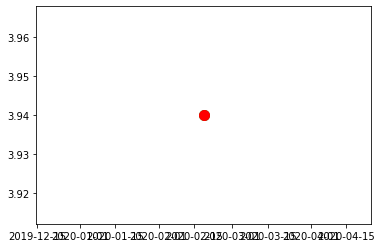

buy time:2020-02-18T20:11:56.552296844Z sell time:2020-02-18T20:11:57.986322833Z
{'rsi': 62.283471480924845, 'macd1': [0.005653235201879436, 0.008908771840548724, 0.0121635794994428, 0.015364769779209642, 0.016110263362739463], 'macd2': [0.0015041676780818136, 0.0023192423892535174, 0.0032269632772381485, 0.004215271118158892, 0.004799531516993749], 'macd_signal': [0.004165063951257961, 0.005113805529116114, 0.006523760323181451, 0.00829196221438709, 0.009855622444057565]}
{'rsi': 62.283471480924845, 'macd': [0.0036165826425724745, 0.005711353822749565, 0.007794144952462556, 0.009830162132076659, 0.01025523834824238], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.002717621793027691, 0.003316368198972066, 0.004211923549670164, 0.005335571266151463, 0.006319504682569646], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003935733665672733}


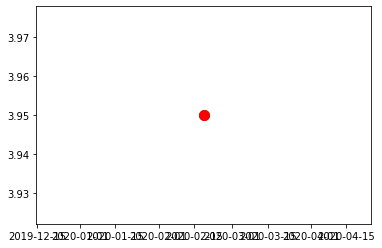

buy time:2020-02-18T20:13:18.203015363Z sell time:2020-02-18T20:13:30.38250028Z
{'rsi': 65.55634929338967, 'macd1': [0.0121635794994428, 0.015364769779209642, 0.016509123761600186, 0.017217559232001634, 0.017975250164858014], 'macd2': [0.0032269632772381485, 0.004215271118158892, 0.004879499529788944, 0.005482806837682208, 0.006109067888506736], 'macd_signal': [0.006523760323181451, 0.00829196221438709, 0.009935394523829709, 0.011391827465464095, 0.012708512005342879]}
{'rsi': 65.55634929338967, 'macd': [0.007794144952462556, 0.009830162132076659, 0.010514978607982783, 0.01091204367222165, 0.011339470427833565], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.004211923549670164, 0.005335571266151463, 0.006371452734517727, 0.007279570922058511, 0.008091550823213521], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0032479196046200434}


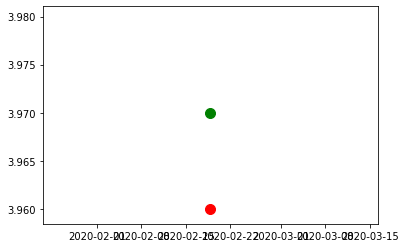

buy time:2020-02-18T20:15:52.966352459Z sell time:2020-02-18T20:16:57.786251247Z
{'rsi': 70.15996391879001, 'macd1': [0.016509123761600186, 0.017217559232001634, 0.017975250164858014, 0.01995150089384934, 0.02128045515851351], 'macd2': [0.004879499529788944, 0.005482806837682208, 0.006109067888506736, 0.006993750178148073, 0.007798100017313292], 'macd_signal': [0.009935394523829709, 0.011391827465464095, 0.012708512005342879, 0.01415710978304417, 0.015581778858138039]}
{'rsi': 65.47208726617784, 'macd': [0.01091204367222165, 0.011339470427833565, 0.01255903062145558, 0.012831947257765375, 0.012877960906087615], 'scalp': 0, 'bail_out': 0, 'movement': -0.0025188916876574888, 'too_close': 0, 'macd_signal': [0.007279570922058511, 0.008091550823213521, 0.008985046782861933, 0.009754426877842622, 0.01037913368349162], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002498827222595996}


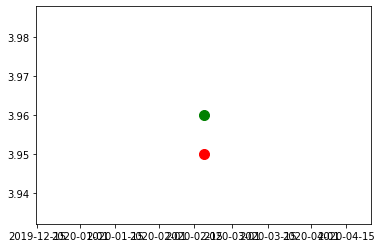

buy time:2020-02-18T20:17:26.292186526Z sell time:2020-02-18T20:17:39.067509943Z
{'rsi': 66.46710191716771, 'macd1': [0.017217559232001634, 0.017975250164858014, 0.01995150089384934, 0.020482734360792954, 0.02099258697038353], 'macd2': [0.005482806837682208, 0.006109067888506736, 0.006993750178148073, 0.00763816399172379, 0.008284402907785093], 'macd_signal': [0.011391827465464095, 0.012708512005342879, 0.01415710978304417, 0.015422234698593927, 0.016536305152951847]}
{'rsi': 60.05729620621467, 'macd': [0.011339470427833565, 0.01255903062145558, 0.012831947257765375, 0.013090947919074836, 0.012390286773094061], 'scalp': 0, 'bail_out': 0, 'movement': -0.0035569233874019326, 'too_close': 0, 'macd_signal': [0.008091550823213521, 0.008985046782861933, 0.009754426877842622, 0.010421731086089065, 0.010815442223490065], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0015748445496039966}
CNX anal

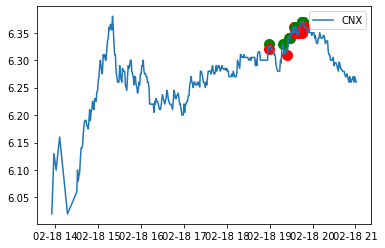

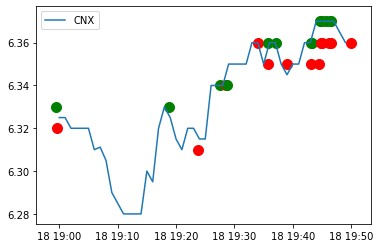

Delta = -0.10000000000000142


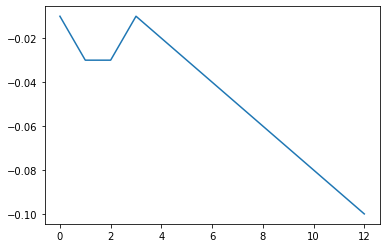

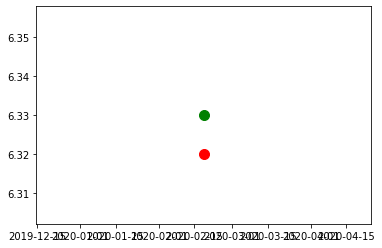

buy time:2020-02-18T18:59:30.050377186Z sell time:2020-02-18T18:59:31.4719601Z
{'rsi': 72.71180182376779, 'macd1': [0.000276663500033969, 0.00013902841047741532, 2.9610281503167357e-05, 0.0019378483823748738, 0.00380968338012444], 'macd2': [0.00452938825001592, 0.004399261460902082, 0.004272504648588971, 0.004548891116511022, 0.004875868204964995], 'macd_signal': [0.0013153699136090745, 0.0010801016129827427, 0.0008700033466868276, 0.0010835723538244369, 0.0016287945590844374]}
{'rsi': 70.24121316229966, 'macd': [-7.014153543849488e-05, -0.00014499123421440885, -0.00020143267177719082, 0.0010559042946898245, 0.00202193434265574], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007898894154818157, 'too_close': 0, 'macd_signal': [0.0005615633083722756, 0.0004202523998549387, 0.00029591538552851276, 0.0004479131673607751, 0.0007627174024197681], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0012

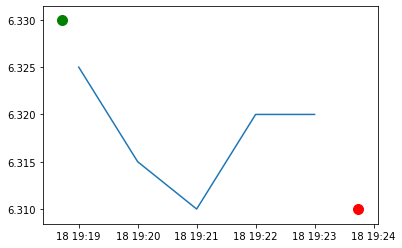

buy time:2020-02-18T19:18:42.889269285Z sell time:2020-02-18T19:23:44.397984701Z
{'rsi': 66.11721513514347, 'macd1': [-0.006618800741270192, -0.005589382320787983, -0.005118021651512095, -0.002696094954484529, 2.9871488537835944e-05], 'macd2': [0.00219074773569794, 0.0021105861935266645, 0.00195349141011647, 0.002205674911809119, 0.002594100156809276], 'macd_signal': [-0.0021466053565008004, -0.002835160749358237, -0.0032917329297890087, -0.0031726053347281126, -0.002532109970074923]}
{'rsi': 51.64218004746015, 'macd': [0.0011340837928859315, 0.0014886633258939241, 0.0014858855162138696, 0.0019839042941738327, 0.0018267253640891212], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015822784810127649, 'too_close': 0, 'macd_signal': [-0.001192037131033801, -0.0006558970396482559, -0.00022754052847583084, 0.0002147484360541019, 0.0005371438216611058], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 

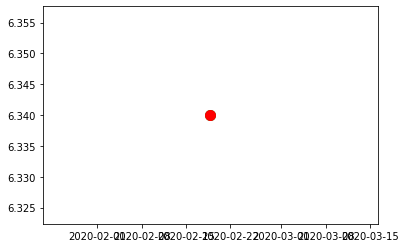

buy time:2020-02-18T19:27:32.047223884Z sell time:2020-02-18T19:28:29.267476164Z
{'rsi': 67.52891498761238, 'macd1': [0.0036497546957701132, 0.0036553131310421705, 0.0036180120403743743, 0.005541858626997076, 0.007384851153531713], 'macd2': [0.0032341015676262685, 0.0032720736422664487, 0.0033017759410185477, 0.0037236623407235214, 0.004185823858660953], 'macd_signal': [0.0010698207720062328, 0.0015869192438134204, 0.001993137803125611, 0.002702881967899904, 0.003639275805026266]}
{'rsi': 65.7648726532888, 'macd': [0.0023462058835699295, 0.0023383083443508923, 0.0023017867768517775, 0.0035421363765033576, 0.004462640786926819], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007880220646177925, 'too_close': 0, 'macd_signal': [0.0006410399255572675, 0.0009804936093159924, 0.0012447522428231494, 0.0017042290695591911, 0.0022559114130327167], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0022067

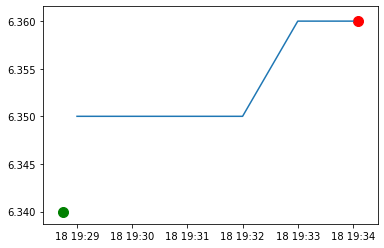

buy time:2020-02-18T19:28:44.310206394Z sell time:2020-02-18T19:34:04.99322276Z
{'rsi': 67.65711041114575, 'macd1': [0.0036553131310421705, 0.0036180120403743743, 0.005541858626997076, 0.006985990754670546, 0.008436681273449764], 'macd2': [0.0032720736422664487, 0.0033017759410185477, 0.0037236623407235214, 0.004105855845865314, 0.004530887366036573], 'macd_signal': [0.0015869192438134204, 0.001993137803125611, 0.002702881967899904, 0.0035595037252540325, 0.004534939234893179]}
{'rsi': 75.3130366631285, 'macd': [0.006762890225272322, 0.00720042080677441, 0.007447841768895458, 0.008063392625498267, 0.00869806351862401], 'scalp': 0, 'bail_out': 1, 'movement': 0.0031520882584713103, 'too_close': 0, 'macd_signal': [0.0041374040917621134, 0.004750007434764573, 0.00528957430159075, 0.005844337966372253, 0.006415083076822604], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0022829804418014066}


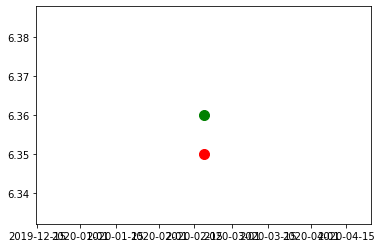

buy time:2020-02-18T19:35:43.866521024Z sell time:2020-02-18T19:35:46.454780246Z
{'rsi': 73.57389968257311, 'macd1': [0.011390274438650927, 0.011834293975793386, 0.012845029579243494, 0.0134905343445757, 0.013842533413202851], 'macd2': [0.005728301308258743, 0.0060708558761719544, 0.006536243575997247, 0.006953961338090231, 0.007327153151454269], 'macd_signal': [0.0074890665718799964, 0.008358112052662674, 0.009255495557978837, 0.01010250331529821, 0.010850509334879138]}
{'rsi': 63.88102354663038, 'macd': [0.00720042080677441, 0.007447841768895458, 0.008063392625498267, 0.008438323258883607, 0.008101407865951593], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015723270440252634, 'too_close': 0, 'macd_signal': [0.004750007434764573, 0.00528957430159075, 0.005844337966372253, 0.006363135024874523, 0.006710789593089937], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0013906182728616557}


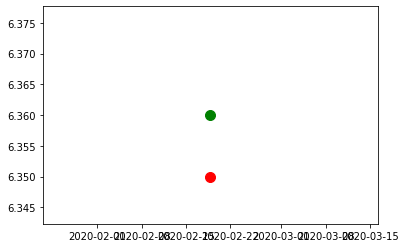

buy time:2020-02-18T19:37:05.195986636Z sell time:2020-02-18T19:38:58.77957041Z
{'rsi': 68.3687821100755, 'macd1': [0.012845029579243494, 0.0134905343445757, 0.013044812615482293, 0.01334466239906451, 0.013427511518406376], 'macd2': [0.006536243575997247, 0.006953961338090231, 0.0071672171258647666, 0.007511892335447357, 0.007816990331411588], 'macd_signal': [0.009255495557978837, 0.01010250331529821, 0.010690965175335026, 0.011221704620080923, 0.011662865999746013]}
{'rsi': 59.75770763226569, 'macd': [0.008438323258883607, 0.008101407865951593, 0.00825314382125164, 0.008264195944586383, 0.0076460002492027], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015723270440252634, 'too_close': 1, 'macd_signal': [0.006363135024874523, 0.006710789593089937, 0.007019260438722278, 0.007268247539895099, 0.007343798081756619], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000302202167446081}


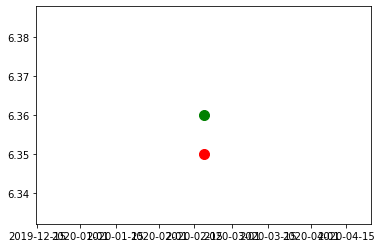

buy time:2020-02-18T19:43:02.489786083Z sell time:2020-02-18T19:43:04.28244532Z
{'rsi': 64.11090859301041, 'macd1': [0.01130586856935345, 0.010607658107517182, 0.009939742126221063, 0.010100893512656306, 0.010112041823821194], 'macd2': [0.00793221292452273, 0.008005898709774861, 0.008060887673000394, 0.008258523040329813, 0.008427145546551884], 'macd_signal': [0.011732076901722292, 0.01150719314288127, 0.011193702939549228, 0.010975141054170644, 0.010802521208100754]}
{'rsi': 59.938026840886735, 'macd': [0.006805250353460579, 0.006321480949590175, 0.005862420622553266, 0.005948056463530804, 0.005677797943986818], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007861635220125619, 'too_close': 1, 'macd_signal': [0.007236088536097411, 0.007053167018795964, 0.006815017739547425, 0.0066416254843441, 0.006448859976272644], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007710620322858262}


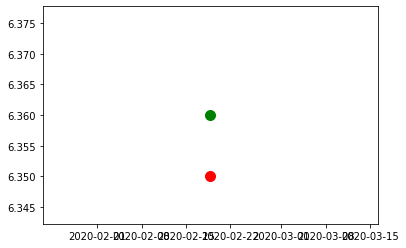

buy time:2020-02-18T19:43:13.504383683Z sell time:2020-02-18T19:44:31.644291411Z
{'rsi': 64.11090859301041, 'macd1': [0.01130586856935345, 0.010607658107517182, 0.009939742126221063, 0.010100893512656306, 0.010112041823821194], 'macd2': [0.00793221292452273, 0.008005898709774861, 0.008060887673000394, 0.008258523040329813, 0.008427145546551884], 'macd_signal': [0.011732076901722292, 0.01150719314288127, 0.011193702939549228, 0.010975141054170644, 0.010802521208100754]}
{'rsi': 59.63942379533952, 'macd': [0.006321480949590175, 0.005862420622553266, 0.005948056463530804, 0.005937538203727222, 0.00559249101162429], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007861635220125619, 'too_close': 1, 'macd_signal': [0.007053167018795964, 0.006815017739547425, 0.0066416254843441, 0.006500808028220725, 0.0063191446249014375], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007266536132771477}


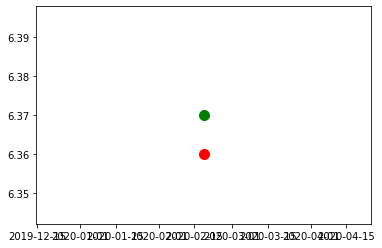

buy time:2020-02-18T19:44:38.474253075Z sell time:2020-02-18T19:44:50.331705579Z
{'rsi': 68.79075479535597, 'macd1': [0.010607658107517182, 0.009939742126221063, 0.010100893512656306, 0.010112041823821194, 0.010803260109505608], 'macd2': [0.008005898709774861, 0.008060887673000394, 0.008258523040329813, 0.008427145546551884, 0.008728741629971282], 'macd_signal': [0.01150719314288127, 0.011193702939549228, 0.010975141054170644, 0.010802521208100754, 0.010802668988381725]}
{'rsi': 64.11090859301041, 'macd': [0.006321480949590175, 0.005862420622553266, 0.005948056463530804, 0.005937538203727222, 0.005852231271363806], 'scalp': 0, 'bail_out': 0, 'movement': -0.001569858712715822, 'too_close': 0, 'macd_signal': [0.007053167018795964, 0.006815017739547425, 0.0066416254843441, 0.006500808028220725, 0.0063710926768493405], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0005188614054855347}


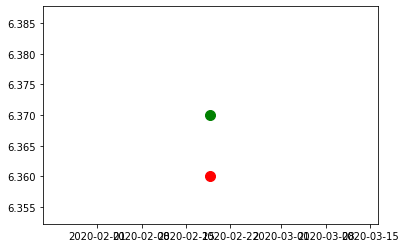

buy time:2020-02-18T19:44:57.7679838Z sell time:2020-02-18T19:45:03.265174274Z
{'rsi': 68.79075479535597, 'macd1': [0.010607658107517182, 0.009939742126221063, 0.010100893512656306, 0.010112041823821194, 0.010803260109505608], 'macd2': [0.008005898709774861, 0.008060887673000394, 0.008258523040329813, 0.008427145546551884, 0.008728741629971282], 'macd_signal': [0.01150719314288127, 0.011193702939549228, 0.010975141054170644, 0.010802521208100754, 0.010802668988381725]}
{'rsi': 64.27756865520261, 'macd': [0.005862420622553266, 0.005948056463530804, 0.005937538203727222, 0.006371711790844614, 0.006367539108198095], 'scalp': 0, 'bail_out': 0, 'movement': -0.000784929356357911, 'too_close': 0, 'macd_signal': [0.006815017739547425, 0.0066416254843441, 0.006500808028220725, 0.006474988780745502, 0.006453498846236021], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -8.595973803792595e-05}


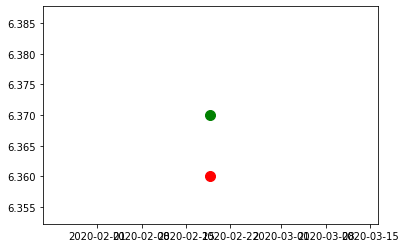

buy time:2020-02-18T19:45:38.761379286Z sell time:2020-02-18T19:46:08.332381724Z
{'rsi': 68.79075479535597, 'macd1': [0.009939742126221063, 0.010100893512656306, 0.010112041823821194, 0.010803260109505608, 0.011221698822112991], 'macd2': [0.008060887673000394, 0.008258523040329813, 0.008427145546551884, 0.008728741629971282, 0.00899225927148617], 'macd_signal': [0.011193702939549228, 0.010975141054170644, 0.010802521208100754, 0.010802668988381725, 0.010886474955127979]}
{'rsi': 59.75412709110751, 'macd': [0.005948056463530804, 0.005937538203727222, 0.006371711790844614, 0.006627279367937611, 0.006220873851803255], 'scalp': 0, 'bail_out': 0, 'movement': -0.001569858712715822, 'too_close': 1, 'macd_signal': [0.0066416254843441, 0.006500808028220725, 0.006474988780745502, 0.006505446898183924, 0.00644853228890779], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00022765843710453523}


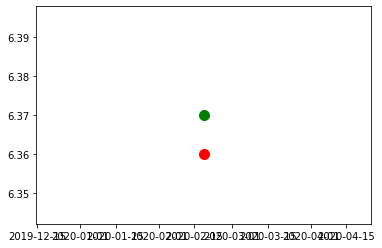

buy time:2020-02-18T19:46:22.775197774Z sell time:2020-02-18T19:46:27.270244446Z
{'rsi': 68.79075479535597, 'macd1': [0.010100893512656306, 0.010112041823821194, 0.010803260109505608, 0.011221698822112991, 0.011421652812649619], 'macd2': [0.008258523040329813, 0.008427145546551884, 0.008728741629971282, 0.00899225927148617, 0.009220322068783204], 'macd_signal': [0.010975141054170644, 0.010802521208100754, 0.010802668988381725, 0.010886474955127979, 0.010993510526632307]}
{'rsi': 63.95480620326086, 'macd': [0.005948056463530804, 0.005937538203727222, 0.006371711790844614, 0.006627279367937611, 0.006480614111544547], 'scalp': 0, 'bail_out': 0, 'movement': -0.000784929356357911, 'too_close': 1, 'macd_signal': [0.0066416254843441, 0.006500808028220725, 0.006474988780745502, 0.006505446898183924, 0.006500480340856049], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -1.986622931150154e-05}


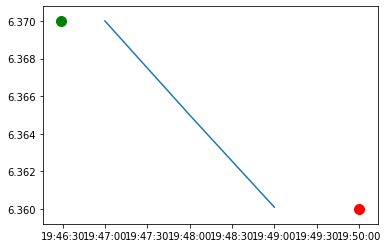

buy time:2020-02-18T19:46:28.768388114Z sell time:2020-02-18T19:49:59.817061531Z
{'rsi': 68.79075479535597, 'macd1': [0.010100893512656306, 0.010112041823821194, 0.010803260109505608, 0.011221698822112991, 0.011421652812649619], 'macd2': [0.008258523040329813, 0.008427145546551884, 0.008728741629971282, 0.00899225927148617, 0.009220322068783204], 'macd_signal': [0.010975141054170644, 0.010802521208100754, 0.010802668988381725, 0.010886474955127979, 0.010993510526632307]}
{'rsi': 58.284989810541965, 'macd': [0.006627279367937611, 0.006740354371284063, 0.006740927693745569, 0.006394089663277036, 0.005786240682868815], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015541601255887002, 'too_close': 1, 'macd_signal': [0.006505446898183924, 0.006552428392803952, 0.006590128252992275, 0.006550920535049227, 0.006397984564613145], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00061174388174433}
BLDP

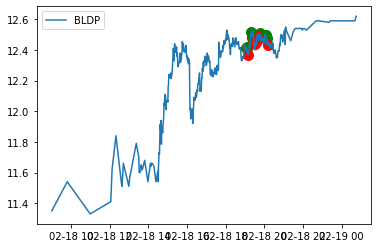

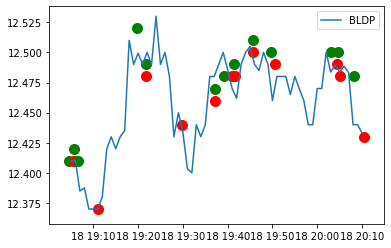

Delta = -0.2599999999999998


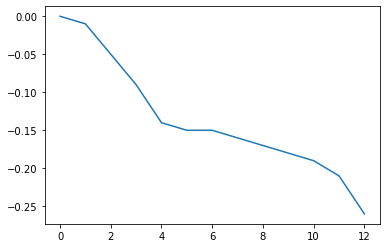

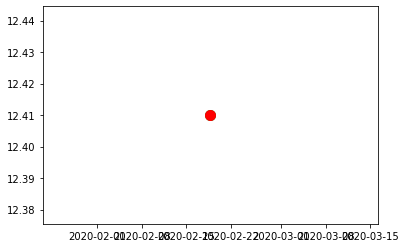

buy time:2020-02-18T19:04:38.330333382Z sell time:2020-02-18T19:05:35.609871588Z
{'rsi': 55.66331386839302, 'macd1': [-0.006769506950719872, -0.002989180324325602, -0.002386483619037705, -0.0004192826833389063, 0.0017569491914493085], 'macd2': [0.00021222938696929816, 0.0006439385469043657, 0.0005602868167251529, 0.0007767107357956604, 0.0011009348840698152], 'macd_signal': [-0.016211653394008412, -0.01356715878007185, -0.01133102374786502, -0.009148675534959797, -0.006967550589677976]}
{'rsi': 52.11678890860887, 'macd': [-0.0034638035767819986, -0.0010009134163109223, -0.0006272209092372805, 0.0006279579392494128, 0.0011615004453542355], 'scalp': 0, 'bail_out': 0, 'movement': -0.0013117339835670566, 'too_close': 0, 'macd_signal': [-0.009899400320037475, -0.008119702939292164, -0.006621206533281188, -0.0051713736387750675, -0.0039047988219492067], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_mac

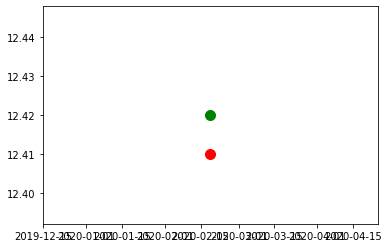

buy time:2020-02-18T19:05:36.984512568Z sell time:2020-02-18T19:05:39.26286522Z
{'rsi': 54.24907302517824, 'macd1': [-0.002989180324325602, -0.002386483619037705, -0.0004192826833389063, 0.0004407098752086114, 0.001923146097714934], 'macd2': [0.0006439385469043657, 0.0005602868167251529, 0.0007767107357956604, 0.0008370404418478472, 0.0010543417180812753], 'macd_signal': [-0.01356715878007185, -0.01133102374786502, -0.009148675534959797, -0.007230798452926115, -0.0054000095427979055]}
{'rsi': 52.11631253178888, 'macd': [-0.0010009134163109223, -0.0006272209092372805, 0.0006279579392494128, 0.0011511108349644417, 0.0015542025610404409], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008051529790660054, 'too_close': 0, 'macd_signal': [-0.008119702939292164, -0.006621206533281188, -0.0051713736387750675, -0.0039068767440271655, -0.002814660883013644], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd':

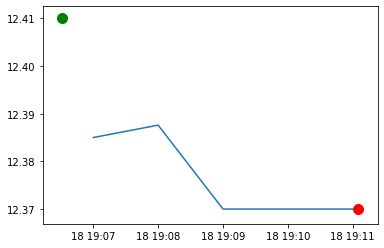

buy time:2020-02-18T19:06:31.368504711Z sell time:2020-02-18T19:11:04.456993872Z
{'rsi': 53.35735296689741, 'macd1': [-0.002386483619037705, -0.0004192826833389063, 0.0004407098752086114, 0.001125425299994376, 0.002071849917134827], 'macd2': [0.0005602868167251529, 0.0007767107357956604, 0.0008370404418478472, 0.0008944056924917732, 0.0010305191746819986], 'macd_signal': [-0.01133102374786502, -0.009148675534959797, -0.007230798452926115, -0.005559553702342017, -0.004033272978446648]}
{'rsi': 42.541486753502454, 'macd': [0.0007544358785107619, 2.7485010548389255e-05, -0.0014536128737141496, -0.002588837031922253, -0.0034398060249163365], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008077544426495608, 'too_close': 1, 'macd_signal': [-0.0013547972996526964, -0.0010783408376124793, -0.0011533952448328133, -0.0014404836022507013, -0.0018403480867838283], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_m

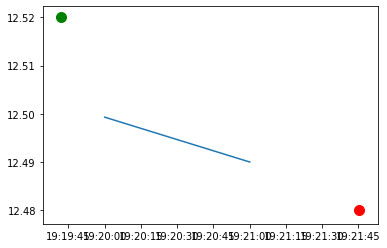

buy time:2020-02-18T19:19:41.712002883Z sell time:2020-02-18T19:21:45.379671663Z
{'rsi': 73.26118230650643, 'macd1': [0.0019449015932302416, 0.004126003964403324, 0.00618668526416144, 0.013713581607115444, 0.020252163281998747], 'macd2': [-0.0001940324756564138, 0.0002699239688457311, 0.000776315045584397, 0.002440489618711794, 0.004127616261770939], 'macd_signal': [-0.0022294836528412567, -0.0009583861293923405, 0.00047062814931841577, 0.0031192188408778214, 0.006545807729102007]}
{'rsi': 62.017140149972015, 'macd': [0.004451957445366972, 0.00929903089507711, 0.011916243571539198, 0.014283990545775893, 0.014940884414714972], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015999999999999658, 'too_close': 0, 'macd_signal': [0.000852123800786241, 0.002541505219644415, 0.004416452890023371, 0.006389960421173875, 0.008100145219882095], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00684073919483

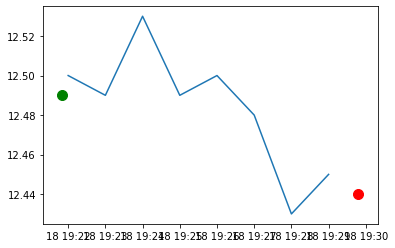

buy time:2020-02-18T19:21:50.7778045Z sell time:2020-02-18T19:29:47.534745034Z
{'rsi': 64.73625074443407, 'macd1': [0.00618668526416144, 0.013713581607115444, 0.017859000888837073, 0.021645195472647316, 0.02362303800443577], 'macd2': [0.000776315045584397, 0.002440489618711794, 0.0036478081850024324, 0.004901486229103469, 0.005898330385265993], 'macd_signal': [0.00047062814931841577, 0.0031192188408778214, 0.006067175250469672, 0.009182779294905201, 0.012070831036811315]}
{'rsi': 48.921391633421244, 'macd': [0.018217728152400525, 0.017924935177148882, 0.016425032401926387, 0.012445562286142575, 0.009962266581815982], 'scalp': 0, 'bail_out': 0, 'movement': -0.0020048115477145434, 'too_close': 1, 'macd_signal': [0.01391262373835316, 0.014715086026112306, 0.015057075301275123, 0.014534772698248613, 0.013620271474962087], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.003658004893146105}


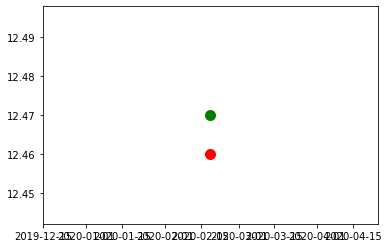

buy time:2020-02-18T19:37:12.281801258Z sell time:2020-02-18T19:37:13.301986328Z
{'rsi': 54.47725501058959, 'macd1': [0.0016508404216981631, 0.00032661557688129506, 7.513895399746673e-05, 0.003076117224342312, 0.004594534761229951], 'macd2': [0.007596009013154159, 0.007234108540558282, 0.007047915249232872, 0.00750668277248856, 0.0077568216529044776], 'macd_signal': [0.01181290186110853, 0.009515644604263084, 0.007627543474209961, 0.006717258224236431, 0.006292713531635135]}
{'rsi': 54.22892770519617, 'macd': [0.00015093908431218495, -0.000685070691705647, -0.0008133241445555939, 0.001180417634321529, 0.002131639570663424], 'scalp': 0, 'bail_out': 0, 'movement': -0.00010425020048119671, 'too_close': 0, 'macd_signal': [0.006965537778561616, 0.005435416084508164, 0.004185668038695412, 0.0035846179578206358, 0.0032940222803891934], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001162382709

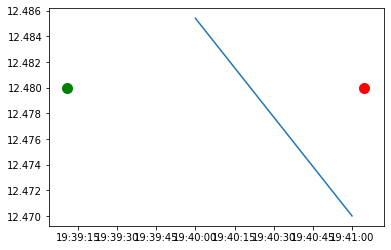

buy time:2020-02-18T19:39:10.819572622Z sell time:2020-02-18T19:41:04.612108337Z
{'rsi': 56.46627546446933, 'macd1': [0.00032661557688129506, 7.513895399746673e-05, 0.003076117224342312, 0.005392255558948733, 0.007145443649493544], 'macd2': [0.007234108540558282, 0.007047915249232872, 0.00750668277248856, 0.00791675767849398, 0.008281377961584013], 'macd_signal': [0.009515644604263084, 0.007627543474209961, 0.006717258224236431, 0.006452257691178891, 0.006590894882841822]}
{'rsi': 55.01771257555621, 'macd': [0.0027186525576770038, 0.004401450516684946, 0.006175040478032301, 0.0067184217404072655, 0.006774064000174107], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.003411424877791909, 0.0036094300055705165, 0.004122552100062874, 0.004641726028131752, 0.005068193622540223], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0017058703776338842}


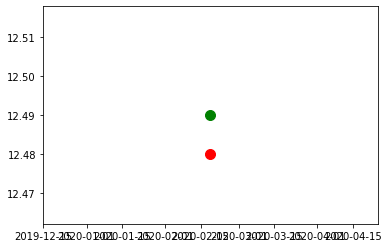

buy time:2020-02-18T19:41:24.720628026Z sell time:2020-02-18T19:41:43.252340524Z
{'rsi': 57.13174157268337, 'macd1': [0.005392255558948733, 0.007943164447214102, 0.010648940192185208, 0.011482822155427286, 0.012372241674714957], 'macd2': [0.00791675767849398, 0.008441313987173515, 0.009070357893740777, 0.009401085041854884, 0.009763899447150948], 'macd_signal': [0.006452257691178891, 0.006750439042385934, 0.007530139272345788, 0.008320675848962088, 0.009130989014112662]}
{'rsi': 56.19223044866367, 'macd': [0.0027186525576770038, 0.004401450516684946, 0.006175040478032301, 0.0067184217404072655, 0.007033804259915399], 'scalp': 0, 'bail_out': 0, 'movement': -0.00040032025620502656, 'too_close': 0, 'macd_signal': [0.003411424877791909, 0.0036094300055705165, 0.004122552100062874, 0.004641726028131752, 0.0051201416744884815], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0019136625854269179}

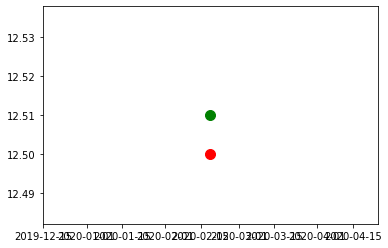

buy time:2020-02-18T19:45:34.757480246Z sell time:2020-02-18T19:45:40.760111135Z
{'rsi': 60.08326477420473, 'macd1': [0.01077680007927384, 0.009454682497338496, 0.010552685161094644, 0.012082428727728356, 0.013948952277338833], 'macd2': [0.009444027395971943, 0.009338883152564037, 0.009676631078715303, 0.010130230220564584, 0.010692889438681519], 'macd_signal': [0.008811900695024438, 0.008940457055487249, 0.009262902676608727, 0.009826807886832652, 0.010651236764933888]}
{'rsi': 59.216600433330235, 'macd': [0.006254583480695075, 0.0053911434928561874, 0.006108058521906656, 0.007101653888415882, 0.00804858983779333], 'scalp': 0, 'bail_out': 0, 'movement': -0.0003996802557952842, 'too_close': 0, 'macd_signal': [0.004964297518644417, 0.005049666713486771, 0.005261345075170748, 0.0056294068378197745, 0.006113243437814485], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0019353463999788444}


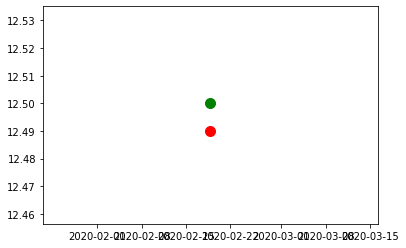

buy time:2020-02-18T19:49:38.942865089Z sell time:2020-02-18T19:50:39.562160019Z
{'rsi': 57.23894082812807, 'macd1': [0.013550091878478554, 0.013348972217345434, 0.01264041439489283, 0.013137807389895784, 0.0133777841536169], 'macd2': [0.010612921425886768, 0.010800134851612242, 0.010875135872481678, 0.011166649989046817, 0.011416992804823778], 'macd_signal': [0.010571464685161833, 0.011126966191598553, 0.01142965583225741, 0.011771286143785083, 0.012092585745751446]}
{'rsi': 54.53212276499282, 'macd': [0.00804858983779333, 0.007902714086167606, 0.0074266717591058296, 0.007738500182707497, 0.007361502848075574], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007999999999999829, 'too_close': 1, 'macd_signal': [0.006113243437814485, 0.006471137567485109, 0.006662244405809254, 0.006877495561188903, 0.006974297018566237], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00038720582950933693}


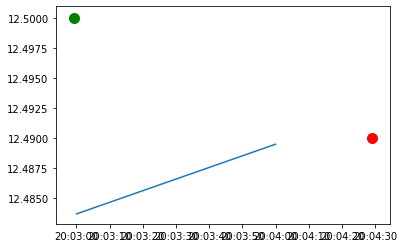

buy time:2020-02-18T20:02:59.26625321Z sell time:2020-02-18T20:04:29.015556131Z
{'rsi': 57.91668579872354, 'macd1': [-0.0005294727918379039, -0.0028341389864277033, -0.0022143288655342985, -0.0017034881284754277, 0.0011093185815109763], 'macd2': [0.008719936772793702, 0.008042409947874418, 0.007886008962696422, 0.007729502484188799, 0.008052957335454636], 'macd_signal': [0.004981397249743195, 0.0034182900025090156, 0.0022917662289003524, 0.0014927153574251964, 0.0014160360022423524]}
{'rsi': 56.317202604730944, 'macd': [-0.0020704500175909857, -0.001689089403404509, 0.0001884524960047429, 0.0008022714761164451, 0.0019506723505386958], 'scalp': 0, 'bail_out': 0, 'movement': -0.0002559999999999718, 'too_close': 0, 'macd_signal': [0.0007573410976872558, 0.0002680549974689028, 0.0002521344971760708, 0.00036216189296414566, 0.0006798639844790557], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0

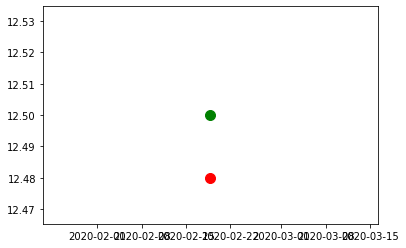

buy time:2020-02-18T20:04:39.427672859Z sell time:2020-02-18T20:05:01.20720325Z
{'rsi': 56.99383219437374, 'macd1': [-0.0022143288655342985, -0.0017034881284754277, 0.0011093185815109763, 0.002000157814901371, 0.003975599860265078], 'macd2': [0.007886008962696422, 0.007729502484188799, 0.008052957335454636, 0.008076970843420739, 0.008346841774431013], 'macd_signal': [0.0022917662289003524, 0.0014927153574251964, 0.0014160360022423524, 0.0015328603647741562, 0.0020214082638723404]}
{'rsi': 54.69098855273485, 'macd': [-0.0020704500175909857, -0.001689089403404509, 0.0001884524960047429, 0.0008022714761164451, 0.0015714515713192156], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008400000000000318, 'too_close': 0, 'macd_signal': [0.0007573410976872558, 0.0002680549974689028, 0.0002521344971760708, 0.00036216189296414566, 0.0006040198286351596], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000

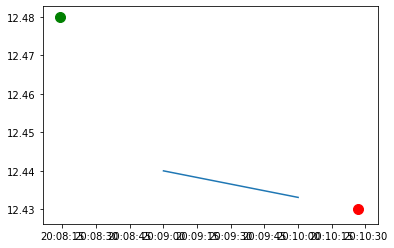

buy time:2020-02-18T20:08:14.009016312Z sell time:2020-02-18T20:10:26.875990888Z
{'rsi': 53.7992697288446, 'macd1': [0.0011093185815109763, 0.002000157814901371, 0.0031379930226584918, 0.0035389978945765677, 0.004044184071780421], 'macd2': [0.008052957335454636, 0.008076970843420739, 0.00817890894756168, 0.008168450707593422, 0.008192145944299511], 'macd_signal': [0.0014160360022423524, 0.0015328603647741562, 0.0018538868963510233, 0.002190909095996132, 0.00256156409115299]}
{'rsi': 39.12940450851925, 'macd': [0.0022947759754625707, 0.002332876793236238, 8.811279678333506e-05, -0.001662198275734994, -0.003523970562428147], 'scalp': 0, 'bail_out': 0, 'movement': -0.003207698476343298, 'too_close': 1, 'macd_signal': [0.0011422159376421625, 0.0013803481087609776, 0.001121901046365449, 0.0005650811819453604, -0.00025272916692934105], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00327124139

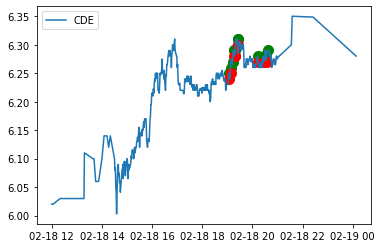

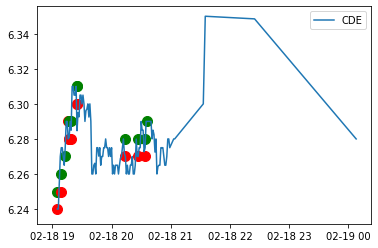

Delta = nan


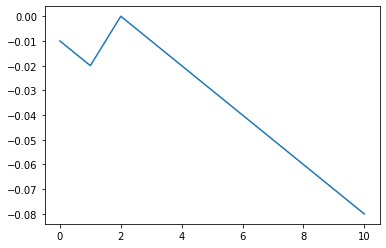

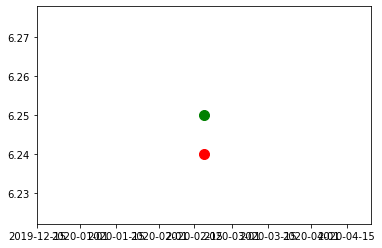

buy time:2020-02-18T19:04:21.921548184Z sell time:2020-02-18T19:04:45.573718334Z
{'rsi': 62.335867181248304, 'macd1': [-0.002443427251768604, -0.0026606729714542254, -0.0028005586723880427, -0.001282798937537244, 0.0003198082500244226], 'macd2': [0.001336241321415521, 0.0011852073104137162, 0.001044355615668735, 0.0012329693013661824, 0.0014844959761299847], 'macd_signal': [-5.767717628634523e-05, -0.0005782763353199213, -0.0010227328027335456, -0.0010747460296942853, -0.0007958351737505437]}
{'rsi': 55.337067074689585, 'macd': [-0.0018208665878036712, -0.0019369576891232754, -0.0020022629928897473, -0.0009881857881239853, -0.0004449024365129617], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015987210231814208, 'too_close': 0, 'macd_signal': [-0.0003161068258410347, -0.0006402769984974828, -0.0009126741973759357, -0.0009277765155255456, -0.0008312016997230288], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_t

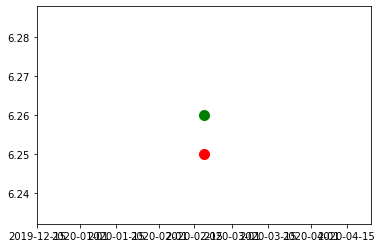

buy time:2020-02-18T19:08:27.564631076Z sell time:2020-02-18T19:08:28.720512431Z
{'rsi': 63.54102653448712, 'macd1': [-0.00047791254769613545, -0.00024071765482691632, -5.2137979161592796e-05, 0.001292784991562712, 0.002730627376130279], 'macd2': [0.0013245599505404826, 0.0013267398161724842, 0.0013266234273503485, 0.0015642986355111077, 0.0018604335653131798], 'macd_signal': [-0.0009553793332946553, -0.0008124469976011075, -0.0006603851939132046, -0.0002697511568180213, 0.0003303245497716388]}
{'rsi': 60.97514435074973, 'macd': [-0.0004449024365129617, -0.00027552706595201926, -0.00013996798413895561, 0.0007467010144699415, 0.0014279145067046528], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007987220447284176, 'too_close': 0, 'macd_signal': [-0.0008312016997230288, -0.0007200667729688269, -0.0006040470152028526, -0.0003338974092682937, 1.8464973926295614e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_

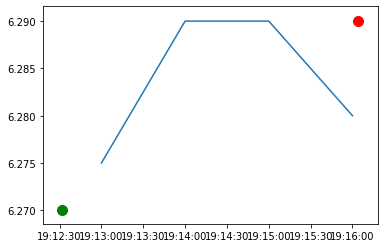

buy time:2020-02-18T19:12:31.971210971Z sell time:2020-02-18T19:16:03.728052803Z
{'rsi': 65.22109747481629, 'macd1': [0.001292784991562712, 0.003528348173850837, 0.005638509092465327, 0.007227512557562932, 0.007991233077993876], 'macd2': [0.0015642986355111077, 0.00202036959090357, 0.0025167061722681794, 0.002969326583716736, 0.0033010348045916516], 'macd_signal': [-0.0002697511568180213, 0.0004898687093157504, 0.001519596785945666, 0.002661179940269119, 0.0037271905678140705]}
{'rsi': 71.39846534503157, 'macd': [0.005117265478084221, 0.0056053747185069724, 0.006692143286127994, 0.0074520649844549425, 0.00794743169763823], 'scalp': 0, 'bail_out': 1, 'movement': 0.0031897926634769477, 'too_close': 0, 'macd_signal': [0.002860974619458045, 0.0034098546392678304, 0.004066312368639863, 0.004743462891802879, 0.005384256652969949], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00256317504466828

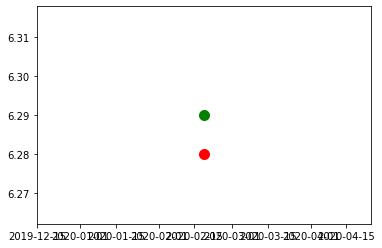

buy time:2020-02-18T19:16:28.557865105Z sell time:2020-02-18T19:16:52.727839507Z
{'rsi': 71.39846534503157, 'macd1': [0.008099661029010718, 0.0088900286712148, 0.010604532907457553, 0.01182695607935802, 0.012649914905440873], 'macd2': [0.003520969421550113, 0.0038776210312807535, 0.004439454245940944, 0.004949258488223585, 0.005410379051014935], 'macd_signal': [0.0046016846600534, 0.00545935346228568, 0.006488389351320055, 0.007556102696927648, 0.008574865138630292]}
{'rsi': 63.34419760105842, 'macd': [0.005117265478084221, 0.0056053747185069724, 0.006692143286127994, 0.0074520649844549425, 0.00742795117815831], 'scalp': 0, 'bail_out': 0, 'movement': -0.00158982511923685, 'too_close': 0, 'macd_signal': [0.002860974619458045, 0.0034098546392678304, 0.004066312368639863, 0.004743462891802879, 0.0052803605490739655], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002147590629084344}


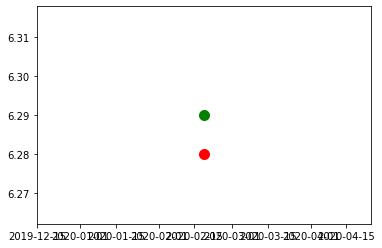

buy time:2020-02-18T19:17:08.075152777Z sell time:2020-02-18T19:17:19.47709144Z
{'rsi': 67.31493545238462, 'macd1': [0.0088900286712148, 0.010604532907457553, 0.01182695607935802, 0.011852194107719427, 0.01253462055036536], 'macd2': [0.0038776210312807535, 0.004439454245940944, 0.004949258488223585, 0.005250443025424545, 0.005679081109390083], 'macd_signal': [0.00545935346228568, 0.006488389351320055, 0.007556102696927648, 0.008415320979086004, 0.009239180893341876]}
{'rsi': 65.44325676292887, 'macd': [0.0056053747185069724, 0.006692143286127994, 0.0074520649844549425, 0.00742795117815831, 0.007572434560548125], 'scalp': 0, 'bail_out': 0, 'movement': -0.000794912559618425, 'too_close': 0, 'macd_signal': [0.0034098546392678304, 0.004066312368639863, 0.004743462891802879, 0.0052803605490739655, 0.0057387753513687976], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0018336592091793271}


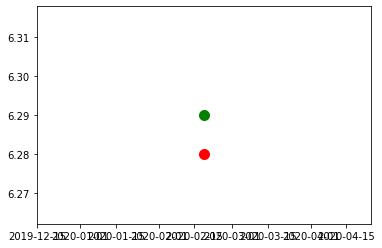

buy time:2020-02-18T19:19:07.994814802Z sell time:2020-02-18T19:19:10.835659796Z
{'rsi': 67.56091282029907, 'macd1': [0.01182695607935802, 0.011852194107719427, 0.01180869462443912, 0.01236596774010934, 0.012661655021729779], 'macd2': [0.004949258488223585, 0.005250443025424545, 0.005533539326103565, 0.005930688638601467, 0.006286593402097473], 'macd_signal': [0.007556102696927648, 0.008415320979086004, 0.009093995708156628, 0.00974839011454717, 0.010331043095983691]}
{'rsi': 60.13759004582768, 'macd': [0.0074520649844549425, 0.00742795117815831, 0.0073594475475609045, 0.00768321812699746, 0.007321439122311979], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015739268680445182, 'too_close': 1, 'macd_signal': [0.004743462891802879, 0.0052803605490739655, 0.005696177948771353, 0.006093585984416575, 0.006339156611995656], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009822825103163232}


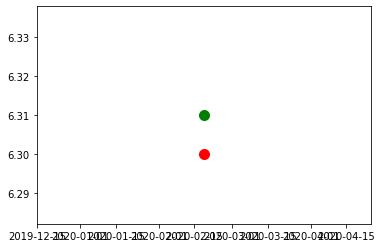

buy time:2020-02-18T19:24:48.061590326Z sell time:2020-02-18T19:24:53.258546404Z
{'rsi': 70.3360312187387, 'macd1': [0.01403651603103917, 0.015266223504322163, 0.01565683507450988, 0.015784444309561607, 0.016103403746602574], 'macd2': [0.006850409460397167, 0.007431755126029671, 0.00787475766745871, 0.008269739601549198, 0.008699877335229367], 'macd_signal': [0.011008320019177143, 0.011859900716206146, 0.012619287587866892, 0.013252318932205836, 0.013822535895085183]}
{'rsi': 68.52100556905988, 'macd': [0.008692737854969934, 0.009450042515123158, 0.009657681957903286, 0.00969405448529237, 0.009596499902929878], 'scalp': 0, 'bail_out': 0, 'movement': -0.000792393026941346, 'too_close': 0, 'macd_signal': [0.006850600133317793, 0.007370488609678866, 0.00782792727932375, 0.008201152720517474, 0.008480222156999954], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0011162777459299243}


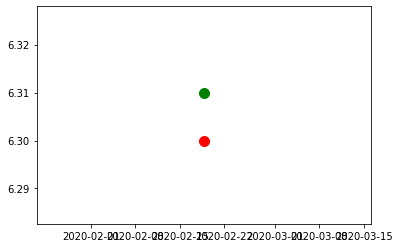

buy time:2020-02-18T19:24:59.284579287Z sell time:2020-02-18T19:25:11.037656328Z
{'rsi': 70.3360312187387, 'macd1': [0.01403651603103917, 0.015266223504322163, 0.01565683507450988, 0.015784444309561607, 0.016103403746602574], 'macd2': [0.006850409460397167, 0.007431755126029671, 0.00787475766745871, 0.008269739601549198, 0.008699877335229367], 'macd_signal': [0.011008320019177143, 0.011859900716206146, 0.012619287587866892, 0.013252318932205836, 0.013822535895085183]}
{'rsi': 66.22395002984686, 'macd': [0.009450042515123158, 0.009657681957903286, 0.00969405448529237, 0.009856240162669394, 0.009594875233837286], 'scalp': 0, 'bail_out': 0, 'movement': -0.000792393026941346, 'too_close': 1, 'macd_signal': [0.007370488609678866, 0.00782792727932375, 0.008201152720517474, 0.008532170208947858, 0.008744711213925744], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0008501640199115416}


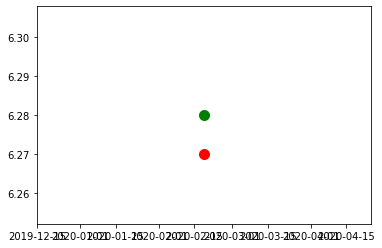

buy time:2020-02-18T20:13:11.462043854Z sell time:2020-02-18T20:13:18.880348089Z
{'rsi': 60.57508159983721, 'macd1': [-0.0034210696694474407, -0.0028889022730194114, -0.0020401796430764563, -0.0009531157063058515, 0.0003082946795549546], 'macd2': [0.000991312769245134, 0.0009357381272412368, 0.0009630791093444557, 0.0010666613897845068, 0.001240222438059213], 'macd_signal': [-0.0036194342982230946, -0.003473327893182358, -0.003186698243161178, -0.0027399817357901127, -0.0021303264527210994]}
{'rsi': 52.94583025411873, 'macd': [-0.0020642082419835006, -0.0017076672285707417, -0.0011479253060597827, -0.00043711438843985206, -0.0001372992008343843], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015910898965791228, 'too_close': 0, 'macd_signal': [-0.002258879861967077, -0.00214863733528781, -0.0019484949294422045, -0.001646218821241734, -0.001344434897160264], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_sign

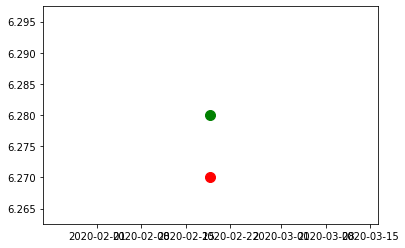

buy time:2020-02-18T20:26:42.520948472Z sell time:2020-02-18T20:27:10.840367316Z
{'rsi': 58.875359662481856, 'macd1': [-0.0021707471513243703, -0.00243250650436444, -0.002211007347864502, -0.0008236674691488588, 0.00028064346111733585], 'macd2': [-7.485311789867666e-05, -0.0002166171925530591, -0.00026673021414858056, -7.410452115941268e-05, 0.00010483515802928167], 'macd_signal': [-0.0021183631906146775, -0.00218119185336463, -0.0021871549522646046, -0.0019144574556414554, -0.001475437272289697]}
{'rsi': 54.504597424676184, 'macd': [-0.0014117115649314727, -0.0012663772657504069, -0.0003626573278721068, -0.00016803585253999387, 0.0002455397886604871], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007961783439490276, 'too_close': 0, 'macd_signal': [-0.0012509947478615043, -0.0012540712514392848, -0.0010757884667258492, -0.0008942379438886781, -0.0006662823973788451], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_m

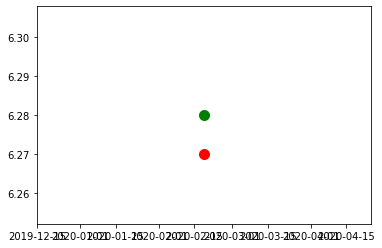

buy time:2020-02-18T20:33:32.992267985Z sell time:2020-02-18T20:33:57.508941072Z
{'rsi': 59.3670573158445, 'macd1': [0.0007860727823052471, 0.0023358895425644732, 0.0031246532203450528, 0.003707021877063177, 0.004121048353101564], 'macd2': [0.0001470747316911769, 0.00046808226552030874, 0.0006827028198097551, 0.0008790687071114078, 0.001058325657071535], 'macd_signal': [-0.000662776104739198, -6.30429752784637e-05, 0.0005744962638462396, 0.0012010013864896271, 0.0017850107798120145]}
{'rsi': 50.08279488912064, 'macd': [0.0006567931894112533, 0.0016543911375244136, 0.0021505143290738715, 0.0025091750714620886, 0.002117103246421337], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019570405727923237, 'too_close': 1, 'macd_signal': [-0.00026981349989890725, 0.00011502742758575692, 0.0005221248078833799, 0.0009195348605991218, 0.0011590485377635648], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.

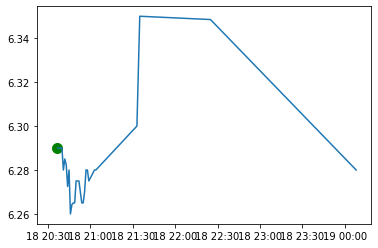

buy time:2020-02-18T20:36:16.693279529Z sell time:None
{'rsi': 60.151624172379336, 'macd1': [0.003707021877063177, 0.003139851771904567, 0.0028431817263028236, 0.0037749281951189317, 0.0044619098650438005], 'macd2': [0.0008790687071114078, 0.0008616043455971223, 0.0008809438445060991, 0.0011372318939315562, 0.0013712062538475678], 'macd_signal': [0.0012010013864896271, 0.001588771463572615, 0.0018396535161186568, 0.0022267084519187116, 0.0026737487345437293]}
None
CPRX analysis for run 66


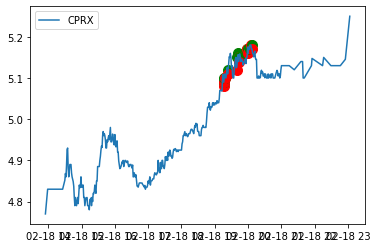

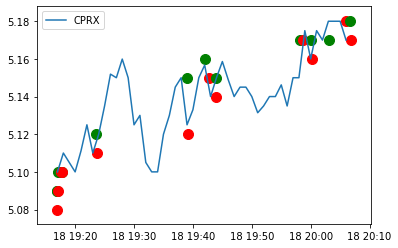

Delta = -0.08000000000000007


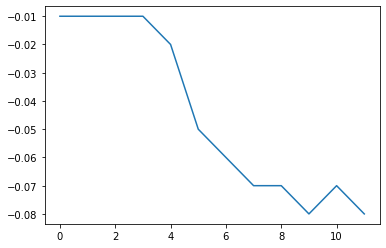

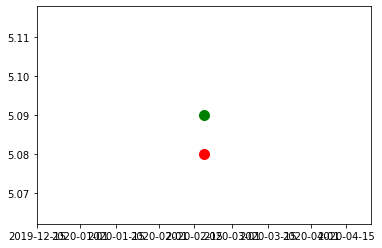

buy time:2020-02-18T19:16:50.836570268Z sell time:2020-02-18T19:16:51.439467994Z
{'rsi': 70.01120712605095, 'macd1': [0.015674840653497668, 0.015707595634011362, 0.018442003716931943, 0.020661360434696796, 0.020680954895228254], 'macd2': [0.016617938546734656, 0.016778610403942018, 0.017478567022022773, 0.01815217194409957, 0.01844539714918625], 'macd_signal': [0.014320219504096617, 0.014597694730079566, 0.015366556527450042, 0.016425517308899393, 0.017276604826165165]}
{'rsi': 66.77634706479505, 'macd': [0.009152098573609102, 0.00916175302560962, 0.010930811650212924, 0.012354353284316666, 0.012077186333171674], 'scalp': 0, 'bail_out': 0, 'movement': -0.000982318271119822, 'too_close': 0, 'macd_signal': [0.008304250567452112, 0.008475751059083613, 0.008966763177309475, 0.009644281198710913, 0.010130862225603065], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0019463241075686095}


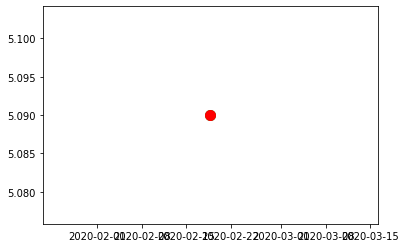

buy time:2020-02-18T19:16:56.402715205Z sell time:2020-02-18T19:17:00.45142883Z
{'rsi': 70.01120712605095, 'macd1': [0.015674840653497668, 0.015707595634011362, 0.018442003716931943, 0.020661360434696796, 0.020680954895228254], 'macd2': [0.016617938546734656, 0.016778610403942018, 0.017478567022022773, 0.01815217194409957, 0.01844539714918625], 'macd_signal': [0.014320219504096617, 0.014597694730079566, 0.015366556527450042, 0.016425517308899393, 0.017276604826165165]}
{'rsi': 70.01120712605095, 'macd': [0.009152098573609102, 0.00916175302560962, 0.010930811650212924, 0.012354353284316666, 0.012336926592912079], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.008304250567452112, 0.008475751059083613, 0.008966763177309475, 0.009644281198710913, 0.010182810277551146], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002154116315360933}


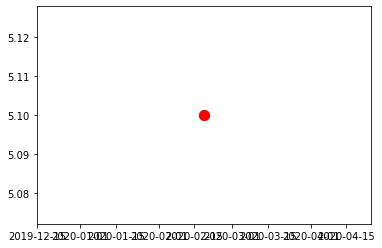

buy time:2020-02-18T19:17:04.155668109Z sell time:2020-02-18T19:17:33.9211052Z
{'rsi': 72.84458184192667, 'macd1': [0.015707595634011362, 0.018442003716931943, 0.020661360434696796, 0.020680954895228254, 0.02125834708059937], 'macd2': [0.016778610403942018, 0.017478567022022773, 0.01815217194409957, 0.01844539714918625, 0.01884560890780662], 'macd_signal': [0.014597694730079566, 0.015366556527450042, 0.016425517308899393, 0.017276604826165165, 0.018072953277052006]}
{'rsi': 72.84458184192667, 'macd': [0.00916175302560962, 0.010930811650212924, 0.012354353284316666, 0.012336926592912079, 0.012682608046454824], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.008475751059083613, 0.008966763177309475, 0.009644281198710913, 0.010182810277551146, 0.010682769831331882], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0019998382151229423}


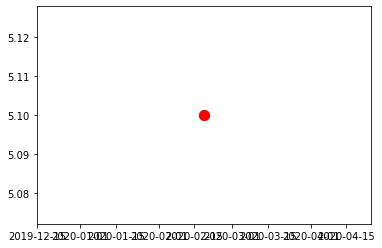

buy time:2020-02-18T19:17:42.011494664Z sell time:2020-02-18T19:17:45.251542364Z
{'rsi': 72.84458184192667, 'macd1': [0.015707595634011362, 0.018442003716931943, 0.020661360434696796, 0.020680954895228254, 0.02125834708059937], 'macd2': [0.016778610403942018, 0.017478567022022773, 0.01815217194409957, 0.01844539714918625, 0.01884560890780662], 'macd_signal': [0.014597694730079566, 0.015366556527450042, 0.016425517308899393, 0.017276604826165165, 0.018072953277052006]}
{'rsi': 72.84458184192667, 'macd': [0.00916175302560962, 0.010930811650212924, 0.012354353284316666, 0.012336926592912079, 0.012682608046454824], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.008475751059083613, 0.008966763177309475, 0.009644281198710913, 0.010182810277551146, 0.010682769831331882], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0019998382151229423}


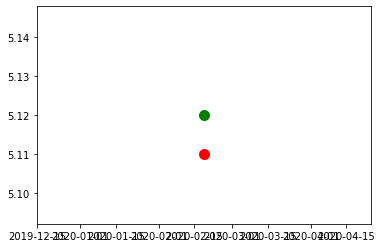

buy time:2020-02-18T19:23:32.063682632Z sell time:2020-02-18T19:23:38.636881587Z
{'rsi': 71.67185200457766, 'macd1': [0.02240318719123202, 0.021856361391378698, 0.022072308569369703, 0.023090816374697454, 0.023226788970042378], 'macd2': [0.019690884657470598, 0.01989892611522759, 0.020237633708125813, 0.02073759997618918, 0.021084450029331236], 'macd_signal': [0.019609916384765468, 0.020059205386088113, 0.02046182602274443, 0.020987624093135034, 0.021435457068516503]}
{'rsi': 68.55419860531559, 'macd': [0.013360524245985772, 0.012969179284765708, 0.013077622441155512, 0.013709167466378958, 0.013503758817638989], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009765624999999792, 'too_close': 1, 'macd_signal': [0.011638156187988647, 0.011904360807344059, 0.01213901313410635, 0.01245304400056087, 0.012663186963976494], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0008405718536624949}


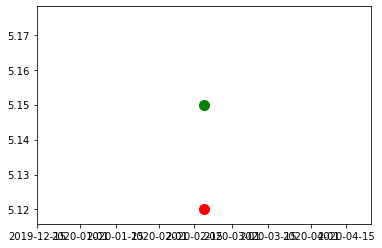

buy time:2020-02-18T19:39:03.844780901Z sell time:2020-02-18T19:39:08.471030695Z
{'rsi': 63.903572529084194, 'macd1': [0.013242335212238387, 0.012411247016565596, 0.012416391626604906, 0.013475506160093076, 0.014550590126100715], 'macd2': [0.022287613442493637, 0.022074011214159306, 0.02200212206091834, 0.022140696459218567, 0.022312746401103034], 'macd_signal': [0.02029853963200225, 0.01872108110891492, 0.017460143212452917, 0.01666321580198095, 0.0162406906668049]}
{'rsi': 53.963069638816805, 'macd': [0.006448090683642604, 0.006480761164561422, 0.007201273731970659, 0.007928929320446088, 0.007094259268343173], 'scalp': 0, 'bail_out': 0, 'movement': -0.004854368932038904, 'too_close': 1, 'macd_signal': [0.010599924968875074, 0.009776092208012344, 0.009261128512804006, 0.008994688674332422, 0.008614602793134573], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0015203435247914}


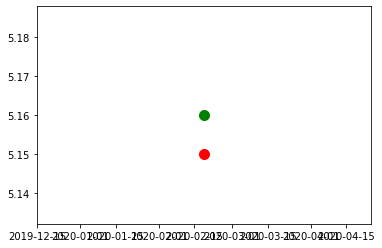

buy time:2020-02-18T19:42:03.639225842Z sell time:2020-02-18T19:42:44.190793716Z
{'rsi': 63.2878385336826, 'macd1': [0.014550590126100715, 0.013232771693473033, 0.012687668685647857, 0.013472130218713296, 0.01473092908115703], 'macd2': [0.022312746401103034, 0.022035511667264807, 0.021873152943062912, 0.021960685915408895, 0.022166032027246985], 'macd_signal': [0.0162406906668049, 0.015639106872138528, 0.015048819234840393, 0.014733481431614974, 0.014732970961523385]}
{'rsi': 60.8623715815935, 'macd': [0.007928929320446088, 0.007094259268343173, 0.006767318198284578, 0.007307788556702555, 0.0076340279456426074], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019379844961239896, 'too_close': 0, 'macd_signal': [0.008994688674332422, 0.008614602793134573, 0.008245145874164573, 0.008057674410672169, 0.007972945117666257], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0003389171720236499}


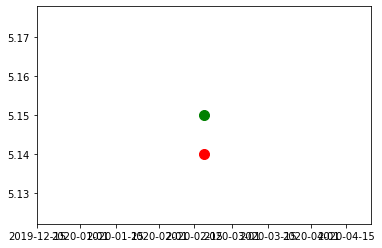

buy time:2020-02-18T19:43:56.31581735Z sell time:2020-02-18T19:43:57.217937457Z
{'rsi': 60.8623715815935, 'macd1': [0.014550590126100715, 0.013232771693473033, 0.012687668685647857, 0.013472130218713296, 0.013933208283436471], 'macd2': [0.022312746401103034, 0.022035511667264807, 0.021873152943062912, 0.021960685915408895, 0.022006096001657482], 'macd_signal': [0.0162406906668049, 0.015639106872138528, 0.015048819234840393, 0.014733481431614974, 0.014573426801979273]}
{'rsi': 56.13426043093668, 'macd': [0.007094259268343173, 0.006767318198284578, 0.007307788556702555, 0.007982079893694483, 0.007536305871951754], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019417475728156649, 'too_close': 1, 'macd_signal': [0.008614602793134573, 0.008245145874164573, 0.008057674410672169, 0.008042555507276632, 0.007941305580211656], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00040499970825990175}


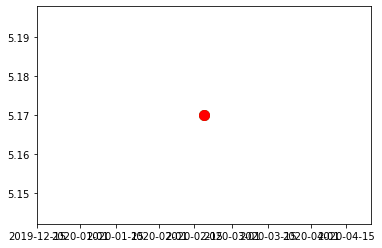

buy time:2020-02-18T19:58:12.196800988Z sell time:2020-02-18T19:58:40.573566431Z
{'rsi': 63.14463030876863, 'macd1': [0.006410233141241228, 0.006433943443153289, 0.005485751304273201, 0.00587693123758104, 0.007711879262394028], 'macd2': [0.01928021586512152, 0.019040881904235363, 0.01861110542617972, 0.018425835495068377, 0.018545783734385424], 'macd_signal': [0.009355745106949184, 0.008771384774190006, 0.008114258080206644, 0.007666792711681523, 0.007675810021824024]}
{'rsi': 63.14463030876863, 'macd': [0.003046960080440364, 0.0031020249314988035, 0.0025228283877591906, 0.002817963179809091, 0.004050302456993116], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.004844993357710756, 0.004496399672468366, 0.004101685415526531, 0.003844940968383043, 0.0038860132661050575], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00016428919088805815}


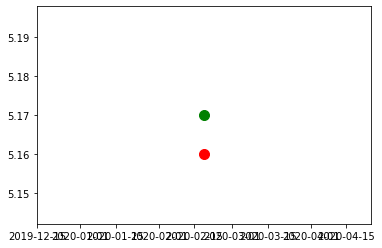

buy time:2020-02-18T20:00:00.710420961Z sell time:2020-02-18T20:00:10.088121227Z
{'rsi': 63.565726465673244, 'macd1': [0.006433943443153289, 0.005485751304273201, 0.00587693123758104, 0.006116437666952024, 0.00782982375643737], 'macd2': [0.019040881904235363, 0.01861110542617972, 0.018425835495068377, 0.01822591168320642, 0.018332697633694828], 'macd_signal': [0.008771384774190006, 0.008114258080206644, 0.007666792711681523, 0.007356721702735623, 0.007451342113475973]}
{'rsi': 57.78774479581771, 'macd': [0.0025228283877591906, 0.002817963179809091, 0.003011341418032387, 0.004421618728102317, 0.0046838917135056946], 'scalp': 0, 'bail_out': 0, 'movement': -0.001934235976789127, 'too_close': 0, 'macd_signal': [0.004101685415526531, 0.003844940968383043, 0.0036782210583129115, 0.0038269005922707926, 0.003998298816517773], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0006855928969879219}


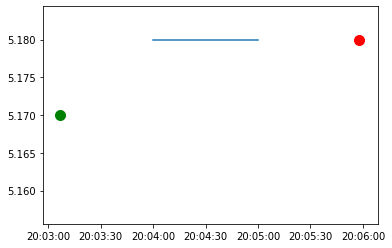

buy time:2020-02-18T20:03:06.631718037Z sell time:2020-02-18T20:05:57.909908149Z
{'rsi': 59.98683751139142, 'macd1': [0.006116437666952024, 0.00822868415529765, 0.00859322275265928, 0.009977482647998137, 0.010549452849212493], 'macd2': [0.01822591168320642, 0.018412665646490467, 0.01831513274242358, 0.018436010893871924, 0.018437768823862832], 'macd_signal': [0.007356721702735623, 0.007531114193248029, 0.007743535905130279, 0.008190325253703851, 0.00866215077280558]}
{'rsi': 65.45216787165297, 'macd': [0.005606651290268161, 0.005993130813846115, 0.006735931341129486, 0.0072272573189975375, 0.007963001492414357], 'scalp': 0, 'bail_out': 0, 'movement': -0.00026974951830448745, 'too_close': 0, 'macd_signal': [0.00431996931126785, 0.004654601611783503, 0.0050708675576527, 0.005502145509921667, 0.005994316706420205], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0019686847859941518}


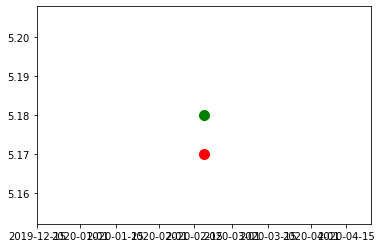

buy time:2020-02-18T20:06:39.288968596Z sell time:2020-02-18T20:06:52.407945509Z
{'rsi': 62.923349871716695, 'macd1': [0.010549452849212493, 0.011675076763562942, 0.012423926533911, 0.012869048986075882, 0.013071135819127555], 'macd2': [0.018437768823862832, 0.01856983356661157, 0.01866163750055705, 0.01871625337501026, 0.0187365676947282], 'macd_signal': [0.00866215077280558, 0.009264735970957052, 0.009896574083547842, 0.01049106906405345, 0.011007082415068271]}
{'rsi': 60.16592548953109, 'macd': [0.005993130813846115, 0.006735931341129486, 0.0072272573189975375, 0.007516248245661217, 0.0073840821074036], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009652509652509448, 'too_close': 0, 'macd_signal': [0.004654601611783503, 0.0050708675576527, 0.005502145509921667, 0.005904966057069578, 0.006200789267136382], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0011832928402672176}
BLNK analysis f

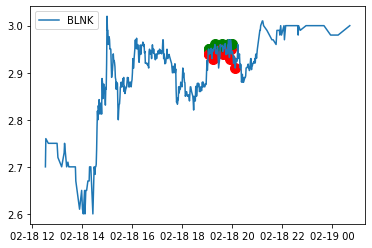

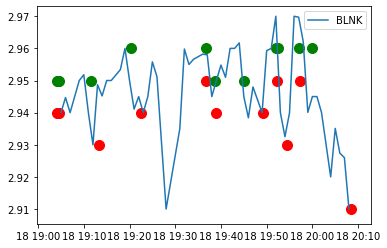

Delta = -0.20000000000000018


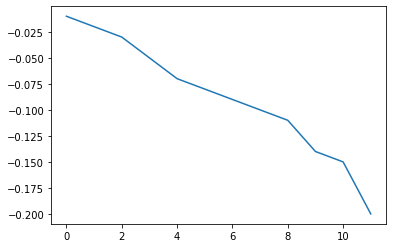

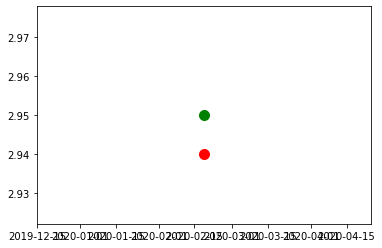

buy time:2020-02-18T19:04:01.826533213Z sell time:2020-02-18T19:04:08.219593627Z
{'rsi': 70.42812329450958, 'macd1': [0.00725457336808466, 0.008670964659982072, 0.01087843972161151, 0.014566023434037234, 0.017600272514325166], 'macd2': [-0.0027920614524719056, -0.0021737185636538925, -0.001361442729417739, -0.00019451251530533398, 0.0009417867540806313], 'macd_signal': [0.003663209367116928, 0.004664760425689957, 0.005907496284874267, 0.0076392017147068605, 0.009631415874630522]}
{'rsi': 70.06123366172528, 'macd': [0.004739189403116573, 0.0056249063807767286, 0.00702124550128147, 0.009373961108151363, 0.011184207540671842], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006779661016949911, 'too_close': 0, 'macd_signal': [0.002509753200125471, 0.0031327838362557223, 0.003910476169260872, 0.00500317315703897, 0.006239380033765544], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0049448275069062

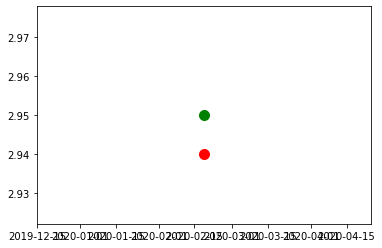

buy time:2020-02-18T19:04:16.442386583Z sell time:2020-02-18T19:04:24.378013201Z
{'rsi': 70.42812329450958, 'macd1': [0.00725457336808466, 0.008670964659982072, 0.01087843972161151, 0.014566023434037234, 0.017600272514325166], 'macd2': [-0.0027920614524719056, -0.0021737185636538925, -0.001361442729417739, -0.00019451251530533398, 0.0009417867540806313], 'macd_signal': [0.003663209367116928, 0.004664760425689957, 0.005907496284874267, 0.0076392017147068605, 0.009631415874630522]}
{'rsi': 70.15380691072458, 'macd': [0.004739189403116573, 0.0056249063807767286, 0.00702124550128147, 0.009373961108151363, 0.011210181566645883], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005084745762712056, 'too_close': 0, 'macd_signal': [0.002509753200125471, 0.0031327838362557223, 0.003910476169260872, 0.00500317315703897, 0.006244574838960353], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0049656067276855

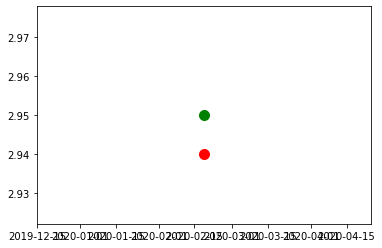

buy time:2020-02-18T19:04:34.999609536Z sell time:2020-02-18T19:04:40.867657064Z
{'rsi': 70.42812329450958, 'macd1': [0.00725457336808466, 0.008670964659982072, 0.01087843972161151, 0.014566023434037234, 0.017600272514325166], 'macd2': [-0.0027920614524719056, -0.0021737185636538925, -0.001361442729417739, -0.00019451251530533398, 0.0009417867540806313], 'macd_signal': [0.003663209367116928, 0.004664760425689957, 0.005907496284874267, 0.0076392017147068605, 0.009631415874630522]}
{'rsi': 67.58294946994693, 'macd': [0.004739189403116573, 0.0056249063807767286, 0.00702124550128147, 0.009373961108151363, 0.010825765982230173], 'scalp': 0, 'bail_out': 0, 'movement': -0.0030169491525424167, 'too_close': 0, 'macd_signal': [0.002509753200125471, 0.0031327838362557223, 0.003910476169260872, 0.00500317315703897, 0.006167691722077211], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0046580742601529

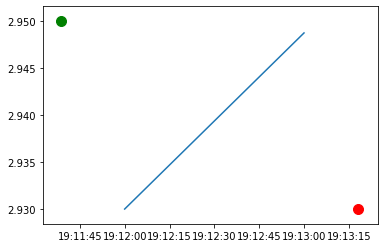

buy time:2020-02-18T19:11:38.696798559Z sell time:2020-02-18T19:13:18.184296668Z
{'rsi': 67.70643267301121, 'macd1': [0.018997716608647686, 0.020232260947459668, 0.020594000689292624, 0.021440446348115927, 0.022002870196503377], 'macd2': [0.0018301828609832427, 0.002715364119157293, 0.0034502464136720867, 0.004280779470058782, 0.005066838424423903], 'macd_signal': [0.011508505081262985, 0.013253256254502322, 0.014721405141460382, 0.01606521338279149, 0.017252744745533868]}
{'rsi': 58.448589875599744, 'macd': [0.013479719482237584, 0.013765713958594272, 0.013196804278370777, 0.012062630446009859, 0.011152071220196014], 'scalp': 0, 'bail_out': 0, 'movement': -0.002551020408163211, 'too_close': 1, 'macd_signal': [0.010229446758615143, 0.010936700198610969, 0.01138872101456293, 0.011523502900852316, 0.011449216564721056], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00029714534452504257}


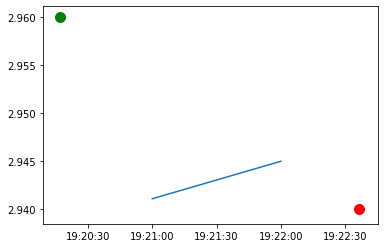

buy time:2020-02-18T19:20:17.053608667Z sell time:2020-02-18T19:22:36.407616542Z
{'rsi': 66.8892471029874, 'macd1': [0.01887255062177351, 0.018474509791669647, 0.018223343787551638, 0.018345383598712406, 0.01852709132997843], 'macd2': [0.007450874210346292, 0.007894720971502789, 0.008344825934931244, 0.008851148292832178, 0.009362001212607218], 'macd_signal': [0.018745879933824934, 0.018691605905393878, 0.01859795348182543, 0.018547439505202826, 0.018543369870157946]}
{'rsi': 57.4002092789214, 'macd': [0.010879338473234856, 0.01091887568741745, 0.010288399806424486, 0.00920116665491788, 0.008437073723160715], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016949152542374024, 'too_close': 1, 'macd_signal': [0.011355134571461551, 0.01126788279465273, 0.011071986197007081, 0.010697822288589242, 0.010245672575503536], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0018085988523428211}


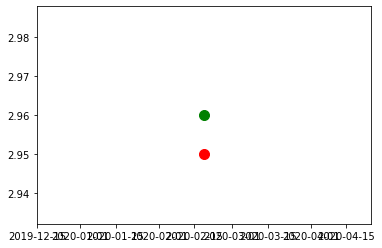

buy time:2020-02-18T19:36:47.407945778Z sell time:2020-02-18T19:36:50.218843971Z
{'rsi': 57.74655975263223, 'macd1': [0.006957582740808821, 0.008010466431713326, 0.008361181956704655, 0.008668310280196767, 0.009081378792560546], 'macd2': [0.009293269964471662, 0.009570035148907419, 0.009732592745385293, 0.009892174775978368, 0.010077552446226878], 'macd_signal': [0.011838557041053886, 0.011072938919185774, 0.01053058752668955, 0.010158132077390993, 0.009942781420424904]}
{'rsi': 54.23321897079558, 'macd': [0.0034210063929149825, 0.004133175996741123, 0.004385085090674146, 0.004607545617236308, 0.004378196084463326], 'scalp': 0, 'bail_out': 0, 'movement': -0.0033783783783783066, 'too_close': 0, 'macd_signal': [0.006628226032793218, 0.006129216025582799, 0.005780389838601068, 0.005545820994328116, 0.005312296012355158], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0009340999278918318}


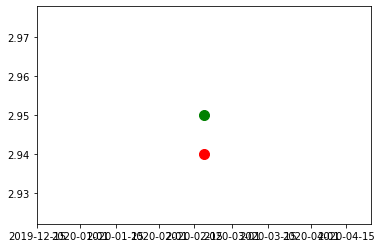

buy time:2020-02-18T19:38:47.064310789Z sell time:2020-02-18T19:38:53.374338795Z
{'rsi': 57.21974669784332, 'macd1': [0.006957582740808821, 0.008010466431713326, 0.008361181956704655, 0.008668310280196767, 0.008937789048970579], 'macd2': [0.009293269964471662, 0.009570035148907419, 0.009732592745385293, 0.009892174775978368, 0.010048763961620466], 'macd_signal': [0.011838557041053886, 0.011072938919185774, 0.01053058752668955, 0.010158132077390993, 0.00991406347170691]}
{'rsi': 51.73930494107939, 'macd': [0.004385085090674146, 0.004607545617236308, 0.0048041701104377665, 0.00488460257123835, 0.004208516143664021], 'scalp': 0, 'bail_out': 0, 'movement': -0.0044621729430059905, 'too_close': 1, 'macd_signal': [0.005780389838601068, 0.005545820994328116, 0.005397490817550046, 0.005294913168287707, 0.00507763376336297], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0008691176196989493}


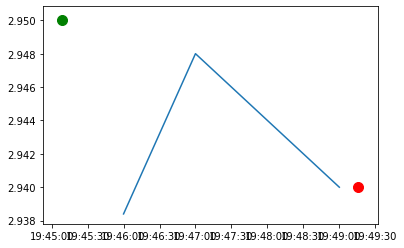

buy time:2020-02-18T19:45:08.310016749Z sell time:2020-02-18T19:49:15.404168263Z
{'rsi': 56.926325071463204, 'macd1': [0.007321207474160207, 0.006844293712490845, 0.007110594398219927, 0.007238202121817139, 0.007247715841196101], 'macd2': [0.010054354377448949, 0.010002263378537268, 0.010082283193807662, 0.010139778780437592, 0.010174860039819045], 'macd_signal': [0.008659097610164184, 0.008296136830629516, 0.008059028344147599, 0.007894863099681506, 0.007765433647984425]}
{'rsi': 47.470246115371644, 'macd': [0.003970128042669607, 0.003144739636572691, 0.0021178819222558154, 0.0017889293926289795, 0.001093785481327103], 'scalp': 0, 'bail_out': 0, 'movement': -0.003254678600488295, 'too_close': 1, 'macd_signal': [0.00415253269589336, 0.003950974084029226, 0.0035843556516745438, 0.003225270399865431, 0.002798973416157765], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001705187934830662}


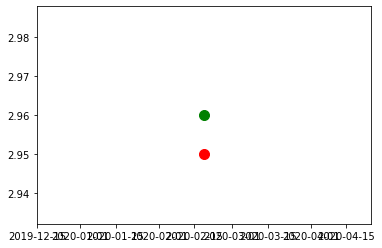

buy time:2020-02-18T19:52:02.840709672Z sell time:2020-02-18T19:52:08.976031222Z
{'rsi': 55.708859371261475, 'macd1': [0.004483126154462891, 0.003935114840622145, 0.002822739995411716, 0.003458654404487671, 0.003973303535193651], 'macd2': [0.009650795039272797, 0.009486941065123933, 0.009193068310715535, 0.009216669477793538, 0.009234838053377548], 'macd_signal': [0.006860055581665015, 0.006275067433456441, 0.0055846019458474965, 0.005159412437575532, 0.004922190657099155]}
{'rsi': 51.07611541834587, 'macd': [0.0017889293926289795, 0.001093785481327103, 0.001540507297438154, 0.0019049592671684934, 0.001644727564787285], 'scalp': 0, 'bail_out': 0, 'movement': -0.0033783783783783066, 'too_close': 1, 'macd_signal': [0.003225270399865431, 0.002798973416157765, 0.002547280192413843, 0.002418816007364773, 0.0022639983188492757], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000619270754061990

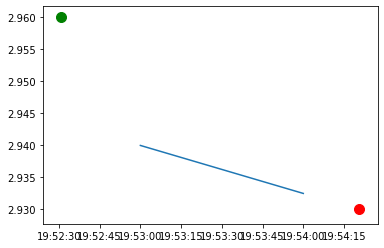

buy time:2020-02-18T19:52:30.699893422Z sell time:2020-02-18T19:54:20.335227961Z
{'rsi': 55.708859371261475, 'macd1': [0.003935114840622145, 0.002822739995411716, 0.003458654404487671, 0.003973303535193651, 0.004331238853722219], 'macd2': [0.009486941065123933, 0.009193068310715535, 0.009216669477793538, 0.009234838053377548, 0.009236783891124478], 'macd_signal': [0.006275067433456441, 0.0055846019458474965, 0.005159412437575532, 0.004922190657099155, 0.0048040002964237685]}
{'rsi': 46.74337675448446, 'macd': [0.001540507297438154, 0.0019049592671684934, 0.0026836886037484575, 0.001697196027008907, 0.0008960693954325194], 'scalp': 0, 'bail_out': 0, 'movement': -0.010168350168350245, 'too_close': 1, 'macd_signal': [0.002547280192413843, 0.002418816007364773, 0.00247179052664151, 0.0023168716267149897, 0.0020327111804584958], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00113664178502597

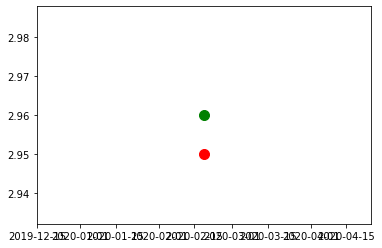

buy time:2020-02-18T19:57:08.816703385Z sell time:2020-02-18T19:57:11.321119296Z
{'rsi': 56.25937533918336, 'macd1': [0.003582776156749734, 0.0017322588756458757, 0.0008609731554001243, 0.0025616926263709594, 0.0036256558286829055], 'macd2': [0.009050819591993164, 0.008598152688533478, 0.00828788513330947, 0.008468981820593413, 0.008574070805062561], 'macd_signal': [0.004687390796124251, 0.004096364412028576, 0.0034492861607028857, 0.0032717674538365006, 0.0033425451288057817]}
{'rsi': 53.25025932060249, 'macd': [0.001697196027008907, 0.000516848616211707, -2.000454306161359e-05, 0.001120369677544364, 0.0014022149185679567], 'scalp': 0, 'bail_out': 0, 'movement': -0.002831142568250746, 'too_close': 0, 'macd_signal': [0.0023168716267149897, 0.0019568670246143333, 0.001561492711079144, 0.001473268104372188, 0.0014590574672113418], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -5.684254864338

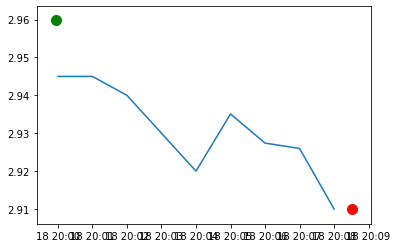

buy time:2020-02-18T19:59:57.161343915Z sell time:2020-02-18T20:08:30.35856332Z
{'rsi': 57.30015178750277, 'macd1': [0.003582776156749734, 0.0017322588756458757, 0.0008609731554001243, 0.0025616926263709594, 0.003841040444067634], 'macd2': [0.009050819591993164, 0.008598152688533478, 0.00828788513330947, 0.008468981820593413, 0.008617253531971958], 'macd_signal': [0.004687390796124251, 0.004096364412028576, 0.0034492861607028857, 0.0032717674538365006, 0.0033856220518827273]}
{'rsi': 38.39680836835155, 'macd': [-0.0017760849860342098, -0.0021330754810766628, -0.0027835476138231563, -0.003326986319680092, -0.004538406268144168], 'scalp': 0, 'bail_out': 0, 'movement': -0.0034246575342465023, 'too_close': 1, 'macd_signal': [0.0003743364705963328, -0.0001271459197382664, -0.0006584262585552444, -0.001192138270780214, -0.0018613918702530049], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002

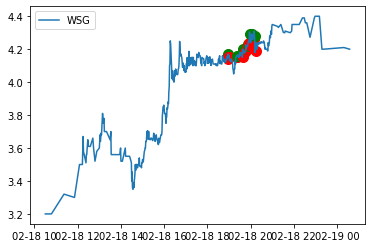

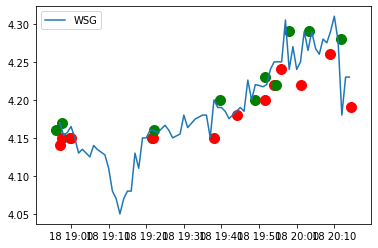

Delta = -0.2500000000000009


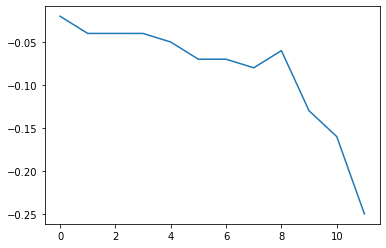

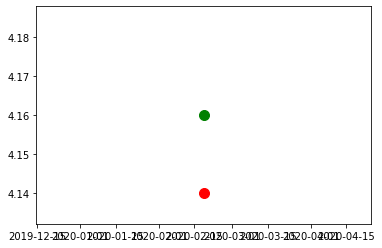

buy time:2020-02-18T18:56:06.842443199Z sell time:2020-02-18T18:56:57.503148541Z
{'rsi': 58.5708669161715, 'macd1': [0.001435121073083856, 0.002149787190130148, 0.0034829325845100456, 0.004990292279998698, 0.006409559365865292], 'macd2': [0.004672941721577395, 0.004725405172483654, 0.0049260516258406994, 0.005203533945981498, 0.005509680560479957], 'macd_signal': [0.001819875007031147, 0.0018858574436509473, 0.002205272471822767, 0.0027622764334579533, 0.003491733019939421]}
{'rsi': 53.01778191631915, 'macd': [0.0008932845228439845, 0.0013513251949515137, 0.002210170846010051, 0.003177970433250188, 0.003184334131966615], 'scalp': 0, 'bail_out': 0, 'movement': -0.004158653846153975, 'too_close': 0, 'macd_signal': [0.001193615981759665, 0.0012251578243980348, 0.001422160428720438, 0.001773322429626388, 0.0020555247700944335], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001128809361872181

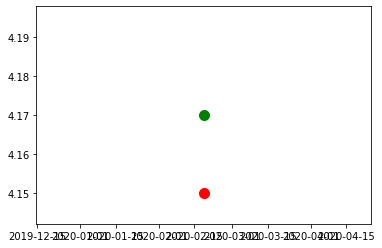

buy time:2020-02-18T18:57:39.038249775Z sell time:2020-02-18T18:57:42.736392565Z
{'rsi': 59.90868581920999, 'macd1': [0.002149787190130148, 0.0034829325845100456, 0.004990292279998698, 0.005029502385808904, 0.007180684065451359], 'macd2': [0.004725405172483654, 0.0049260516258406994, 0.005203533945981498, 0.005232991236209017, 0.005688348797132647], 'macd_signal': [0.0018858574436509473, 0.002205272471822767, 0.0027622764334579533, 0.0032157216239281435, 0.0040087141122327865]}
{'rsi': 53.311730270683114, 'macd': [0.0013513251949515137, 0.002210170846010051, 0.003177970433250188, 0.003184334131966615, 0.003199885921461032], 'scalp': 0, 'bail_out': 0, 'movement': -0.006306954436450837, 'too_close': 1, 'macd_signal': [0.0012251578243980348, 0.001422160428720438, 0.001773322429626388, 0.0020555247700944335, 0.002284397000367753], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000915488921093

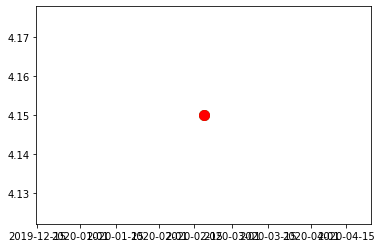

buy time:2020-02-18T18:59:46.372050649Z sell time:2020-02-18T18:59:54.651089189Z
{'rsi': 58.59626983474671, 'macd1': [0.002149787190130148, 0.0034829325845100456, 0.004990292279998698, 0.005029502385808904, 0.006710028794796763], 'macd2': [0.004725405172483654, 0.0049260516258406994, 0.005203533945981498, 0.005232991236209017, 0.005593986542034912], 'macd_signal': [0.0018858574436509473, 0.002205272471822767, 0.0027622764334579533, 0.0032157216239281435, 0.003914583058101867]}
{'rsi': 53.616131586675245, 'macd': [0.003177970433250188, 0.003184334131966615, 0.004566119687694048, 0.004736782202706458, 0.004616041536447568], 'scalp': 0, 'bail_out': 0, 'movement': -0.003386085828870584, 'too_close': 0, 'macd_signal': [0.001773322429626388, 0.0020555247700944335, 0.0025576437536143563, 0.0029934714434327768, 0.003317985462035735], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0012980560744118

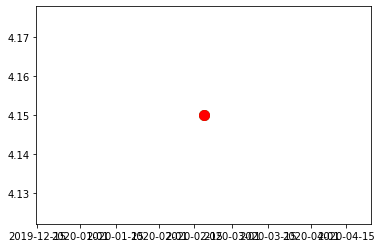

buy time:2020-02-18T19:21:36.809051757Z sell time:2020-02-18T19:21:48.286955009Z
{'rsi': 57.365110432954225, 'macd1': [-0.013067792161970182, -0.011344482438789605, -0.006674145961212297, -0.002938991786914258, 2.0903840093566828e-05], 'macd2': [-0.0011753372635210368, -0.0012779943839493768, -0.0007306541426732593, -0.00022591503361901744, 0.00023882241143091676], 'macd_signal': [-0.010873871293857258, -0.010967993522843727, -0.010109224010517441, -0.008675177565796804, -0.0069359612846187305]}
{'rsi': 57.365110432954225, 'macd': [-0.00836773110969613, -0.007182619958135739, -0.004087953866553917, -0.0016234354332889112, 0.00031805211773949793], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.007148967356667653, -0.00715569787696127, -0.006542149074879799, -0.0055584063465616215, -0.004383114653701397], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0047011

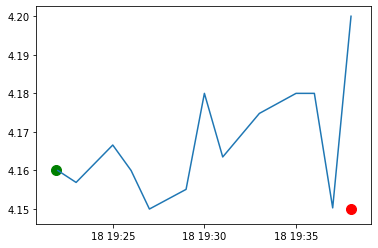

buy time:2020-02-18T19:21:55.767265368Z sell time:2020-02-18T19:38:00.328268774Z
{'rsi': 59.289322736113036, 'macd1': [-0.013067792161970182, -0.011344482438789605, -0.006674145961212297, -0.002938991786914258, 0.0008186246378141249], 'macd2': [-0.0011753372635210368, -0.0012779943839493768, -0.0007306541426732593, -0.00022591503361901744, 0.0003987584370204189], 'macd_signal': [-0.010873871293857258, -0.010967993522843727, -0.010109224010517441, -0.008675177565796804, -0.006776417125074619]}
{'rsi': 50.77572221414412, 'macd': [0.0077386240583239285, 0.008288394333203719, 0.00887927514047071, 0.009224386481972324, 0.007830650040518528], 'scalp': 0, 'bail_out': 0, 'movement': -0.005868544600939119, 'too_close': 1, 'macd_signal': [0.004691612204134684, 0.005410968629948491, 0.006104629932052935, 0.006728581242036813, 0.0069489950017331565], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000

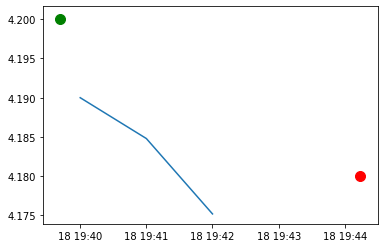

buy time:2020-02-18T19:39:41.857584843Z sell time:2020-02-18T19:44:13.696798239Z
{'rsi': 61.91154898632153, 'macd1': [0.013811035792469895, 0.014437294802819522, 0.012394195226280047, 0.014616904159462152, 0.0161917683759496], 'macd2': [0.005030865556782338, 0.005506593131662463, 0.005460460695546843, 0.006204166182038229, 0.006878476321857896], 'macd_signal': [0.00930001344945677, 0.01032746972012932, 0.010740814821359464, 0.011516032688980002, 0.012451179826373922]}
{'rsi': 55.87834902940488, 'macd': [0.009224743072626218, 0.009671766953844418, 0.009894489887860125, 0.009669410487251007, 0.009119096532396398], 'scalp': 0, 'bail_out': 0, 'movement': -0.002386634844868896, 'too_close': 1, 'macd_signal': [0.007404144615911769, 0.0078576690834983, 0.008265033244370664, 0.008545908692946733, 0.008660546260836666], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0004585502715597316}


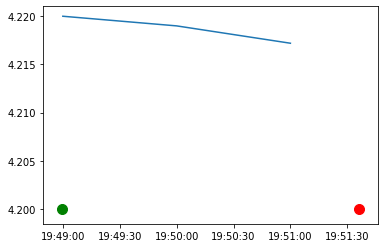

buy time:2020-02-18T19:48:59.442528519Z sell time:2020-02-18T19:51:35.954924518Z
{'rsi': 60.04564959865457, 'macd1': [0.014428375560298967, 0.014548655548789036, 0.014078234963717406, 0.01681989137183848, 0.017499879824105946], 'macd2': [0.007650741946437556, 0.008002955324566408, 0.008234235277294388, 0.009089588428082607, 0.009606105519745611], 'macd_signal': [0.013696414697513412, 0.013866862867768536, 0.01390913728695831, 0.014491288103934344, 0.015093006447968665]}
{'rsi': 53.38666965516132, 'macd': [0.00854872732285017, 0.010293645450047961, 0.010168988855006944, 0.010978750094520429, 0.009908710150056343], 'scalp': 0, 'bail_out': 0, 'movement': -0.003567181926278164, 'too_close': 1, 'macd_signal': [0.00864462143173241, 0.00897442623539552, 0.009213338759317805, 0.009566421026358329, 0.009634878851097931], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00027383129895841227}


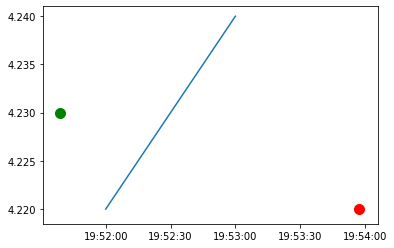

buy time:2020-02-18T19:51:38.903582982Z sell time:2020-02-18T19:53:57.452548213Z
{'rsi': 62.947670615862485, 'macd1': [0.01681989137183848, 0.0167021590263845, 0.01801502218562856, 0.01875854720001513, 0.020004801303024067], 'macd2': [0.009089588428082607, 0.00944616949415611, 0.010078999704095537, 0.010629110185604418, 0.011294159276851623], 'macd_signal': [0.014491288103934344, 0.014933462288424374, 0.015549774267865211, 0.016191528854295194, 0.016954183344040967]}
{'rsi': 60.87922822761121, 'macd': [0.010978750094520429, 0.0114152036565498, 0.011513541449605036, 0.011586096334458063, 0.011492163824805779], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.009566421026358329, 0.009936177552396622, 0.010251650331838304, 0.010518539532362255, 0.01071326439085096], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0007788994339548196}


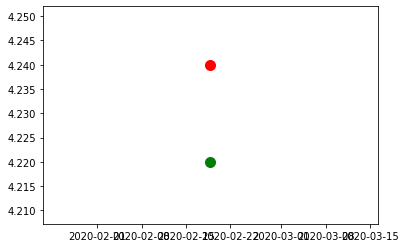

buy time:2020-02-18T19:54:32.604163572Z sell time:2020-02-18T19:55:46.950680852Z
{'rsi': 63.04587675552812, 'macd1': [0.01801502218562856, 0.01875854720001513, 0.01898371868194193, 0.019167158234083992, 0.019890170324974754], 'macd2': [0.010078999704095537, 0.010629110185604418, 0.01108944116409738, 0.011540006464719532, 0.012096020351513914], 'macd_signal': [0.015549774267865211, 0.016191528854295194, 0.01674996681982454, 0.01723340510267643, 0.017764758147136094]}
{'rsi': 61.509010884789674, 'macd': [0.0114152036565498, 0.011513541449605036, 0.011586096334458063, 0.012531124863766507, 0.012585288329931998], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.009936177552396622, 0.010251650331838304, 0.010518539532362255, 0.010921056598643106, 0.011253902944900885], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0013313853850311138}


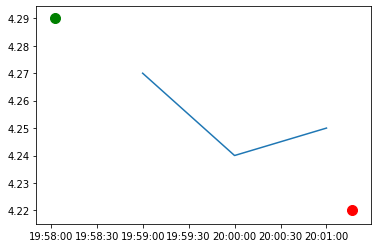

buy time:2020-02-18T19:58:02.604228154Z sell time:2020-02-18T20:01:16.33807947Z
{'rsi': 73.82164876872356, 'macd1': [0.02244130986878634, 0.023559329571634535, 0.02416678854598331, 0.028754777331630343, 0.0316228052710219], 'macd2': [0.013054987533794637, 0.013769242128521597, 0.014404357224064412, 0.015845293811808325, 0.017065691218106416], 'macd_signal': [0.018827703819101576, 0.019774028969608167, 0.020652580884883195, 0.022273020174232626, 0.02414297719359048]}
{'rsi': 51.90822460432092, 'macd': [0.01757132513306736, 0.016251237636343063, 0.016569984552710082, 0.015044722610232597, 0.012933548075702461], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009456264775414769, 'too_close': 1, 'macd_signal': [0.013555217070163213, 0.014094421183399184, 0.014589533857261364, 0.014680571607855611, 0.014331166901424981], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0013976188257225197}


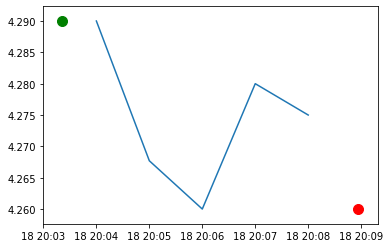

buy time:2020-02-18T20:03:20.515927538Z sell time:2020-02-18T20:08:56.752216414Z
{'rsi': 62.45194440461793, 'macd1': [0.027420874915336846, 0.02517308280355479, 0.023922840176904714, 0.025861563587057823, 0.02708578775641346], 'macd2': [0.016800050819202106, 0.016931853301464628, 0.017185971693500335, 0.018032026284983793, 0.01878158386589668], 'macd_signal': [0.024032744772127735, 0.024260812378413148, 0.02419321793811146, 0.02452688706790073, 0.025038667205603278]}
{'rsi': 53.78656573836705, 'macd': [0.015531442268473583, 0.014700280166989543, 0.013461708657170668, 0.013360721653972618, 0.012069553578052172], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004458105539782756, 'too_close': 1, 'macd_signal': [0.014919188183965195, 0.014875406580570065, 0.014592666995890185, 0.014346277927506671, 0.013890933057615771], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0018213794795635986}


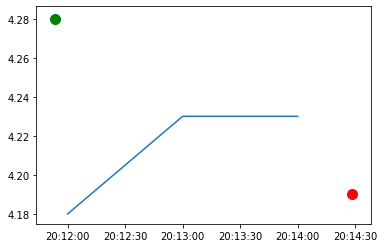

buy time:2020-02-18T20:11:53.631695673Z sell time:2020-02-18T20:14:28.341988419Z
{'rsi': 59.87431452034079, 'macd1': [0.023020180849077754, 0.02226784409878846, 0.022621223065384832, 0.024235736807698416, 0.02442675769631908], 'macd2': [0.019757714447569796, 0.019975931477437037, 0.02038465345257201, 0.021047960390187193, 0.02146462469322241], 'macd_signal': [0.024278920384933993, 0.023876705127704886, 0.023625608715240876, 0.023747634333732386, 0.023883459006249726]}
{'rsi': 43.02016236904042, 'macd': [0.014097841842653835, 0.01303342873591351, 0.006969815552272607, 0.004751807674731268, 0.0008838559821695569], 'scalp': 0, 'bail_out': 0, 'movement': -0.014117647058823438, 'too_close': 1, 'macd_signal': [0.013899459059640065, 0.013726252994894755, 0.012374965506370326, 0.010850333940042515, 0.008857038348467922], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.007973182366298365}
MRNS ana

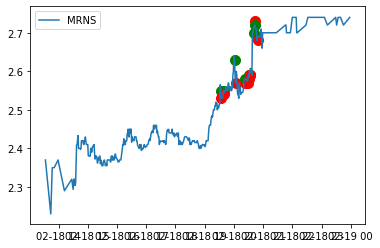

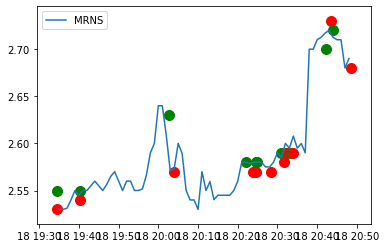

Delta = -0.14000000000000057


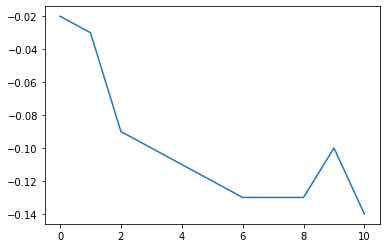

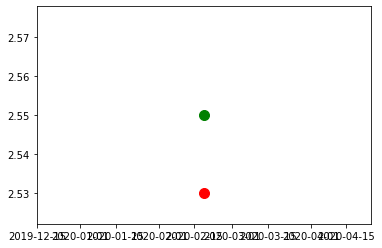

buy time:2020-02-18T19:34:22.088052681Z sell time:2020-02-18T19:34:24.021940665Z
{'rsi': 73.44837189663477, 'macd1': [0.019559595406816843, 0.019167623880312235, 0.018642089221308833, 0.022014481277972564, 0.023344822846264712], 'macd2': [0.011811628093489013, 0.01217117696770309, 0.012482507336233795, 0.01355025669594756, 0.014298233605150923], 'macd_signal': [0.021319155143253384, 0.020888848890665154, 0.02043949695679389, 0.020754493821029625, 0.021272559626076642]}
{'rsi': 62.184113434058816, 'macd': [0.011309432823489729, 0.0109311886483483, 0.0130970868411171, 0.013840681707675273, 0.013191006516581893], 'scalp': 0, 'bail_out': 0, 'movement': -0.008542989262481489, 'too_close': 1, 'macd_signal': [0.012684618192881355, 0.012333932283974744, 0.012486563195403215, 0.012757386897857628, 0.012844110821602481], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0003468956949794124}


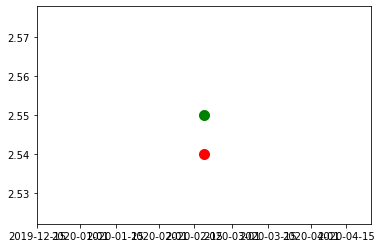

buy time:2020-02-18T19:40:12.764796097Z sell time:2020-02-18T19:40:17.384145044Z
{'rsi': 68.3573805833552, 'macd1': [0.020350029442999684, 0.019402126974098266, 0.019140355786507524, 0.019514861485272483, 0.019585886047150947], 'macd2': [0.01510478151334027, 0.015304821148538483, 0.015605129791480543, 0.016016401150234394, 0.016369167960267106], 'macd_signal': [0.021235821207331022, 0.020869082360684472, 0.020523337045849084, 0.020321641933733765, 0.020174490756417203]}
{'rsi': 65.34734046438115, 'macd': [0.0118657318618558, 0.011224881108890195, 0.011036882066204345, 0.011266533694420211, 0.01103942413595993], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019607843137254485, 'too_close': 1, 'macd_signal': [0.01261328462158186, 0.012335603919043526, 0.01207585954847569, 0.011913994377664595, 0.011739080329323661], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006996561933637312}


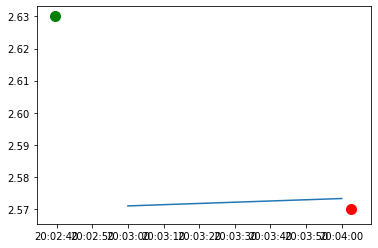

buy time:2020-02-18T20:02:39.610970159Z sell time:2020-02-18T20:04:02.717890502Z
{'rsi': 74.46031673133383, 'macd1': [0.01235569121290947, 0.014560322532455316, 0.01931255137218546, 0.022815721530125455, 0.024502641493980182], 'macd2': [0.01791831171679803, 0.018381938030399336, 0.01941883383026921, 0.020341753422504105, 0.020998399151429314], 'macd_signal': [0.012857823539215689, 0.013198323337863613, 0.014421168944727983, 0.016100079461807477, 0.01778059186824202]}
{'rsi': 50.868792786424734, 'macd': [0.011309017481938355, 0.013584041904029398, 0.013544008441970234, 0.011388865374885704, 0.009509677720340282], 'scalp': 0, 'bail_out': 0, 'movement': -0.01934597626588315, 'too_close': 1, 'macd_signal': [0.008044486603643337, 0.009152397663720549, 0.010030719819370485, 0.01030234893047353, 0.01014381468844688], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006341369681065988}


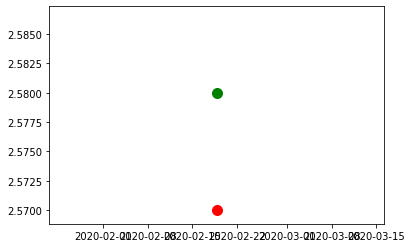

buy time:2020-02-18T20:22:03.04362371Z sell time:2020-02-18T20:23:45.597330226Z
{'rsi': 57.087867575705054, 'macd1': [-0.004778585730898843, -0.004590354049957668, -0.003592846561471852, -0.0011749378846066527, 0.0007328246158957441], 'macd2': [0.012229108028723346, 0.011796573821448497, 0.011539697569459051, 0.01160477911839708, 0.01164609600269717], 'macd_signal': [-0.0010735375021423237, -0.0017769008117053927, -0.0021400899616586845, -0.001947059546248278, -0.0014110827138194737]}
{'rsi': 56.654311331729524, 'macd': [-0.0035904272973885654, -0.0028728643204827264, -0.0012374533732768533, 4.7768837185380164e-05, 0.0009966722630370128], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004263565891473259, 'too_close': 0, 'macd_signal': [-0.002014804101982899, -0.0021864161456828643, -0.001996623591201662, -0.0015877451055242536, -0.0010708616318120003], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_ma

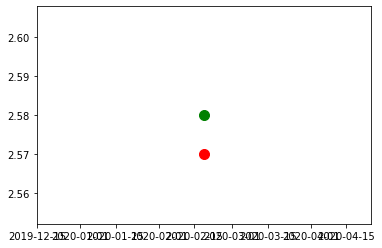

buy time:2020-02-18T20:24:33.282569488Z sell time:2020-02-18T20:24:42.86104246Z
{'rsi': 57.0082279406957, 'macd1': [-0.003592846561471852, -0.0011749378846066527, 0.0007248474079184497, 0.0021252507293221257, 0.0032859627249592904], 'macd2': [0.011539697569459051, 0.01160477911839708, 0.011644496642440938, 0.011646420687325243, 0.01164715701060759], 'macd_signal': [-0.0021400899616586845, -0.001947059546248278, -0.0014126781554149323, -0.0007050923784675207, 9.311864221784151e-05]}
{'rsi': 55.0476429487899, 'macd': [-0.0028728643204827264, -0.0012374533732768533, 4.7768837185380164e-05, 0.0009966722630370128, 0.0015205363317130072], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019379844961239896, 'too_close': 0, 'macd_signal': [-0.0021864161456828643, -0.001996623591201662, -0.0015877451055242536, -0.0010708616318120003, -0.0005525820391069987], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 

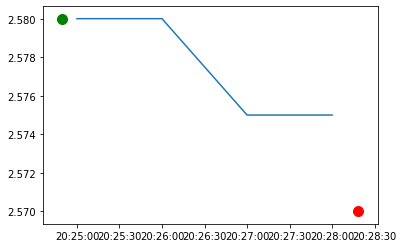

buy time:2020-02-18T20:24:49.701640352Z sell time:2020-02-18T20:28:18.276604277Z
{'rsi': 57.0082279406957, 'macd1': [-0.003592846561471852, -0.0011749378846066527, 0.0007248474079184497, 0.0021252507293221257, 0.0032859627249592904], 'macd2': [0.011539697569459051, 0.01160477911839708, 0.011644496642440938, 0.011646420687325243, 0.01164715701060759], 'macd_signal': [-0.0021400899616586845, -0.001947059546248278, -0.0014126781554149323, -0.0007050923784675207, 9.311864221784151e-05]}
{'rsi': 54.482739735220896, 'macd': [0.0017802765914529672, 0.002367756891628936, 0.0027947836594068853, 0.0028314956387225365, 0.0028233297052184803], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019379844961239896, 'too_close': 0, 'macd_signal': [-0.0005006339871590067, 7.304418859858193e-05, 0.0006173920827602426, 0.0010602127939527014, 0.0014128361762058572], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00

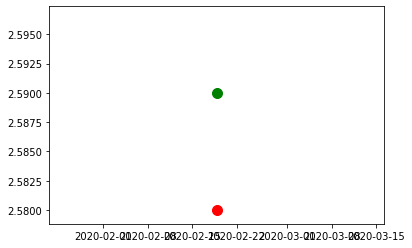

buy time:2020-02-18T20:30:58.253854943Z sell time:2020-02-18T20:31:34.36342086Z
{'rsi': 60.8298105819302, 'macd1': [0.0047936681813136595, 0.004838283674494459, 0.004818101697077637, 0.005146242863522499, 0.006142407676394512], 'macd2': [0.011594092072447992, 0.011463274577592664, 0.011324584392077508, 0.011258840907695689, 0.011340283882028679], 'macd_signal': [0.0016835944627174929, 0.002314532305072886, 0.0028152461834738364, 0.003281445519483569, 0.0038536379508657577]}
{'rsi': 57.86275811614525, 'macd': [0.0028314956387225365, 0.0028233297052184803, 0.0030400402803425486, 0.0036889051404345174, 0.0038868660036173175], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019305019305018896, 'too_close': 0, 'macd_signal': [0.0010602127939527014, 0.0014128361762058572, 0.0017382769970331956, 0.00212840262571346, 0.0024800953012942316], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00140677070232

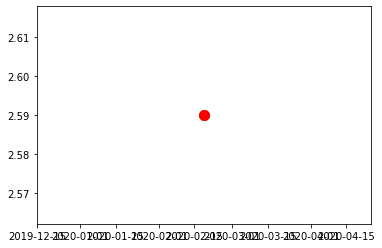

buy time:2020-02-18T20:32:04.783746588Z sell time:2020-02-18T20:32:29.745008176Z
{'rsi': 59.9656927017294, 'macd1': [0.004818101697077637, 0.005146242863522499, 0.006142407676394512, 0.006454019336891381, 0.0070234698476863144], 'macd2': [0.011324584392077508, 0.011258840907695689, 0.011340283882028679, 0.011317108811421672, 0.01135765488390783], 'macd_signal': [0.0028152461834738364, 0.003281445519483569, 0.0038536379508657577, 0.004373714228070882, 0.0049036653519939685]}
{'rsi': 59.9656927017294, 'macd': [0.0028233297052184803, 0.0030400402803425486, 0.0036889051404345174, 0.0038868660036173175, 0.004250382702154276], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0014128361762058572, 0.0017382769970331956, 0.00212840262571346, 0.0024800953012942316, 0.0028341527814662406], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0014162299206880355}


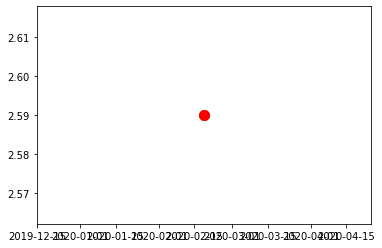

buy time:2020-02-18T20:33:24.74737767Z sell time:2020-02-18T20:33:58.678370011Z
{'rsi': 60.63584895008992, 'macd1': [0.005146242863522499, 0.006142407676394512, 0.006454019336891381, 0.007821190645406872, 0.008404345480906183], 'macd2': [0.011258840907695689, 0.011340283882028679, 0.011317108811421672, 0.011517590909497333, 0.011603652062650127], 'macd_signal': [0.003281445519483569, 0.0038536379508657577, 0.004373714228070882, 0.00506320951153808, 0.005731436705411701]}
{'rsi': 57.936514139850345, 'macd': [0.0030400402803425486, 0.0036889051404345174, 0.0038868660036173175, 0.0047698632216350845, 0.004876486206822239], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019267822736032127, 'too_close': 0, 'macd_signal': [0.0017382769970331956, 0.00212840262571346, 0.0024800953012942316, 0.0029380488853624023, 0.00332573634965437], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0015507498571678694

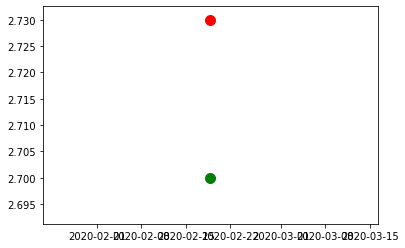

buy time:2020-02-18T20:42:15.570804783Z sell time:2020-02-18T20:43:33.889249938Z
{'rsi': 74.7044659970395, 'macd1': [0.009263189937039673, 0.017372649727835032, 0.023520258968739327, 0.028874422801712818, 0.0319504836645641], 'macd2': [0.011861963238244844, 0.013505145251942352, 0.01499372631252216, 0.01650082351969706, 0.017702673731464724], 'macd_signal': [0.00804514563234484, 0.009910646451442878, 0.012632568954902168, 0.015880939724264298, 0.019094848512324257]}
{'rsi': 74.16299417844222, 'macd': [0.01482488101488233, 0.0182371503217702, 0.02079428029698427, 0.021342767546541186, 0.023051422967669488], 'scalp': 0, 'bail_out': 1, 'movement': 0.007370097403799953, 'too_close': 0, 'macd_signal': [0.007816054592916372, 0.009900273738687137, 0.012079075050346564, 0.013931813549585488, 0.015755735433202286], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.007295687534467202}


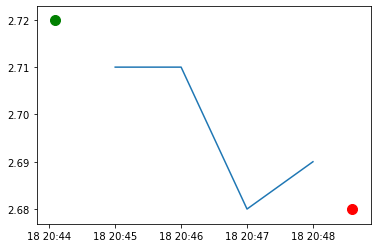

buy time:2020-02-18T20:44:05.236966049Z sell time:2020-02-18T20:48:35.437240984Z
{'rsi': 74.16299417844222, 'macd1': [0.023520258968739327, 0.028874422801712818, 0.03294763466171524, 0.033960576892067884, 0.03676033987149463], 'macd2': [0.01499372631252216, 0.01650082351969706, 0.017902593763451602, 0.018802179111642392, 0.020079563025972913], 'macd_signal': [0.012632568954902168, 0.015880939724264298, 0.019294278711754487, 0.022227538347817166, 0.02513409865255266]}
{'rsi': 0, 'macd': [], 'bail_out': 0, 'too_close': 0, 'macd_signal': [], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0}
PBYI analysis for run 66


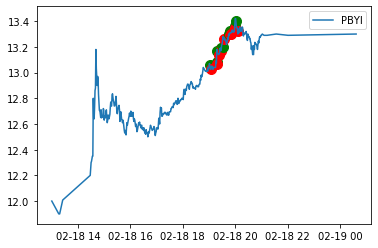

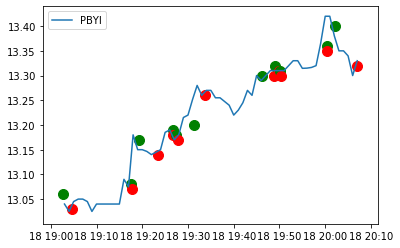

Delta = -0.1399999999999988


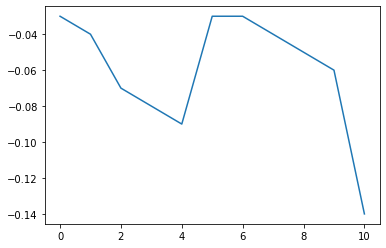

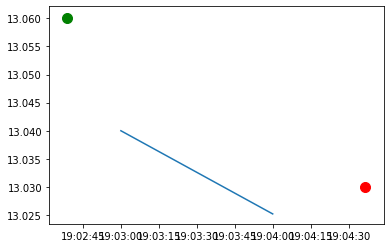

buy time:2020-02-18T19:02:38.61428733Z sell time:2020-02-18T19:04:36.574790619Z
{'rsi': 68.80953074690969, 'macd1': [0.02937266650007153, 0.02831706657926958, 0.02829211431562939, 0.030343309957329367, 0.030958425517551902], 'macd2': [0.035885512406917286, 0.03584187584691101, 0.03596991454024945, 0.03650999345876471, 0.036818942526206655], 'macd_signal': [0.031288188362546474, 0.030693964005891094, 0.030213594067838752, 0.030239537245736876, 0.03038331490009988]}
{'rsi': 58.04118210270032, 'macd': [0.016226646729954552, 0.01755005932602849, 0.017314406033021257, 0.016386437154924494, 0.014957027156992098], 'scalp': 0, 'bail_out': 0, 'movement': -0.0022588055130168855, 'too_close': 1, 'macd_signal': [0.017610399042216843, 0.017598331098979174, 0.01754154608578759, 0.017310524299614972, 0.016839824871090397], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0018827977140982999}


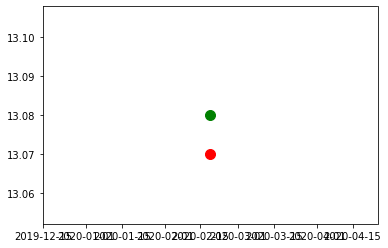

buy time:2020-02-18T19:17:37.578904842Z sell time:2020-02-18T19:17:51.222197504Z
{'rsi': 65.44518972483303, 'macd1': [0.01661594585042181, 0.015550139814143549, 0.014537897024304414, 0.01756775925990972, 0.018943659766325283], 'macd2': [0.03375158056407379, 0.03330698047451719, 0.03284466430979727, 0.03316646832728409, 0.0332495571601239], 'macd_signal': [0.021337236682112324, 0.020179817308518568, 0.019051433251675735, 0.018754698453322532, 0.018792490715923083]}
{'rsi': 63.57864190703333, 'macd': [0.008729395449185162, 0.00807980492106708, 0.007468697952131009, 0.009492917223711927, 0.010167725523336557], 'scalp': 0, 'bail_out': 0, 'movement': -0.00038226299694195577, 'too_close': 0, 'macd_signal': [0.011730248321221574, 0.011000159641190676, 0.010293867303378742, 0.010133677287445379, 0.010140486934623615], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 2.7238588712941852e-05}


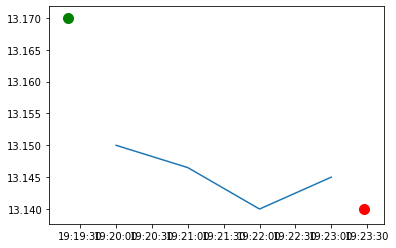

buy time:2020-02-18T19:19:19.684693915Z sell time:2020-02-18T19:23:27.762563107Z
{'rsi': 74.8493707283743, 'macd1': [0.014537897024304414, 0.01756775925990972, 0.018544799367463227, 0.027475018262355988, 0.03336080208869774], 'macd2': [0.03284466430979727, 0.03316646832728409, 0.03316958914732915, 0.03479873854770332, 0.036082016363005565], 'macd_signal': [0.019051433251675735, 0.018754698453322532, 0.01871271863615067, 0.020465178561391732, 0.023044303266852934]}
{'rsi': 66.56825225386008, 'macd': [0.01880673887946216, 0.020737060428514198, 0.021790076435197037, 0.021989958045143254, 0.021860126078280473], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004944281747993049, 'too_close': 0, 'macd_signal': [0.012813826973014713, 0.014398473664114609, 0.015876794218331096, 0.017099426983693527, 0.018051566802610917], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003808559275669556}


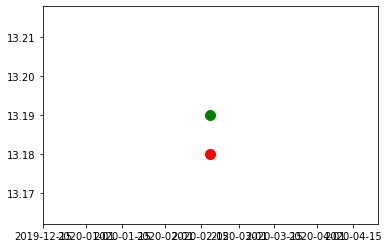

buy time:2020-02-18T19:26:42.828411805Z sell time:2020-02-18T19:26:43.328115343Z
{'rsi': 73.56407291092428, 'macd1': [0.036817498345540045, 0.03709309386822923, 0.03728516336471621, 0.03980276580937314, 0.04172051398328591], 'macd2': [0.037672666490863094, 0.038090750876168755, 0.03849444906372668, 0.03936407390711594, 0.04018116725737997], 'macd_signal': [0.02927898491620544, 0.030841806706610197, 0.0321304780382314, 0.03366493559245975, 0.03527605127062498]}
{'rsi': 72.94623535263062, 'macd': [0.021989958045143254, 0.022119866338021765, 0.02219356284756202, 0.023780942428404117, 0.02470901817414628], 'scalp': 0, 'bail_out': 0, 'movement': -0.0003790750568611831, 'too_close': 0, 'macd_signal': [0.017099426983693527, 0.018103514854559175, 0.018921524453159744, 0.01989340804820862, 0.020856530073396152], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003852488100750128}


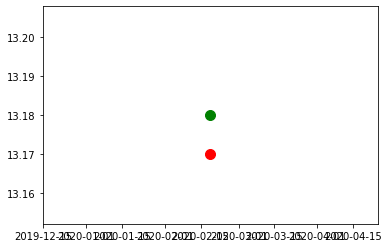

buy time:2020-02-18T19:27:23.062610861Z sell time:2020-02-18T19:27:46.66681548Z
{'rsi': 72.94623535263062, 'macd1': [0.036817498345540045, 0.03709309386822923, 0.03728516336471621, 0.03980276580937314, 0.04132165358442563], 'macd2': [0.037672666490863094, 0.038090750876168755, 0.03849444906372668, 0.03936407390711594, 0.04010119924458522], 'macd_signal': [0.02927898491620544, 0.030841806706610197, 0.0321304780382314, 0.03366493559245975, 0.03519627919085293]}
{'rsi': 68.50929548323771, 'macd': [0.022119866338021765, 0.02219356284756202, 0.023780942428404117, 0.024968758433887572, 0.02479083897797807], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007584376185058617, 'too_close': 0, 'macd_signal': [0.018103514854559175, 0.018921524453159744, 0.01989340804820862, 0.02090847812534441, 0.02168495029587114], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0031058886821069276}


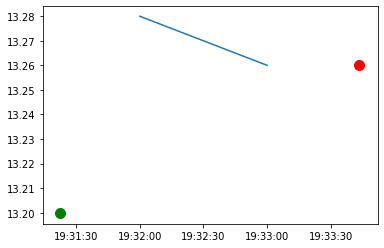

buy time:2020-02-18T19:31:22.464168787Z sell time:2020-02-18T19:33:43.289441935Z
{'rsi': 71.49951621148, 'macd1': [0.04172051398328591, 0.041152134188108036, 0.041083436238176674, 0.043313562502609315, 0.04416037296616615], 'macd2': [0.04018116725737997, 0.04054878306302889, 0.04099168143829601, 0.04188538093279526, 0.04255905586806463], 'macd_signal': [0.03527605127062498, 0.036451267854121595, 0.03737770153093261, 0.03856487372526795, 0.03968397357344759]}
{'rsi': 73.8275636578444, 'macd': [0.025812254510670485, 0.026814790699425828, 0.02888930213612717, 0.031605943487631905, 0.032335716703251194], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006631499623209519, 'too_close': 0, 'macd_signal': [0.022915112950499278, 0.023695048500284588, 0.024733899227453105, 0.026108308079488864, 0.02735378980424133], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004981926899009864}


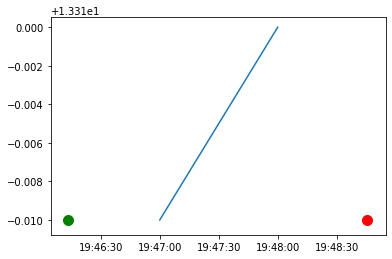

buy time:2020-02-18T19:46:13.363154736Z sell time:2020-02-18T19:48:45.454805776Z
{'rsi': 70.39106620302552, 'macd1': [0.03828104154034406, 0.038340383278308465, 0.03715222785046457, 0.03898883282465526, 0.039983451162557415], 'macd2': [0.04818263559856639, 0.04840750659950821, 0.04837703804563809, 0.04891137779188526, 0.04932476053676638], 'macd_signal': [0.045193646717326966, 0.04382299402952326, 0.04248884079371153, 0.04178883919990027, 0.0414277615924317]}
{'rsi': 66.119271160438, 'macd': [0.020895472708993168, 0.02209789777922566, 0.022228386174484527, 0.022560865623068693, 0.022085383821664806], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006390977443610155, 'too_close': 1, 'macd_signal': [0.02452814224736589, 0.024042093353737845, 0.02367935191788718, 0.023455654658923485, 0.02318160049147175], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.001096216669806943}


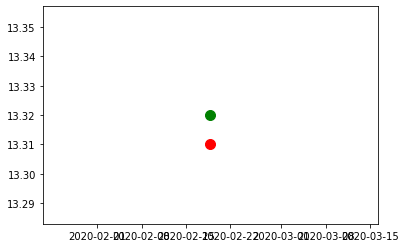

buy time:2020-02-18T19:48:58.038147175Z sell time:2020-02-18T19:49:58.495406192Z
{'rsi': 71.52579752426497, 'macd1': [0.03715222785046457, 0.03898883282465526, 0.039185730364838633, 0.0396911545873202, 0.04123026297145849], 'macd2': [0.04837703804563809, 0.04891137779188526, 0.0491648245111751, 0.04947930735925432, 0.0500093784524136], 'macd_signal': [0.04248884079371153, 0.04178883919990027, 0.041268217432887944, 0.040952804863774395, 0.041008296485311214]}
{'rsi': 70.94084902170898, 'macd': [0.02209789777922566, 0.022228386174484527, 0.022560865623068693, 0.023046422782705633, 0.023385215078750576], 'scalp': 0, 'bail_out': 0, 'movement': -0.00037537537537543403, 'too_close': 0, 'macd_signal': [0.024042093353737845, 0.02367935191788718, 0.023455654658923485, 0.023373808283679916, 0.023376089642694046], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 9.125436056529879e-06}


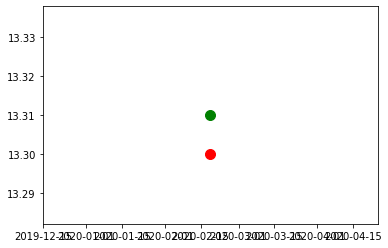

buy time:2020-02-18T19:50:08.986221056Z sell time:2020-02-18T19:50:26.428499251Z
{'rsi': 70.22728777784567, 'macd1': [0.03898883282465526, 0.039185730364838633, 0.0396911545873202, 0.040432542173739705, 0.04055263168248757], 'macd2': [0.04891137779188526, 0.0491648245111751, 0.04947930735925432, 0.0498494424268241, 0.050110251311579646], 'macd_signal': [0.04178883919990027, 0.041268217432887944, 0.040952804863774395, 0.04084875232576746, 0.04078952819711148]}
{'rsi': 66.69963008300515, 'macd': [0.022228386174484527, 0.022560865623068693, 0.023046422782705633, 0.023125474819009284, 0.022367262447051672], 'scalp': 0, 'bail_out': 0, 'movement': -0.0007513148009015618, 'too_close': 1, 'macd_signal': [0.02367935191788718, 0.023455654658923485, 0.023373808283679916, 0.02332414159074579, 0.023132765762006964], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007655033149552917}


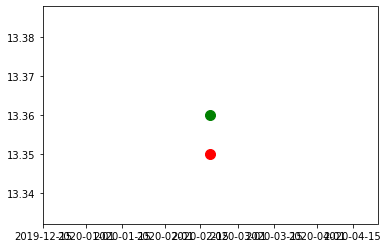

buy time:2020-02-18T20:00:17.742520548Z sell time:2020-02-18T20:00:23.393839752Z
{'rsi': 74.03536168248056, 'macd1': [0.035227569383344814, 0.033450765618042055, 0.03196465707693008, 0.034025801016779766, 0.03485403856490343], 'macd2': [0.050289598692796034, 0.04997216448543895, 0.04965776833627089, 0.050008805276462454, 0.050171820381729404], 'macd_signal': [0.038472148214257006, 0.03746787169501402, 0.03636722877139723, 0.03589894322047374, 0.03568996228935968]}
{'rsi': 71.83890020613592, 'macd': [0.019704632743373196, 0.01857029649103481, 0.01763223841790129, 0.01900995630353819, 0.019317139639055014], 'scalp': 0, 'bail_out': 0, 'movement': -0.00037425149700591356, 'too_close': 0, 'macd_signal': [0.021800191797278934, 0.02115421273603011, 0.020449817872404345, 0.020161845558631115, 0.019992904374715896], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006757647356608817}


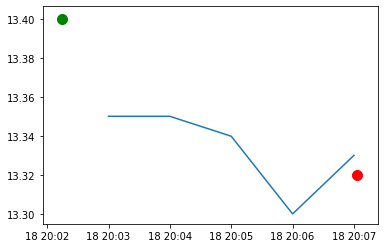

buy time:2020-02-18T20:02:14.476375252Z sell time:2020-02-18T20:07:03.384684201Z
{'rsi': 74.37736520057642, 'macd1': [0.03196465707693008, 0.034025801016779766, 0.03964036335122678, 0.04358749494259051, 0.04458781177408433], 'macd2': [0.04965776833627089, 0.050008805276462454, 0.05113143653526997, 0.05208251561578692, 0.052554368035542254], 'macd_signal': [0.03636722877139723, 0.03589894322047374, 0.03664722724662435, 0.03803528078581758, 0.03934578698347093]}
{'rsi': 52.76446384556059, 'macd': [0.0248705367125428, 0.022678191421581673, 0.020675348449124442, 0.018316310438779126, 0.015523341723721273], 'scalp': 0, 'bail_out': 0, 'movement': -0.001797752808988699, 'too_close': 1, 'macd_signal': [0.022244899943718588, 0.022331558239291206, 0.022000316281257853, 0.02126351511276211, 0.020115480434953942], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004592138711232669}
SOXS analysis for r

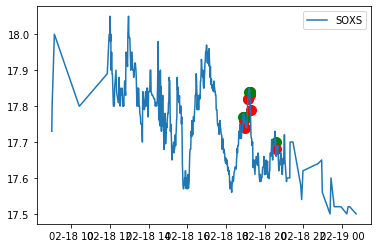

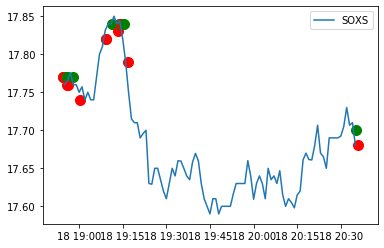

Delta = -0.129999999999999


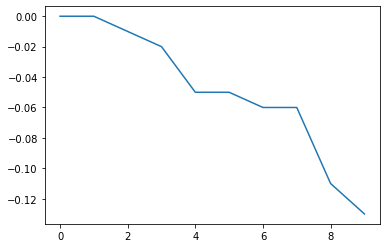

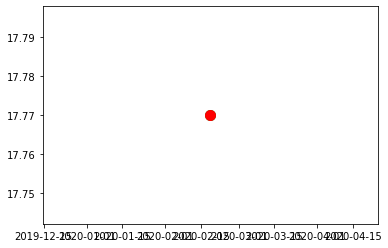

buy time:2020-02-18T18:54:26.64622786Z sell time:2020-02-18T18:54:36.935597016Z
{'rsi': 70.92593383160329, 'macd1': [0.02427377723403623, 0.02393029123626178, 0.02486425187918684, 0.025312634127867994, 0.026970909289911305], 'macd2': [-0.0024618212680422857, -0.0015456815311623018, -0.0004044499195323681, 0.0006461665291048746, 0.001931605866246855], 'macd_signal': [0.024025328913784276, 0.024006321378279776, 0.02417790747846119, 0.02440485280834255, 0.0249180641046563]}
{'rsi': 70.92593383160329, 'macd': [0.015073431564339046, 0.014751268380127414, 0.015269696179700532, 0.015475358151061158, 0.016473596594313022], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.015445817036568782, 0.015306907305280507, 0.015299465080164512, 0.015334643694343841, 0.015562434274337678], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009111623199753449}


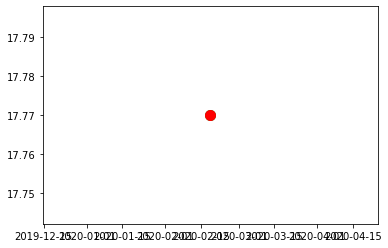

buy time:2020-02-18T18:54:39.849575417Z sell time:2020-02-18T18:54:45.509266298Z
{'rsi': 71.75896707549295, 'macd1': [0.02427377723403623, 0.02393029123626178, 0.02486425187918684, 0.025312634127867994, 0.027369769688771584], 'macd2': [-0.0024618212680422857, -0.0015456815311623018, -0.0004044499195323681, 0.0006461665291048746, 0.0020115738790451587], 'macd_signal': [0.024025328913784276, 0.024006321378279776, 0.02417790747846119, 0.02440485280834255, 0.024997836184428357]}
{'rsi': 70.92593383160329, 'macd': [0.015073431564339046, 0.014751268380127414, 0.015269696179700532, 0.015475358151061158, 0.016473596594313022], 'scalp': 0, 'bail_out': 0, 'movement': -0.0002812939521799722, 'too_close': 0, 'macd_signal': [0.015445817036568782, 0.015306907305280507, 0.015299465080164512, 0.015334643694343841, 0.015562434274337678], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009111623199753449}


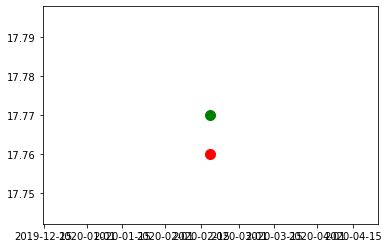

buy time:2020-02-18T18:55:46.755960186Z sell time:2020-02-18T18:55:50.827692441Z
{'rsi': 70.92593383160329, 'macd1': [0.02427377723403623, 0.02393029123626178, 0.02486425187918684, 0.025312634127867994, 0.026970909289911305], 'macd2': [-0.0024618212680422857, -0.0015456815311623018, -0.0004044499195323681, 0.0006461665291048746, 0.001931605866246855], 'macd_signal': [0.024025328913784276, 0.024006321378279776, 0.02417790747846119, 0.02440485280834255, 0.0249180641046563]}
{'rsi': 64.80834227408998, 'macd': [0.014751268380127414, 0.015269696179700532, 0.015475358151061158, 0.016993077113795607, 0.016921259719641313], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005571187394484098, 'too_close': 0, 'macd_signal': [0.015306907305280507, 0.015299465080164512, 0.015334643694343841, 0.015666330378234193, 0.015917316246515618], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001003943473125695}


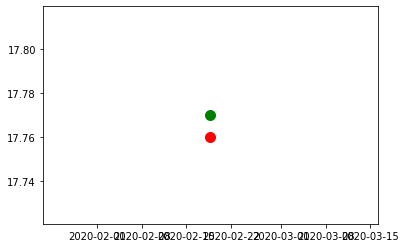

buy time:2020-02-18T18:55:55.98788721Z sell time:2020-02-18T18:56:01.401430158Z
{'rsi': 68.43967218574394, 'macd1': [0.02393029123626178, 0.02486425187918684, 0.025312634127867994, 0.02776863008762831, 0.028578671023765878], 'macd2': [-0.0015456815311623018, -0.0004044499195323681, 0.0006461665291048746, 0.00209154189183991, 0.003258052304506265], 'macd_signal': [0.024006321378279776, 0.02417790747846119, 0.02440485280834255, 0.0250776082641997, 0.025777820816112938]}
{'rsi': 64.77362698328201, 'macd': [0.014751268380127414, 0.015269696179700532, 0.015475358151061158, 0.016993077113795607, 0.016916064914447304], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005627462014630282, 'too_close': 1, 'macd_signal': [0.015306907305280507, 0.015299465080164512, 0.015334643694343841, 0.015666330378234193, 0.015916277285476815], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009997876289704888}


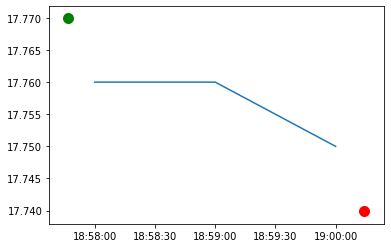

buy time:2020-02-18T18:57:46.897156909Z sell time:2020-02-18T19:00:14.364669061Z
{'rsi': 67.81691046720961, 'macd1': [0.025312634127867994, 0.02776863008762831, 0.02778095022604532, 0.027896802753566874, 0.028491310542896997], 'macd2': [0.0006461665291048746, 0.00209154189183991, 0.0030981162789167627, 0.004104008002048687, 0.005187630882062422], 'macd_signal': [0.02440485280834255, 0.0250776082641997, 0.025618276656568826, 0.026073981875968436, 0.02655744760935415]}
{'rsi': 56.434905629008995, 'macd': [0.01691169092905298, 0.017223715214083057, 0.01643277679703914, 0.015603048461720448, 0.013974649129501415], 'scalp': 0, 'bail_out': 0, 'movement': -0.0014068655036577704, 'too_close': 1, 'macd_signal': [0.01611536001419205, 0.01633703105417025, 0.016356180202744028, 0.016205553854539312, 0.015759372909531732], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0017847237800303166}


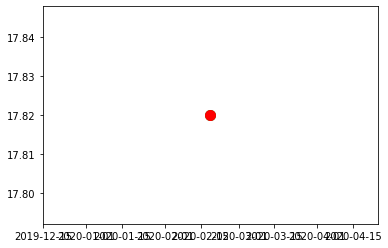

buy time:2020-02-18T19:09:15.853605343Z sell time:2020-02-18T19:09:22.069151577Z
{'rsi': 71.80472511564699, 'macd1': [0.014689118792034606, 0.015422932880554185, 0.018215260922776366, 0.020993121800039205, 0.02412685186855157], 'macd2': [0.008283784117690374, 0.008840287598818719, 0.009817957874581396, 0.010861679375196331, 0.012044468841573064], 'macd_signal': [0.020512466302263516, 0.01949455961792165, 0.019238699878892592, 0.019589584263121913, 0.020497037784207844]}
{'rsi': 71.02650038188654, 'macd': [0.007946453903617368, 0.008437836776078456, 0.010269591783501397, 0.012083042545341982, 0.0138586789500863], 'scalp': 0, 'bail_out': 0, 'movement': -0.0002805049088358488, 'too_close': 0, 'macd_signal': [0.011880622798072784, 0.011192065593673918, 0.011007570831639415, 0.011222665174379929, 0.011749867929521204], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002108811020565097}


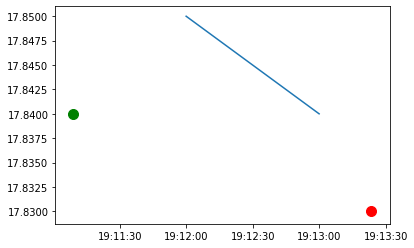

buy time:2020-02-18T19:11:08.871187877Z sell time:2020-02-18T19:13:23.392424962Z
{'rsi': 73.98982535399202, 'macd1': [0.018215260922776366, 0.020993121800039205, 0.024661324803027185, 0.02791634054835157, 0.030148431624620997], 'macd2': [0.009817957874581396, 0.010861679375196331, 0.012151625978717107, 0.013451730189352418, 0.014626353487194876], 'macd_signal': [0.019238699878892592, 0.019589584263121913, 0.020603932371102966, 0.02206641400655269, 0.02368281753016635]}
{'rsi': 70.21680243365165, 'macd': [0.014466471157877692, 0.01656698084091701, 0.017988586037560594, 0.0193821928656277, 0.019593026850280637], 'scalp': 0, 'bail_out': 0, 'movement': -0.00011210762331832351, 'too_close': 0, 'macd_signal': [0.01187142637107948, 0.012810537265046986, 0.013846147019549709, 0.014953356188765306, 0.015881290321068373], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0037117365292122645}


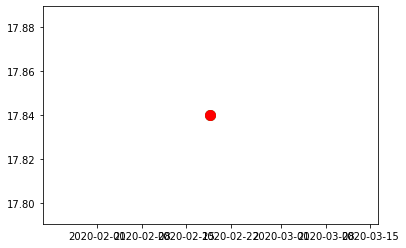

buy time:2020-02-18T19:13:35.125286884Z sell time:2020-02-18T19:14:18.309431136Z
{'rsi': 71.04625125028123, 'macd1': [0.024661324803027185, 0.02791634054835157, 0.030148431624620997, 0.032351369856748136, 0.032910921236826596], 'macd2': [0.012151625978717107, 0.013451730189352418, 0.014626353487194876, 0.015843587711259488, 0.016778206503236248], 'macd_signal': [0.020603932371102966, 0.02206641400655269, 0.02368281753016635, 0.025416527995482708, 0.026915406643751486]}
{'rsi': 71.04625125028123, 'macd': [0.01656698084091701, 0.017988586037560594, 0.0193821928656277, 0.019696922954175022, 0.01968636298480675], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.012810537265046986, 0.013846147019549709, 0.014953356188765306, 0.01590206954184725, 0.01665892823043915], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0030274347543675986}


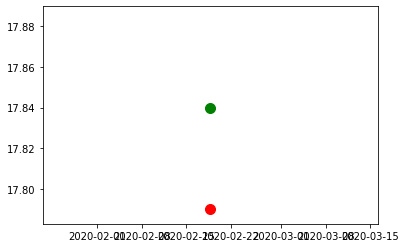

buy time:2020-02-18T19:15:19.880250493Z sell time:2020-02-18T19:16:48.776416622Z
{'rsi': 71.72956370812011, 'macd1': [0.02791634054835157, 0.030148431624620997, 0.032351369856748136, 0.032910921236826596, 0.03327739686239539], 'macd2': [0.013451730189352418, 0.014626353487194876, 0.015843587711259488, 0.016778206503236248, 0.017672026980772415], 'macd_signal': [0.02206641400655269, 0.02368281753016635, 0.025416527995482708, 0.026915406643751486, 0.028187804687480267]}
{'rsi': 52.15690435354654, 'macd': [0.0193821928656277, 0.019696922954175022, 0.019883765582211055, 0.018534762882211453, 0.015684439182443555], 'scalp': 0, 'bail_out': 0, 'movement': -0.0022434099831743774, 'too_close': 1, 'macd_signal': [0.014953356188765306, 0.01590206954184725, 0.01669840874992001, 0.0170656795763783, 0.01678943149759135], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0011049923151477958}


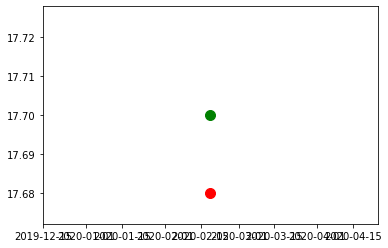

buy time:2020-02-18T20:35:11.625146632Z sell time:2020-02-18T20:35:44.401672162Z
{'rsi': 59.53763565862976, 'macd1': [0.015284400143972476, 0.015685838501173777, 0.016818750735435373, 0.019508995355035808, 0.019535722674039135], 'macd2': [-0.0017029890569126849, -0.0010226770231476223, -0.0001952125298316787, 0.0009662335514342146, 0.0016606048024492281], 'macd_signal': [0.011668924312838284, 0.012472307150505383, 0.01334159586749138, 0.014575075765000266, 0.01556720514680804]}
{'rsi': 51.59064531920171, 'macd': [0.010655601248267033, 0.012334520274222882, 0.01227219068049834, 0.012235671637586876, 0.010495063660808768], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015022562081021282, 'too_close': 1, 'macd_signal': [0.008676256150307066, 0.009407908975090229, 0.009980765316171852, 0.010431746580454856, 0.010444409996525638], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 5.06536642831297e-05}

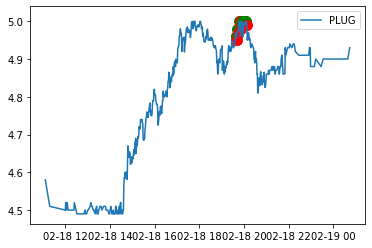

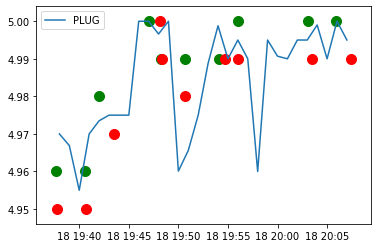

Delta = -0.0699999999999994


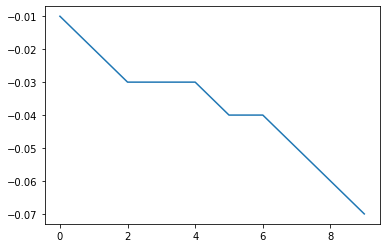

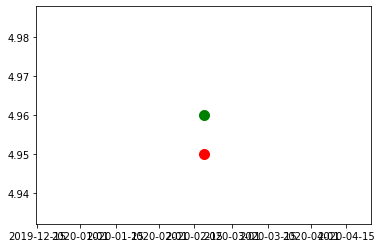

buy time:2020-02-18T19:37:41.694880254Z sell time:2020-02-18T19:37:44.290249922Z
{'rsi': 66.65130998244851, 'macd1': [0.008616033712486981, 0.008429819678561934, 0.008187859171314926, 0.0089420170739416, 0.01038824315635356], 'macd2': [-0.0016179727410898792, -0.0013011284055126637, -0.0010075405087572875, -0.0005279019991730749, 0.00010614830812372134], 'macd_signal': [0.00793157397021954, 0.008031223111888018, 0.0080625503237734, 0.00823844367380704, 0.008668403570316344]}
{'rsi': 63.22913539321481, 'macd': [0.005545548908450826, 0.005376104530384396, 0.005174250410716397, 0.00562508810434359, 0.006007233214904595], 'scalp': 0, 'bail_out': 0, 'movement': -0.0020161290322580215, 'too_close': 0, 'macd_signal': [0.005329786747036614, 0.005339050303706171, 0.005306090325108216, 0.005369889880955291, 0.005497358547745151], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0005098746671594436}


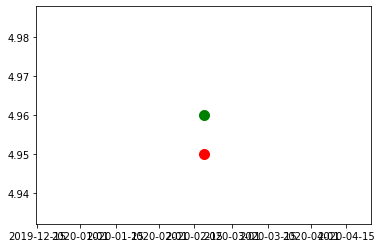

buy time:2020-02-18T19:40:33.582989854Z sell time:2020-02-18T19:40:39.724686328Z
{'rsi': 68.44947490978332, 'macd1': [0.0089420170739416, 0.011002488170598568, 0.012674908680279984, 0.01359347279834644, 0.014397550408816073], 'macd2': [-0.0005279019991730749, 0.00022929904782742483, 0.000962366785914881, 0.001585693214622097, 0.0022046181804746823], 'macd_signal': [0.00823844367380704, 0.008791252573165344, 0.009567983794588272, 0.010373081595339905, 0.01117797535803514]}
{'rsi': 62.51463045885194, 'macd': [0.00562508810434359, 0.006926713734386247, 0.007970490670335728, 0.008519271520811778, 0.008436253072860112], 'scalp': 0, 'bail_out': 0, 'movement': -0.002152960824161438, 'too_close': 0, 'macd_signal': [0.005369889880955291, 0.005681254651641482, 0.006139101855380332, 0.006615135788466621, 0.00697935924534532], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0014568938275147918}


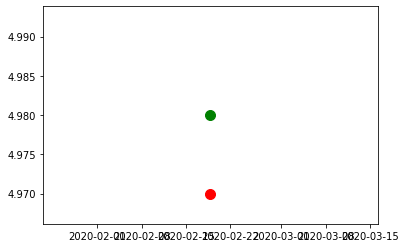

buy time:2020-02-18T19:42:02.563812537Z sell time:2020-02-18T19:43:28.272567494Z
{'rsi': 68.20350079242448, 'macd1': [0.012674908680279984, 0.01359347279834644, 0.013208946420212975, 0.013953731207484665, 0.015175955970075705], 'macd2': [0.000962366785914881, 0.001585693214622097, 0.0019663135023453293, 0.0025532555367488996, 0.003249113433196449], 'macd_signal': [0.009567983794588272, 0.010373081595339905, 0.010940254560314519, 0.011542949889748548, 0.01226955110581398]}
{'rsi': 66.82893402620094, 'macd': [0.008519271520811778, 0.008218071254678883, 0.00865586232970994, 0.009066402617659897, 0.009346480730118678], 'scalp': 0, 'bail_out': 0, 'movement': -0.001004016064257185, 'too_close': 0, 'macd_signal': [0.006615135788466621, 0.006935722881709074, 0.007279750771309247, 0.007637081140579377, 0.007978961058487237], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0013675196716314408}


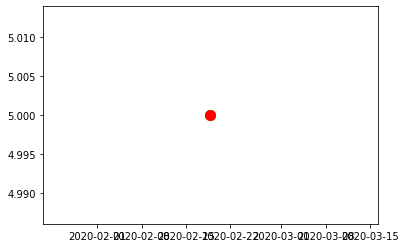

buy time:2020-02-18T19:47:02.227624777Z sell time:2020-02-18T19:48:06.732933271Z
{'rsi': 74.43662809974568, 'macd1': [0.015161396047893128, 0.015383455961854864, 0.015382124487474336, 0.017200088437888006, 0.018428406764418703], 'macd2': [0.0037086816391083133, 0.004221212639476057, 0.004686006314521762, 0.005505976814730751, 0.006251569863000128], 'macd_signal': [0.012764957131266871, 0.01328865689738447, 0.013707350415402443, 0.014405898019899556, 0.015210399768803385]}
{'rsi': 74.43662809974568, 'macd': [0.009346480730118678, 0.009443340548526358, 0.009396174945356606, 0.010536095579960048, 0.011287513014975659], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.007978961058487237, 0.008271836956495061, 0.00849670455426737, 0.008904582759405906, 0.009381168810519857], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001906344204455802}


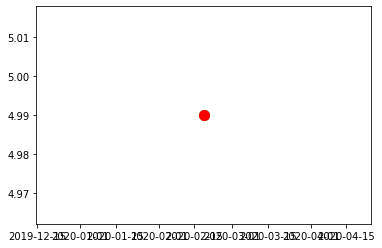

buy time:2020-02-18T19:48:13.332822258Z sell time:2020-02-18T19:48:21.203870935Z
{'rsi': 73.49824285018579, 'macd1': [0.015383455961854864, 0.015382124487474336, 0.017200088437888006, 0.018428406764418703, 0.01908502759843156], 'macd2': [0.004221212639476057, 0.004686006314521762, 0.005505976814730751, 0.006251569863000128, 0.006908348481399429], 'macd_signal': [0.01328865689738447, 0.013707350415402443, 0.014405898019899556, 0.015210399768803385, 0.01598532533472902]}
{'rsi': 67.27850291845793, 'macd': [0.009443340548526358, 0.009396174945356606, 0.010536095579960048, 0.011287513014975659, 0.011206961496611711], 'scalp': 0, 'bail_out': 0, 'movement': -0.00176042250140032, 'too_close': 0, 'macd_signal': [0.008271836956495061, 0.00849670455426737, 0.008904582759405906, 0.009381168810519857, 0.009746327347738228], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0014606341488734836}


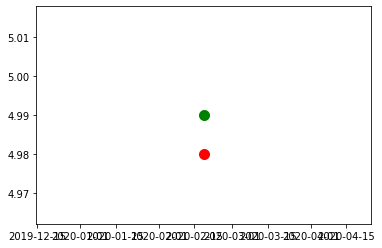

buy time:2020-02-18T19:50:37.982676227Z sell time:2020-02-18T19:50:40.267006345Z
{'rsi': 70.58901857857573, 'macd1': [0.015382124487474336, 0.017200088437888006, 0.018428406764418703, 0.01890952902293197, 0.018943348125494808], 'macd2': [0.004686006314521762, 0.005505976814730751, 0.006251569863000128, 0.006873162555769419, 0.007408465289011623], 'macd_signal': [0.013707350415402443, 0.014405898019899556, 0.015210399768803385, 0.015950225619629103, 0.016548850120802244]}
{'rsi': 59.25655279567593, 'macd': [0.010536095579960048, 0.011287513014975659, 0.011549818639469578, 0.011780838364535917, 0.010768894794918715], 'scalp': 0, 'bail_out': 0, 'movement': -0.003003003003002939, 'too_close': 1, 'macd_signal': [0.008904582759405906, 0.009381168810519857, 0.0098148987763098, 0.010208086693955024, 0.010320248314147762], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000448646480770953}


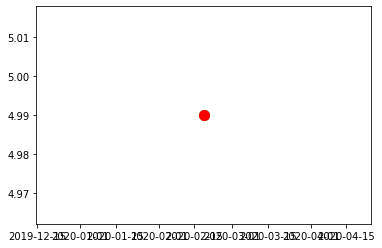

buy time:2020-02-18T19:54:06.241582049Z sell time:2020-02-18T19:54:41.44708013Z
{'rsi': 60.94247499985024, 'macd1': [0.01627787242405354, 0.014130282916134718, 0.013036527228551087, 0.013131886422283578, 0.013152673409711824], 'macd2': [0.0074043806242460875, 0.007403172014265991, 0.0075405595793913704, 0.007875612177965507, 0.00819046766801268], 'macd_signal': [0.01655847224527015, 0.01607283437944306, 0.015465572949264667, 0.01499883564386845, 0.014629603197037124]}
{'rsi': 60.94247499985024, 'macd': [0.009735128561151996, 0.008300353018761086, 0.007562860998471699, 0.00760685603462985, 0.0076046852052122915], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.010113495067394418, 0.009750866657667752, 0.009313265525828542, 0.008971983627588803, 0.0086985239431135], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0010938387379012086}


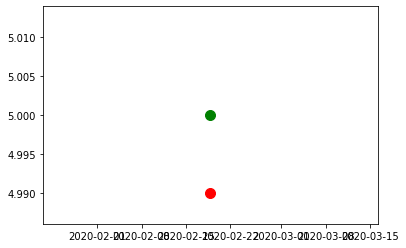

buy time:2020-02-18T19:55:58.328476522Z sell time:2020-02-18T19:56:01.717550172Z
{'rsi': 63.9501540159658, 'macd1': [0.014130282916134718, 0.013036527228551087, 0.013131886422283578, 0.013854667711705737, 0.014358787893313796], 'macd2': [0.007403172014265991, 0.0075405595793913704, 0.007875612177965507, 0.008331211370531832, 0.00875624491575877], 'macd_signal': [0.01607283437944306, 0.015465572949264667, 0.01499883564386845, 0.014770002057435908, 0.014687759224611486]}
{'rsi': 60.891775680651584, 'macd': [0.007562860998471699, 0.00760685603462985, 0.008061828062355225, 0.007854509797435405, 0.007850696736492857], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009999999999999788, 'too_close': 0, 'macd_signal': [0.009313265525828542, 0.008971983627588803, 0.008789952514542088, 0.008602863971120752, 0.008452430524195174], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006017337877023167}


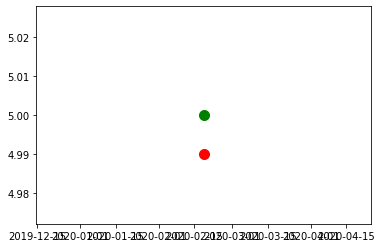

buy time:2020-02-18T20:03:06.639875831Z sell time:2020-02-18T20:03:30.266533582Z
{'rsi': 58.66159311623929, 'macd1': [0.010419397606042047, 0.010234229560390773, 0.009916685028209749, 0.009953746320339185, 0.01026821033758818], 'macd2': [0.009031669748643445, 0.009180919442592028, 0.009292354815644721, 0.009459985113178249, 0.009679048437517324], 'macd_signal': [0.012703593792487228, 0.012209720946067936, 0.0117511137624963, 0.011391640274064876, 0.011166954286769537]}
{'rsi': 57.1083437107193, 'macd': [0.005780813185666034, 0.0056651702051615516, 0.005465121516389004, 0.005498004076873286, 0.0054522242009280575], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009999999999999788, 'too_close': 0, 'macd_signal': [0.007329411969871176, 0.006996563616929251, 0.0066902751968212016, 0.006451820972831619, 0.006251901618450907], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007996774175228491}


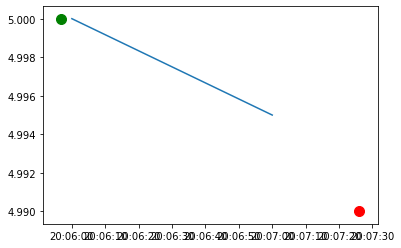

buy time:2020-02-18T20:05:56.847006605Z sell time:2020-02-18T20:07:25.949379982Z
{'rsi': 58.80107718984227, 'macd1': [0.009916685028209749, 0.009953746320339185, 0.009869349938727012, 0.010009844512236299, 0.010085618385929251], 'macd2': [0.009292354815644721, 0.009459985113178249, 0.009599080424722573, 0.009775674583124783, 0.009938505634765171], 'macd_signal': [0.0117511137624963, 0.011391640274064876, 0.011087182206997304, 0.010871714668045103, 0.010714495411621932]}
{'rsi': 55.55362248952959, 'macd': [0.0054522242009280575, 0.005553535671607435, 0.0050928233673106504, 0.005187166722828707, 0.00493357496449498], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009999999999999788, 'too_close': 1, 'macd_signal': [0.006251901618450907, 0.006112228429082212, 0.0059083474167279, 0.005764111277948061, 0.005598004015257445], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006644290507624648}
KDMN 

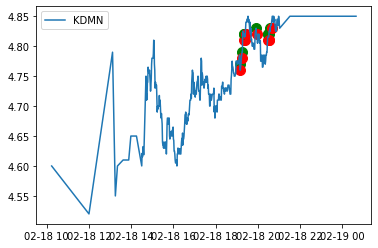

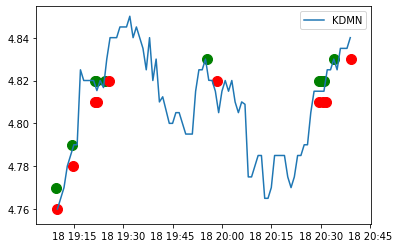

Delta = -0.08000000000000274


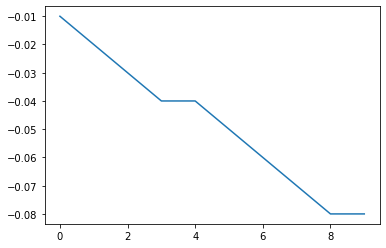

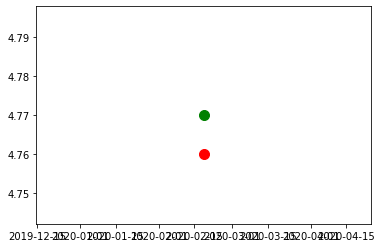

buy time:2020-02-18T19:09:42.962020934Z sell time:2020-02-18T19:09:51.929038154Z
{'rsi': 70.24473327453997, 'macd1': [0.010076214920474946, 0.009665862767452182, 0.009537343413745347, 0.010125684735898588, 0.010471243495580929], 'macd2': [0.00702536930046449, 0.007138674683141666, 0.007292277636683053, 0.007581870313833505, 0.007836178698027219], 'macd_signal': [0.009383671655216428, 0.00944010987766358, 0.009459556584879934, 0.009592782215083664, 0.009768474471183116]}
{'rsi': 53.99509146717021, 'macd': [0.006009829276501399, 0.005724452397532609, 0.0056251398633033745, 0.005994180228016788, 0.00525844310664958], 'scalp': 0, 'bail_out': 0, 'movement': -0.0038035527690700554, 'too_close': 1, 'macd_signal': [0.005635299712375193, 0.005653130249406677, 0.0056475321721860166, 0.005716861783352171, 0.005625178048011653], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000366734941362073}


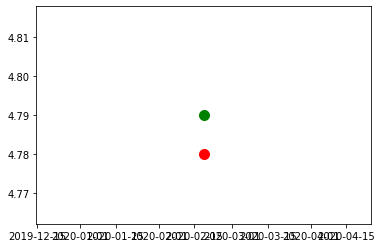

buy time:2020-02-18T19:14:23.502895043Z sell time:2020-02-18T19:14:51.527475347Z
{'rsi': 65.45609095968469, 'macd1': [0.0075074025641805875, 0.0066361016891587354, 0.006276693861843263, 0.00672129805569277, 0.007790759483286891], 'macd2': [0.007390436964646696, 0.007316294545742785, 0.007316347770819576, 0.007464631289339607, 0.007749054260534294], 'macd_signal': [0.009083963793486357, 0.008594391372620833, 0.00813085187046532, 0.00784894110751081, 0.007837304782666026]}
{'rsi': 63.34899853187391, 'macd': [0.004263603231472679, 0.003692772117938503, 0.003459750833133768, 0.0037527244964925544, 0.0041920192407136625], 'scalp': 0, 'bail_out': 0, 'movement': -0.001043841336116888, 'too_close': 0, 'macd_signal': [0.005352863084703858, 0.005020844891350787, 0.004708626079707383, 0.004517445763064417, 0.0044523604585942666], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00026034121788060405}


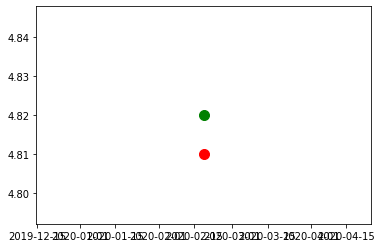

buy time:2020-02-18T19:21:27.132881171Z sell time:2020-02-18T19:21:31.063716069Z
{'rsi': 73.31659614148667, 'macd1': [0.008796246733622226, 0.011930162956861778, 0.013850693753338028, 0.015197540459941372, 0.016079570894346418], 'macd2': [0.008147570037067453, 0.008899184551801831, 0.009496492932528078, 0.01003084743565541, 0.010506427732318357], 'macd_signal': [0.008041177633932082, 0.008818974698518021, 0.009825318509482022, 0.010899762899573891, 0.011935724498528397]}
{'rsi': 65.34945351727582, 'macd': [0.007141198085828471, 0.008375536059286759, 0.009228584661211237, 0.00977344610866826, 0.009551605079302306], 'scalp': 0, 'bail_out': 0, 'movement': -0.002074688796680638, 'too_close': 0, 'macd_signal': [0.005131284643403826, 0.005780134926580412, 0.006469824873506577, 0.007130549120538914, 0.007614760312291592], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0019368447670107137}


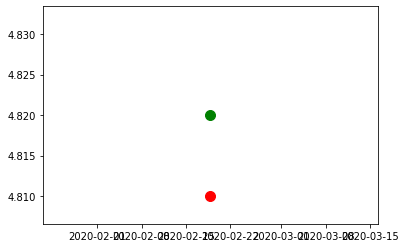

buy time:2020-02-18T19:21:46.660978917Z sell time:2020-02-18T19:22:09.747246706Z
{'rsi': 73.31659614148666, 'macd1': [0.011930162956861778, 0.013850693753338028, 0.015197540459941372, 0.016079570894346418, 0.0165873774068368], 'macd2': [0.008899184551801831, 0.009496492932528078, 0.01003084743565541, 0.010506427732318357, 0.010927173254786204], 'macd_signal': [0.008818974698518021, 0.009825318509482022, 0.010899762899573891, 0.011935724498528397, 0.012866055080190078]}
{'rsi': 68.80007320898433, 'macd': [0.008375536059286759, 0.009228584661211237, 0.00977344610866826, 0.010071085598782226, 0.009912478894991139], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010373443983402268, 'too_close': 0, 'macd_signal': [0.005780134926580412, 0.006469824873506577, 0.007130549120538914, 0.0077186564161875765, 0.00815742091194829], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0017550579830428494}


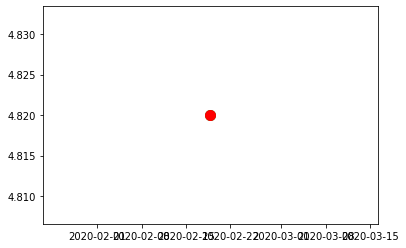

buy time:2020-02-18T19:24:30.931549997Z sell time:2020-02-18T19:25:33.062565793Z
{'rsi': 72.71919488510107, 'macd1': [0.016079570894346418, 0.0165873774068368, 0.01642127279517691, 0.016478925617435358, 0.016735161582253966], 'macd2': [0.010506427732318357, 0.010927173254786204, 0.011221626175289323, 0.011549754789994537, 0.011913139405458573], 'macd_signal': [0.011935724498528397, 0.012866055080190078, 0.013577098623187445, 0.014157464022037028, 0.014673003534080416]}
{'rsi': 70.87812653337326, 'macd': [0.00977344610866826, 0.010071085598782226, 0.00992806331057583, 0.009931837328718274, 0.009805793221703496], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010362694300517913, 'too_close': 0, 'macd_signal': [0.007130549120538914, 0.0077186564161875765, 0.008160537795065228, 0.008514797701795838, 0.00877299680577737], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001032796415926126}


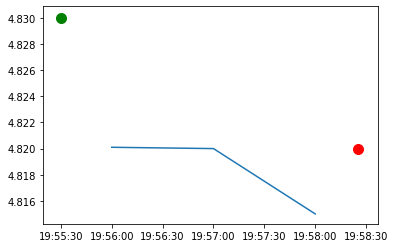

buy time:2020-02-18T19:55:30.225634977Z sell time:2020-02-18T19:58:25.251306576Z
{'rsi': 59.37489005330436, 'macd1': [-0.0055244488189947205, -0.004379954505364658, -0.002635636117132023, -0.0012389691620535714, 0.00026826528038181863], 'macd2': [0.009202641926359334, 0.00902051547650462, 0.008998462288571929, 0.00896378086730465, 0.008997504548310609], 'macd_signal': [-0.0009528421578926893, -0.0016382646273870832, -0.0018377389253360712, -0.0017179849726795713, -0.0013207349220672932]}
{'rsi': 52.946387459316156, 'macd': [-0.0012666185254017748, -0.0002389420757484828, 5.066219769211955e-05, 0.00027047510949529396, 0.00043824523415292305], 'scalp': 0, 'bail_out': 0, 'movement': -0.0020703933747411567, 'too_close': 0, 'macd_signal': [-0.0018110710733038314, -0.0014966452737927617, -0.0011871837794957855, -0.0008956520016975696, -0.0006288725545274711], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_sign

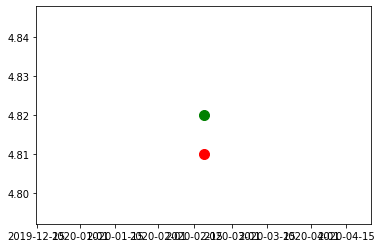

buy time:2020-02-18T20:29:29.069772678Z sell time:2020-02-18T20:29:34.753716157Z
{'rsi': 66.05960253032771, 'macd1': [-0.005604532641196869, -0.004610503005918254, -0.002582582317241844, -0.00016660363161591363, 0.0021270161777113827], 'macd2': [-0.0010203311927838854, -0.0010286996540154192, -0.000794849606304382, -0.00041849280574179915, 8.404822933627543e-06], 'macd_signal': [-0.0077009979323645564, -0.007082898947075296, -0.006182835621108605, -0.004979589223210066, -0.0035582681430257764]}
{'rsi': 64.01126077325925, 'macd': [-0.0031819881692829455, -0.0025283988893729514, -0.001207051412957405, 0.00035772650909215997, 0.0015723881819997843], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010373443983402268, 'too_close': 0, 'macd_signal': [-0.004650141466915744, -0.004225792951407186, -0.0036220446437172293, -0.0028260904131553514, -0.0019463946941243242], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_s

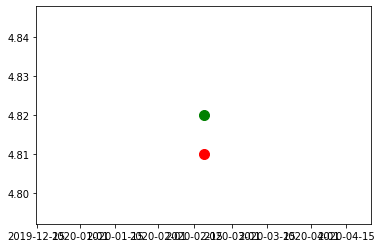

buy time:2020-02-18T20:30:08.546825386Z sell time:2020-02-18T20:30:38.608234217Z
{'rsi': 66.20755155062103, 'macd1': [-0.004610503005918254, -0.002582582317241844, -0.00016660363161591363, 0.0017281557788502155, 0.00359182020837423], 'macd2': [-0.0010286996540154192, -0.000794849606304382, -0.00041849280574179915, -7.156318986201171e-05, 0.0003277056221735464], 'macd_signal': [-0.007082898947075296, -0.006182835621108605, -0.004979589223210066, -0.0036380402227980096, -0.002192068136563562]}
{'rsi': 64.01126077325925, 'macd': [-0.0025283988893729514, -0.001207051412957405, 0.00035772650909215997, 0.0015723881819997843, 0.002498457171512314], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010373443983402268, 'too_close': 0, 'macd_signal': [-0.004225792951407186, -0.0036220446437172293, -0.0028260904131553514, -0.0019463946941243242, -0.0010574243209969963], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signa

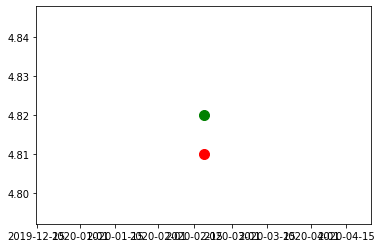

buy time:2020-02-18T20:31:06.679992728Z sell time:2020-02-18T20:31:42.07817723Z
{'rsi': 66.36544551626037, 'macd1': [-0.002582582317241844, -0.00016660363161591363, 0.0017281557788502155, 0.003192959809513951, 0.004703071687560012], 'macd2': [-0.000794849606304382, -0.00041849280574179915, -7.156318986201171e-05, 0.0002477376093787953, 0.0006210763493292859], 'macd_signal': [-0.006182835621108605, -0.004979589223210066, -0.0036380402227980096, -0.0022718402163356176, -0.0008768578355564916]}
{'rsi': 64.01126077325925, 'macd': [-0.001207051412957405, 0.00035772650909215997, 0.0015723881819997843, 0.002498457171512314, 0.003187621875398783], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010373443983402268, 'too_close': 0, 'macd_signal': [-0.0036220446437172293, -0.0028260904131553514, -0.0019463946941243242, -0.0010574243209969963, -0.0002084150817178405], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal

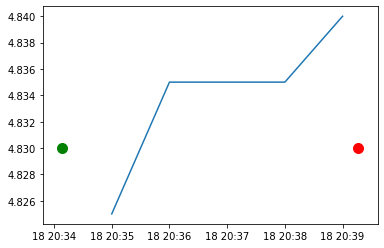

buy time:2020-02-18T20:34:07.999636029Z sell time:2020-02-18T20:39:15.605538437Z
{'rsi': 70.93401794472993, 'macd1': [0.003192959809513951, 0.004304211288699733, 0.005923519868817451, 0.00712470442738411, 0.00838347062651934], 'macd2': [0.0002477376093787953, 0.0005411083365345348, 0.0009700893880495443, 0.0013632141549351218, 0.001802689257687895], 'macd_signal': [-0.0022718402163356176, -0.0009566299153285474, 0.0004194000415006524, 0.001760460918677344, 0.003085062860245743]}
{'rsi': 65.05664517717987, 'macd': [0.005974200954444342, 0.00662310806368982, 0.007042735576560766, 0.0072782539557252335, 0.007107511732272975], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0030854039698908157, 0.0037929447886506165, 0.004442902946232646, 0.005009973148131164, 0.005429480864959526], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001678030867313449}
MIK analysis f

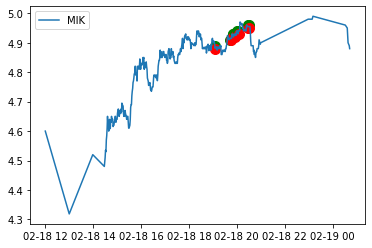

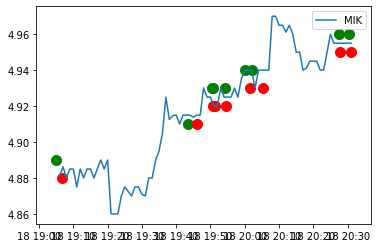

Delta = -0.08000000000000007


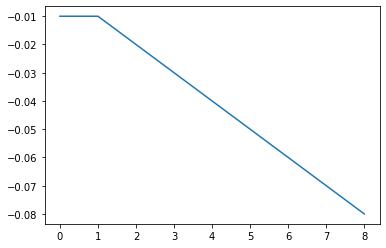

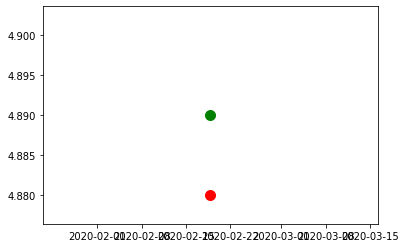

buy time:2020-02-18T19:05:04.511574951Z sell time:2020-02-18T19:06:38.661035555Z
{'rsi': 54.234655391841954, 'macd1': [0.0018256765320252555, 0.0024550678793850977, 0.0025213423779781863, 0.002943393995075816, 0.003240518264937542], 'macd2': [0.0012612403479339562, 0.0013898822889570894, 0.0014260460543056297, 0.0015370051266163642, 0.0016366327975010364], 'macd_signal': [-0.0021938053262939307, -0.0012640306851581249, -0.0005069560725308626, 0.0001831139409904731, 0.000794594805779887]}
{'rsi': 45.42272989003289, 'macd': [0.0018936020267821263, 0.0021435619830771913, 0.0020507572479422365, 0.0014323281394217346, 0.0006720934036996695], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010224948875255406, 'too_close': 1, 'macd_signal': [-6.108023337896321e-05, 0.0003798482099122677, 0.0007140300175182615, 0.0008576896418989561, 0.0008205703942590987], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd':

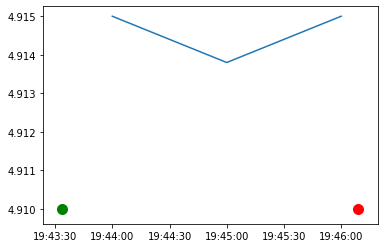

buy time:2020-02-18T19:43:33.51529229Z sell time:2020-02-18T19:46:08.690431702Z
{'rsi': 62.63033895288375, 'macd1': [0.007563413742950331, 0.008443491010712734, 0.008637927718951666, 0.009090686647412305, 0.009341814734981746], 'macd2': [5.7850340581921955e-05, 0.000483728498280378, 0.0007948083570843423, 0.0011597086056571726, 0.0014935737146304362], 'macd_signal': [0.0020895531400358953, 0.0033603407141712628, 0.004415858115127343, 0.0053508238215843355, 0.006149022004263817]}
{'rsi': 62.2680274375117, 'macd': [0.0059624119397483355, 0.006077817874295732, 0.006088811876874267, 0.005955965490872295, 0.005837436287613684], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.0036475654656256034, 0.004133615947359629, 0.004524655133262557, 0.004810917204784505, 0.005016221021350341], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0008212152662633431}


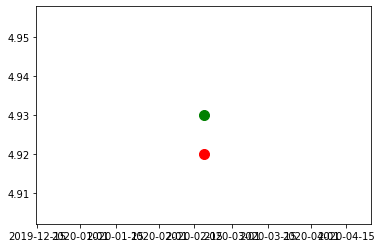

buy time:2020-02-18T19:50:33.788919601Z sell time:2020-02-18T19:50:44.729048108Z
{'rsi': 67.52231620989315, 'macd1': [0.00918559476337677, 0.008991567208642692, 0.009933664512383977, 0.010159710382695586, 0.010619892071598969], 'macd2': [0.002310269399960596, 0.0025398771355646943, 0.0029869654566692105, 0.0033135557665593396, 0.003688697741766056], 'macd_signal': [0.0076806697858921216, 0.007942849270442236, 0.008341012318830585, 0.008704751931603586, 0.009087779959602662]}
{'rsi': 65.46210953137704, 'macd': [0.005837436287613684, 0.005669265008611646, 0.0062438164144724695, 0.0063506900240453135, 0.006382660498725379], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008924949290059869, 'too_close': 1, 'macd_signal': [0.005016221021350341, 0.0051468298188026024, 0.005366227137936576, 0.005563119715158323, 0.0057270278718717345], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00065563262685364

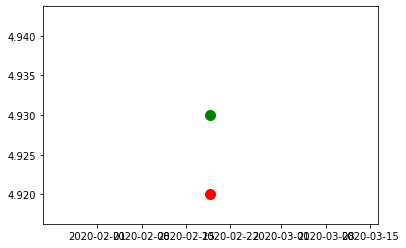

buy time:2020-02-18T19:50:46.264909257Z sell time:2020-02-18T19:51:17.321505134Z
{'rsi': 67.52231620989315, 'macd1': [0.00918559476337677, 0.008991567208642692, 0.009933664512383977, 0.010159710382695586, 0.010619892071598969], 'macd2': [0.002310269399960596, 0.0025398771355646943, 0.0029869654566692105, 0.0033135557665593396, 0.003688697741766056], 'macd_signal': [0.0076806697858921216, 0.007942849270442236, 0.008341012318830585, 0.008704751931603586, 0.009087779959602662]}
{'rsi': 60.781867909481804, 'macd': [0.005669265008611646, 0.0062438164144724695, 0.0063506900240453135, 0.0063514916675568855, 0.0060306683811042205], 'scalp': 0, 'bail_out': 0, 'movement': -0.0019472616632859698, 'too_close': 1, 'macd_signal': [0.0051468298188026024, 0.005366227137936576, 0.005563119715158323, 0.005720794105638036, 0.005782768960731273], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.000247899420372

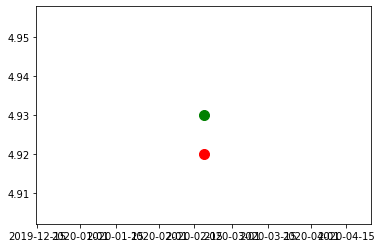

buy time:2020-02-18T19:54:19.225687674Z sell time:2020-02-18T19:54:23.746431408Z
{'rsi': 66.13340185048712, 'macd1': [0.010221031672737801, 0.009753736026215876, 0.00927646751653377, 0.009594545265169785, 0.00973441193130764], 'macd2': [0.003608729728971305, 0.0037945595444819347, 0.003959460051204289, 0.004264777214644688, 0.00453885785607433], 'macd_signal': [0.00900800787983043, 0.009157153509107518, 0.009181016310592769, 0.009263722101508172, 0.009357860067468065]}
{'rsi': 61.369561238005744, 'macd': [0.0063514916675568855, 0.006009889160324633, 0.005665654879879689, 0.0058433209616124415, 0.005646134519305512], 'scalp': 0, 'bail_out': 0, 'movement': -0.001014198782961439, 'too_close': 1, 'macd_signal': [0.005720794105638036, 0.005778613116575355, 0.005756021469236222, 0.005773481367711466, 0.0057480119980302755], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00010187747872476317}


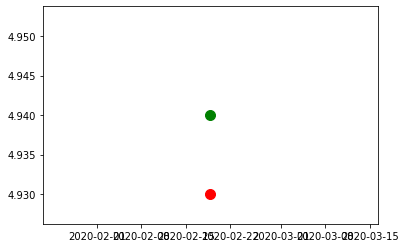

buy time:2020-02-18T20:00:03.189493074Z sell time:2020-02-18T20:01:27.781691157Z
{'rsi': 67.9560848407771, 'macd1': [0.008681053236601066, 0.00871053238832964, 0.008235502864603284, 0.008567197649551161, 0.009128300997877759], 'macd2': [0.004780689968741925, 0.004991331080677952, 0.005097176692129501, 0.005346341844141733, 0.0056469990402252535], 'macd_signal': [0.009118386665547245, 0.009036815810103724, 0.008876553221003636, 0.00881468210671314, 0.008877405884946064]}
{'rsi': 58.55743163174899, 'macd': [0.005171825851041589, 0.004844852248238496, 0.0050466279830896354, 0.005398055465012597, 0.005082309925406037], 'scalp': 0, 'bail_out': 0, 'movement': -0.002024291497975845, 'too_close': 1, 'macd_signal': [0.005498505169646042, 0.0053677745853645325, 0.005303545264909553, 0.005322447304930162, 0.005274419829025337], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00019210990361930025}


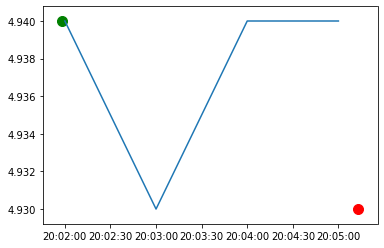

buy time:2020-02-18T20:01:58.387144687Z sell time:2020-02-18T20:05:12.67945053Z
{'rsi': 67.9560848407771, 'macd1': [0.00871053238832964, 0.008235502864603284, 0.008567197649551161, 0.009128300997877759, 0.009463885661120663], 'macd2': [0.004991331080677952, 0.005097176692129501, 0.005346341844141733, 0.0056469990402252535, 0.005914581691974341], 'macd_signal': [0.009036815810103724, 0.008876553221003636, 0.00881468210671314, 0.008877405884946064, 0.008994701840180985]}
{'rsi': 58.88219336171723, 'macd': [0.005601790444886845, 0.005687794449400485, 0.005161462576951159, 0.005203782383135014, 0.004909437006354267], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010121457489880123, 'too_close': 1, 'macd_signal': [0.0053783159329214986, 0.005440211636217296, 0.0053844618243640684, 0.005348325936118258, 0.005260548150165459], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0003511111438111924}


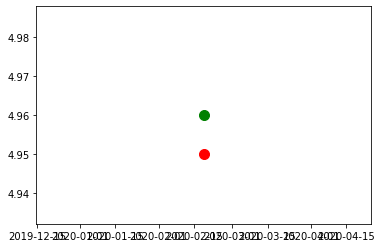

buy time:2020-02-18T20:27:35.67759889Z sell time:2020-02-18T20:27:47.43707893Z
{'rsi': 61.072183155277884, 'macd1': [0.002703355953546094, 0.002841969182799886, 0.003715902975715224, 0.003959402067307494, 0.004503916716648959], 'macd2': [0.007990638583982523, 0.007938358817341395, 0.00803749948974719, 0.008035889209558889, 0.008101523431249369], 'macd_signal': [0.005976574523836151, 0.005349653455628898, 0.005022903359646163, 0.004810203101178429, 0.004748945824272535]}
{'rsi': 57.940769090290324, 'macd': [0.0010551087445280771, 0.0011728779597817152, 0.0017688945176450588, 0.0019506100884782995, 0.0020668740386273754], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010080645161290108, 'too_close': 0, 'macd_signal': [0.003152608088805167, 0.002756662063000477, 0.0025591085539293933, 0.0024374088608391745, 0.002363301896396815], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00029642785776943

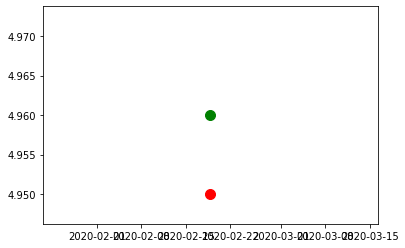

buy time:2020-02-18T20:30:26.633931208Z sell time:2020-02-18T20:31:00.483140261Z
{'rsi': 61.78065033054697, 'macd1': [0.003959402067307494, 0.00410505631778868, 0.0041723916272218275, 0.004177598589003573, 0.004532930555196657], 'macd2': [0.008035889209558889, 0.008021555418454618, 0.007995538515213951, 0.007958814385498059, 0.007992266012840865], 'macd_signal': [0.004810203101178429, 0.004669173744500479, 0.004569817321044748, 0.004491373574636514, 0.004499684970748543]}
{'rsi': 57.94076909029033, 'macd': [0.0019506100884782995, 0.0020668740386273754, 0.0021306268044760657, 0.0021526338063777573, 0.0021418258363476994], 'scalp': 0, 'bail_out': 0, 'movement': -0.0010080645161290108, 'too_close': 0, 'macd_signal': [0.0024374088608391745, 0.002363301896396815, 0.002316766878012665, 0.0022839402636856835, 0.0022555173782180865], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000113691541870

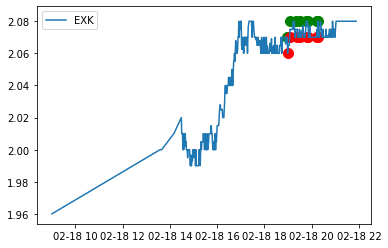

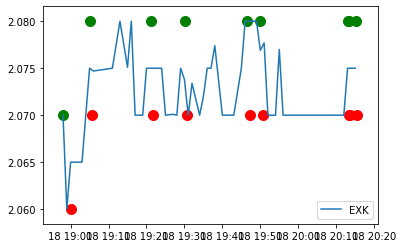

Delta = -0.09000000000000163


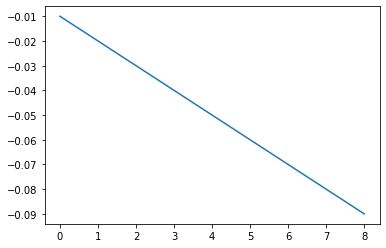

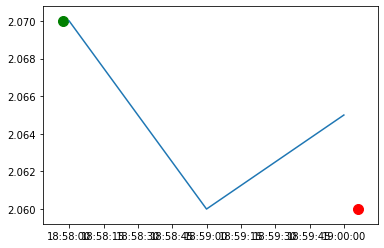

buy time:2020-02-18T18:57:57.104810681Z sell time:2020-02-18T19:00:06.049864319Z
{'rsi': 55.42003973359733, 'macd1': [0.0018827238508292155, 0.0018994618004377628, 0.0015558865552542933, 0.0016040155049794613, 0.0016234439925990607], 'macd2': [0.0008052502210671442, 0.0008510143603008835, 0.0008245846229701925, 0.0008661227420865281, 0.0009029538980716012], 'macd_signal': [0.0013140088448166487, 0.0014310994359408714, 0.0014560568598035559, 0.0014856485888387369, 0.0015132076695908016]}
{'rsi': 48.03238126436769, 'macd': [0.0010093079577626618, 0.0010148979524666757, 0.001006073299606225, 0.0004666505402397547, 0.00030000098047056056], 'scalp': 0, 'bail_out': 0, 'movement': -0.0024154589371980163, 'too_close': 1, 'macd_signal': [0.0009641529771093154, 0.0009743019721807874, 0.000980656237665875, 0.0008778550981806509, 0.0007622842746386328], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0

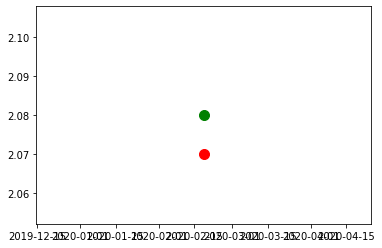

buy time:2020-02-18T19:05:03.637557779Z sell time:2020-02-18T19:05:30.511329856Z
{'rsi': 65.32682074005248, 'macd1': [0.000549665842820346, 0.0003461650665723681, 0.0001827822354201203, 0.0004515531541988693, 0.0014547035531942143], 'macd2': [0.0007614312552446378, 0.0007212227993487197, 0.0006830762386873523, 0.0007268557104835871, 0.0009259077463736887], 'macd_signal': [0.001220302480802168, 0.001045474997956208, 0.0008729364454489903, 0.0007886597871989661, 0.0009218685403980158]}
{'rsi': 60.88153528613015, 'macd': [0.00030000098047056056, 0.00016624806402099068, 5.98659464756679e-05, 0.00023593356986228997, 0.0006298053079576427], 'scalp': 0, 'bail_out': 0, 'movement': -0.0024038461538461024, 'too_close': 0, 'macd_signal': [0.0007622842746386328, 0.0006430770325151044, 0.000526434815307217, 0.00046833456621823164, 0.0005006287145661139], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.

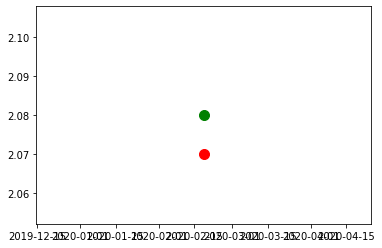

buy time:2020-02-18T19:21:18.998271061Z sell time:2020-02-18T19:21:45.267260322Z
{'rsi': 59.81599783497366, 'macd1': [0.0030191761385385263, 0.0025262904009362153, 0.0021113367273053463, 0.0021610301542063226, 0.0025741970253769786], 'macd2': [0.0014369666873621512, 0.001408439634625669, 0.0013799412312329729, 0.0014314827781616302, 0.001556581206138219], 'macd_signal': [0.0019239543338593634, 0.0020444215472747336, 0.0020578045832808562, 0.0020784496974659496, 0.0021775991630481554]}
{'rsi': 49.55429605103425, 'macd': [0.0018838993502678925, 0.0015537973441572817, 0.0012763958154455857, 0.0013034024707945235, 0.0010529738584588166], 'scalp': 0, 'bail_out': 0, 'movement': -0.004759615384615394, 'too_close': 1, 'macd_signal': [0.0011889019643978609, 0.001261881040349745, 0.0012647839953689132, 0.0012725076904540353, 0.0012286009240549916], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00

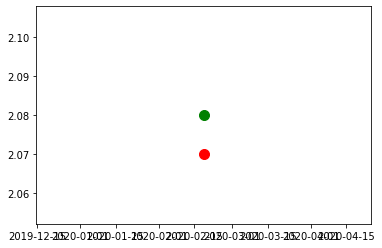

buy time:2020-02-18T19:30:10.863603532Z sell time:2020-02-18T19:30:42.259397561Z
{'rsi': 61.20894799405562, 'macd1': [0.0016114652492604797, 0.0012382171811515796, 0.0009236984134748383, 0.0010656144967655656, 0.0015635189552209994], 'macd2': [0.0015214887466097338, 0.0014688320909752584, 0.0014164377315277754, 0.0014459358634688613, 0.0015507305288600115], 'macd_signal': [0.002007053346430008, 0.0018532861133743223, 0.0016673685733944255, 0.0015470177580686536, 0.0015503179974991226]}
{'rsi': 53.25709293796934, 'macd': [0.0009230887565299106, 0.0006784582351406776, 0.0004738310985370475, 0.0005679679908130453, 0.0005716075433550571], 'scalp': 0, 'bail_out': 0, 'movement': -0.0029807692307693293, 'too_close': 0, 'macd_signal': [0.0011997899883464773, 0.0010955236377053173, 0.0009711851298716634, 0.0008905417020599398, 0.0008267548703189632], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0

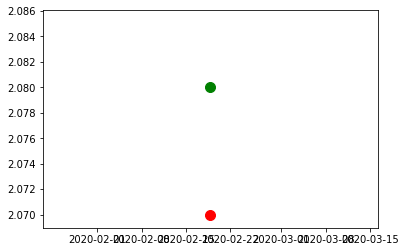

buy time:2020-02-18T19:46:21.534424791Z sell time:2020-02-18T19:47:09.762911579Z
{'rsi': 60.845732797983054, 'macd1': [0.00040857422932072396, 0.0001691218775010661, -2.0410556289096604e-05, 0.00023018836944554977, 0.0008227637287023803], 'macd2': [0.0012752120280623558, 0.0012119623309914118, 0.0011518322221211186, 0.0011746364166835832, 0.0012737063511183422], 'macd_signal': [0.0007755236803558803, 0.0006542433197849175, 0.0005193125445701147, 0.0004614877095452017, 0.0005337429133766374]}
{'rsi': 53.02233880065958, 'macd': [1.6751931076974813e-05, -0.00010190199102755315, 6.670406955366914e-05, 0.0004569593885839218, 0.0004953796451192538], 'scalp': 0, 'bail_out': 0, 'movement': -0.0024038461538461024, 'too_close': 1, 'macd_signal': [0.0003219899360879954, 0.00023721155066488568, 0.00020311005444264237, 0.00025387992127089826, 0.00030217986604056936], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_sig

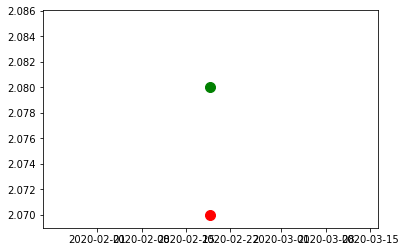

buy time:2020-02-18T19:49:54.828982229Z sell time:2020-02-18T19:50:39.836001176Z
{'rsi': 60.845732797983054, 'macd1': [0.00023018836944554977, 0.0008227637287023803, 0.0012776559477365446, 0.0016194928037003287, 0.0018688579438008723], 'macd2': [0.0011746364166835832, 0.0012737063511183422, 0.0013628167444532657, 0.0014426215217766547, 0.0015137371981195358], 'macd_signal': [0.0004614877095452017, 0.0005337429133766374, 0.0006825255202486188, 0.0008699189769389608, 0.001069706770311343]}
{'rsi': 44.459339503142644, 'macd': [0.0004569593885839218, 0.000755119904859658, 0.000977646022673806, 0.0011383462960008472, 0.0007293030505932663], 'scalp': 0, 'bail_out': 0, 'movement': -0.004807692307692419, 'too_close': 1, 'macd_signal': [0.00025387992127089826, 0.0003541279179886502, 0.0004788315389256813, 0.0006107344903407145, 0.0006344482023912248], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 9

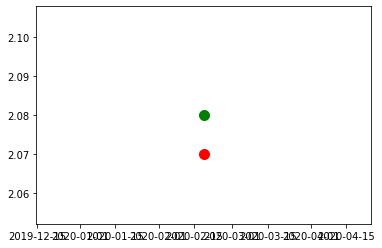

buy time:2020-02-18T20:13:10.352652557Z sell time:2020-02-18T20:13:19.53228506Z
{'rsi': 71.0747310820928, 'macd1': [-0.0009195714904923769, -0.0008851313655999782, -0.0008480613946373339, -0.0008093534527762181, 2.791748119213011e-05], 'macd2': [0.00039643038032988187, 0.0003588014524207317, 0.00032360778231721454, 0.0002907109146494946, 0.0004199158182234264], 'macd_signal': [-0.0008383965500840503, -0.0008477435131872358, -0.0008478070894772555, -0.000840116362137048, -0.0006665095934712124]}
{'rsi': 62.09669160701138, 'macd': [-0.0005947906478618314, -0.0005670231572754147, -0.000538022214516154, -0.0005084367758141362, -0.00021903985246440882], 'scalp': 0, 'bail_out': 0, 'movement': -0.0024038461538461024, 'too_close': 0, 'macd_signal': [-0.0005670273256368201, -0.0005670264919645391, -0.000561225636474862, -0.0005506678643427169, -0.00048434226196705527], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_

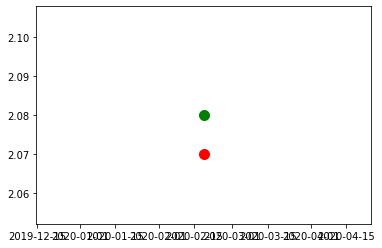

buy time:2020-02-18T20:13:25.992804498Z sell time:2020-02-18T20:13:38.536522182Z
{'rsi': 71.0747310820928, 'macd1': [-0.0009195714904923769, -0.0008851313655999782, -0.0008480613946373339, -0.0008093534527762181, 2.791748119213011e-05], 'macd2': [0.00039643038032988187, 0.0003588014524207317, 0.00032360778231721454, 0.0002907109146494946, 0.0004199158182234264], 'macd_signal': [-0.0008383965500840503, -0.0008477435131872358, -0.0008478070894772555, -0.000840116362137048, -0.0006665095934712124]}
{'rsi': 45.036808681221316, 'macd': [-0.0005947906478618314, -0.0005670231572754147, -0.000538022214516154, -0.0005084367758141362, -0.0004787801122043689], 'scalp': 0, 'bail_out': 0, 'movement': -0.004807692307692419, 'too_close': 0, 'macd_signal': [-0.0005670273256368201, -0.0005670264919645391, -0.000561225636474862, -0.0005506678643427169, -0.0005362903139150473], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_t

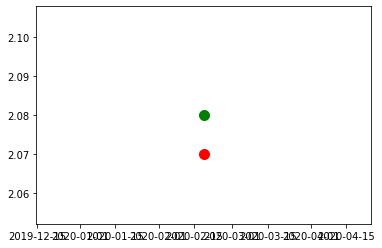

buy time:2020-02-18T20:15:12.128878465Z sell time:2020-02-18T20:15:35.631744333Z
{'rsi': 72.12942719556895, 'macd1': [-0.0008480613946373339, -0.0008093534527762181, -0.0003709429176681489, -2.3231610473573028e-05, 0.0006483169249125176], 'macd2': [0.00032360778231721454, 0.0002907109146494946, 0.0003399478054282312, 0.0003847036208863841, 0.0005052331358346152], 'macd_signal': [-0.0008478070894772555, -0.000840116362137048, -0.0007462816732432682, -0.0006016716606893292, -0.00035167394356895983]}
{'rsi': 45.660139911892585, 'macd': [-0.000538022214516154, -0.0005084367758141362, -0.00021903985246440882, 9.308917061190414e-06, -7.261813158176977e-05], 'scalp': 0, 'bail_out': 0, 'movement': -0.004807692307692419, 'too_close': 1, 'macd_signal': [-0.000561225636474862, -0.0005506678643427169, -0.00048434226196705527, -0.0003856120261614061, -0.00032301324724547884], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_ma

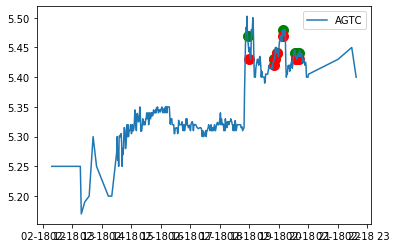

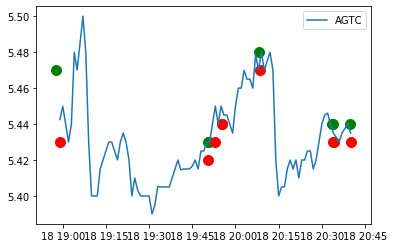

Delta = -0.09000000000000252


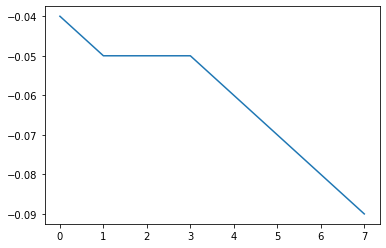

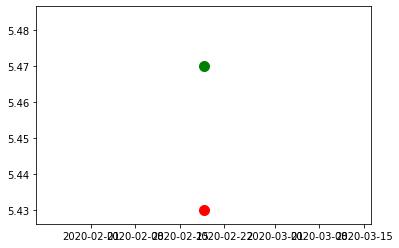

buy time:2020-02-18T18:57:48.311218895Z sell time:2020-02-18T18:59:02.630265258Z
{'rsi': 74.16431461483694, 'macd1': [0.01947815536635389, 0.02797918209860306, 0.03406540894468346, 0.04023250508967813, 0.04201319289456418], 'macd2': [0.004406515018862578, 0.006673740587081589, 0.008697807388410084, 0.010904359359742877, 0.012397225672656553], 'macd_signal': [0.005702522864044352, 0.010157854710956093, 0.014939365557701569, 0.01999799346409688, 0.02440103335019034]}
{'rsi': 60.93977189682654, 'macd': [0.021950585101391695, 0.02583218776286067, 0.02683821337228043, 0.026748905881278873, 0.024773485682040075], 'scalp': 0, 'bail_out': 0, 'movement': -0.007312614259597813, 'too_close': 0, 'macd_signal': [0.009648087935798463, 0.012884907901210904, 0.01567556899542481, 0.01789023637259562, 0.019266886234484512], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.005506599447555563}


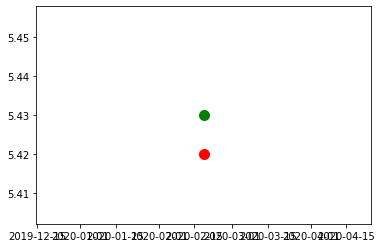

buy time:2020-02-18T19:50:25.753520017Z sell time:2020-02-18T19:50:26.791762572Z
{'rsi': 60.47966020172547, 'macd1': [0.0006696066814431134, 0.0007724677375673394, 0.00164197463068394, 0.0023045002634027867, 0.00319617134016692], 'macd2': [0.008030792944448528, 0.007855904178542872, 0.00784237252437947, 0.007817380190782153, 0.007861851650050156], 'macd_signal': [-0.0012439038377707397, -0.0008406295227031239, -0.00034410869202571113, 0.00018561309905998846, 0.0007877247472813749]}
{'rsi': 57.66404303291699, 'macd': [0.00030774044491810315, 0.0003891352894624944, 0.000966986658075264, 0.0014047021835130735, 0.0017275363308213443], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009208103130754869, 'too_close': 0, 'macd_signal': [-0.0010990991537917153, -0.0008014522651408734, -0.00044776448049764587, -7.7271147695502e-05, 0.0002836903480078673], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0

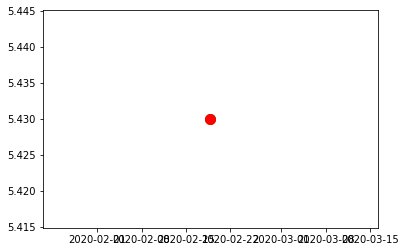

buy time:2020-02-18T19:50:47.569510118Z sell time:2020-02-18T19:52:49.007061392Z
{'rsi': 60.47966020172547, 'macd1': [0.0006696066814431134, 0.0007724677375673394, 0.00164197463068394, 0.0023045002634027867, 0.00319617134016692], 'macd2': [0.008030792944448528, 0.007855904178542872, 0.00784237252437947, 0.007817380190782153, 0.007861851650050156], 'macd_signal': [-0.0012439038377707397, -0.0008406295227031239, -0.00034410869202571113, 0.00018561309905998846, 0.0007877247472813749]}
{'rsi': 60.47966020172546, 'macd': [0.0003891352894624944, 0.000966986658075264, 0.0014047021835130735, 0.0019872765905617484, 0.002415421887086211], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.0008014522651408734, -0.00044776448049764587, -7.7271147695502e-05, 0.0003356383999559481, 0.0007515950973820007], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0016638267897042102}


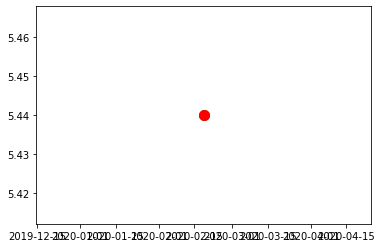

buy time:2020-02-18T19:55:08.766918601Z sell time:2020-02-18T19:55:09.905578205Z
{'rsi': 61.93465078616154, 'macd1': [0.0023045002634027867, 0.00319617134016692, 0.003858350430621549, 0.005928623502279962, 0.006685348860391294], 'macd2': [0.007817380190782153, 0.007861851650050156, 0.007890192882027414, 0.008223520512276039, 0.008357104196863752], 'macd_signal': [0.00018561309905998846, 0.0007877247472813749, 0.0014018498839494097, 0.00230720460761552, 0.003182833458170675]}
{'rsi': 61.93465078616155, 'macd': [0.0019872765905617484, 0.002415421887086211, 0.0037566335222081193, 0.004233465529805969, 0.004550042866508619], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0003356383999559481, 0.0007515950973820007, 0.0013526027823472244, 0.0019287753318389732, 0.002453028838772902], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002097014027735717}


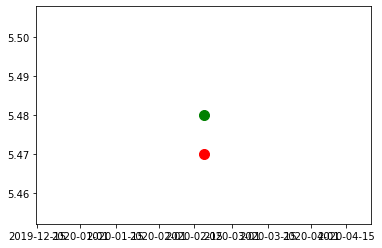

buy time:2020-02-18T20:08:06.597382452Z sell time:2020-02-18T20:08:23.709501211Z
{'rsi': 70.06671998493763, 'macd1': [0.012201272412559305, 0.012441641692474192, 0.012089319713005864, 0.01316725184062495, 0.013965435110518953], 'macd2': [0.010190874653543958, 0.010406262764765195, 0.010507815340878857, 0.010883521544906571, 0.01123256828192698], 'macd_signal': [0.00952012510535186, 0.010104428422776326, 0.010501406680822233, 0.011034575712782777, 0.011620747592330012]}
{'rsi': 66.8388100583035, 'macd': [0.007545037572086244, 0.007664892618342023, 0.007399001841160491, 0.008067151861004263, 0.008290812241908085], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009124087591242301, 'too_close': 0, 'macd_signal': [0.005903716256818389, 0.006255951529123116, 0.006484561591530591, 0.006801079645425325, 0.007099026164721877], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0011917860771862082}


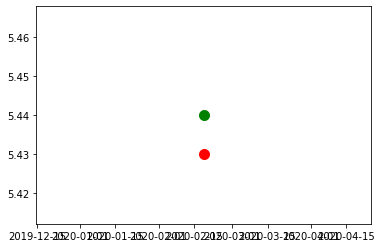

buy time:2020-02-18T20:33:28.452330234Z sell time:2020-02-18T20:33:50.258483762Z
{'rsi': 56.690217980035165, 'macd1': [-0.005702056415004542, -0.003965928582290168, -0.0021616583021604185, -0.0006356726604392904, 0.00047939498091498223], 'macd2': [0.0032928072798625863, 0.003339047369449233, 0.0034562174041008475, 0.003576082809984449, 0.003663050410024127], 'macd_signal': [-0.006178515721236623, -0.005735998293447332, -0.005021130295189949, -0.004144038768239817, -0.0032193520184088573]}
{'rsi': 51.27649982063463, 'macd': [-0.003702088132669701, -0.0025340886915916627, -0.0013313087544961633, -0.0003196450534543871, -0.000103807818182311], 'scalp': 0, 'bail_out': 0, 'movement': -0.0018365472910928694, 'too_close': 0, 'macd_signal': [-0.0042122657169465895, -0.003876630311875604, -0.003367566000399716, -0.00275798181101065, -0.002227147012444982], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_mac

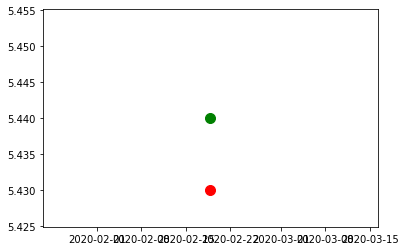

buy time:2020-02-18T20:33:55.922854581Z sell time:2020-02-18T20:34:14.160999686Z
{'rsi': 53.847630293842094, 'macd1': [-0.005702056415004542, -0.003965928582290168, -0.0021616583021604185, -0.0006356726604392904, 8.053458205381503e-05], 'macd2': [0.0032928072798625863, 0.003339047369449233, 0.0034562174041008475, 0.003576082809984449, 0.0035830823972293757], 'macd_signal': [-0.006178515721236623, -0.005735998293447332, -0.005021130295189949, -0.004144038768239817, -0.003299124098181091]}
{'rsi': 48.59898066289611, 'macd': [-0.0025340886915916627, -0.0013313087544961633, -0.0003196450534543871, 0.00015593244155809316, 5.0066916763569225e-06], 'scalp': 0, 'bail_out': 0, 'movement': -0.001838235294117771, 'too_close': 0, 'macd_signal': [-0.003876630311875604, -0.003367566000399716, -0.00275798181101065, -0.0021751989604969013, -0.0017391578300622497], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_ma

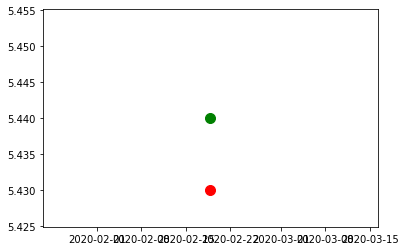

buy time:2020-02-18T20:39:51.784431507Z sell time:2020-02-18T20:40:08.656225913Z
{'rsi': 53.81857643365687, 'macd1': [8.053458205381503e-05, 0.0002418874406222571, -3.3313452984629066e-05, 0.00015031335063397933, 0.0006913279306690612], 'macd2': [0.0035830823972293757, 0.003503823589017685, 0.0033453310612072684, 0.0032741304891414913, 0.0032833551839521746], 'macd_signal': [-0.003299124098181091, -0.0025909217904204213, -0.002079400122933263, -0.0016334574282198145, -0.0011685003564420393]}
{'rsi': 50.84565698757613, 'macd': [0.00026474695141764926, 8.635894674391409e-05, 0.00020597402171596002, 0.0005562458460879327, 0.0005622206982467404], 'scalp': 0, 'bail_out': 0, 'movement': -0.0009191176470589672, 'too_close': 0, 'macd_signal': [-0.0016872097781139913, -0.0013324960331424101, -0.0010248020221707362, -0.0007085924485190024, -0.0004544298191658538], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_sig

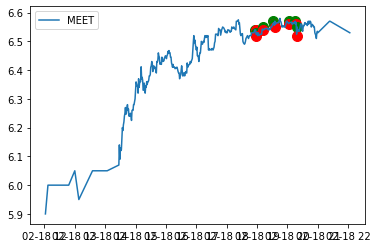

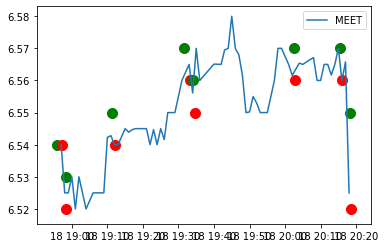

Delta = -0.09000000000000252


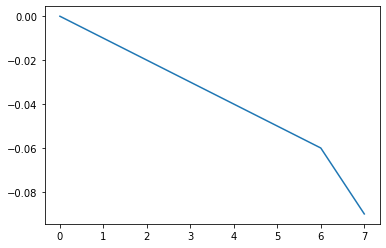

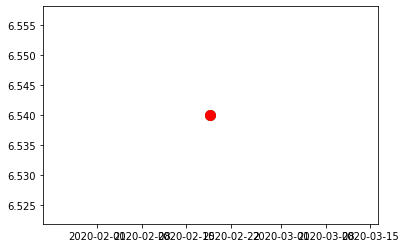

buy time:2020-02-18T18:55:41.806455521Z sell time:2020-02-18T18:57:12.379239308Z
{'rsi': 61.931400488776866, 'macd1': [-0.0012923915087785787, -0.0005681636459025086, 5.726145762885437e-06, 0.0004552896446936572, 0.0016000440709813546], 'macd2': [0.003635598287965891, 0.003610683141672233, 0.0035819856270027373, 0.0035498541101040004, 0.00367455061677191], 'macd_signal': [-0.004405739583826179, -0.003638224396241445, -0.002909434287840579, -0.002236489501333732, -0.0014691827868707145]}
{'rsi': 61.931400488776866, 'macd': [-0.00014788856629621705, 0.00022364808157870897, 0.0005102526373050864, 0.0012464347243987817, 0.0018038956400001638], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.0022504306612790887, -0.001755614912707529, -0.001302441402705006, -0.0007926661772842484, -0.0002733538138273659], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00207724945

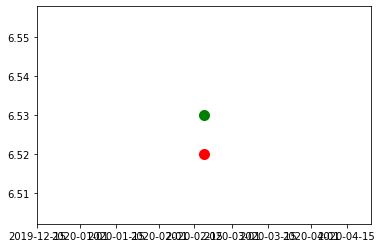

buy time:2020-02-18T18:58:21.495012349Z sell time:2020-02-18T18:58:23.328948685Z
{'rsi': 61.931400488776866, 'macd1': [5.726145762885437e-06, 0.0004552896446936572, 0.0016000440709813546, 0.00247869732153827, 0.003138853602497882], 'macd2': [0.0035819856270027373, 0.0035498541101040004, 0.00367455061677191, 0.003783398461384202, 0.0038774909430348004], 'macd_signal': [-0.002909434287840579, -0.002236489501333732, -0.0014691827868707145, -0.0006796067651889175, 8.40853083484425e-05]}
{'rsi': 48.61682781903943, 'macd': [0.00022364808157870897, 0.0005102526373050864, 0.0012464347243987817, 0.0018038956400001638, 0.0014356327737150565], 'scalp': 0, 'bail_out': 0, 'movement': -0.0022935779816513273, 'too_close': 0, 'macd_signal': [-0.001755614912707529, -0.001302441402705006, -0.0007926661772842484, -0.0002733538138273659, 6.844350368111858e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.

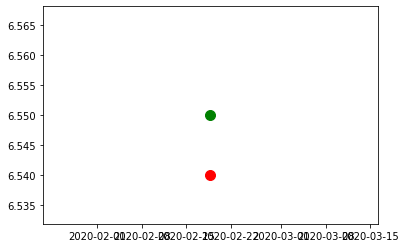

buy time:2020-02-18T19:11:22.109448262Z sell time:2020-02-18T19:12:03.432160811Z
{'rsi': 64.52132158165047, 'macd1': [-6.455839520480566e-05, -0.00013290356816142435, -0.00018493578551304068, 0.0011564627426086105, 0.0028084819570333153], 'macd2': [0.0027506845056830542, 0.002646418322557409, 0.002546257522611839, 0.0027267233239847144, 0.003011547360634914], 'macd_signal': [0.00037546462758359137, 0.00027379098843458824, 0.00018204563364506245, 0.00037692905543777207, 0.0008632396357568808]}
{'rsi': 58.511502934973706, 'macd': [-1.6193188155710914e-05, -5.604986617679941e-05, 0.0008123222011597875, 0.0015044001471213875, 0.001878689453752358], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015267175572518759, 'too_close': 0, 'macd_signal': [0.000284449049077291, 0.0002163492660264729, 0.00033554385305313583, 0.0005693151118667862, 0.0008311899802439006], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal

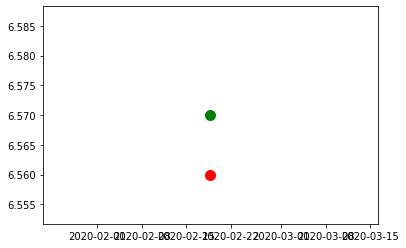

buy time:2020-02-18T19:31:25.446773355Z sell time:2020-02-18T19:33:10.835116198Z
{'rsi': 73.88203086307502, 'macd1': [0.0041397499725110976, 0.004381995137967998, 0.004521851092238016, 0.004978754177865419, 0.0064765699380817665], 'macd2': [0.003986634912682696, 0.004078719500607342, 0.004156916925162513, 0.0043021806621483805, 0.004668851248375461], 'macd_signal': [0.004161246360834105, 0.004205396116260884, 0.0042686871114563105, 0.004410700524738132, 0.004823874407406859]}
{'rsi': 68.5742772277015, 'macd': [0.002633738654104434, 0.0027145353249400372, 0.0030019803239689224, 0.003451911747575309, 0.0037524828341837235], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015220700152208029, 'too_close': 0, 'macd_signal': [0.002574093259213113, 0.002602181672358498, 0.002682141402680583, 0.0028360954716595286, 0.0030193729441643676], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0007331098900193

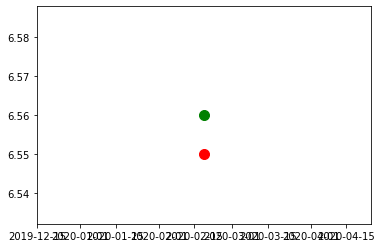

buy time:2020-02-18T19:34:03.875155935Z sell time:2020-02-18T19:34:43.860788469Z
{'rsi': 71.70185795995019, 'macd1': [0.004381995137967998, 0.004521851092238016, 0.004978754177865419, 0.005686826348338947, 0.00656765979986762], 'macd2': [0.004078719500607342, 0.004156916925162513, 0.0043021806621483805, 0.004510514583041747, 0.004773343169064859], 'macd_signal': [0.004205396116260884, 0.0042686871114563105, 0.004410700524738132, 0.004665925689458296, 0.00504627251154016]}
{'rsi': 60.43794084221403, 'macd': [0.0027145353249400372, 0.0030019803239689224, 0.003451911747575309, 0.004012223093924128, 0.003934384882066766], 'scalp': 0, 'bail_out': 0, 'movement': -0.001355674028941443, 'too_close': 1, 'macd_signal': [0.002602181672358498, 0.002682141402680583, 0.0028360954716595286, 0.0030713209961124484, 0.003243933773303312], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0006904511087634539}


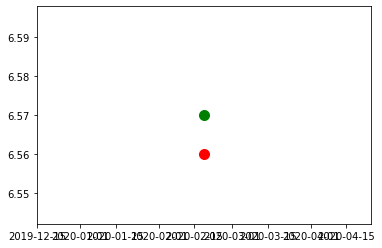

buy time:2020-02-18T20:02:28.553923109Z sell time:2020-02-18T20:02:44.781618945Z
{'rsi': 59.486861472785236, 'macd1': [0.0007994992407134305, 0.0018515709990012397, 0.0026547432198933407, 0.002854895322074391, 0.0033780356263806155], 'macd2': [0.004997256792531601, 0.005120742675178924, 0.00522616372486695, 0.005234827931356989, 0.0053143949155263215], 'macd_signal': [0.0027671911307473296, 0.0025840671043981115, 0.0025982023274971574, 0.0026495409264126043, 0.0027952398664062065]}
{'rsi': 53.0913267437924, 'macd': [0.00011824574222796258, 0.0008230767907670966, 0.001361606480657862, 0.0015038165444600793, 0.0014184761195723539], 'scalp': 0, 'bail_out': 0, 'movement': -0.0012785388127853825, 'too_close': 1, 'macd_signal': [0.0013712318103485943, 0.0012616008064322947, 0.0012816019412774083, 0.0013260448619139425, 0.0013445311134456248], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 7.39450

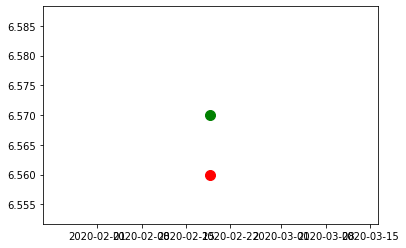

buy time:2020-02-18T20:15:31.250271299Z sell time:2020-02-18T20:16:08.348113829Z
{'rsi': 58.83910384419557, 'macd1': [0.002266452898274096, 0.0022687609964515687, 0.0019814666460620245, 0.001997045526570318, 0.0023853532474644723], 'macd2': [0.004910497255933066, 0.004870778391463659, 0.004773666747836636, 0.004729465004943201, 0.004761201882025112], 'macd_signal': [0.0026259493311876483, 0.0025545116642404324, 0.002439902660604751, 0.0023513312337978642, 0.0023581356365311858]}
{'rsi': 48.47905854637566, 'macd': [0.0011950431046541254, 0.0010153205434058066, 0.001033519579531017, 0.0012940185741809884, 0.0009607188482689821], 'scalp': 0, 'bail_out': 0, 'movement': -0.0015220700152208029, 'too_close': 1, 'macd_signal': [0.0013484800478216507, 0.001281848146938482, 0.001232182433456989, 0.0012445496616017887, 0.0011877834989352273], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000227064

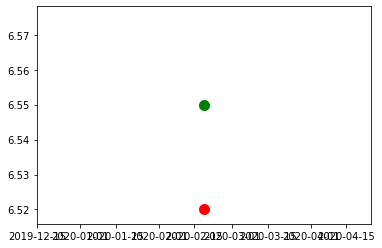

buy time:2020-02-18T20:18:17.754738233Z sell time:2020-02-18T20:18:35.879957493Z
{'rsi': 56.91308325826439, 'macd1': [0.001997045526570318, 0.0023853532474644723, 0.0018646786328089249, 0.0018981708448837509, 0.0022378223404420083], 'macd2': [0.004729465004943201, 0.004761201882025112, 0.004622849921464223, 0.004580930984664278, 0.0046022107937346846], 'macd_signal': [0.0023513312337978642, 0.0023581356365311858, 0.0022594442357867337, 0.002187189557606137, 0.0021973161141733114]}
{'rsi': 29.080734112388352, 'macd': [0.001033519579531017, 0.0012940185741809884, 0.0009607188482689821, 0.000989826609268718, -0.0013795676887733421], 'scalp': 0, 'bail_out': 0, 'movement': -0.007610350076103609, 'too_close': 1, 'macd_signal': [0.001232182433456989, 0.0012445496616017887, 0.0011877834989352273, 0.0011481921210019254, 0.0006426401590468718], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 1, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.002022

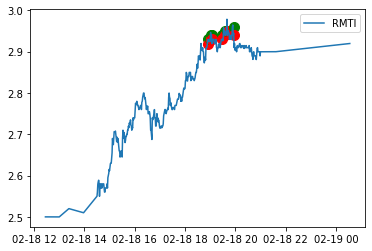

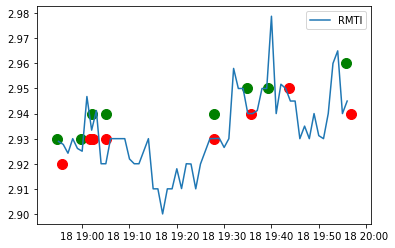

Delta = -0.06999999999999984


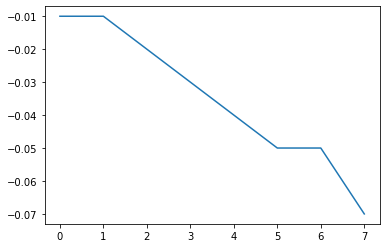

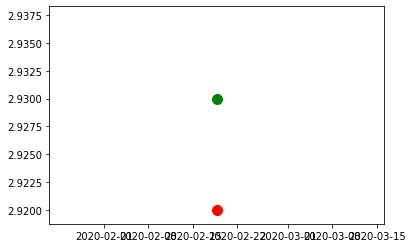

buy time:2020-02-18T18:54:34.935866089Z sell time:2020-02-18T18:55:45.821455744Z
{'rsi': 68.0102267925016, 'macd1': [0.009287123430119948, 0.010127224765860365, 0.010670013849236604, 0.01155601653451166, 0.013131591099504902], 'macd2': [0.015843191884753693, 0.015967816736648377, 0.016056937295330087, 0.016230003531373605, 0.016566391134337], 'macd_signal': [0.012048571000158924, 0.011664301753299213, 0.011465444172486692, 0.011483558644891685, 0.011813165135814329]}
{'rsi': 67.34064234345767, 'macd': [0.005501389580544025, 0.005871341427227783, 0.006462585185329051, 0.0074991051892348, 0.008152249280729773], 'scalp': 0, 'bail_out': 0, 'movement': -0.000375426621160444, 'too_close': 0, 'macd_signal': [0.0064875093181973485, 0.006364275740003435, 0.006383937629068559, 0.006606971141101807, 0.0069160267690274], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0012362225117023727}


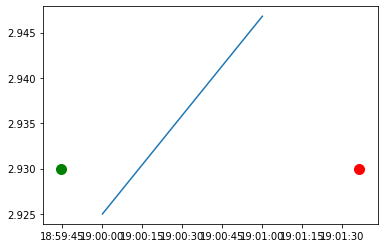

buy time:2020-02-18T18:59:44.362123354Z sell time:2020-02-18T19:01:36.328221201Z
{'rsi': 66.34496746073377, 'macd1': [0.014128618566670692, 0.01465302904873278, 0.01461770359680159, 0.014886121506578753, 0.014926778028408805], 'macd2': [0.016831789898783533, 0.01702985283256897, 0.017128862588390525, 0.01728532240358094, 0.017401624980605934], 'macd_signal': [0.012276255821985601, 0.012751610467335037, 0.013124829093228348, 0.013477087575898428, 0.013767025666400503]}
{'rsi': 66.34496746073377, 'macd': [0.008152249280729773, 0.008492981699028235, 0.008466370834078418, 0.008636980928480309, 0.008657755275696122], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.0069160267690274, 0.007231417755027567, 0.007478408370837737, 0.007710122882366251, 0.007899649361032225], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0007581059146638969}


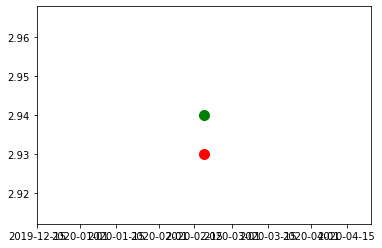

buy time:2020-02-18T19:02:05.728482554Z sell time:2020-02-18T19:02:14.472974917Z
{'rsi': 65.96478818217196, 'macd1': [0.014886121506578753, 0.014615666917297876, 0.014149462701567028, 0.015361986889224521, 0.015594454707027694], 'macd2': [0.01728532240358094, 0.017339249930625744, 0.01734354031047669, 0.017668409563893483, 0.01783028501925399], 'macd_signal': [0.013477087575898428, 0.013704803444178317, 0.01379373529565606, 0.014107385614369753, 0.014404799432901341]}
{'rsi': 64.73316812632879, 'macd': [0.008636980928480309, 0.008455157873098695, 0.008146527467955966, 0.00893270471761154, 0.008972158357374305], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006802721088434626, 'too_close': 1, 'macd_signal': [0.007710122882366251, 0.00785912988051274, 0.007916609398001385, 0.008119828461923415, 0.008290294441013594], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0006818639163607108}


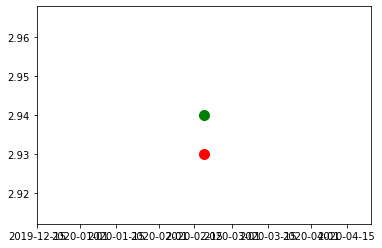

buy time:2020-02-18T19:04:57.317283694Z sell time:2020-02-18T19:04:58.259135017Z
{'rsi': 65.96900240347824, 'macd1': [0.014149462701567028, 0.015361986889224521, 0.015067958980532037, 0.015288102824370764, 0.015589490704023934], 'macd2': [0.01734354031047669, 0.017668409563893483, 0.017724727242364846, 0.0178729431836655, 0.018041497005415685], 'macd_signal': [0.01379373529565606, 0.014107385614369753, 0.014299500287602209, 0.01449722079495592, 0.014715674776769523]}
{'rsi': 53.72375864794964, 'macd': [0.008146527467955966, 0.00893270471761154, 0.008733197318413044, 0.008869513665551665, 0.007759247005327818], 'scalp': 0, 'bail_out': 0, 'movement': -0.008488964346349716, 'too_close': 1, 'macd_signal': [0.007916609398001385, 0.008119828461923415, 0.00824250223322134, 0.008367904519687405, 0.008246173016815487], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00048692601148766883}


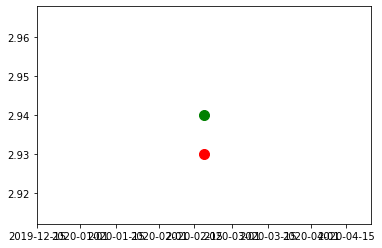

buy time:2020-02-18T19:27:47.757194196Z sell time:2020-02-18T19:27:57.459367162Z
{'rsi': 61.028129464468805, 'macd1': [0.000318516837902294, 0.0006216273113630599, 6.227936536973289e-05, 0.0004130776485329335, 0.002286630974104753], 'macd2': [0.012403570420652876, 0.012164613250099432, 0.011766972745323567, 0.011540647798314208, 0.011635435365582758], 'macd_signal': [0.0021943965243284773, 0.0018798426817353939, 0.0015163300184622616, 0.001295679544476396, 0.0014938698304020673]}
{'rsi': 57.176725476100664, 'macd': [-0.0004339471816403595, -0.00019368750527082312, -0.000518242465174179, -0.00025012629801857145, 0.00048671910882980285], 'scalp': 0, 'bail_out': 0, 'movement': -0.0034013605442176145, 'too_close': 0, 'macd_signal': [0.0006311844726040775, 0.0004662100770290974, 0.00026931956858844213, 0.00016543039526703942, 0.0002296881379795921], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd':

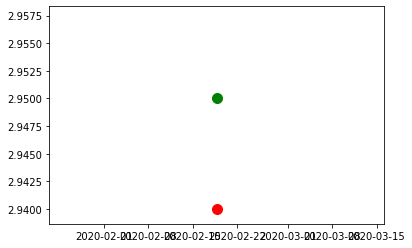

buy time:2020-02-18T19:34:50.98848872Z sell time:2020-02-18T19:35:37.768292192Z
{'rsi': 65.8051152207429, 'macd1': [0.0026624973670923424, 0.003177495813168285, 0.005778392079316852, 0.007112104059013635, 0.008777979780325573], 'macd2': [0.011252439014663995, 0.01115575708053429, 0.011496785405701981, 0.011664206051279269, 0.01194032683547297], 'macd_signal': [0.0017581172595148725, 0.002041992970245555, 0.0027892727920598146, 0.003653839045450579, 0.004678667192425578]}
{'rsi': 56.85135796738317, 'macd': [0.0016618613602501497, 0.0033725037180496464, 0.004246088623892419, 0.004871660126836819, 0.004776369608002984], 'scalp': 0, 'bail_out': 0, 'movement': -0.006353927267811326, 'too_close': 0, 'macd_signal': [0.0007945025969972052, 0.0013101028212076935, 0.0018972999817446386, 0.0024921720107630744, 0.002949011530211056], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0018273580777919277}

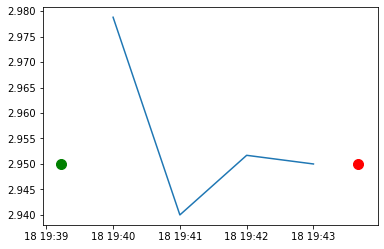

buy time:2020-02-18T19:39:13.614558376Z sell time:2020-02-18T19:43:40.334386342Z
{'rsi': 61.414711778751254, 'macd1': [0.007941408408243866, 0.007745470152098033, 0.007599416302956907, 0.008100377916274493, 0.008400557209713888], 'macd2': [0.011745326568540548, 0.011676623785258133, 0.011613932222093393, 0.011678422819562329, 0.01171907822679863], 'macd_signal': [0.005218896347270209, 0.0057242111082357735, 0.00609925214718, 0.006499477300998899, 0.006879693282741897]}
{'rsi': 55.060957154912096, 'macd': [0.00503713865920119, 0.006611253718847188, 0.005736392028715898, 0.005587975230838094, 0.005311442982740555], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.004047583219259786, 0.004560317319177267, 0.004795532261084993, 0.0049540208550356134, 0.0050255052805766014], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0002859377021639537}


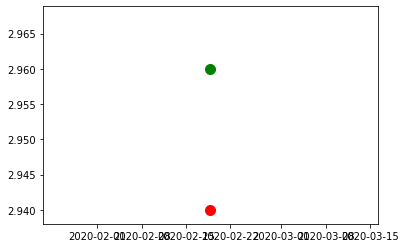

buy time:2020-02-18T19:55:42.986814953Z sell time:2020-02-18T19:56:51.696484455Z
{'rsi': 58.31682266250176, 'macd1': [0.0010086690636517126, 0.001120688786180768, 0.002791123739317225, 0.0044669217938904104, 0.005330103497115601], 'macd2': [0.009585089104851452, 0.009400311461702504, 0.009535147686119405, 0.009723919202168307, 0.009802074972507846], 'macd_signal': [0.004043365821951525, 0.003458830414797374, 0.003325289079701344, 0.0035536156225391574, 0.003908913197454446]}
{'rsi': 49.920266894987655, 'macd': [0.0002681771619528206, 0.0013773942847659093, 0.0024835713378053015, 0.0020145720111108822, 0.0016229547174386738], 'scalp': 0, 'bail_out': 0, 'movement': -0.0033898305084746542, 'too_close': 1, 'macd_signal': [0.0017583447893234478, 0.00168215468841194, 0.0018424380182906124, 0.0018768648168546664, 0.001826082796971468], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.000203128079

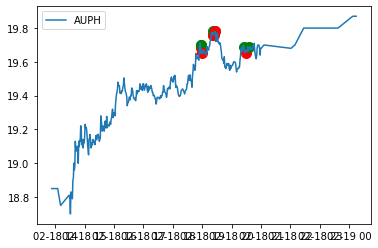

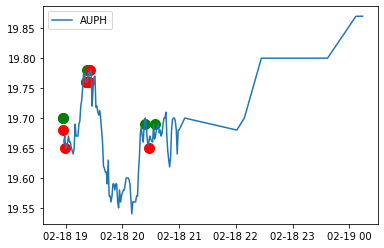

Delta = nan


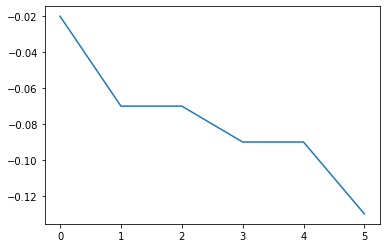

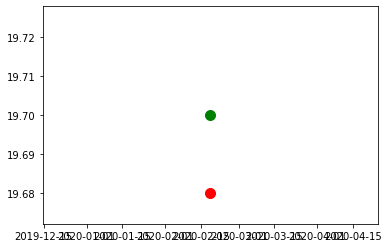

buy time:2020-02-18T18:57:16.163835833Z sell time:2020-02-18T18:57:26.546212287Z
{'rsi': 69.55036748667777, 'macd1': [0.040111463872953834, 0.04445231935929428, 0.04923729366501206, 0.0527122758855576, 0.053749230321763264], 'macd2': [0.024308268118556242, 0.026029157056743912, 0.02794984830766012, 0.029729820788720218, 0.03110239071905241], 'macd_signal': [0.03712609777343344, 0.03859134209060561, 0.0407205324054869, 0.04311888110150104, 0.04524495094555349]}
{'rsi': 66.68689705490553, 'macd': [0.02438550487338631, 0.02710493600727304, 0.030103129929688777, 0.03223544818183299, 0.032101729311012406], 'scalp': 0, 'bail_out': 0, 'movement': -0.0006548223350252973, 'too_close': 0, 'macd_signal': [0.0228874136192024, 0.023730918096816527, 0.025005360463390976, 0.02645137800707938, 0.027581448267865984], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0045202810431464215}


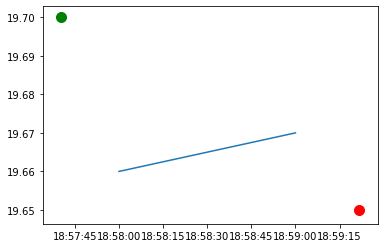

buy time:2020-02-18T18:57:40.293288618Z sell time:2020-02-18T18:59:21.491159574Z
{'rsi': 69.55036748667777, 'macd1': [0.040111463872953834, 0.04445231935929428, 0.04923729366501206, 0.0527122758855576, 0.053749230321763264], 'macd2': [0.024308268118556242, 0.026029157056743912, 0.02794984830766012, 0.029729820788720218, 0.03110239071905241], 'macd_signal': [0.03712609777343344, 0.03859134209060561, 0.0407205324054869, 0.04311888110150104, 0.04524495094555349]}
{'rsi': 59.86925933175199, 'macd': [0.030103129929688777, 0.03223544818183299, 0.030174456583740294, 0.028696093564658298, 0.0269117055814192], 'scalp': 0, 'bail_out': 0, 'movement': -0.002177897136242924, 'too_close': 1, 'macd_signal': [0.025005360463390976, 0.02645137800707938, 0.027195993722411563, 0.02749601369086091, 0.027379152068972568], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00046744648755336904}


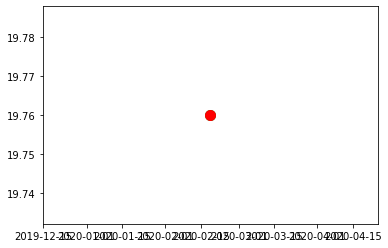

buy time:2020-02-18T19:21:16.27523405Z sell time:2020-02-18T19:21:55.775216201Z
{'rsi': 72.78391439551825, 'macd1': [0.025866326131847472, 0.028051352018778175, 0.031047012163593735, 0.035026552024479685, 0.037346401749964286], 'macd2': [0.033346514622763834, 0.033926392329032495, 0.03472710925538536, 0.03580649398569946, 0.036662326967910275], 'macd_signal': [0.026024187183835475, 0.026429620150824014, 0.027353098553377957, 0.028887789247598303, 0.0305795117480715]}
{'rsi': 69.22705979355577, 'macd': [0.015804936391102586, 0.017777404856303747, 0.02037702437650779, 0.0221380652445049, 0.02244357676184805], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005058168942841685, 'too_close': 0, 'macd_signal': [0.014637955127201589, 0.01526584507302202, 0.016288080933719175, 0.01745807779587632, 0.018455177589070663], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003988399172777386}


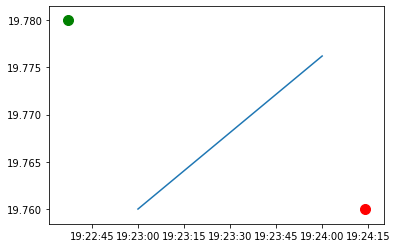

buy time:2020-02-18T19:22:37.065187728Z sell time:2020-02-18T19:24:13.850938539Z
{'rsi': 72.06589496914911, 'macd1': [0.031047012163593735, 0.035026552024479685, 0.037745262148824565, 0.03824857905936696, 0.03980247602278908], 'macd2': [0.03472710925538536, 0.03580649398569946, 0.036742294980705026, 0.03730459362508043, 0.03808213493104162], 'macd_signal': [0.027353098553377957, 0.028887789247598303, 0.030659283827843557, 0.03217714287414824, 0.03370220950387641]}
{'rsi': 70.9072397184592, 'macd': [0.0221380652445049, 0.02244357676184805, 0.022390162661572788, 0.022057759951465528, 0.02202137134681692], 'scalp': 0, 'bail_out': 0, 'movement': -0.000515672396360015, 'too_close': 0, 'macd_signal': [0.01745807779587632, 0.018455177589070663, 0.01924217460357109, 0.019805291673149976, 0.020248507607883364], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0017728637389335562}


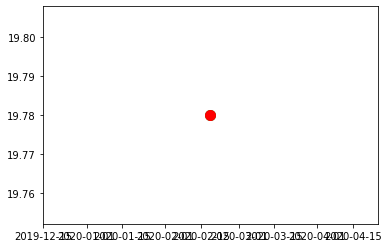

buy time:2020-02-18T19:25:04.64343778Z sell time:2020-02-18T19:25:17.357800695Z
{'rsi': 72.51397271977035, 'macd1': [0.03824857905936696, 0.03820703442734796, 0.03773907741448568, 0.03823467716321716, 0.038490378651104606], 'macd2': [0.03730459362508043, 0.03776226287986262, 0.03812293777140141, 0.03865289425854357, 0.03913942696541284], 'macd_signal': [0.03217714287414824, 0.033383121184788186, 0.034254312430727685, 0.03505038537722558, 0.035738384032001386]}
{'rsi': 72.51397271977035, 'macd': [0.02244357676184805, 0.022390162661572788, 0.022057759951465528, 0.02235383887928677, 0.02249164273370141], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.018455177589070663, 0.01924217460357109, 0.019805291673149976, 0.020315001114377333, 0.02075032943824215], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0017413132954592625}


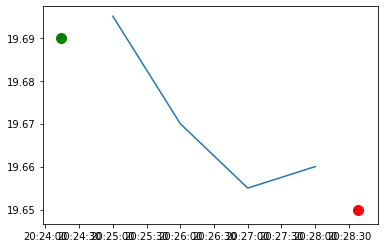

buy time:2020-02-18T20:24:14.323635029Z sell time:2020-02-18T20:28:38.3749417Z
{'rsi': 67.94676494928979, 'macd1': [0.01016135483261138, 0.013999231703799353, 0.016048859090588508, 0.01946610152649697, 0.022320452705326232], 'macd2': [-0.004260724937196869, -0.00312080207951837, -0.002226981326284516, -0.0010012358330833138, 0.0002080585784263178], 'macd_signal': [-0.005180270661977191, -0.0013443701888218823, 0.002134275667060196, 0.005600640838947551, 0.008944603212223286]}
{'rsi': 54.32663325509889, 'macd': [0.01581266444054208, 0.017084547747110435, 0.016555047106162846, 0.015148227813135406, 0.013595534496321449], 'scalp': 0, 'bail_out': 0, 'movement': -0.002031488065007755, 'too_close': 0, 'macd_signal': [0.007076634858011005, 0.009078217435830892, 0.010573583369897282, 0.011488512258544907, 0.011909916706100216], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0016856177902212326}


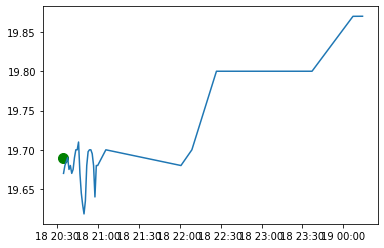

buy time:2020-02-18T20:34:39.857365647Z sell time:None
{'rsi': 62.878554797784695, 'macd1': [0.019919113654491838, 0.018572946875856644, 0.0172108737942942, 0.018340749598831252, 0.019016968538583257], 'macd2': [0.0040146276539339, 0.0043343501261290385, 0.004602380517180649, 0.005321424262778152, 0.005974456634458392], 'macd_signal': [0.01849915896628142, 0.018513916548196466, 0.018253307997416014, 0.01827079631769906, 0.0184200307618759]}
None
AVXL analysis for run 66


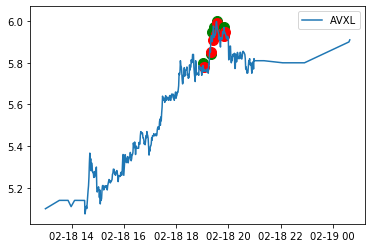

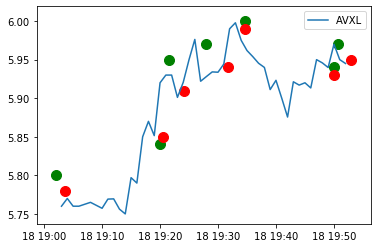

Delta = -0.11999999999999922


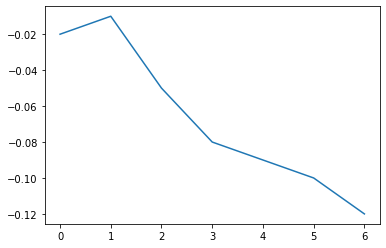

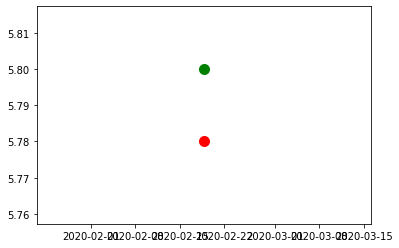

buy time:2020-02-18T19:02:07.817913754Z sell time:2020-02-18T19:03:32.863356478Z
{'rsi': 56.33263554902397, 'macd1': [0.0018454857237104605, -0.00042348341141007495, 0.0004361388720299786, 0.0004664852323088553, 0.0032769675917032615], 'macd2': [0.02261142995112042, 0.021629037790940053, 0.021218401840624068, 0.020678718942168217, 0.02070889678098542], 'macd_signal': [0.0023281400557607196, 0.0017778153623265605, 0.0015094800642672442, 0.0013008810978755664, 0.0016960983966411054]}
{'rsi': 54.16746754100132, 'macd': [0.00032649575678256326, -0.001093622611656464, -0.00047171974795112703, -0.00039657829898676056, 0.0007788121586349561], 'scalp': 0, 'bail_out': 0, 'movement': -0.0023448275862067917, 'too_close': 0, 'macd_signal': [0.00035848813211024935, 6.806598335690667e-05, -3.989116290470009e-05, -0.00011122859012111219, 6.67795596301015e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd'

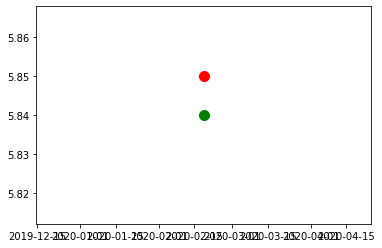

buy time:2020-02-18T19:20:04.039351701Z sell time:2020-02-18T19:20:29.5306576Z
{'rsi': 66.10778089906873, 'macd1': [-0.0013631787474288615, 0.0015417756672668759, 0.0032417624518039645, 0.009323042554197691, 0.01415683132326162], 'macd2': [0.015110525203196445, 0.015225038668553736, 0.015194089179994208, 0.016100929991711865, 0.016944687283912074], 'macd_signal': [6.559983982827079e-05, 0.00036083500531599184, 0.0009370204946135864, 0.0026142249065304072, 0.0049227461898766495]}
{'rsi': 58.99200440496016, 'macd': [0.0018541556943860726, 0.005822918616809503, 0.009878799873025201, 0.011949891762634834, 0.01242152321216583], 'scalp': 0, 'bail_out': 0, 'movement': -0.0033662554253101867, 'too_close': 0, 'macd_signal': [0.00023131952926610462, 0.0013496393467747844, 0.0030554714520248678, 0.004834355514146861, 0.006351789053750655], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0060697341584

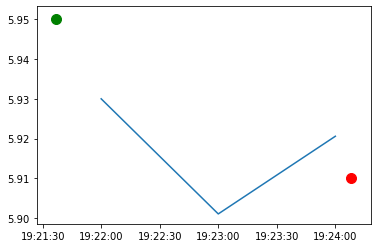

buy time:2020-02-18T19:21:36.658923543Z sell time:2020-02-18T19:24:08.273561872Z
{'rsi': 74.23134581788098, 'macd1': [0.009323042554197691, 0.015576774343204924, 0.01882312518253304, 0.02661644136511132, 0.034812156991175236], 'macd2': [0.016100929991711865, 0.017229373409461957, 0.017944139827137384, 0.01966861042600243, 0.021703529420918244], 'macd_signal': [0.0026142249065304072, 0.0052067347938653105, 0.007930012871598856, 0.011667298570301349, 0.016296270254476126]}
{'rsi': 65.23114939405453, 'macd': [0.011949891762634834, 0.016966977757620683, 0.02117552557504343, 0.024179906659073325, 0.024705659365342747], 'scalp': 0, 'bail_out': 0, 'movement': -0.008218487394958085, 'too_close': 0, 'macd_signal': [0.004834355514146861, 0.0072608799628416255, 0.010043809085281987, 0.012871028600040255, 0.015237954753100753], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.009467704612241994}


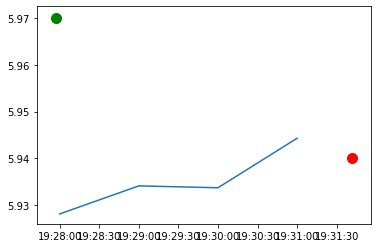

buy time:2020-02-18T19:27:56.981482693Z sell time:2020-02-18T19:31:41.674191142Z
{'rsi': 73.36155131833473, 'macd1': [0.0380093321958439, 0.0390256635099373, 0.04093275313197697, 0.0443057406919003, 0.04853351452725985], 'macd2': [0.022927355245811576, 0.023848722455672267, 0.024970142311755872, 0.026432160112476843, 0.028154021095686765], 'macd_signal': [0.0203836119874791, 0.024112022291970743, 0.02747616845997199, 0.030842082906357652, 0.03438036923053809]}
{'rsi': 64.40605575562259, 'macd': [0.029267960410066074, 0.028279538524446757, 0.02745376123014065, 0.026432976828991706, 0.025881287986161183], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008403361344537636, 'too_close': 1, 'macd_signal': [0.02317643325281918, 0.024197054307144694, 0.024848395691743887, 0.02516531191919345, 0.025308507132586998], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0005727808535741855}


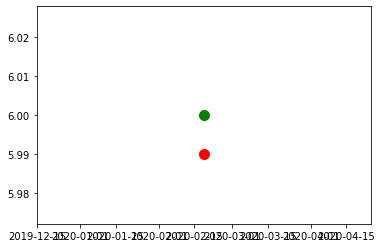

buy time:2020-02-18T19:34:36.866611656Z sell time:2020-02-18T19:34:42.411212918Z
{'rsi': 70.91264371269514, 'macd1': [0.04329835360344614, 0.04258812367584408, 0.045191925029707036, 0.04733915486501594, 0.048657478469716686], 'macd2': [0.030718839244200602, 0.03135203027054878, 0.03261535071458965, 0.033850232337491626, 0.0349674101403501], 'macd_signal': [0.040545143575410635, 0.04095373959549732, 0.04180137668233926, 0.0429089323188746, 0.044058641549043015]}
{'rsi': 69.42275247129665, 'macd': [0.026432976828991706, 0.025844924349797793, 0.02742507924458426, 0.028705393717864958, 0.0290860881942141], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011499999999999844, 'too_close': 0, 'macd_signal': [0.02516531191919345, 0.02530123440531432, 0.025726003373168306, 0.026321881442107637, 0.026874722792528928], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002211365401685171}


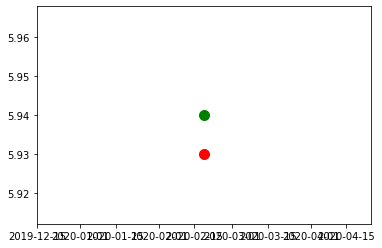

buy time:2020-02-18T19:49:56.550481975Z sell time:2020-02-18T19:49:57.290169055Z
{'rsi': 60.28033104607435, 'macd1': [0.010881606935076782, 0.009376351693513918, 0.011017802980682667, 0.011843238570564907, 0.01403019535955341], 'macd2': [0.03018531207739361, 0.029569963533462307, 0.029543495379236617, 0.02940472000762906, 0.029565879139935802], 'macd_signal': [0.020856831747740986, 0.018560735736895574, 0.017052149185652992, 0.016010367062635374, 0.015614332722018981]}
{'rsi': 55.21106628601188, 'macd': [0.004701744567426225, 0.0038052249235693836, 0.0049637131890891695, 0.005583785692232723, 0.005682754062315887], 'scalp': 0, 'bail_out': 0, 'movement': -0.004525038546624679, 'too_close': 0, 'macd_signal': [0.011136729969969101, 0.009670428960689158, 0.00872908580636916, 0.008100025783541872, 0.007616571439296675], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0019338173769807886}


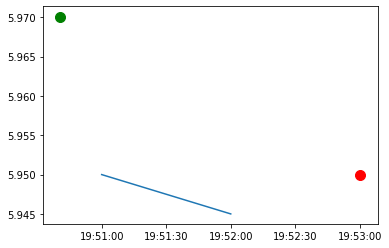

buy time:2020-02-18T19:50:40.758705941Z sell time:2020-02-18T19:52:59.946587455Z
{'rsi': 60.63802740039921, 'macd1': [0.009376351693513918, 0.011017802980682667, 0.011843238570564907, 0.011876349205707903, 0.014176064384743725], 'macd2': [0.029569963533462307, 0.029543495379236617, 0.02940472000762906, 0.029134051870843614, 0.029321439479709], 'macd_signal': [0.018560735736895574, 0.017052149185652992, 0.016010367062635374, 0.01518356349124988, 0.014982063669948649]}
{'rsi': 55.81474523466643, 'macd': [0.005583785692232723, 0.005682754062315887, 0.007254901440791883, 0.007346770807906466, 0.007322944719840407], 'scalp': 0, 'bail_out': 0, 'movement': -0.0028991336115160374, 'too_close': 0, 'macd_signal': [0.008100025783541872, 0.007616571439296675, 0.007544237439595717, 0.007504744113257867, 0.007468384234574375], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00014543951473396793}
SBGL a

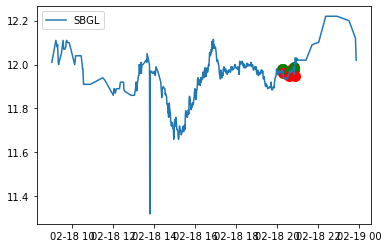

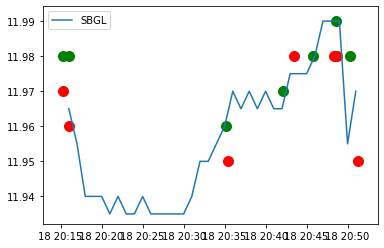

Delta = -0.07000000000000206


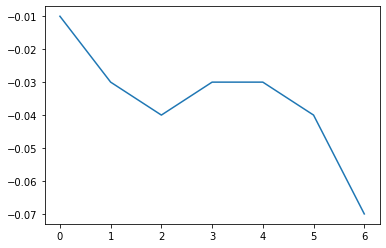

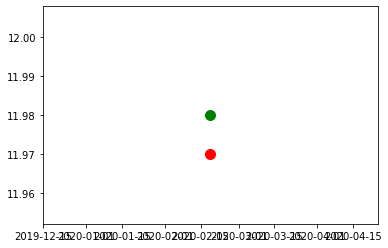

buy time:2020-02-18T20:15:16.458017071Z sell time:2020-02-18T20:15:20.949402952Z
{'rsi': 66.73028271717502, 'macd1': [0.01280194765387499, 0.012537709831692112, 0.01178894561395083, 0.011865680820974944, 0.012189439962421389], 'macd2': [0.0006428423133009176, 0.0010565377072673243, 0.0013554929054642173, 0.0017883093546569029, 0.0022636221943876933], 'macd_signal': [0.013237396929911853, 0.013097459510267905, 0.01283575673100449, 0.01264174154899858, 0.012551281231683142]}
{'rsi': 64.584613601013, 'macd': [0.00790942173124698, 0.007686759103355811, 0.007153687456904478, 0.0071648824407493095, 0.007080555383474518], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004173622704508165, 'too_close': 0, 'macd_signal': [0.008482224188404705, 0.008323131171394927, 0.008089242428496837, 0.00790437043094733, 0.007739607421452768], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006590520379782501}


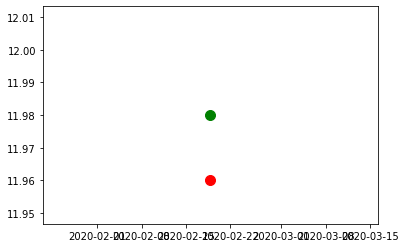

buy time:2020-02-18T20:15:57.676533493Z sell time:2020-02-18T20:16:02.718988908Z
{'rsi': 66.73028271717502, 'macd1': [0.01280194765387499, 0.012537709831692112, 0.01178894561395083, 0.011865680820974944, 0.012189439962421389], 'macd2': [0.0006428423133009176, 0.0010565377072673243, 0.0013554929054642173, 0.0017883093546569029, 0.0022636221943876933], 'macd_signal': [0.013237396929911853, 0.013097459510267905, 0.01283575673100449, 0.01264174154899858, 0.012551281231683142]}
{'rsi': 54.11455755360637, 'macd': [0.00790942173124698, 0.007686759103355811, 0.007153687456904478, 0.0071648824407493095, 0.006301334604254194], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016694490818029693, 'too_close': 1, 'macd_signal': [0.008482224188404705, 0.008323131171394927, 0.008089242428496837, 0.00790437043094733, 0.007583763265608704], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0012824286613545097}


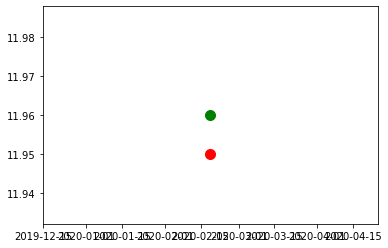

buy time:2020-02-18T20:35:07.606316719Z sell time:2020-02-18T20:35:24.110914641Z
{'rsi': 62.52662941026066, 'macd1': [-0.003633228590427251, -0.0025044609976401233, -0.0015915580574503707, -0.00045932289852679276, 0.0008318507775353368], 'macd2': [-0.0001445442000580499, -2.2554807786789866e-05, 8.97154084675833e-05, 0.0002728321241658449, 0.0005208370159390796], 'macd_signal': [-0.002341006448235755, -0.0023736973581166285, -0.0022172694979833768, -0.00186568017809206, -0.0013261739869665804]}
{'rsi': 59.19155513377646, 'macd': [-0.002613106023396483, -0.0018399465559006956, -0.00121358922335979, -0.00045001741588102107, 0.00015081798495764076], 'scalp': 0, 'bail_out': 0, 'movement': -0.00041806020066896164, 'too_close': 0, 'macd_signal': [-0.001911465860975345, -0.0018971619999604151, -0.0017604474446402901, -0.0014983614388884364, -0.001168525554119221], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_

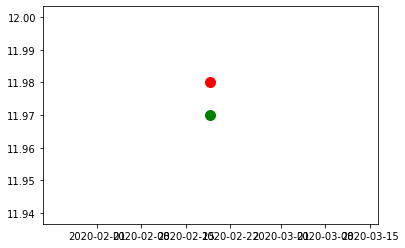

buy time:2020-02-18T20:42:10.792557556Z sell time:2020-02-18T20:43:31.445941799Z
{'rsi': 63.81174733720131, 'macd1': [0.003612978317606874, 0.0047394768107231755, 0.005169189569596, 0.00584581136564033, 0.006309309224471704], 'macd2': [0.0011829978617399206, 0.0015139771889796094, 0.0017360993494044408, 0.0020176502065574198, 0.0022734590516115816], 'macd_signal': [0.00029491552814610083, 0.0011838277846615156, 0.0019809001416484125, 0.002753882386446796, 0.003464967754051778]}
{'rsi': 62.114642533764716, 'macd': [0.002969476000911797, 0.003241159472496591, 0.0036705081585051147, 0.0036976563793089667, 0.003930529585399967], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.0005844825856761247, 0.001115817963040218, 0.0016267560021331973, 0.002040936077568351, 0.002418854779134674], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0015116748062652926}


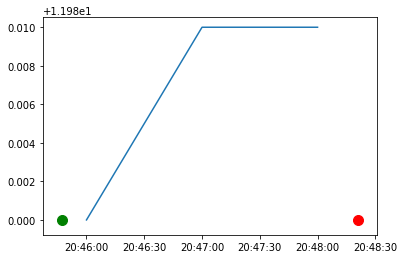

buy time:2020-02-18T20:45:47.064973759Z sell time:2020-02-18T20:48:20.938752861Z
{'rsi': 67.65070751935238, 'macd1': [0.005910448825611425, 0.00629259556689199, 0.006919148192489288, 0.007331186310066684, 0.007969322313179816], 'macd2': [0.0021934910388168305, 0.0024317300595591007, 0.0027269963796268115, 0.0029942893892069833, 0.0033153865733268617], 'macd_signal': [0.003385195674279722, 0.003966675652802175, 0.004557170160739598, 0.005111973390605015, 0.005683443175119976]}
{'rsi': 0, 'macd': [], 'bail_out': 0, 'too_close': 0, 'macd_signal': [], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0}


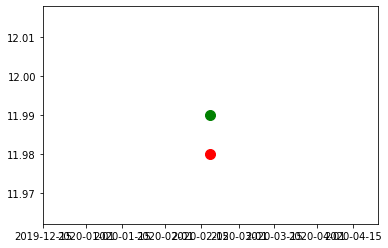

buy time:2020-02-18T20:48:36.491303564Z sell time:2020-02-18T20:48:39.440547432Z
{'rsi': 72.32757344115356, 'macd1': [0.00629259556689199, 0.006919148192489288, 0.007331186310066684, 0.007969322313179816, 0.00917618872800574], 'macd2': [0.0024317300595591007, 0.0027269963796268115, 0.0029942893892069833, 0.0033153865733268617, 0.0037654397817910024], 'macd_signal': [0.003966675652802175, 0.004557170160739598, 0.005111973390605015, 0.005683443175119976, 0.006381992285697129]}
{'rsi': 0, 'macd': [], 'bail_out': 0, 'too_close': 0, 'macd_signal': [], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0}


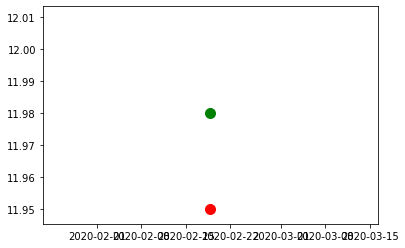

buy time:2020-02-18T20:50:16.352972696Z sell time:2020-02-18T20:51:13.699872195Z
{'rsi': 67.10371516393042, 'macd1': [0.006919148192489288, 0.007331186310066684, 0.007969322313179816, 0.00917618872800574, 0.00961830698773447], 'macd2': [0.0027269963796268115, 0.0029942893892069833, 0.0033153865733268617, 0.0037654397817910024, 0.004093512821993883], 'macd_signal': [0.004557170160739598, 0.005111973390605015, 0.005683443175119976, 0.006381992285697129, 0.007029255226104597]}
{'rsi': 0, 'macd': [], 'bail_out': 0, 'too_close': 0, 'macd_signal': [], 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0}
IFRX analysis for run 66


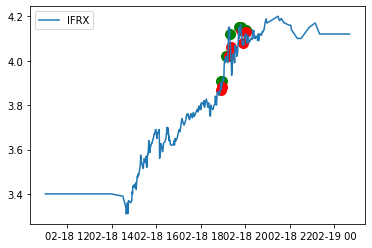

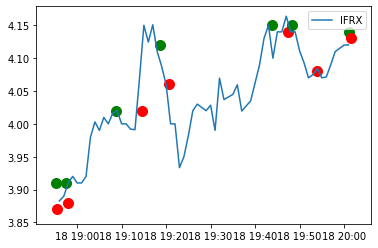

Delta = -0.22000000000000153


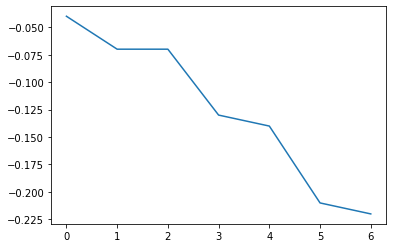

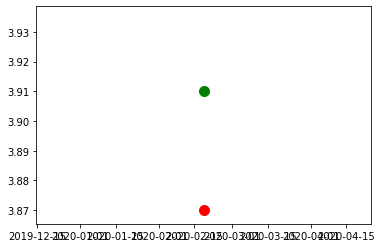

buy time:2020-02-18T18:55:21.736868044Z sell time:2020-02-18T18:55:22.448655485Z
{'rsi': 70.64802936963476, 'macd1': [0.01810299699315676, 0.018910492422297587, 0.019327641349147662, 0.02262509260124812, 0.02574845078906174], 'macd2': [0.02032913534339631, 0.02060121751859123, 0.020818593054396484, 0.02162503317261777, 0.022492333684147603], 'macd_signal': [0.013376996591324493, 0.014483695757519111, 0.015452484875844821, 0.01688700642092548, 0.018659295294552732]}
{'rsi': 59.84825333269739, 'macd': [0.010997475805818446, 0.011488744876323675, 0.011722347465336735, 0.013830059255926841, 0.013734379362154048], 'scalp': 0, 'bail_out': 0, 'movement': -0.010230179028133002, 'too_close': 0, 'macd_signal': [0.007927411432582299, 0.008639678121330574, 0.009256211990131807, 0.010170981443290813, 0.01088366102706346], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0028507183350905876}


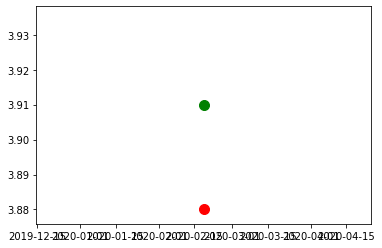

buy time:2020-02-18T18:57:27.773921499Z sell time:2020-02-18T18:57:58.680337868Z
{'rsi': 66.62151587143141, 'macd1': [0.019327641349147662, 0.02262509260124812, 0.02255756759817862, 0.02326070250918466, 0.025724290231378344], 'macd2': [0.020818593054396484, 0.02162503317261777, 0.021852589581788706, 0.022230117346352607, 0.022978526349501927], 'macd_signal': [0.015452484875844821, 0.01688700642092548, 0.01802111865637611, 0.01906903542693782, 0.020400086387825925]}
{'rsi': 63.451498137372994, 'macd': [0.011722347465336735, 0.013830059255926841, 0.013734379362154048, 0.014141195297368014, 0.0146485688144522], 'scalp': 0, 'bail_out': 0, 'movement': -0.005140664961636887, 'too_close': 0, 'macd_signal': [0.009256211990131807, 0.010170981443290813, 0.01088366102706346, 0.01153516788112437, 0.012157848067789936], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.002490720746662265}


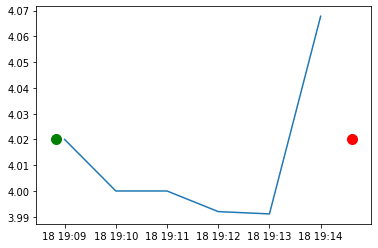

buy time:2020-02-18T19:08:49.766212495Z sell time:2020-02-18T19:14:36.282378004Z
{'rsi': 74.84142993918523, 'macd1': [0.039390325913784885, 0.042022913857100885, 0.045186076332837555, 0.04636763010917955, 0.0483603844341296], 'macd2': [0.028442641085130393, 0.029653229980764806, 0.031036257621281926, 0.03210231182773704, 0.03335164468729035], 'macd_signal': [0.02981307034423763, 0.03225503904681028, 0.03484124650401573, 0.037146523225048494, 0.03938929546686472]}
{'rsi': 69.96009795195087, 'macd': [0.029917825763253525, 0.028943723753739103, 0.027808790710562192, 0.026147689758598602, 0.025968290448515674], 'scalp': 0, 'bail_out': 1, 'movement': 0.004999999999999893, 'too_close': 1, 'macd_signal': [0.02519662796297786, 0.02594604712113011, 0.026318595839016527, 0.02628441462293294, 0.026221189788049486], 'below_cost_base': 0, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.00025289933953381166}


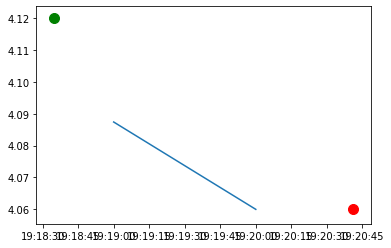

buy time:2020-02-18T19:18:34.802573522Z sell time:2020-02-18T19:20:40.908557391Z
{'rsi': 74.83112318907514, 'macd1': [0.045137773264133596, 0.054101292911515664, 0.058473266505202126, 0.06333024562840173, 0.06555232048984383], 'macd2': [0.03743271318893138, 0.03993888071328344, 0.041772921477250424, 0.04381411944285585, 0.045449281394509544], 'macd_signal': [0.043451607401328154, 0.045581544503365656, 0.04815988890373295, 0.0511939602486667, 0.05406563229690213]}
{'rsi': 58.52637001686137, 'macd': [0.03532167991765256, 0.03836367081517977, 0.038116343322147195, 0.03625457718053493, 0.032909635028882], 'scalp': 0, 'bail_out': 0, 'movement': -0.01932367149758456, 'too_close': 1, 'macd_signal': [0.028982515491133704, 0.030858746555942916, 0.032310265909183775, 0.033099128163454006, 0.0330612295365396], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0001515945076576014}


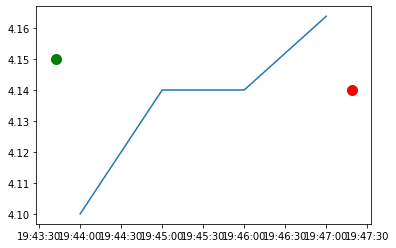

buy time:2020-02-18T19:43:42.131542892Z sell time:2020-02-18T19:47:18.464274921Z
{'rsi': 64.73577746271931, 'macd1': [0.013796908836230415, 0.013127487009737315, 0.016840874615650314, 0.022749188271387055, 0.028714400528486728], 'macd2': [0.03514168133580009, 0.034650661962404516, 0.03502313768170362, 0.035949556745830336, 0.03706426767728699], 'macd_signal': [0.01627943345091846, 0.015649044162682233, 0.01588741025327585, 0.01725976585689809, 0.019550692791215817]}
{'rsi': 61.108314513634056, 'macd': [0.01669746982374498, 0.016938540094350252, 0.018984328096195213, 0.020331898901577716, 0.021123098244712146], 'scalp': 0, 'bail_out': 0, 'movement': -0.0023855421686747036, 'too_close': 0, 'macd_signal': [0.010444050100903265, 0.011742948099592662, 0.013191224098913172, 0.014619359059446082, 0.015920106896499295], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0052029913482128515}


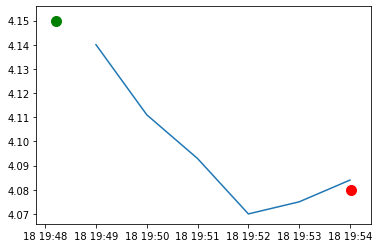

buy time:2020-02-18T19:48:12.583759487Z sell time:2020-02-18T19:54:01.36358664Z
{'rsi': 63.05259126187662, 'macd1': [0.028714400528486728, 0.02907216625096165, 0.0322120434836588, 0.03430497244393571, 0.037149233339377474], 'macd2': [0.03706426767728699, 0.037230878146128354, 0.03796436362242561, 0.03857847502845102, 0.039401648337187734], 'macd_signal': [0.019550692791215817, 0.021454987483164982, 0.023606398683263745, 0.02574611343539814, 0.028026737416194006]}
{'rsi': 50.366062043461525, 'macd': [0.022158798264135804, 0.020165787169592164, 0.017410638431381464, 0.013848046707693129, 0.011411636965758198], 'scalp': 0, 'bail_out': 0, 'movement': -0.0031517994575973353, 'too_close': 1, 'macd_signal': [0.018364433548613196, 0.01872470427280899, 0.018461891104523485, 0.017539122225157414, 0.01631362517327757], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.004901988207519373}


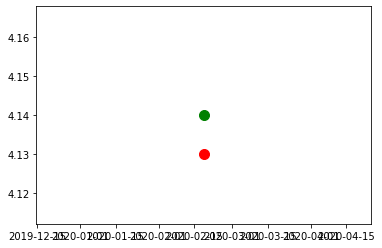

buy time:2020-02-18T20:01:03.36754027Z sell time:2020-02-18T20:01:34.095919303Z
{'rsi': 60.20402156356855, 'macd1': [0.011496034577868741, 0.010669245558871054, 0.01149533113590806, 0.012801291845712548, 0.01528201557167641], 'macd2': [0.03475247877375853, 0.03415250074295084, 0.03386575166183814, 0.033706106463003316, 0.03382679097784891], 'macd_signal': [0.021348592064425083, 0.019212722763314278, 0.017669244437833034, 0.016695653919408936, 0.01641292624986243]}
{'rsi': 59.65607664872377, 'macd': [0.005377842646479891, 0.004901834692033091, 0.0055062202510089975, 0.006419946397600462, 0.00789531811705313], 'scalp': 0, 'bail_out': 0, 'movement': -0.000917874396135272, 'too_close': 0, 'macd_signal': [0.01174363543995718, 0.010375275290372363, 0.00940146428249969, 0.008805160705519845, 0.008623192187826503], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0007278740707733732}
UNG analysis 

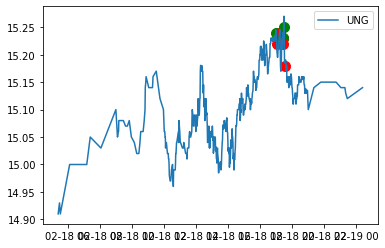

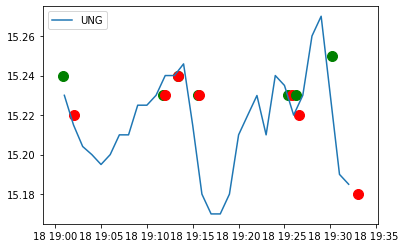

Delta = -0.09999999999999964


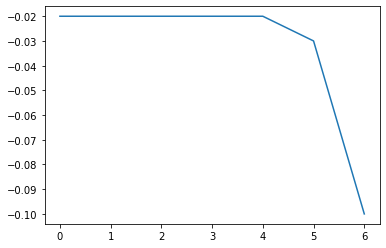

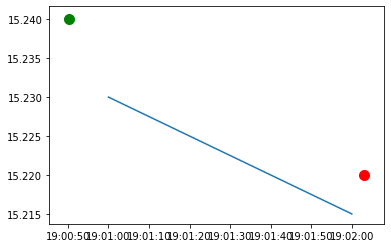

buy time:2020-02-18T19:00:50.170549866Z sell time:2020-02-18T19:02:03.045825368Z
{'rsi': 60.97930847134465, 'macd1': [0.0075113681137768396, 0.0071140756054504095, 0.00696902790684284, 0.007725255175376589, 0.007830843432200751], 'macd2': [0.010700252037294078, 0.01061934491153238, 0.010577503777575714, 0.010712415227258631, 0.010739437052452061], 'macd_signal': [0.008420039149122671, 0.00815884644038822, 0.007920882733679144, 0.007881757222018632, 0.007871574464055056]}
{'rsi': 50.52264976957893, 'macd': [0.00395625407903033, 0.004447254334561279, 0.003992874607252617, 0.0035869569676965085, 0.0029643333918407677], 'scalp': 0, 'bail_out': 0, 'movement': -0.000328299409061115, 'too_close': 1, 'macd_signal': [0.004615037314146366, 0.004581480718229348, 0.0044637594960340015, 0.004288398990366503, 0.004023585870661356], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0010592524788205883}


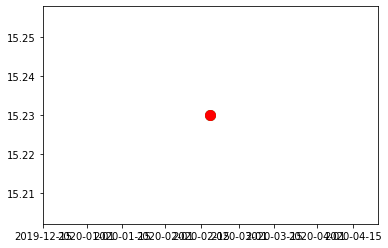

buy time:2020-02-18T19:11:46.681793014Z sell time:2020-02-18T19:11:58.065157244Z
{'rsi': 57.20105140722862, 'macd1': [-0.0032282654971016456, -0.0032857061220035177, -0.002096684319610631, -0.0011412206930110358, 1.9227683305089727e-05], 'macd2': [0.00746421851532908, 0.007154320288808691, 0.007097665710487533, 0.007034189961764525, 0.007044508051464504], 'macd_signal': [0.0010866035555967951, 0.00021214162007673247, -0.00024962356786074023, -0.00042794299289079937, -0.00033850885765162155]}
{'rsi': 57.20105140722862, 'macd': [-0.002554676572326997, -0.002550451591122993, -0.001734815870820583, -0.001076725493041053, -0.0002902040883689949], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.00017980087063435078, -0.000366249621717118, -0.0006399628715378111, -0.0007273153958384595, -0.0006398931343445666], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00034968

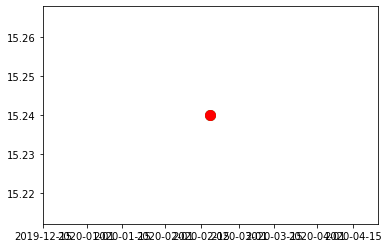

buy time:2020-02-18T19:13:20.889706251Z sell time:2020-02-18T19:13:25.820672301Z
{'rsi': 61.94457088526, 'macd1': [-0.002096684319610631, -0.0011412206930110358, 1.9227683305089727e-05, 0.0017259125629465188, 0.0030433903169324594], 'macd2': [0.007097665710487533, 0.007034189961764525, 0.007044508051464504, 0.007202670343426476, 0.007336665046517865], 'macd_signal': [-0.00024962356786074023, -0.00042794299289079937, -0.00033850885765162155, 7.437542646800653e-05, 0.0006681784045608971]}
{'rsi': 61.94457088526, 'macd': [-0.001734815870820583, -0.001076725493041053, -0.0002902040883689949, 0.0008459191371983366, 0.0017202239994951185], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [-0.0006399628715378111, -0.0007273153958384595, -0.0006398931343445666, -0.00034273068003598593, 6.986025587023503e-05], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001650363743624

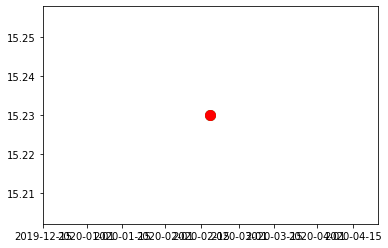

buy time:2020-02-18T19:15:31.205652083Z sell time:2020-02-18T19:15:42.818215893Z
{'rsi': 56.67811396339823, 'macd1': [1.9227683305089727e-05, 0.0017259125629465188, 0.0030433903169324594, 0.004511574992369205, 0.004740932501702488], 'macd2': [0.007044508051464504, 0.007202670343426476, 0.007336665046517865, 0.007542572744089426, 0.007545620853299795], 'macd_signal': [-0.00033850885765162155, 7.437542646800653e-05, 0.0006681784045608971, 0.0014368577221225587, 0.0020976726780385447]}
{'rsi': 53.651040904794854, 'macd': [-0.0002902040883689949, 0.0008459191371983366, 0.0017202239994951185, 0.002685653450640757, 0.002577083497630639], 'scalp': 0, 'bail_out': 0, 'movement': -0.00032819166393167085, 'too_close': 0, 'macd_signal': [-0.0006398931343445666, -0.00034273068003598593, 6.986025587023503e-05, 0.0005930188948243395, 0.0009898318153855994], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0

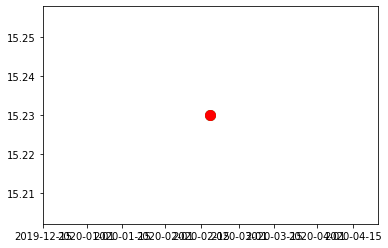

buy time:2020-02-18T19:25:20.027582782Z sell time:2020-02-18T19:25:46.620565328Z
{'rsi': 54.893706418465925, 'macd1': [-0.005660628832890424, -0.003269730604502641, -0.002946722242038291, -0.00026690973877485646, 0.0011177514502627162], 'macd2': [0.0037075232953185377, 0.0038801935137495747, 0.003714577119728446, 0.0040360718693808195, 0.0041814597668103914], 'macd_signal': [-0.004241004581259573, -0.004046749785908186, -0.003826744277134207, -0.003114777369462337, -0.0022682716055173265]}
{'rsi': 54.57593596795708, 'macd': [-0.003741312800311647, -0.0021488065446142457, -0.0019137522343992686, -0.0001472975480716343, 0.0007115930847572116], 'scalp': 0, 'bail_out': 0, 'movement': -6.565557087515237e-05, 'too_close': 0, 'macd_signal': [-0.0029471229477282305, -0.0027874596671054333, -0.0026127181805642003, -0.0021196340540656873, -0.0015533886263011075], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_sign

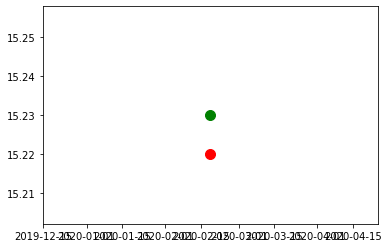

buy time:2020-02-18T19:26:12.772652854Z sell time:2020-02-18T19:26:33.15581096Z
{'rsi': 55.57321846613921, 'macd1': [-0.005660628832890424, -0.003269730604502641, -0.002946722242038291, -0.00026690973877485646, 0.0012852728177854544], 'macd2': [0.0037075232953185377, 0.0038801935137495747, 0.003714577119728446, 0.0040360718693808195, 0.004215046332184613], 'macd_signal': [-0.004241004581259573, -0.004046749785908186, -0.003826744277134207, -0.003114777369462337, -0.0022347673320127787]}
{'rsi': 52.812162456545686, 'macd': [-0.0021488065446142457, -0.0019137522343992686, -0.0001472975480716343, 0.0009713333444967276, 0.0013108985420249297], 'scalp': 0, 'bail_out': 0, 'movement': -0.0005317368099730628, 'too_close': 0, 'macd_signal': [-0.0027874596671054333, -0.0026127181805642003, -0.0021196340540656873, -0.0015014405743532043, -0.0009389727510775774], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal

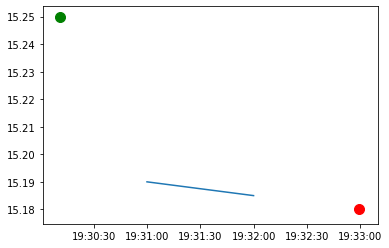

buy time:2020-02-18T19:30:10.985323359Z sell time:2020-02-18T19:32:59.528828038Z
{'rsi': 59.80367632987712, 'macd1': [0.0014368397693527157, 0.001558730811112241, 0.002434186974186403, 0.005485508048115761, 0.00741477090605791], 'macd2': [0.004245434177045482, 0.004191360179936154, 0.004294842903618701, 0.004862989395254758, 0.005297956656219682], 'macd_signal': [-0.0022044539416993265, -0.001451816991137013, -0.0006746161980723298, 0.0005574086511652886, 0.0019288811021438129]}
{'rsi': 41.79475726150371, 'macd': [0.0035992228426167117, 0.005614843998081653, 0.005034615755613814, 0.00243918315426761, 0.0001253501771891763], 'scalp': 0, 'bail_out': 0, 'movement': -0.002299605781865975, 'too_close': 1, 'macd_signal': [0.00034472543790274894, 0.0013987491499385298, 0.0021259224710735865, 0.0021885746077123912, 0.0017759297216077483], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0016505795

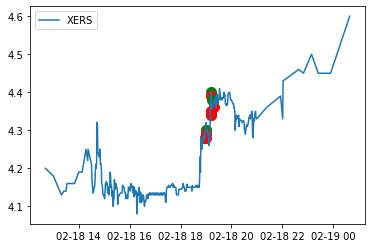

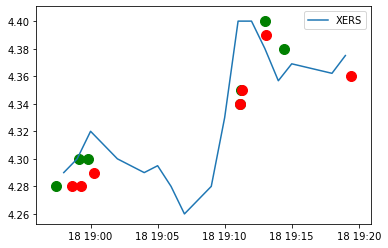

Delta = -0.05999999999999961


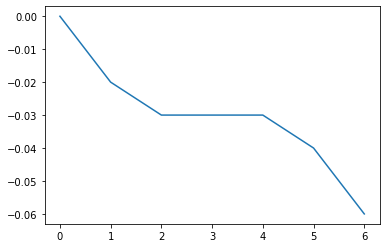

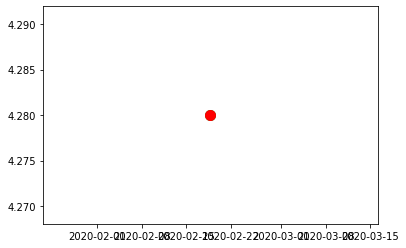

buy time:2020-02-18T18:57:26.656167802Z sell time:2020-02-18T18:58:38.616123777Z
{'rsi': 66.87406570398765, 'macd1': [0.031046832592833695, 0.033101980429528055, 0.033537187647113775, 0.03509141338571187, 0.03511148866939173], 'macd2': [0.010901749155150853, 0.012137951999044105, 0.013095949174495303, 0.014276264130119287, 0.015179422729227454], 'macd_signal': [0.01920484474805017, 0.021984271884345746, 0.024294855036899352, 0.026454166706661855, 0.028185631099207832]}
{'rsi': 66.87406570398765, 'macd': [0.020916514231881678, 0.021078139346088598, 0.021969299963054745, 0.02185891473000101, 0.021489018253205927], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.013957115343245834, 0.015381320143814386, 0.016698916107662456, 0.017730915832130167, 0.01848253631634532], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0030064819368606083}


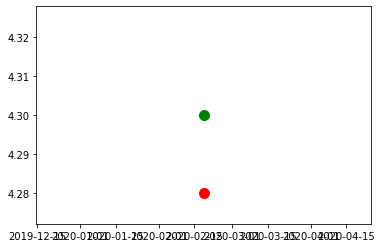

buy time:2020-02-18T18:59:07.708342812Z sell time:2020-02-18T18:59:18.282409073Z
{'rsi': 70.86062371442054, 'macd1': [0.03509141338571187, 0.03511148866939173, 0.034727086242993366, 0.034827886777946127, 0.03557093122239152], 'macd2': [0.014276264130119287, 0.015179422729227454, 0.015986080164505978, 0.016862599332005956, 0.017854770546356313], 'macd_signal': [0.026454166706661855, 0.028185631099207832, 0.02949392212796494, 0.030560715057961176, 0.031562758290847245]}
{'rsi': 64.91531396813171, 'macd': [0.021969299963054745, 0.02185891473000101, 0.021489018253205927, 0.02144118959267516, 0.020605982979369664], 'scalp': 0, 'bail_out': 0, 'movement': -0.005414449376060204, 'too_close': 0, 'macd_signal': [0.016698916107662456, 0.017730915832130167, 0.01848253631634532, 0.019074266971611287, 0.019380610173162963], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.001225372806206701}


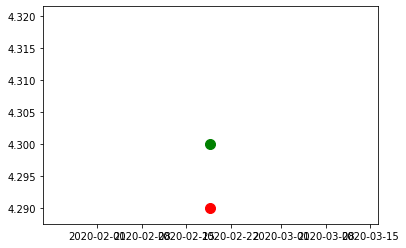

buy time:2020-02-18T18:59:49.609486489Z sell time:2020-02-18T19:00:15.737388039Z
{'rsi': 70.33907515469573, 'macd1': [0.03509141338571187, 0.03511148866939173, 0.034727086242993366, 0.034827886777946127, 0.035307683359143915], 'macd2': [0.014276264130119287, 0.015179422729227454, 0.015986080164505978, 0.016862599332005956, 0.017801991657910854], 'macd_signal': [0.026454166706661855, 0.028185631099207832, 0.02949392212796494, 0.030560715057961176, 0.031510108718197725]}
{'rsi': 68.63807948229541, 'macd': [0.021969299963054745, 0.02185891473000101, 0.021489018253205927, 0.02144118959267516, 0.021125463498849584], 'scalp': 0, 'bail_out': 0, 'movement': -0.0023255813953487877, 'too_close': 0, 'macd_signal': [0.016698916107662456, 0.017730915832130167, 0.01848253631634532, 0.019074266971611287, 0.019484506277058947], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0016409572217906364}


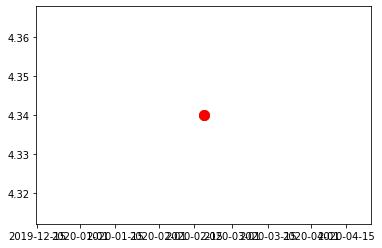

buy time:2020-02-18T19:11:07.717020257Z sell time:2020-02-18T19:11:09.384320383Z
{'rsi': 67.71973391695248, 'macd1': [0.028990645031749196, 0.024818373365750546, 0.02286211068309374, 0.02505749335983687, 0.027289687840363896], 'macd2': [0.0212816191909333, 0.021003455965431073, 0.021033816858776255, 0.021827789329049274, 0.0226832949255229], 'macd_signal': [0.0325391489422941, 0.03099499382698539, 0.02936841719820706, 0.028506232430533022, 0.028262923512499198]}
{'rsi': 67.71973391695248, 'macd': [0.01698950580598968, 0.014224931108365091, 0.012924938732185254, 0.014341503910068276, 0.01577854815374291], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 0, 'macd_signal': [0.01965912626021757, 0.018572287229847072, 0.017442817530314708, 0.016822554806265422, 0.01661375347576092], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0008352053220180081}


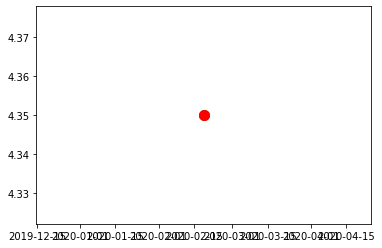

buy time:2020-02-18T19:11:14.067022894Z sell time:2020-02-18T19:11:17.734772744Z
{'rsi': 69.12128258531676, 'macd1': [0.028990645031749196, 0.024818373365750546, 0.02286211068309374, 0.02505749335983687, 0.028087408638084455], 'macd2': [0.0212816191909333, 0.021003455965431073, 0.021033816858776255, 0.021827789329049274, 0.02284323095111329], 'macd_signal': [0.0325391489422941, 0.03099499382698539, 0.02936841719820706, 0.028506232430533022, 0.02842246767204331]}
{'rsi': 68.43605899752895, 'macd': [0.01698950580598968, 0.014224931108365091, 0.012924938732185254, 0.014341503910068276, 0.016038288413483315], 'scalp': 0, 'bail_out': 0, 'movement': -0.0011494252873562975, 'too_close': 0, 'macd_signal': [0.01965912626021757, 0.018572287229847072, 0.017442817530314708, 0.016822554806265422, 0.016665701527709], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': -0.0006274131142256847}


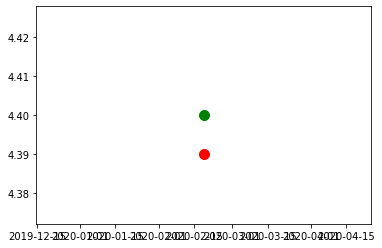

buy time:2020-02-18T19:13:02.373899522Z sell time:2020-02-18T19:13:03.486882492Z
{'rsi': 74.62907311821574, 'macd1': [0.024818373365750546, 0.02286211068309374, 0.02505749335983687, 0.03207601262668813, 0.037209313902693], 'macd2': [0.021003455965431073, 0.021033816858776255, 0.021827789329049274, 0.02364291107906169, 0.025275067617431368], 'macd_signal': [0.03099499382698539, 0.02936841719820706, 0.028506232430533022, 0.029220188469764045, 0.030818013556349836]}
{'rsi': 71.66411038809099, 'macd': [0.012924938732185254, 0.014341503910068276, 0.018895431270625984, 0.02219855088572764, 0.023964636937940043], 'scalp': 0, 'bail_out': 0, 'movement': -0.002272727272727426, 'too_close': 0, 'macd_signal': [0.017442817530314708, 0.016822554806265422, 0.017237130099137535, 0.018229414256455558, 0.019376458792752453], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.004588178145187589}


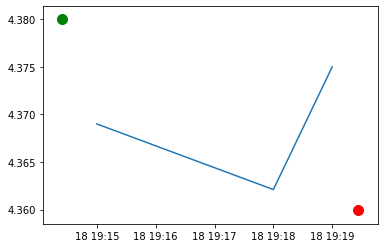

buy time:2020-02-18T19:14:24.246827124Z sell time:2020-02-18T19:19:26.079572551Z
{'rsi': 68.92573734092126, 'macd1': [0.02286211068309374, 0.02505749335983687, 0.03207601262668813, 0.037209313902693, 0.039211651781013934], 'macd2': [0.021033816858776255, 0.021827789329049274, 0.02364291107906169, 0.025275067617431368, 0.026416407851066026], 'macd_signal': [0.02936841719820706, 0.028506232430533022, 0.029220188469764045, 0.030818013556349836, 0.03249674120128265]}
{'rsi': 62.28607932221293, 'macd': [0.023445156418459234, 0.022901665191777276, 0.022819702350313165, 0.02210103387189566, 0.021144915137131015], 'scalp': 0, 'bail_out': 0, 'movement': 0.0, 'too_close': 1, 'macd_signal': [0.01927256268885629, 0.01999838318944049, 0.020562647021615026, 0.020870324391671153, 0.020925242540763125], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00021967259636788972}
RUBI analysis for run 66


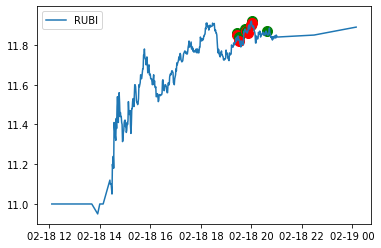

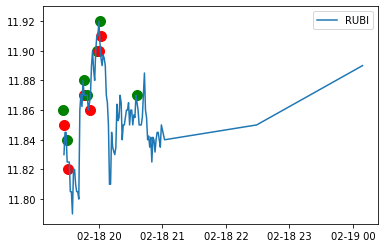

Delta = nan


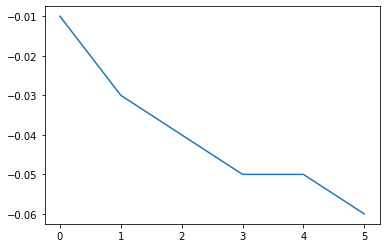

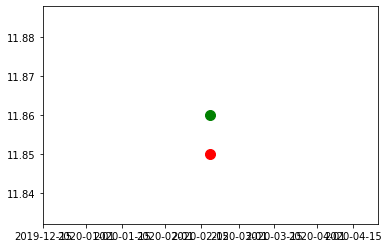

buy time:2020-02-18T19:26:08.740095329Z sell time:2020-02-18T19:26:39.119077501Z
{'rsi': 70.47519487533454, 'macd1': [0.012103064257466656, 0.013762165894947387, 0.015702918848585767, 0.01584791995074042, 0.01897180491737771], 'macd2': [-0.0034685540826338013, -0.0026633846142285478, -0.0017584072110867766, -0.0011628907642755593, 2.660739932736078e-05], 'macd_signal': [0.006036156207660012, 0.0075813581451174865, 0.009205670285811143, 0.010534120218796999, 0.01222165715851314]}
{'rsi': 68.64566120401804, 'macd': [0.00850430064242147, 0.009478190578956713, 0.010633452989518233, 0.010616339893987359, 0.012023572028716956], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008431703204047038, 'too_close': 0, 'macd_signal': [0.004907904642066064, 0.0058219618294441935, 0.006784260061459001, 0.007550676027964673, 0.00844525522811513], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.003578316800601826

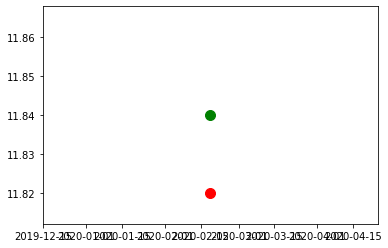

buy time:2020-02-18T19:30:19.300254112Z sell time:2020-02-18T19:30:23.711996382Z
{'rsi': 63.6075160230198, 'macd1': [0.01584791995074042, 0.017376363321934818, 0.017578119657523317, 0.018732451605261602, 0.019024507101578436], 'macd2': [-0.0011628907642755593, -0.0002932646518534199, 0.000347352198723172, 0.0011760886898795064, 0.00185670376840541], 'macd_signal': [0.010534120218796999, 0.011902568839424563, 0.013037679003044315, 0.014176633523487771, 0.015146208239105905]}
{'rsi': 55.43724886136023, 'macd': [0.011504091509236147, 0.011526961709311223, 0.012174302622234734, 0.012520616286561648, 0.011329164384914492], 'scalp': 0, 'bail_out': 0, 'movement': -0.0016891891891891533, 'too_close': 1, 'macd_signal': [0.008341359124218968, 0.008978479641237418, 0.00961764423743688, 0.010198238647261835, 0.010424423794792366], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009047405901221259}


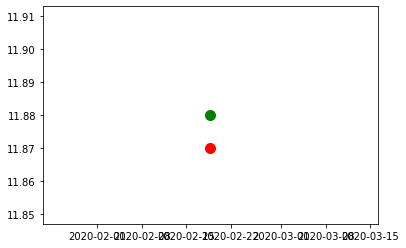

buy time:2020-02-18T19:45:57.045105639Z sell time:2020-02-18T19:46:09.309683455Z
{'rsi': 67.41788078640353, 'macd1': [0.0029299260205934985, 0.006685138464362694, 0.010412611023278728, 0.012544247802789954, 0.01547536781177783], 'macd2': [0.0027441804286567617, 0.003562038497262776, 0.004481528006207824, 0.005185973927064325, 0.006107279871958582], 'macd_signal': [0.007178166182035553, 0.007079560638500982, 0.007746170715456531, 0.008705786132923216, 0.01005970246869414]}
{'rsi': 63.549023744194045, 'macd': [0.0037421077096873034, 0.0061713434634480535, 0.007547743486334468, 0.009436526056292749, 0.010266271876309574], 'scalp': 0, 'bail_out': 0, 'movement': -0.0008417508417509732, 'too_close': 0, 'macd_signal': [0.004063187665451162, 0.004484818825050541, 0.005097403757307327, 0.005965228217104411, 0.006825436948945444], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.00344083492736413}


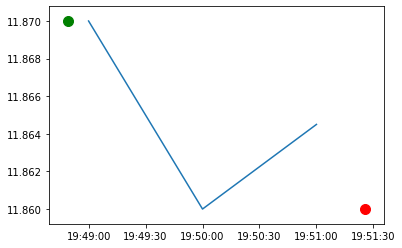

buy time:2020-02-18T19:48:49.246483353Z sell time:2020-02-18T19:51:25.378074394Z
{'rsi': 63.529281295750195, 'macd1': [0.012544247802789954, 0.01547536781177783, 0.016797751091619517, 0.017650356212959295, 0.018109230809873367], 'macd2': [0.005185973927064325, 0.006107279871958582, 0.00678520704497565, 0.007399669098925088, 0.00795155974656403], 'macd_signal': [0.008705786132923216, 0.01005970246869414, 0.011407312193279215, 0.012655920997215232, 0.013746582959746859]}
{'rsi': 60.35740139128981, 'macd': [0.01078469365974577, 0.011043402923986534, 0.011101573741264303, 0.010483244848996875, 0.010099050324516412], 'scalp': 0, 'bail_out': 0, 'movement': -0.00046335299073290787, 'too_close': 1, 'macd_signal': [0.007617288291105509, 0.008302511217681715, 0.008862323722398233, 0.009186507947717961, 0.009369016423077652], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0007300339014387602}


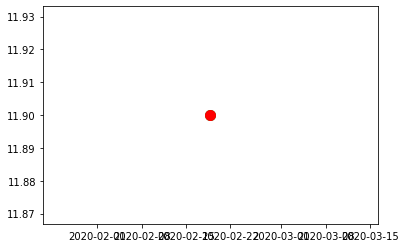

buy time:2020-02-18T19:58:38.143817744Z sell time:2020-02-18T19:59:46.326445738Z
{'rsi': 66.73721896212506, 'macd1': [0.01953360277361682, 0.019527251977610405, 0.018733361730282283, 0.019501301146418015, 0.020271609222918485], 'macd2': [0.0107865576474655, 0.0112380591963408, 0.011521926780178049, 0.012086137737110647, 0.012664268429213976], 'macd_signal': [0.016860547426605477, 0.01739388833680646, 0.017661783015501625, 0.018029686641684903, 0.018478071157931618]}
{'rsi': 63.29465035604317, 'macd': [0.01170892246334354, 0.011154576542857342, 0.011621909896467386, 0.012349417575949317, 0.012236444110923728], 'scalp': 0, 'bail_out': 0, 'movement': -0.0004199916001679131, 'too_close': 1, 'macd_signal': [0.010455081570219384, 0.010594980564746975, 0.010800366431091057, 0.011110176660062709, 0.011335430150234912], 'below_cost_base': 1, 'macd_below_signal': 1, 'data.close <= stop_prices': 0, 'data.close >= target_prices': 0, 'distance_macd_to_signal_macd': 0.0009010139606888158}


KeyError: 

In [16]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            continue
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)


        for trade in trade_details[run_id][symbol]:
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)

        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
        for trade in trade_details[run_id][symbol]:
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(trade[0], trade[1], c='g', s=100)
            plt.scatter(trade[2], trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])
